In [1]:
import random
import torch
import os
import math

import matplotlib.pyplot as plt

from collections import defaultdict

from causal_gym import AntMazePCH
from causal_rl.algo.imitation.imitate import *
from causal_rl.algo.imitation.finetune import *
from causal_rl.algo.imitation.gail.core_net import *
from causal_rl.algo.imitation.gail.causal_gail import *

<frozen importlib._bootstrap>:241: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.
/home/et2842/miniconda3/envs/causalenv/lib/python3.11/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Train expert base

In [3]:
num_steps = 1000
seed = 0
hidden_dims = {'W'}

random.seed(seed)
torch.manual_seed(seed)

In [4]:
env = AntMazePCH(env_id='antmaze-large-navigate-singletask-task1-v0', num_steps=num_steps, expert_mode=True, custom_hidden=hidden_dims, seed=seed)
train_eps = env.expert.num_eps
train_eps

1100

In [5]:
X = {f'X{t}' for t in range(num_steps)}
Y = f'Y{num_steps}'
obs_prefix = env.env.observed_unobserved_vars[0]

In [6]:
Z_sets = {}
for Xi in X:
    i = int(Xi[1:])
    cond = set()

    for j in range(i+1):
        cond.update({f'{o}{j}' for o in list(set(obs_prefix) - {'X'})})

    for j in range(i):
        cond.add(f'X{j}')

    Z_sets[Xi] = cond

In [7]:
records = collect_expert_trajectories(
    env,
    num_episodes=train_eps,
    max_steps=num_steps,
    seed=seed
)

In [8]:
hidden_size = 256
lr = 3e-4
batch_size = 2048
patience = 15
lookback = 1
num_blocks = 4
epochs = 100
dropout = 0.0

dims = {
    'P': 3,
    'O': 4,
    'A': 8,
    'L': 3,
    'T': 3,
    'J': 8,
    'X': 8
}

In [9]:
model, slots, Z_trim = train_single_policy_long_horizon(
    records,
    Z_sets,
    dims=dims,
    epochs=epochs,
    include_vars=obs_prefix,
    lookback=lookback,
    continuous=True,
    num_actions = env.action_space.shape[0],
    hidden_dim=hidden_size,
    num_blocks=num_blocks,
    dropout=dropout,
    lr=lr,
    batch_size=batch_size,
    patience=patience,
    device=device,
    seed=seed,
    action_bounds=(env.action_space.low, env.action_space.high)
)

policy = shared_policy_fn_long_horizon(model, slots, Z_trim, continuous=True, device=device)
policies = make_shared_policy_dict(policy)

[LongHorizon] Epoch 1: train loss = 0.091777, val loss = 0.069534.


[LongHorizon] Epoch 2: train loss = 0.064867, val loss = 0.061424.


[LongHorizon] Epoch 3: train loss = 0.059054, val loss = 0.057531.


[LongHorizon] Epoch 4: train loss = 0.055736, val loss = 0.055224.


[LongHorizon] Epoch 5: train loss = 0.053252, val loss = 0.052711.


[LongHorizon] Epoch 6: train loss = 0.051356, val loss = 0.051676.


[LongHorizon] Epoch 7: train loss = 0.049792, val loss = 0.049951.


[LongHorizon] Epoch 8: train loss = 0.048480, val loss = 0.049190.


[LongHorizon] Epoch 9: train loss = 0.047407, val loss = 0.047950.


[LongHorizon] Epoch 10: train loss = 0.046441, val loss = 0.047139.


[LongHorizon] Epoch 11: train loss = 0.045616, val loss = 0.046335.


[LongHorizon] Epoch 12: train loss = 0.044843, val loss = 0.045893.


[LongHorizon] Epoch 13: train loss = 0.044146, val loss = 0.045302.


[LongHorizon] Epoch 14: train loss = 0.043601, val loss = 0.044866.


[LongHorizon] Epoch 15: train loss = 0.043068, val loss = 0.044314.


[LongHorizon] Epoch 16: train loss = 0.042590, val loss = 0.044436.


[LongHorizon] Epoch 17: train loss = 0.042096, val loss = 0.043789.


[LongHorizon] Epoch 18: train loss = 0.041708, val loss = 0.043348.


[LongHorizon] Epoch 19: train loss = 0.041322, val loss = 0.043090.


[LongHorizon] Epoch 20: train loss = 0.040935, val loss = 0.042759.


[LongHorizon] Epoch 21: train loss = 0.040628, val loss = 0.042572.


[LongHorizon] Epoch 22: train loss = 0.040310, val loss = 0.042260.


[LongHorizon] Epoch 23: train loss = 0.040023, val loss = 0.041773.


[LongHorizon] Epoch 24: train loss = 0.039703, val loss = 0.041662.


[LongHorizon] Epoch 25: train loss = 0.039450, val loss = 0.041868.


[LongHorizon] Epoch 26: train loss = 0.039196, val loss = 0.041485.


[LongHorizon] Epoch 27: train loss = 0.038986, val loss = 0.041428.


[LongHorizon] Epoch 28: train loss = 0.038756, val loss = 0.041008.


[LongHorizon] Epoch 29: train loss = 0.038524, val loss = 0.040945.


[LongHorizon] Epoch 30: train loss = 0.038347, val loss = 0.040742.


[LongHorizon] Epoch 31: train loss = 0.038088, val loss = 0.040879.


[LongHorizon] Epoch 32: train loss = 0.037932, val loss = 0.040556.


[LongHorizon] Epoch 33: train loss = 0.037760, val loss = 0.040681.


[LongHorizon] Epoch 34: train loss = 0.037593, val loss = 0.040222.


[LongHorizon] Epoch 35: train loss = 0.037391, val loss = 0.040210.


[LongHorizon] Epoch 36: train loss = 0.037243, val loss = 0.040172.


[LongHorizon] Epoch 37: train loss = 0.037083, val loss = 0.040065.


[LongHorizon] Epoch 38: train loss = 0.036905, val loss = 0.040221.


[LongHorizon] Epoch 39: train loss = 0.036787, val loss = 0.039883.


[LongHorizon] Epoch 40: train loss = 0.036664, val loss = 0.039977.


[LongHorizon] Epoch 41: train loss = 0.036454, val loss = 0.039882.


[LongHorizon] Epoch 42: train loss = 0.036333, val loss = 0.039705.


[LongHorizon] Epoch 43: train loss = 0.036224, val loss = 0.039754.


[LongHorizon] Epoch 44: train loss = 0.036099, val loss = 0.039837.


[LongHorizon] Epoch 45: train loss = 0.035970, val loss = 0.039388.


[LongHorizon] Epoch 46: train loss = 0.035807, val loss = 0.039740.


[LongHorizon] Epoch 47: train loss = 0.035726, val loss = 0.039450.


[LongHorizon] Epoch 48: train loss = 0.035612, val loss = 0.039484.


[LongHorizon] Epoch 49: train loss = 0.035488, val loss = 0.039516.


[LongHorizon] Epoch 50: train loss = 0.035419, val loss = 0.039016.


[LongHorizon] Epoch 51: train loss = 0.035255, val loss = 0.039568.


[LongHorizon] Epoch 52: train loss = 0.035181, val loss = 0.039144.


[LongHorizon] Epoch 53: train loss = 0.035042, val loss = 0.039040.


[LongHorizon] Epoch 54: train loss = 0.034975, val loss = 0.038909.


[LongHorizon] Epoch 55: train loss = 0.034855, val loss = 0.039129.


[LongHorizon] Epoch 56: train loss = 0.034749, val loss = 0.038880.


[LongHorizon] Epoch 57: train loss = 0.034658, val loss = 0.038948.


[LongHorizon] Epoch 58: train loss = 0.034590, val loss = 0.038837.


[LongHorizon] Epoch 59: train loss = 0.034460, val loss = 0.038966.


[LongHorizon] Epoch 60: train loss = 0.034381, val loss = 0.038761.


[LongHorizon] Epoch 61: train loss = 0.034294, val loss = 0.038766.


[LongHorizon] Epoch 62: train loss = 0.034230, val loss = 0.038883.


[LongHorizon] Epoch 63: train loss = 0.034132, val loss = 0.038698.


[LongHorizon] Epoch 64: train loss = 0.034017, val loss = 0.038624.


[LongHorizon] Epoch 65: train loss = 0.033945, val loss = 0.038644.


[LongHorizon] Epoch 66: train loss = 0.033850, val loss = 0.038646.


[LongHorizon] Epoch 67: train loss = 0.033788, val loss = 0.038722.


[LongHorizon] Epoch 68: train loss = 0.033712, val loss = 0.038672.


[LongHorizon] Epoch 69: train loss = 0.033626, val loss = 0.038640.


[LongHorizon] Epoch 70: train loss = 0.033539, val loss = 0.038686.


[LongHorizon] Epoch 71: train loss = 0.033477, val loss = 0.038436.


[LongHorizon] Epoch 72: train loss = 0.033378, val loss = 0.038373.


[LongHorizon] Epoch 73: train loss = 0.033308, val loss = 0.038398.


[LongHorizon] Epoch 74: train loss = 0.033245, val loss = 0.038616.


[LongHorizon] Epoch 75: train loss = 0.033180, val loss = 0.038482.


[LongHorizon] Epoch 76: train loss = 0.033096, val loss = 0.038442.


[LongHorizon] Epoch 77: train loss = 0.033053, val loss = 0.038414.


[LongHorizon] Epoch 78: train loss = 0.032978, val loss = 0.038440.


[LongHorizon] Epoch 79: train loss = 0.032890, val loss = 0.038396.


[LongHorizon] Epoch 80: train loss = 0.032831, val loss = 0.038366.


[LongHorizon] Epoch 81: train loss = 0.032742, val loss = 0.038379.


[LongHorizon] Epoch 82: train loss = 0.032692, val loss = 0.038323.


[LongHorizon] Epoch 83: train loss = 0.032642, val loss = 0.038388.


[LongHorizon] Epoch 84: train loss = 0.032554, val loss = 0.038370.


[LongHorizon] Epoch 85: train loss = 0.032475, val loss = 0.038537.


[LongHorizon] Epoch 86: train loss = 0.032443, val loss = 0.038293.


[LongHorizon] Epoch 87: train loss = 0.032384, val loss = 0.038309.


[LongHorizon] Epoch 88: train loss = 0.032359, val loss = 0.038240.


[LongHorizon] Epoch 89: train loss = 0.032271, val loss = 0.038301.


[LongHorizon] Epoch 90: train loss = 0.032178, val loss = 0.038164.


[LongHorizon] Epoch 91: train loss = 0.032160, val loss = 0.038382.


[LongHorizon] Epoch 92: train loss = 0.032079, val loss = 0.038293.


[LongHorizon] Epoch 93: train loss = 0.032010, val loss = 0.038178.


[LongHorizon] Epoch 94: train loss = 0.031950, val loss = 0.038217.


[LongHorizon] Epoch 95: train loss = 0.031929, val loss = 0.038450.


[LongHorizon] Epoch 96: train loss = 0.031848, val loss = 0.038210.


[LongHorizon] Epoch 97: train loss = 0.031832, val loss = 0.038333.


[LongHorizon] Epoch 98: train loss = 0.031736, val loss = 0.038332.


[LongHorizon] Epoch 99: train loss = 0.031679, val loss = 0.038415.


[LongHorizon] Epoch 100: train loss = 0.031633, val loss = 0.038380.


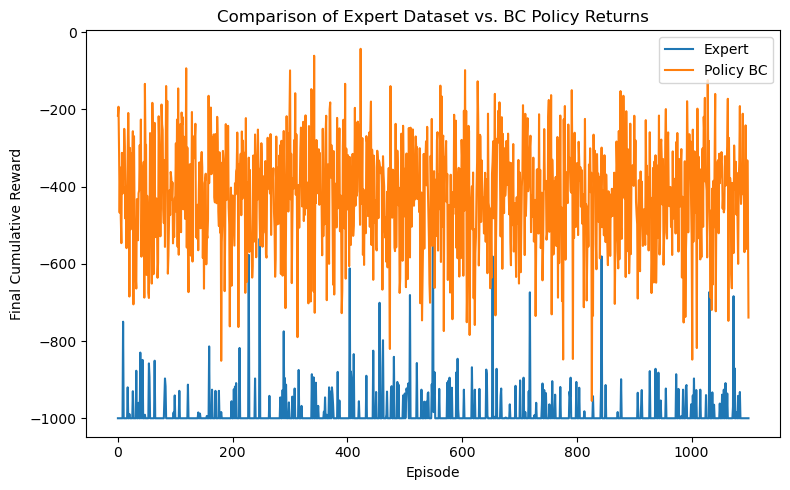

In [10]:
expert_episode_rewards = defaultdict(float)
for rec in records:
    ep = rec['episode']
    expert_episode_rewards[ep] += float(rec['reward'])

num_eps = len(expert_episode_rewards)
expert_rewards = [expert_episode_rewards[e] for e in range(num_eps)]

policy_records = collect_imitator_trajectories(env, policies, num_episodes=num_eps, max_steps=num_steps, seed=seed)
policy_episode_rewards = defaultdict(float)
for rec in policy_records:
    ep = rec['episode']
    policy_episode_rewards[ep] += float(rec['reward'])

policy_rewards = [policy_episode_rewards[e] for e in range(num_eps)]
plt.figure(figsize=(8,5))
plt.plot(expert_rewards, label='Expert')
plt.plot(policy_rewards, label='Policy BC')
plt.xlabel('Episode')
plt.ylabel('Final Cumulative Reward')
plt.title('Comparison of Expert Dataset vs. BC Policy Returns')
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
sum(expert_rewards)/num_eps, sum(policy_rewards)/num_eps

(-983.9190909090909, -421.7652822058732)

In [12]:
# save model for fine-tuning
import os
import torch

SAVE_DIR = '/home/et2842/causal/causalrl/models'
os.makedirs(SAVE_DIR, exist_ok=True)
MODEL_PATH = os.path.join(SAVE_DIR, 'antmaze_large_expert.pt')

checkpoint = {
    "state_dict": model.state_dict(),
    "slots": slots,
    "Z_trim": Z_trim,
    "dims": dims,
    "lookback": lookback,
    "continuous": True,
    "num_actions": env.action_space.shape[0],
    "hidden_dim": hidden_size,
    "num_blocks": num_blocks,
    "dropout": 0.0,
    "layernorm": True,
    "final_tanh": True,
    "action_bounds_low": env.action_space.low,
    "action_bounds_high": env.action_space.high,
    "input_dim": int(model.hidden.in_features),
}

torch.save(checkpoint, MODEL_PATH)
print("Saved expert to:", MODEL_PATH)

Saved expert to: /home/et2842/causal/causalrl/models/antmaze_large_expert.pt


# Fine-tune expert

In [13]:
# load model
MODEL_PATH = "/home/et2842/causal/causalrl/models/antmaze_large_expert.pt"
checkpoint = torch.load(MODEL_PATH, map_location=device)

# Rebuild the model with the same architecture
action_bounds = (checkpoint['action_bounds_low'], checkpoint['action_bounds_high'])

pretrained_actor = ContinuousPolicyNN(
    input_dim=checkpoint['input_dim'],
    action_dim=checkpoint['num_actions'],
    hidden_dim=checkpoint['hidden_dim'],
    num_blocks=checkpoint['num_blocks'],
    dropout=checkpoint['dropout'],
    layernorm=checkpoint['layernorm'],
    final_tanh=checkpoint['final_tanh'],
    action_bounds=action_bounds,
).to(device)

pretrained_actor.load_state_dict(checkpoint['state_dict'])
# pretrained_actor.eval()
pretrained_actor.train()

slots = checkpoint['slots']
Z_trim = checkpoint['Z_trim']
dims = checkpoint['dims']
lookback = checkpoint['lookback']

state_dim = checkpoint['input_dim']
state_dim

/tmp/ipykernel_1648198/2613710490.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(MODEL_PATH, map_location=device)


44

In [14]:
num_steps = 1000
rl_seed_pretrain = 2014
rl_seed = 90210
hidden_dims = set() # {'W'}

env_pretrain = AntMazePCH(env_id='antmaze-large-navigate-singletask-task1-v0', num_steps=num_steps, expert_mode=True, seed=rl_seed_pretrain)
env_train = AntMazePCH(env_id='antmaze-large-navigate-singletask-task1-v0', num_steps=num_steps, expert_mode=True, seed=rl_seed)
action_dim = env_train.env.action_space.shape[0]
action_dim

8

In [15]:
# reward shaping
def make_dense_distance_reward(env, use_delta=True, c=1.0):
        goal_xy = env.env._goal_xy
    
        def reward_fn(obs, reward_env):
            t = len(obs['P']) - 1
    
            P_curr = obs['P'][t]
            curr_xy = np.array(P_curr[:2], dtype=np.float64)
            dist_curr = np.linalg.norm(curr_xy - goal_xy)
    
            if use_delta:
                if t == 0:
                    return 0.0
                P_prev = obs['P'][t - 1]
                prev_xy = np.array(P_prev[:2], dtype=np.float64)
                dist_prev = np.linalg.norm(prev_xy - goal_xy)
                return float(c * (dist_prev - dist_curr))
            else:
                return float(-c * dist_curr)
    
        return reward_fn

reward_fn = make_dense_distance_reward(env_train)

In [16]:
config = OnlineRLConfig(
    total_env_steps=200_000,
    start_steps=10_000,
    max_episode_steps=num_steps,
    batch_size=256,
    gamma=0.99,
    tau=0.005,
    policy_delay=2,
    actor_lr=3e-6,
    critic_lr=3e-4,
    noise_std=0.05,
    hidden_dim_q=256,
    target_policy_noise=0.1,
    target_noise_clip=0.2,
    actor_warmup_steps=30_000,
    bc_reg_lambda=0.1,
    max_grad_norm=1.0
)

In [17]:
# pretrain critics offline
replay_buffer, q1, q2, target_q1, target_q2 = pretrain_critics_offline(
    env=env_pretrain,
    pretrained_actor=pretrained_actor,
    Z_trim=Z_trim,
    slots=slots,
    state_dim=state_dim,
    action_dim=action_dim,
    config=config,
    device=device,
    num_pretrain_steps=100_000,
    pretrain_updates=50_000,
    seed=rl_seed_pretrain,
    reward_shaping_fn=reward_fn
)

In [18]:
def callback(stats: dict):
    if stats['episode'] % 1 == 0:
        print(
            f'[Episode {stats["episode"]}] '
            f'steps={stats["env_steps"]}, '
            f'return={stats["return"]:.2f}, '
            f'len={stats["length"]}, '
            f'buffer={stats["buffer_size"]}'
        )

In [19]:
fine_tuned_policy, logs = td3_fine_tune_actor(
    env=env_train,
    actor=pretrained_actor,
    Z_trim=Z_trim,
    slots=slots,
    state_dim=state_dim,
    action_dim=action_dim,
    config=config,
    device=device,
    seed=rl_seed,
    log_callback=callback,
    replay_buffer=replay_buffer,
    initial_q1=q1,
    initial_q2=q2,
    initial_target_q1=target_q1,
    initial_target_q2=target_q2,
    reward_shaping_fn=reward_fn
)

ft_pi = shared_policy_fn_long_horizon(fine_tuned_policy, slots, Z_trim, continuous=True, device=device)
ft_policies = make_shared_policy_dict(ft_pi)

[Episode 1] steps=1000, return=7.56, len=1000, buffer=101000


[Episode 2] steps=2000, return=0.32, len=1000, buffer=102000


[Episode 3] steps=3000, return=5.51, len=1000, buffer=103000


[Episode 4] steps=4000, return=9.19, len=1000, buffer=104000


[Episode 5] steps=5000, return=11.66, len=1000, buffer=105000


[Episode 6] steps=6000, return=6.44, len=1000, buffer=106000


[Episode 7] steps=7000, return=6.56, len=1000, buffer=107000


[Episode 8] steps=8000, return=9.57, len=1000, buffer=108000


[Episode 9] steps=9000, return=-1.30, len=1000, buffer=109000


[Episode 10] steps=10000, return=14.24, len=1000, buffer=110000


[Episode 11] steps=11000, return=10.46, len=1000, buffer=111000


[Episode 12] steps=12000, return=19.89, len=1000, buffer=112000


[Episode 13] steps=13000, return=1.76, len=1000, buffer=113000


[Episode 14] steps=14000, return=10.74, len=1000, buffer=114000


[Episode 15] steps=15000, return=4.81, len=1000, buffer=115000


[Episode 16] steps=16000, return=8.63, len=1000, buffer=116000


[Episode 17] steps=17000, return=8.56, len=1000, buffer=117000


[Episode 18] steps=18000, return=17.80, len=1000, buffer=118000


[Episode 19] steps=19000, return=21.84, len=1000, buffer=119000


[Episode 20] steps=20000, return=6.63, len=1000, buffer=120000


[Episode 21] steps=21000, return=12.12, len=1000, buffer=121000


[Episode 22] steps=22000, return=6.83, len=1000, buffer=122000


[Episode 23] steps=23000, return=18.87, len=1000, buffer=123000


[Episode 24] steps=24000, return=7.29, len=1000, buffer=124000


[Episode 25] steps=25000, return=9.60, len=1000, buffer=125000


[Episode 26] steps=26000, return=20.03, len=1000, buffer=126000


[Episode 27] steps=27000, return=7.17, len=1000, buffer=127000


[Episode 28] steps=28000, return=-0.99, len=1000, buffer=128000


[Episode 29] steps=29000, return=6.01, len=1000, buffer=129000


[Episode 30] steps=30000, return=24.11, len=1000, buffer=130000


[Episode 31] steps=31000, return=1.39, len=1000, buffer=131000


[Episode 32] steps=32000, return=20.04, len=1000, buffer=132000


[Episode 33] steps=33000, return=12.07, len=1000, buffer=133000


[Episode 34] steps=34000, return=0.12, len=1000, buffer=134000


[Episode 35] steps=35000, return=0.08, len=1000, buffer=135000


[Episode 36] steps=36000, return=0.12, len=1000, buffer=136000


[Episode 37] steps=37000, return=0.11, len=1000, buffer=137000


[Episode 38] steps=38000, return=-0.25, len=1000, buffer=138000


[Episode 39] steps=39000, return=0.06, len=1000, buffer=139000


[Episode 40] steps=40000, return=0.04, len=1000, buffer=140000


[Episode 41] steps=41000, return=-0.08, len=1000, buffer=141000


[Episode 42] steps=42000, return=0.12, len=1000, buffer=142000


[Episode 43] steps=43000, return=-0.18, len=1000, buffer=143000


[Episode 44] steps=44000, return=-0.88, len=1000, buffer=144000


[Episode 45] steps=45000, return=2.71, len=1000, buffer=145000


[Episode 46] steps=46000, return=0.74, len=1000, buffer=146000


[Episode 47] steps=47000, return=0.25, len=1000, buffer=147000


[Episode 48] steps=48000, return=0.35, len=1000, buffer=148000


[Episode 49] steps=49000, return=-1.95, len=1000, buffer=149000


[Episode 50] steps=50000, return=0.05, len=1000, buffer=150000


[Episode 51] steps=51000, return=-0.20, len=1000, buffer=151000


[Episode 52] steps=52000, return=0.07, len=1000, buffer=152000


[Episode 53] steps=53000, return=-0.20, len=1000, buffer=153000


[Episode 54] steps=54000, return=0.07, len=1000, buffer=154000


[Episode 55] steps=55000, return=0.09, len=1000, buffer=155000


[Episode 56] steps=56000, return=0.33, len=1000, buffer=156000


[Episode 57] steps=57000, return=0.25, len=1000, buffer=157000


[Episode 58] steps=58000, return=0.21, len=1000, buffer=158000


[Episode 59] steps=59000, return=0.26, len=1000, buffer=159000


[Episode 60] steps=60000, return=0.16, len=1000, buffer=160000


[Episode 61] steps=61000, return=9.39, len=1000, buffer=161000


[Episode 62] steps=62000, return=-0.28, len=1000, buffer=162000


[Episode 63] steps=63000, return=1.56, len=1000, buffer=163000


[Episode 64] steps=64000, return=4.89, len=1000, buffer=164000


[Episode 65] steps=65000, return=-0.66, len=1000, buffer=165000


[Episode 66] steps=66000, return=2.32, len=1000, buffer=166000


[Episode 67] steps=67000, return=-0.07, len=1000, buffer=167000


[Episode 68] steps=68000, return=-0.04, len=1000, buffer=168000


[Episode 69] steps=69000, return=-0.33, len=1000, buffer=169000


[Episode 70] steps=70000, return=1.35, len=1000, buffer=170000


[Episode 71] steps=71000, return=2.49, len=1000, buffer=171000


[Episode 72] steps=72000, return=1.81, len=1000, buffer=172000


[Episode 73] steps=73000, return=6.23, len=1000, buffer=173000


[Episode 74] steps=74000, return=7.53, len=1000, buffer=174000


[Episode 75] steps=75000, return=1.81, len=1000, buffer=175000


[Episode 76] steps=76000, return=1.52, len=1000, buffer=176000


[Episode 77] steps=77000, return=0.65, len=1000, buffer=177000


[Episode 78] steps=78000, return=1.19, len=1000, buffer=178000


[Episode 79] steps=79000, return=-0.51, len=1000, buffer=179000


[Episode 80] steps=80000, return=-0.15, len=1000, buffer=180000


[Episode 81] steps=81000, return=6.89, len=1000, buffer=181000


[Episode 82] steps=82000, return=1.33, len=1000, buffer=182000


[Episode 83] steps=83000, return=-0.32, len=1000, buffer=183000


[Episode 84] steps=84000, return=1.57, len=1000, buffer=184000


[Episode 85] steps=85000, return=1.15, len=1000, buffer=185000


[Episode 86] steps=86000, return=-0.35, len=1000, buffer=186000


[Episode 87] steps=87000, return=5.45, len=1000, buffer=187000


[Episode 88] steps=88000, return=0.84, len=1000, buffer=188000


[Episode 89] steps=89000, return=4.65, len=1000, buffer=189000


[Episode 90] steps=90000, return=1.49, len=1000, buffer=190000


[Episode 91] steps=91000, return=0.81, len=1000, buffer=191000


[Episode 92] steps=92000, return=0.90, len=1000, buffer=192000


[Episode 93] steps=93000, return=3.43, len=1000, buffer=193000


[Episode 94] steps=94000, return=0.06, len=1000, buffer=194000


[Episode 95] steps=95000, return=2.64, len=1000, buffer=195000


[Episode 96] steps=96000, return=8.16, len=1000, buffer=196000


[Episode 97] steps=97000, return=1.68, len=1000, buffer=197000


[Episode 98] steps=98000, return=0.61, len=1000, buffer=198000


[Episode 99] steps=99000, return=0.74, len=1000, buffer=199000


[Episode 100] steps=100000, return=0.66, len=1000, buffer=200000


[Episode 101] steps=101000, return=4.83, len=1000, buffer=201000


[Episode 102] steps=102000, return=4.16, len=1000, buffer=202000


[Episode 103] steps=103000, return=2.13, len=1000, buffer=203000


[Episode 104] steps=104000, return=3.84, len=1000, buffer=204000


[Episode 105] steps=105000, return=3.43, len=1000, buffer=205000


[Episode 106] steps=106000, return=1.64, len=1000, buffer=206000


[Episode 107] steps=107000, return=11.42, len=1000, buffer=207000


[Episode 108] steps=108000, return=2.34, len=1000, buffer=208000


[Episode 109] steps=109000, return=6.52, len=1000, buffer=209000


[Episode 110] steps=110000, return=5.04, len=1000, buffer=210000


[Episode 111] steps=111000, return=11.92, len=1000, buffer=211000


[Episode 112] steps=112000, return=3.84, len=1000, buffer=212000


[Episode 113] steps=113000, return=6.58, len=1000, buffer=213000


[Episode 114] steps=114000, return=11.10, len=1000, buffer=214000


[Episode 115] steps=115000, return=9.95, len=1000, buffer=215000


[Episode 116] steps=116000, return=8.89, len=1000, buffer=216000


[Episode 117] steps=117000, return=5.01, len=1000, buffer=217000


[Episode 118] steps=118000, return=9.62, len=1000, buffer=218000


[Episode 119] steps=119000, return=1.58, len=1000, buffer=219000


[Episode 120] steps=120000, return=5.34, len=1000, buffer=220000


[Episode 121] steps=121000, return=9.38, len=1000, buffer=221000


[Episode 122] steps=122000, return=6.73, len=1000, buffer=222000


[Episode 123] steps=123000, return=8.14, len=1000, buffer=223000


[Episode 124] steps=124000, return=10.47, len=1000, buffer=224000


[Episode 125] steps=125000, return=5.06, len=1000, buffer=225000


[Episode 126] steps=126000, return=13.09, len=1000, buffer=226000


[Episode 127] steps=127000, return=9.50, len=1000, buffer=227000


[Episode 128] steps=128000, return=6.34, len=1000, buffer=228000


[Episode 129] steps=129000, return=5.27, len=1000, buffer=229000


[Episode 130] steps=130000, return=10.52, len=1000, buffer=230000


[Episode 131] steps=131000, return=5.86, len=1000, buffer=231000


[Episode 132] steps=132000, return=2.76, len=1000, buffer=232000


[Episode 133] steps=133000, return=2.28, len=1000, buffer=233000


[Episode 134] steps=134000, return=5.61, len=1000, buffer=234000


[Episode 135] steps=135000, return=0.46, len=1000, buffer=235000


[Episode 136] steps=136000, return=4.91, len=1000, buffer=236000


[Episode 137] steps=137000, return=1.56, len=1000, buffer=237000


[Episode 138] steps=138000, return=3.60, len=1000, buffer=238000


[Episode 139] steps=139000, return=2.39, len=1000, buffer=239000


[Episode 140] steps=140000, return=6.10, len=1000, buffer=240000


[Episode 141] steps=141000, return=5.87, len=1000, buffer=241000


[Episode 142] steps=142000, return=3.71, len=1000, buffer=242000


[Episode 143] steps=143000, return=2.93, len=1000, buffer=243000


[Episode 144] steps=144000, return=0.19, len=1000, buffer=244000


[Episode 145] steps=145000, return=2.60, len=1000, buffer=245000


[Episode 146] steps=146000, return=5.08, len=1000, buffer=246000


[Episode 147] steps=147000, return=7.05, len=1000, buffer=247000


[Episode 148] steps=148000, return=2.93, len=1000, buffer=248000


[Episode 149] steps=149000, return=1.50, len=1000, buffer=249000


[Episode 150] steps=150000, return=3.85, len=1000, buffer=250000


[Episode 151] steps=151000, return=0.51, len=1000, buffer=251000


[Episode 152] steps=152000, return=0.59, len=1000, buffer=252000


[Episode 153] steps=153000, return=1.57, len=1000, buffer=253000


[Episode 154] steps=154000, return=0.33, len=1000, buffer=254000


[Episode 155] steps=155000, return=-1.39, len=1000, buffer=255000


[Episode 156] steps=156000, return=3.51, len=1000, buffer=256000


[Episode 157] steps=157000, return=-0.34, len=1000, buffer=257000


[Episode 158] steps=158000, return=1.51, len=1000, buffer=258000


[Episode 159] steps=159000, return=-0.02, len=1000, buffer=259000


[Episode 160] steps=160000, return=0.66, len=1000, buffer=260000


[Episode 161] steps=161000, return=12.54, len=1000, buffer=261000


[Episode 162] steps=162000, return=0.02, len=1000, buffer=262000


[Episode 163] steps=163000, return=0.18, len=1000, buffer=263000


[Episode 164] steps=164000, return=13.59, len=1000, buffer=264000


[Episode 165] steps=165000, return=15.23, len=1000, buffer=265000


[Episode 166] steps=166000, return=-1.75, len=1000, buffer=266000


[Episode 167] steps=167000, return=11.23, len=1000, buffer=267000


[Episode 168] steps=168000, return=-0.78, len=1000, buffer=268000


[Episode 169] steps=169000, return=-0.06, len=1000, buffer=269000


[Episode 170] steps=170000, return=17.66, len=1000, buffer=270000


[Episode 171] steps=171000, return=0.07, len=1000, buffer=271000


[Episode 172] steps=172000, return=1.20, len=1000, buffer=272000


[Episode 173] steps=173000, return=11.63, len=1000, buffer=273000


[Episode 174] steps=174000, return=11.29, len=1000, buffer=274000


[Episode 175] steps=175000, return=0.50, len=1000, buffer=275000


[Episode 176] steps=176000, return=3.20, len=1000, buffer=276000


[Episode 177] steps=177000, return=7.13, len=1000, buffer=277000


[Episode 178] steps=178000, return=3.49, len=1000, buffer=278000


[Episode 179] steps=179000, return=11.79, len=1000, buffer=279000


[Episode 180] steps=180000, return=11.06, len=1000, buffer=280000


[Episode 181] steps=181000, return=0.83, len=1000, buffer=281000


[Episode 182] steps=182000, return=11.45, len=1000, buffer=282000


[Episode 183] steps=183000, return=3.03, len=1000, buffer=283000


[Episode 184] steps=184000, return=9.11, len=1000, buffer=284000


[Episode 185] steps=185000, return=10.04, len=1000, buffer=285000


[Episode 186] steps=186000, return=4.00, len=1000, buffer=286000


[Episode 187] steps=187000, return=10.33, len=1000, buffer=287000


[Episode 188] steps=188000, return=5.86, len=1000, buffer=288000


[Episode 189] steps=189000, return=0.45, len=1000, buffer=289000


[Episode 190] steps=190000, return=5.90, len=1000, buffer=290000


[Episode 191] steps=191000, return=1.89, len=1000, buffer=291000


[Episode 192] steps=192000, return=0.89, len=1000, buffer=292000


[Episode 193] steps=193000, return=8.82, len=1000, buffer=293000


[Episode 194] steps=194000, return=3.29, len=1000, buffer=294000


[Episode 195] steps=195000, return=1.05, len=1000, buffer=295000


[Episode 196] steps=196000, return=2.89, len=1000, buffer=296000


[Episode 197] steps=197000, return=6.36, len=1000, buffer=297000


[Episode 198] steps=198000, return=8.95, len=1000, buffer=298000


[Episode 199] steps=199000, return=11.93, len=1000, buffer=299000


[Episode 200] steps=200000, return=8.02, len=1000, buffer=300000


In [20]:
# save expert
import os
import torch

SAVE_DIR = '/home/et2842/causal/causalrl/models'
os.makedirs(SAVE_DIR, exist_ok=True)
MODEL_PATH = os.path.join(SAVE_DIR, 'antmaze_large_expert_finetuned.pt')

checkpoint = {
    "state_dict": fine_tuned_policy.state_dict(),
    "slots": slots,
    "Z_trim": Z_trim,
    "dims": dims,
    "lookback": lookback,
    "continuous": True,
    "num_actions": env_train.action_space.shape[0],
    "hidden_dim": config.hidden_dim_q,
    "num_blocks": checkpoint['num_blocks'],
    "dropout": 0.0,
    "layernorm": True,
    "final_tanh": True,
    "action_bounds_low": env_train.action_space.low,
    "action_bounds_high": env_train.action_space.high,
    "input_dim": int(fine_tuned_policy.hidden.in_features),
}

torch.save(checkpoint, MODEL_PATH)
print("Saved expert to:", MODEL_PATH)

Saved expert to: /home/et2842/causal/causalrl/models/antmaze_large_expert_finetuned.pt


# Test BC

In [21]:
num_steps = 1000
seed = 0
lookback = 1
hidden_dims = {'O'}
train_eps = 1000

random.seed(seed)
torch.manual_seed(seed)

In [22]:
expert_env = AntMazePCH(env_id='antmaze-large-navigate-singletask-task1-v0', num_steps=num_steps, expert_mode=True, seed=seed)

In [23]:
env = AntMazePCH(env_id='antmaze-large-navigate-singletask-task1-v0', num_steps=num_steps, seed=seed)

In [24]:
# to save time; conceptually the same
small_steps = lookback + 1
small_env = AntMazePCH(env_id='antmaze-large-navigate-singletask-task1-v0', num_steps=small_steps, seed=seed)
G = parse_graph(small_env.get_graph)
X_small = {f'X{t}' for t in range(small_steps)}
Y = f'Y{small_steps}'

# G = parse_graph(env.get_graph)
X = {f'X{t}' for t in range(num_steps)}
# Y = f'Y{num_steps}'
obs_prefix = env.env.observed_unobserved_vars[0]

In [25]:
Z_sets = find_sequential_pi_backdoor(G, X_small, Y, obs_prefix)

base_step = small_steps - 1
base_Z_set = Z_sets[f'X{base_step}']

for i in range(base_step + 1, num_steps):
    updated_base_Z_set = set()
    for v in base_Z_set:
        updated_base_Z_set.add(f'{v[0]}{int(v[1:]) + i - lookback}')

    Z_sets[f'X{i}'] = updated_base_Z_set

Z_sets['X1']

{'A0', 'A1', 'J0', 'J1', 'L0', 'L1', 'P0', 'P1', 'T0', 'T1', 'X0'}

In [26]:
naive_Z_sets = {}
for Xi in X:
    i = int(Xi[1:])
    cond = set()

    for j in range(i+1):
        cond.update({f'{o}{j}' for o in list(set(obs_prefix) - {'X'})})

    for j in range(i):
        cond.add(f'X{j}')
    naive_Z_sets[Xi] = cond

naive_Z_sets['X1']

{'A0', 'A1', 'J0', 'J1', 'L0', 'L1', 'P0', 'P1', 'T0', 'T1', 'W0', 'W1', 'X0'}

In [27]:
# load expert
MODEL_PATH = '/home/et2842/causal/causalrl/models/antmaze_large_expert_finetuned.pt'
checkpoint = torch.load(MODEL_PATH, map_location=device, weights_only=False)

# Rebuild the model with the same architecture
action_bounds = (checkpoint['action_bounds_low'], checkpoint['action_bounds_high'])

expert = ContinuousPolicyNN(
    input_dim=checkpoint['input_dim'],
    action_dim=checkpoint['num_actions'],
    hidden_dim=checkpoint['hidden_dim'],
    num_blocks=checkpoint['num_blocks'],
    dropout=checkpoint['dropout'],
    layernorm=checkpoint['layernorm'],
    final_tanh=checkpoint['final_tanh'],
    action_bounds=action_bounds,
).to(device)

expert.load_state_dict(checkpoint['state_dict'])
expert.eval()

slots = checkpoint['slots']
Z_trim = checkpoint['Z_trim']
dims = checkpoint['dims']
lookback = checkpoint['lookback']

state_dim = checkpoint['input_dim']
state_dim

expert_policy = shared_policy_fn_long_horizon(expert, slots, Z_trim, continuous=True, device=device)
expert_policies = make_shared_policy_dict(expert_policy)

In [28]:
records = collect_imitator_trajectories(
    expert_env,
    expert_policies,
    num_episodes=train_eps,
    max_steps=num_steps,
    seed=seed,
    hidden_dims=hidden_dims,
    show_progress=True
)

Starting episode 1/1000...


  Episode 1 ended at step 1000 (terminated: False, truncated: True).
Starting episode 2/1000...


  Episode 2 ended at step 1000 (terminated: False, truncated: True).
Starting episode 3/1000...


  Episode 3 ended at step 1000 (terminated: False, truncated: True).
Starting episode 4/1000...


  Episode 4 ended at step 1000 (terminated: False, truncated: True).
Starting episode 5/1000...


  Episode 5 ended at step 1000 (terminated: False, truncated: True).
Starting episode 6/1000...


  Episode 6 ended at step 1000 (terminated: False, truncated: True).
Starting episode 7/1000...


  Episode 7 ended at step 1000 (terminated: False, truncated: True).
Starting episode 8/1000...


  Episode 8 ended at step 1000 (terminated: False, truncated: True).
Starting episode 9/1000...


  Episode 9 ended at step 1000 (terminated: False, truncated: True).
Starting episode 10/1000...


  Episode 10 ended at step 1000 (terminated: False, truncated: True).
Starting episode 11/1000...


  Episode 11 ended at step 1000 (terminated: False, truncated: True).
Starting episode 12/1000...


  Episode 12 ended at step 1000 (terminated: False, truncated: True).
Starting episode 13/1000...


  Episode 13 ended at step 1000 (terminated: False, truncated: True).
Starting episode 14/1000...


  Episode 14 ended at step 1000 (terminated: False, truncated: True).
Starting episode 15/1000...


  Episode 15 ended at step 1000 (terminated: False, truncated: True).
Starting episode 16/1000...


  Episode 16 ended at step 1000 (terminated: False, truncated: True).
Starting episode 17/1000...


  Episode 17 ended at step 1000 (terminated: False, truncated: True).
Starting episode 18/1000...


  Episode 18 ended at step 1000 (terminated: False, truncated: True).
Starting episode 19/1000...


  Episode 19 ended at step 1000 (terminated: False, truncated: True).
Starting episode 20/1000...


  Episode 20 ended at step 1000 (terminated: False, truncated: True).
Starting episode 21/1000...


  Episode 21 ended at step 1000 (terminated: False, truncated: True).
Starting episode 22/1000...


  Episode 22 ended at step 1000 (terminated: False, truncated: True).
Starting episode 23/1000...


  Episode 23 ended at step 1000 (terminated: False, truncated: True).
Starting episode 24/1000...


  Episode 24 ended at step 1000 (terminated: False, truncated: True).
Starting episode 25/1000...


  Episode 25 ended at step 1000 (terminated: False, truncated: True).
Starting episode 26/1000...


  Episode 26 ended at step 1000 (terminated: False, truncated: True).
Starting episode 27/1000...


  Episode 27 ended at step 1000 (terminated: False, truncated: True).
Starting episode 28/1000...


  Episode 28 ended at step 1000 (terminated: False, truncated: True).
Starting episode 29/1000...


  Episode 29 ended at step 1000 (terminated: False, truncated: True).
Starting episode 30/1000...


  Episode 30 ended at step 1000 (terminated: False, truncated: True).
Starting episode 31/1000...


  Episode 31 ended at step 1000 (terminated: False, truncated: True).
Starting episode 32/1000...


  Episode 32 ended at step 1000 (terminated: False, truncated: True).
Starting episode 33/1000...


  Episode 33 ended at step 1000 (terminated: False, truncated: True).
Starting episode 34/1000...


  Episode 34 ended at step 1000 (terminated: False, truncated: True).
Starting episode 35/1000...


  Episode 35 ended at step 1000 (terminated: False, truncated: True).
Starting episode 36/1000...


  Episode 36 ended at step 1000 (terminated: False, truncated: True).
Starting episode 37/1000...


  Episode 37 ended at step 1000 (terminated: False, truncated: True).
Starting episode 38/1000...


  Episode 38 ended at step 1000 (terminated: False, truncated: True).
Starting episode 39/1000...


  Episode 39 ended at step 1000 (terminated: False, truncated: True).
Starting episode 40/1000...


  Episode 40 ended at step 1000 (terminated: False, truncated: True).
Starting episode 41/1000...


  Episode 41 ended at step 1000 (terminated: False, truncated: True).
Starting episode 42/1000...


  Episode 42 ended at step 1000 (terminated: False, truncated: True).
Starting episode 43/1000...


  Episode 43 ended at step 1000 (terminated: False, truncated: True).
Starting episode 44/1000...


  Episode 44 ended at step 1000 (terminated: False, truncated: True).
Starting episode 45/1000...


  Episode 45 ended at step 1000 (terminated: False, truncated: True).
Starting episode 46/1000...


  Episode 46 ended at step 1000 (terminated: False, truncated: True).
Starting episode 47/1000...


  Episode 47 ended at step 1000 (terminated: False, truncated: True).
Starting episode 48/1000...


  Episode 48 ended at step 1000 (terminated: False, truncated: True).
Starting episode 49/1000...


  Episode 49 ended at step 1000 (terminated: False, truncated: True).
Starting episode 50/1000...


  Episode 50 ended at step 1000 (terminated: False, truncated: True).
Starting episode 51/1000...


  Episode 51 ended at step 1000 (terminated: False, truncated: True).
Starting episode 52/1000...


  Episode 52 ended at step 1000 (terminated: False, truncated: True).
Starting episode 53/1000...


  Episode 53 ended at step 1000 (terminated: False, truncated: True).
Starting episode 54/1000...


  Episode 54 ended at step 1000 (terminated: False, truncated: True).
Starting episode 55/1000...


  Episode 55 ended at step 1000 (terminated: False, truncated: True).
Starting episode 56/1000...


  Episode 56 ended at step 1000 (terminated: False, truncated: True).
Starting episode 57/1000...


  Episode 57 ended at step 1000 (terminated: False, truncated: True).
Starting episode 58/1000...


  Episode 58 ended at step 1000 (terminated: False, truncated: True).
Starting episode 59/1000...


  Episode 59 ended at step 1000 (terminated: False, truncated: True).
Starting episode 60/1000...


  Episode 60 ended at step 1000 (terminated: False, truncated: True).
Starting episode 61/1000...


  Episode 61 ended at step 1000 (terminated: False, truncated: True).
Starting episode 62/1000...


  Episode 62 ended at step 1000 (terminated: False, truncated: True).
Starting episode 63/1000...


  Episode 63 ended at step 1000 (terminated: False, truncated: True).
Starting episode 64/1000...


  Episode 64 ended at step 1000 (terminated: False, truncated: True).
Starting episode 65/1000...


  Episode 65 ended at step 1000 (terminated: False, truncated: True).
Starting episode 66/1000...


  Episode 66 ended at step 1000 (terminated: False, truncated: True).
Starting episode 67/1000...


  Episode 67 ended at step 1000 (terminated: False, truncated: True).
Starting episode 68/1000...


  Episode 68 ended at step 1000 (terminated: False, truncated: True).
Starting episode 69/1000...


  Episode 69 ended at step 1000 (terminated: False, truncated: True).
Starting episode 70/1000...


  Episode 70 ended at step 1000 (terminated: False, truncated: True).
Starting episode 71/1000...


  Episode 71 ended at step 1000 (terminated: False, truncated: True).
Starting episode 72/1000...


  Episode 72 ended at step 1000 (terminated: False, truncated: True).
Starting episode 73/1000...


  Episode 73 ended at step 1000 (terminated: False, truncated: True).
Starting episode 74/1000...


  Episode 74 ended at step 1000 (terminated: False, truncated: True).
Starting episode 75/1000...


  Episode 75 ended at step 1000 (terminated: False, truncated: True).
Starting episode 76/1000...


  Episode 76 ended at step 1000 (terminated: False, truncated: True).
Starting episode 77/1000...


  Episode 77 ended at step 1000 (terminated: False, truncated: True).
Starting episode 78/1000...


  Episode 78 ended at step 1000 (terminated: False, truncated: True).
Starting episode 79/1000...


  Episode 79 ended at step 1000 (terminated: False, truncated: True).
Starting episode 80/1000...


  Episode 80 ended at step 1000 (terminated: False, truncated: True).
Starting episode 81/1000...


  Episode 81 ended at step 1000 (terminated: False, truncated: True).
Starting episode 82/1000...


  Episode 82 ended at step 1000 (terminated: False, truncated: True).
Starting episode 83/1000...


  Episode 83 ended at step 1000 (terminated: False, truncated: True).
Starting episode 84/1000...


  Episode 84 ended at step 1000 (terminated: False, truncated: True).
Starting episode 85/1000...


  Episode 85 ended at step 1000 (terminated: False, truncated: True).
Starting episode 86/1000...


  Episode 86 ended at step 1000 (terminated: False, truncated: True).
Starting episode 87/1000...


  Episode 87 ended at step 1000 (terminated: False, truncated: True).
Starting episode 88/1000...


  Episode 88 ended at step 1000 (terminated: False, truncated: True).
Starting episode 89/1000...


  Episode 89 ended at step 1000 (terminated: False, truncated: True).
Starting episode 90/1000...


  Episode 90 ended at step 1000 (terminated: False, truncated: True).
Starting episode 91/1000...


  Episode 91 ended at step 1000 (terminated: False, truncated: True).
Starting episode 92/1000...


  Episode 92 ended at step 1000 (terminated: False, truncated: True).
Starting episode 93/1000...


  Episode 93 ended at step 1000 (terminated: False, truncated: True).
Starting episode 94/1000...


  Episode 94 ended at step 1000 (terminated: False, truncated: True).
Starting episode 95/1000...


  Episode 95 ended at step 1000 (terminated: False, truncated: True).
Starting episode 96/1000...


  Episode 96 ended at step 1000 (terminated: False, truncated: True).
Starting episode 97/1000...


  Episode 97 ended at step 1000 (terminated: False, truncated: True).
Starting episode 98/1000...


  Episode 98 ended at step 1000 (terminated: False, truncated: True).
Starting episode 99/1000...


  Episode 99 ended at step 1000 (terminated: False, truncated: True).
Starting episode 100/1000...


  Episode 100 ended at step 1000 (terminated: False, truncated: True).
Starting episode 101/1000...


  Episode 101 ended at step 1000 (terminated: False, truncated: True).
Starting episode 102/1000...


  Episode 102 ended at step 1000 (terminated: False, truncated: True).
Starting episode 103/1000...


  Episode 103 ended at step 1000 (terminated: False, truncated: True).
Starting episode 104/1000...


  Episode 104 ended at step 1000 (terminated: False, truncated: True).
Starting episode 105/1000...


  Episode 105 ended at step 1000 (terminated: False, truncated: True).
Starting episode 106/1000...


  Episode 106 ended at step 1000 (terminated: False, truncated: True).
Starting episode 107/1000...


  Episode 107 ended at step 1000 (terminated: False, truncated: True).
Starting episode 108/1000...


  Episode 108 ended at step 1000 (terminated: False, truncated: True).
Starting episode 109/1000...


  Episode 109 ended at step 1000 (terminated: False, truncated: True).
Starting episode 110/1000...


  Episode 110 ended at step 1000 (terminated: False, truncated: True).
Starting episode 111/1000...


  Episode 111 ended at step 1000 (terminated: False, truncated: True).
Starting episode 112/1000...


  Episode 112 ended at step 1000 (terminated: False, truncated: True).
Starting episode 113/1000...


  Episode 113 ended at step 1000 (terminated: False, truncated: True).
Starting episode 114/1000...


  Episode 114 ended at step 1000 (terminated: False, truncated: True).
Starting episode 115/1000...


  Episode 115 ended at step 1000 (terminated: False, truncated: True).
Starting episode 116/1000...


  Episode 116 ended at step 1000 (terminated: False, truncated: True).
Starting episode 117/1000...


  Episode 117 ended at step 1000 (terminated: False, truncated: True).
Starting episode 118/1000...


  Episode 118 ended at step 1000 (terminated: False, truncated: True).
Starting episode 119/1000...


  Episode 119 ended at step 1000 (terminated: False, truncated: True).
Starting episode 120/1000...


  Episode 120 ended at step 1000 (terminated: False, truncated: True).
Starting episode 121/1000...


  Episode 121 ended at step 1000 (terminated: False, truncated: True).
Starting episode 122/1000...


  Episode 122 ended at step 1000 (terminated: False, truncated: True).
Starting episode 123/1000...


  Episode 123 ended at step 1000 (terminated: False, truncated: True).
Starting episode 124/1000...


  Episode 124 ended at step 1000 (terminated: False, truncated: True).
Starting episode 125/1000...


  Episode 125 ended at step 1000 (terminated: False, truncated: True).
Starting episode 126/1000...


  Episode 126 ended at step 1000 (terminated: False, truncated: True).
Starting episode 127/1000...


  Episode 127 ended at step 1000 (terminated: False, truncated: True).
Starting episode 128/1000...


  Episode 128 ended at step 1000 (terminated: False, truncated: True).
Starting episode 129/1000...


  Episode 129 ended at step 1000 (terminated: False, truncated: True).
Starting episode 130/1000...


  Episode 130 ended at step 1000 (terminated: False, truncated: True).
Starting episode 131/1000...


  Episode 131 ended at step 1000 (terminated: False, truncated: True).
Starting episode 132/1000...


  Episode 132 ended at step 1000 (terminated: False, truncated: True).
Starting episode 133/1000...


  Episode 133 ended at step 1000 (terminated: False, truncated: True).
Starting episode 134/1000...


  Episode 134 ended at step 1000 (terminated: False, truncated: True).
Starting episode 135/1000...


  Episode 135 ended at step 1000 (terminated: False, truncated: True).
Starting episode 136/1000...


  Episode 136 ended at step 1000 (terminated: False, truncated: True).
Starting episode 137/1000...


  Episode 137 ended at step 1000 (terminated: False, truncated: True).
Starting episode 138/1000...


  Episode 138 ended at step 1000 (terminated: False, truncated: True).
Starting episode 139/1000...


  Episode 139 ended at step 1000 (terminated: False, truncated: True).
Starting episode 140/1000...


  Episode 140 ended at step 1000 (terminated: False, truncated: True).
Starting episode 141/1000...


  Episode 141 ended at step 1000 (terminated: False, truncated: True).
Starting episode 142/1000...


  Episode 142 ended at step 1000 (terminated: False, truncated: True).
Starting episode 143/1000...


  Episode 143 ended at step 1000 (terminated: False, truncated: True).
Starting episode 144/1000...


  Episode 144 ended at step 1000 (terminated: False, truncated: True).
Starting episode 145/1000...


  Episode 145 ended at step 1000 (terminated: False, truncated: True).
Starting episode 146/1000...


  Episode 146 ended at step 1000 (terminated: False, truncated: True).
Starting episode 147/1000...


  Episode 147 ended at step 1000 (terminated: False, truncated: True).
Starting episode 148/1000...


  Episode 148 ended at step 1000 (terminated: False, truncated: True).
Starting episode 149/1000...


  Episode 149 ended at step 1000 (terminated: False, truncated: True).
Starting episode 150/1000...


  Episode 150 ended at step 1000 (terminated: False, truncated: True).
Starting episode 151/1000...


  Episode 151 ended at step 1000 (terminated: False, truncated: True).
Starting episode 152/1000...


  Episode 152 ended at step 1000 (terminated: False, truncated: True).
Starting episode 153/1000...


  Episode 153 ended at step 1000 (terminated: False, truncated: True).
Starting episode 154/1000...


  Episode 154 ended at step 1000 (terminated: False, truncated: True).
Starting episode 155/1000...


  Episode 155 ended at step 1000 (terminated: False, truncated: True).
Starting episode 156/1000...


  Episode 156 ended at step 1000 (terminated: False, truncated: True).
Starting episode 157/1000...


  Episode 157 ended at step 1000 (terminated: False, truncated: True).
Starting episode 158/1000...


  Episode 158 ended at step 1000 (terminated: False, truncated: True).
Starting episode 159/1000...


  Episode 159 ended at step 1000 (terminated: False, truncated: True).
Starting episode 160/1000...


  Episode 160 ended at step 1000 (terminated: False, truncated: True).
Starting episode 161/1000...


  Episode 161 ended at step 1000 (terminated: False, truncated: True).
Starting episode 162/1000...


  Episode 162 ended at step 1000 (terminated: False, truncated: True).
Starting episode 163/1000...


  Episode 163 ended at step 1000 (terminated: False, truncated: True).
Starting episode 164/1000...


  Episode 164 ended at step 1000 (terminated: False, truncated: True).
Starting episode 165/1000...


  Episode 165 ended at step 1000 (terminated: False, truncated: True).
Starting episode 166/1000...


  Episode 166 ended at step 1000 (terminated: False, truncated: True).
Starting episode 167/1000...


  Episode 167 ended at step 1000 (terminated: False, truncated: True).
Starting episode 168/1000...


  Episode 168 ended at step 1000 (terminated: False, truncated: True).
Starting episode 169/1000...


  Episode 169 ended at step 1000 (terminated: False, truncated: True).
Starting episode 170/1000...


  Episode 170 ended at step 1000 (terminated: False, truncated: True).
Starting episode 171/1000...


  Episode 171 ended at step 1000 (terminated: False, truncated: True).
Starting episode 172/1000...


  Episode 172 ended at step 1000 (terminated: False, truncated: True).
Starting episode 173/1000...


  Episode 173 ended at step 1000 (terminated: False, truncated: True).
Starting episode 174/1000...


  Episode 174 ended at step 1000 (terminated: False, truncated: True).
Starting episode 175/1000...


  Episode 175 ended at step 1000 (terminated: False, truncated: True).
Starting episode 176/1000...


  Episode 176 ended at step 1000 (terminated: False, truncated: True).
Starting episode 177/1000...


  Episode 177 ended at step 1000 (terminated: False, truncated: True).
Starting episode 178/1000...


  Episode 178 ended at step 1000 (terminated: False, truncated: True).
Starting episode 179/1000...


  Episode 179 ended at step 1000 (terminated: False, truncated: True).
Starting episode 180/1000...


  Episode 180 ended at step 1000 (terminated: False, truncated: True).
Starting episode 181/1000...


  Episode 181 ended at step 1000 (terminated: False, truncated: True).
Starting episode 182/1000...


  Episode 182 ended at step 1000 (terminated: False, truncated: True).
Starting episode 183/1000...


  Episode 183 ended at step 1000 (terminated: False, truncated: True).
Starting episode 184/1000...


  Episode 184 ended at step 1000 (terminated: False, truncated: True).
Starting episode 185/1000...


  Episode 185 ended at step 1000 (terminated: False, truncated: True).
Starting episode 186/1000...


  Episode 186 ended at step 1000 (terminated: False, truncated: True).
Starting episode 187/1000...


  Episode 187 ended at step 1000 (terminated: False, truncated: True).
Starting episode 188/1000...


  Episode 188 ended at step 1000 (terminated: False, truncated: True).
Starting episode 189/1000...


  Episode 189 ended at step 1000 (terminated: False, truncated: True).
Starting episode 190/1000...


  Episode 190 ended at step 1000 (terminated: False, truncated: True).
Starting episode 191/1000...


  Episode 191 ended at step 1000 (terminated: False, truncated: True).
Starting episode 192/1000...


  Episode 192 ended at step 1000 (terminated: False, truncated: True).
Starting episode 193/1000...


  Episode 193 ended at step 1000 (terminated: False, truncated: True).
Starting episode 194/1000...


  Episode 194 ended at step 1000 (terminated: False, truncated: True).
Starting episode 195/1000...


  Episode 195 ended at step 1000 (terminated: False, truncated: True).
Starting episode 196/1000...


  Episode 196 ended at step 1000 (terminated: False, truncated: True).
Starting episode 197/1000...


  Episode 197 ended at step 1000 (terminated: False, truncated: True).
Starting episode 198/1000...


  Episode 198 ended at step 1000 (terminated: False, truncated: True).
Starting episode 199/1000...


  Episode 199 ended at step 1000 (terminated: False, truncated: True).
Starting episode 200/1000...


  Episode 200 ended at step 1000 (terminated: False, truncated: True).
Starting episode 201/1000...


  Episode 201 ended at step 1000 (terminated: False, truncated: True).
Starting episode 202/1000...


  Episode 202 ended at step 1000 (terminated: False, truncated: True).
Starting episode 203/1000...


  Episode 203 ended at step 1000 (terminated: False, truncated: True).
Starting episode 204/1000...


  Episode 204 ended at step 1000 (terminated: False, truncated: True).
Starting episode 205/1000...


  Episode 205 ended at step 1000 (terminated: False, truncated: True).
Starting episode 206/1000...


  Episode 206 ended at step 1000 (terminated: False, truncated: True).
Starting episode 207/1000...


  Episode 207 ended at step 1000 (terminated: False, truncated: True).
Starting episode 208/1000...


  Episode 208 ended at step 1000 (terminated: False, truncated: True).
Starting episode 209/1000...


  Episode 209 ended at step 1000 (terminated: False, truncated: True).
Starting episode 210/1000...


  Episode 210 ended at step 1000 (terminated: False, truncated: True).
Starting episode 211/1000...


  Episode 211 ended at step 1000 (terminated: False, truncated: True).
Starting episode 212/1000...


  Episode 212 ended at step 1000 (terminated: False, truncated: True).
Starting episode 213/1000...


  Episode 213 ended at step 1000 (terminated: False, truncated: True).
Starting episode 214/1000...


  Episode 214 ended at step 1000 (terminated: False, truncated: True).
Starting episode 215/1000...


  Episode 215 ended at step 1000 (terminated: False, truncated: True).
Starting episode 216/1000...


  Episode 216 ended at step 1000 (terminated: False, truncated: True).
Starting episode 217/1000...


  Episode 217 ended at step 1000 (terminated: False, truncated: True).
Starting episode 218/1000...


  Episode 218 ended at step 1000 (terminated: False, truncated: True).
Starting episode 219/1000...


  Episode 219 ended at step 1000 (terminated: False, truncated: True).
Starting episode 220/1000...


  Episode 220 ended at step 1000 (terminated: False, truncated: True).
Starting episode 221/1000...


  Episode 221 ended at step 1000 (terminated: False, truncated: True).
Starting episode 222/1000...


  Episode 222 ended at step 1000 (terminated: False, truncated: True).
Starting episode 223/1000...


  Episode 223 ended at step 1000 (terminated: False, truncated: True).
Starting episode 224/1000...


  Episode 224 ended at step 1000 (terminated: False, truncated: True).
Starting episode 225/1000...


  Episode 225 ended at step 1000 (terminated: False, truncated: True).
Starting episode 226/1000...


  Episode 226 ended at step 1000 (terminated: False, truncated: True).
Starting episode 227/1000...


  Episode 227 ended at step 1000 (terminated: False, truncated: True).
Starting episode 228/1000...


  Episode 228 ended at step 1000 (terminated: False, truncated: True).
Starting episode 229/1000...


  Episode 229 ended at step 1000 (terminated: False, truncated: True).
Starting episode 230/1000...


  Episode 230 ended at step 1000 (terminated: False, truncated: True).
Starting episode 231/1000...


  Episode 231 ended at step 1000 (terminated: False, truncated: True).
Starting episode 232/1000...


  Episode 232 ended at step 1000 (terminated: False, truncated: True).
Starting episode 233/1000...


  Episode 233 ended at step 1000 (terminated: False, truncated: True).
Starting episode 234/1000...


  Episode 234 ended at step 1000 (terminated: False, truncated: True).
Starting episode 235/1000...


  Episode 235 ended at step 1000 (terminated: False, truncated: True).
Starting episode 236/1000...


  Episode 236 ended at step 1000 (terminated: False, truncated: True).
Starting episode 237/1000...


  Episode 237 ended at step 1000 (terminated: False, truncated: True).
Starting episode 238/1000...


  Episode 238 ended at step 1000 (terminated: False, truncated: True).
Starting episode 239/1000...


  Episode 239 ended at step 1000 (terminated: False, truncated: True).
Starting episode 240/1000...


  Episode 240 ended at step 1000 (terminated: False, truncated: True).
Starting episode 241/1000...


  Episode 241 ended at step 1000 (terminated: False, truncated: True).
Starting episode 242/1000...


  Episode 242 ended at step 1000 (terminated: False, truncated: True).
Starting episode 243/1000...


  Episode 243 ended at step 1000 (terminated: False, truncated: True).
Starting episode 244/1000...


  Episode 244 ended at step 1000 (terminated: False, truncated: True).
Starting episode 245/1000...


  Episode 245 ended at step 1000 (terminated: False, truncated: True).
Starting episode 246/1000...


  Episode 246 ended at step 1000 (terminated: False, truncated: True).
Starting episode 247/1000...


  Episode 247 ended at step 1000 (terminated: False, truncated: True).
Starting episode 248/1000...


  Episode 248 ended at step 1000 (terminated: False, truncated: True).
Starting episode 249/1000...


  Episode 249 ended at step 1000 (terminated: False, truncated: True).
Starting episode 250/1000...


  Episode 250 ended at step 1000 (terminated: False, truncated: True).
Starting episode 251/1000...


  Episode 251 ended at step 1000 (terminated: False, truncated: True).
Starting episode 252/1000...


  Episode 252 ended at step 1000 (terminated: False, truncated: True).
Starting episode 253/1000...


  Episode 253 ended at step 1000 (terminated: False, truncated: True).
Starting episode 254/1000...


  Episode 254 ended at step 1000 (terminated: False, truncated: True).
Starting episode 255/1000...


  Episode 255 ended at step 1000 (terminated: False, truncated: True).
Starting episode 256/1000...


  Episode 256 ended at step 1000 (terminated: False, truncated: True).
Starting episode 257/1000...


  Episode 257 ended at step 1000 (terminated: False, truncated: True).
Starting episode 258/1000...


  Episode 258 ended at step 1000 (terminated: False, truncated: True).
Starting episode 259/1000...


  Episode 259 ended at step 1000 (terminated: False, truncated: True).
Starting episode 260/1000...


  Episode 260 ended at step 1000 (terminated: False, truncated: True).
Starting episode 261/1000...


  Episode 261 ended at step 1000 (terminated: False, truncated: True).
Starting episode 262/1000...


  Episode 262 ended at step 1000 (terminated: False, truncated: True).
Starting episode 263/1000...


  Episode 263 ended at step 1000 (terminated: False, truncated: True).
Starting episode 264/1000...


  Episode 264 ended at step 1000 (terminated: False, truncated: True).
Starting episode 265/1000...


  Episode 265 ended at step 1000 (terminated: False, truncated: True).
Starting episode 266/1000...


  Episode 266 ended at step 1000 (terminated: False, truncated: True).
Starting episode 267/1000...


  Episode 267 ended at step 1000 (terminated: False, truncated: True).
Starting episode 268/1000...


  Episode 268 ended at step 1000 (terminated: False, truncated: True).
Starting episode 269/1000...


  Episode 269 ended at step 1000 (terminated: False, truncated: True).
Starting episode 270/1000...


  Episode 270 ended at step 1000 (terminated: False, truncated: True).
Starting episode 271/1000...


  Episode 271 ended at step 1000 (terminated: False, truncated: True).
Starting episode 272/1000...


  Episode 272 ended at step 1000 (terminated: False, truncated: True).
Starting episode 273/1000...


  Episode 273 ended at step 1000 (terminated: False, truncated: True).
Starting episode 274/1000...


  Episode 274 ended at step 1000 (terminated: False, truncated: True).
Starting episode 275/1000...


  Episode 275 ended at step 1000 (terminated: False, truncated: True).
Starting episode 276/1000...


  Episode 276 ended at step 1000 (terminated: False, truncated: True).
Starting episode 277/1000...


  Episode 277 ended at step 1000 (terminated: False, truncated: True).
Starting episode 278/1000...


  Episode 278 ended at step 1000 (terminated: False, truncated: True).
Starting episode 279/1000...


  Episode 279 ended at step 1000 (terminated: False, truncated: True).
Starting episode 280/1000...


  Episode 280 ended at step 1000 (terminated: False, truncated: True).
Starting episode 281/1000...


  Episode 281 ended at step 1000 (terminated: False, truncated: True).
Starting episode 282/1000...


  Episode 282 ended at step 1000 (terminated: False, truncated: True).
Starting episode 283/1000...


  Episode 283 ended at step 1000 (terminated: False, truncated: True).
Starting episode 284/1000...


  Episode 284 ended at step 1000 (terminated: False, truncated: True).
Starting episode 285/1000...


  Episode 285 ended at step 1000 (terminated: False, truncated: True).
Starting episode 286/1000...


  Episode 286 ended at step 1000 (terminated: False, truncated: True).
Starting episode 287/1000...


  Episode 287 ended at step 1000 (terminated: False, truncated: True).
Starting episode 288/1000...


  Episode 288 ended at step 1000 (terminated: False, truncated: True).
Starting episode 289/1000...


  Episode 289 ended at step 1000 (terminated: False, truncated: True).
Starting episode 290/1000...


  Episode 290 ended at step 1000 (terminated: False, truncated: True).
Starting episode 291/1000...


  Episode 291 ended at step 1000 (terminated: False, truncated: True).
Starting episode 292/1000...


  Episode 292 ended at step 1000 (terminated: False, truncated: True).
Starting episode 293/1000...


  Episode 293 ended at step 1000 (terminated: False, truncated: True).
Starting episode 294/1000...


  Episode 294 ended at step 1000 (terminated: False, truncated: True).
Starting episode 295/1000...


  Episode 295 ended at step 1000 (terminated: False, truncated: True).
Starting episode 296/1000...


  Episode 296 ended at step 1000 (terminated: False, truncated: True).
Starting episode 297/1000...


  Episode 297 ended at step 1000 (terminated: False, truncated: True).
Starting episode 298/1000...


  Episode 298 ended at step 1000 (terminated: False, truncated: True).
Starting episode 299/1000...


  Episode 299 ended at step 1000 (terminated: False, truncated: True).
Starting episode 300/1000...


  Episode 300 ended at step 1000 (terminated: False, truncated: True).
Starting episode 301/1000...


  Episode 301 ended at step 1000 (terminated: False, truncated: True).
Starting episode 302/1000...


  Episode 302 ended at step 1000 (terminated: False, truncated: True).
Starting episode 303/1000...


  Episode 303 ended at step 1000 (terminated: False, truncated: True).
Starting episode 304/1000...


  Episode 304 ended at step 1000 (terminated: False, truncated: True).
Starting episode 305/1000...


  Episode 305 ended at step 1000 (terminated: False, truncated: True).
Starting episode 306/1000...


  Episode 306 ended at step 1000 (terminated: False, truncated: True).
Starting episode 307/1000...


  Episode 307 ended at step 1000 (terminated: False, truncated: True).
Starting episode 308/1000...


  Episode 308 ended at step 1000 (terminated: False, truncated: True).
Starting episode 309/1000...


  Episode 309 ended at step 1000 (terminated: False, truncated: True).
Starting episode 310/1000...


  Episode 310 ended at step 1000 (terminated: False, truncated: True).
Starting episode 311/1000...


  Episode 311 ended at step 1000 (terminated: False, truncated: True).
Starting episode 312/1000...


  Episode 312 ended at step 1000 (terminated: False, truncated: True).
Starting episode 313/1000...


  Episode 313 ended at step 1000 (terminated: False, truncated: True).
Starting episode 314/1000...


  Episode 314 ended at step 1000 (terminated: False, truncated: True).
Starting episode 315/1000...


  Episode 315 ended at step 1000 (terminated: False, truncated: True).
Starting episode 316/1000...


  Episode 316 ended at step 1000 (terminated: False, truncated: True).
Starting episode 317/1000...


  Episode 317 ended at step 1000 (terminated: False, truncated: True).
Starting episode 318/1000...


  Episode 318 ended at step 1000 (terminated: False, truncated: True).
Starting episode 319/1000...


  Episode 319 ended at step 1000 (terminated: False, truncated: True).
Starting episode 320/1000...


  Episode 320 ended at step 1000 (terminated: False, truncated: True).
Starting episode 321/1000...


  Episode 321 ended at step 1000 (terminated: False, truncated: True).
Starting episode 322/1000...


  Episode 322 ended at step 1000 (terminated: False, truncated: True).
Starting episode 323/1000...


  Episode 323 ended at step 1000 (terminated: False, truncated: True).
Starting episode 324/1000...


  Episode 324 ended at step 1000 (terminated: False, truncated: True).
Starting episode 325/1000...


  Episode 325 ended at step 1000 (terminated: False, truncated: True).
Starting episode 326/1000...


  Episode 326 ended at step 1000 (terminated: False, truncated: True).
Starting episode 327/1000...


  Episode 327 ended at step 1000 (terminated: False, truncated: True).
Starting episode 328/1000...


  Episode 328 ended at step 1000 (terminated: False, truncated: True).
Starting episode 329/1000...


  Episode 329 ended at step 1000 (terminated: False, truncated: True).
Starting episode 330/1000...


  Episode 330 ended at step 1000 (terminated: False, truncated: True).
Starting episode 331/1000...


  Episode 331 ended at step 1000 (terminated: False, truncated: True).
Starting episode 332/1000...


  Episode 332 ended at step 1000 (terminated: False, truncated: True).
Starting episode 333/1000...


  Episode 333 ended at step 1000 (terminated: False, truncated: True).
Starting episode 334/1000...


  Episode 334 ended at step 1000 (terminated: False, truncated: True).
Starting episode 335/1000...


  Episode 335 ended at step 1000 (terminated: False, truncated: True).
Starting episode 336/1000...


  Episode 336 ended at step 1000 (terminated: False, truncated: True).
Starting episode 337/1000...


  Episode 337 ended at step 1000 (terminated: False, truncated: True).
Starting episode 338/1000...


  Episode 338 ended at step 1000 (terminated: False, truncated: True).
Starting episode 339/1000...


  Episode 339 ended at step 1000 (terminated: False, truncated: True).
Starting episode 340/1000...


  Episode 340 ended at step 1000 (terminated: False, truncated: True).
Starting episode 341/1000...


  Episode 341 ended at step 1000 (terminated: False, truncated: True).
Starting episode 342/1000...


  Episode 342 ended at step 1000 (terminated: False, truncated: True).
Starting episode 343/1000...


  Episode 343 ended at step 1000 (terminated: False, truncated: True).
Starting episode 344/1000...


  Episode 344 ended at step 1000 (terminated: False, truncated: True).
Starting episode 345/1000...


  Episode 345 ended at step 1000 (terminated: False, truncated: True).
Starting episode 346/1000...


  Episode 346 ended at step 1000 (terminated: False, truncated: True).
Starting episode 347/1000...


  Episode 347 ended at step 1000 (terminated: False, truncated: True).
Starting episode 348/1000...


  Episode 348 ended at step 1000 (terminated: False, truncated: True).
Starting episode 349/1000...


  Episode 349 ended at step 1000 (terminated: False, truncated: True).
Starting episode 350/1000...


  Episode 350 ended at step 1000 (terminated: False, truncated: True).
Starting episode 351/1000...


  Episode 351 ended at step 1000 (terminated: False, truncated: True).
Starting episode 352/1000...


  Episode 352 ended at step 1000 (terminated: False, truncated: True).
Starting episode 353/1000...


  Episode 353 ended at step 1000 (terminated: False, truncated: True).
Starting episode 354/1000...


  Episode 354 ended at step 1000 (terminated: False, truncated: True).
Starting episode 355/1000...


  Episode 355 ended at step 1000 (terminated: False, truncated: True).
Starting episode 356/1000...


  Episode 356 ended at step 1000 (terminated: False, truncated: True).
Starting episode 357/1000...


  Episode 357 ended at step 1000 (terminated: False, truncated: True).
Starting episode 358/1000...


  Episode 358 ended at step 1000 (terminated: False, truncated: True).
Starting episode 359/1000...


  Episode 359 ended at step 1000 (terminated: False, truncated: True).
Starting episode 360/1000...


  Episode 360 ended at step 1000 (terminated: False, truncated: True).
Starting episode 361/1000...


  Episode 361 ended at step 1000 (terminated: False, truncated: True).
Starting episode 362/1000...


  Episode 362 ended at step 1000 (terminated: False, truncated: True).
Starting episode 363/1000...


  Episode 363 ended at step 1000 (terminated: False, truncated: True).
Starting episode 364/1000...


  Episode 364 ended at step 1000 (terminated: False, truncated: True).
Starting episode 365/1000...


  Episode 365 ended at step 1000 (terminated: False, truncated: True).
Starting episode 366/1000...


  Episode 366 ended at step 1000 (terminated: False, truncated: True).
Starting episode 367/1000...


  Episode 367 ended at step 1000 (terminated: False, truncated: True).
Starting episode 368/1000...


  Episode 368 ended at step 1000 (terminated: False, truncated: True).
Starting episode 369/1000...


  Episode 369 ended at step 1000 (terminated: False, truncated: True).
Starting episode 370/1000...


  Episode 370 ended at step 1000 (terminated: False, truncated: True).
Starting episode 371/1000...


  Episode 371 ended at step 1000 (terminated: False, truncated: True).
Starting episode 372/1000...


  Episode 372 ended at step 1000 (terminated: False, truncated: True).
Starting episode 373/1000...


  Episode 373 ended at step 1000 (terminated: False, truncated: True).
Starting episode 374/1000...


  Episode 374 ended at step 1000 (terminated: False, truncated: True).
Starting episode 375/1000...


  Episode 375 ended at step 1000 (terminated: False, truncated: True).
Starting episode 376/1000...


  Episode 376 ended at step 1000 (terminated: False, truncated: True).
Starting episode 377/1000...


  Episode 377 ended at step 1000 (terminated: False, truncated: True).
Starting episode 378/1000...


  Episode 378 ended at step 1000 (terminated: False, truncated: True).
Starting episode 379/1000...


  Episode 379 ended at step 1000 (terminated: False, truncated: True).
Starting episode 380/1000...


  Episode 380 ended at step 1000 (terminated: False, truncated: True).
Starting episode 381/1000...


  Episode 381 ended at step 1000 (terminated: False, truncated: True).
Starting episode 382/1000...


  Episode 382 ended at step 1000 (terminated: False, truncated: True).
Starting episode 383/1000...


  Episode 383 ended at step 1000 (terminated: False, truncated: True).
Starting episode 384/1000...


  Episode 384 ended at step 1000 (terminated: False, truncated: True).
Starting episode 385/1000...


  Episode 385 ended at step 1000 (terminated: False, truncated: True).
Starting episode 386/1000...


  Episode 386 ended at step 1000 (terminated: False, truncated: True).
Starting episode 387/1000...


  Episode 387 ended at step 1000 (terminated: False, truncated: True).
Starting episode 388/1000...


  Episode 388 ended at step 1000 (terminated: False, truncated: True).
Starting episode 389/1000...


  Episode 389 ended at step 1000 (terminated: False, truncated: True).
Starting episode 390/1000...


  Episode 390 ended at step 1000 (terminated: False, truncated: True).
Starting episode 391/1000...


  Episode 391 ended at step 1000 (terminated: False, truncated: True).
Starting episode 392/1000...


  Episode 392 ended at step 1000 (terminated: False, truncated: True).
Starting episode 393/1000...


  Episode 393 ended at step 1000 (terminated: False, truncated: True).
Starting episode 394/1000...


  Episode 394 ended at step 1000 (terminated: False, truncated: True).
Starting episode 395/1000...


  Episode 395 ended at step 1000 (terminated: False, truncated: True).
Starting episode 396/1000...


  Episode 396 ended at step 1000 (terminated: False, truncated: True).
Starting episode 397/1000...


  Episode 397 ended at step 1000 (terminated: False, truncated: True).
Starting episode 398/1000...


  Episode 398 ended at step 1000 (terminated: False, truncated: True).
Starting episode 399/1000...


  Episode 399 ended at step 1000 (terminated: False, truncated: True).
Starting episode 400/1000...


  Episode 400 ended at step 1000 (terminated: False, truncated: True).
Starting episode 401/1000...


  Episode 401 ended at step 1000 (terminated: False, truncated: True).
Starting episode 402/1000...


  Episode 402 ended at step 1000 (terminated: False, truncated: True).
Starting episode 403/1000...


  Episode 403 ended at step 1000 (terminated: False, truncated: True).
Starting episode 404/1000...


  Episode 404 ended at step 1000 (terminated: False, truncated: True).
Starting episode 405/1000...


  Episode 405 ended at step 1000 (terminated: False, truncated: True).
Starting episode 406/1000...


  Episode 406 ended at step 1000 (terminated: False, truncated: True).
Starting episode 407/1000...


  Episode 407 ended at step 1000 (terminated: False, truncated: True).
Starting episode 408/1000...


  Episode 408 ended at step 1000 (terminated: False, truncated: True).
Starting episode 409/1000...


  Episode 409 ended at step 1000 (terminated: False, truncated: True).
Starting episode 410/1000...


  Episode 410 ended at step 1000 (terminated: False, truncated: True).
Starting episode 411/1000...


  Episode 411 ended at step 1000 (terminated: False, truncated: True).
Starting episode 412/1000...


  Episode 412 ended at step 1000 (terminated: False, truncated: True).
Starting episode 413/1000...


  Episode 413 ended at step 1000 (terminated: False, truncated: True).
Starting episode 414/1000...


  Episode 414 ended at step 1000 (terminated: False, truncated: True).
Starting episode 415/1000...


  Episode 415 ended at step 1000 (terminated: False, truncated: True).
Starting episode 416/1000...


  Episode 416 ended at step 1000 (terminated: False, truncated: True).
Starting episode 417/1000...


  Episode 417 ended at step 1000 (terminated: False, truncated: True).
Starting episode 418/1000...


  Episode 418 ended at step 1000 (terminated: False, truncated: True).
Starting episode 419/1000...


  Episode 419 ended at step 1000 (terminated: False, truncated: True).
Starting episode 420/1000...


  Episode 420 ended at step 1000 (terminated: False, truncated: True).
Starting episode 421/1000...


  Episode 421 ended at step 1000 (terminated: False, truncated: True).
Starting episode 422/1000...


  Episode 422 ended at step 1000 (terminated: False, truncated: True).
Starting episode 423/1000...


  Episode 423 ended at step 1000 (terminated: False, truncated: True).
Starting episode 424/1000...


  Episode 424 ended at step 1000 (terminated: False, truncated: True).
Starting episode 425/1000...


  Episode 425 ended at step 1000 (terminated: False, truncated: True).
Starting episode 426/1000...


  Episode 426 ended at step 1000 (terminated: False, truncated: True).
Starting episode 427/1000...


  Episode 427 ended at step 1000 (terminated: False, truncated: True).
Starting episode 428/1000...


  Episode 428 ended at step 1000 (terminated: False, truncated: True).
Starting episode 429/1000...


  Episode 429 ended at step 1000 (terminated: False, truncated: True).
Starting episode 430/1000...


  Episode 430 ended at step 1000 (terminated: False, truncated: True).
Starting episode 431/1000...


  Episode 431 ended at step 1000 (terminated: False, truncated: True).
Starting episode 432/1000...


  Episode 432 ended at step 1000 (terminated: False, truncated: True).
Starting episode 433/1000...


  Episode 433 ended at step 1000 (terminated: False, truncated: True).
Starting episode 434/1000...


  Episode 434 ended at step 1000 (terminated: False, truncated: True).
Starting episode 435/1000...


  Episode 435 ended at step 1000 (terminated: False, truncated: True).
Starting episode 436/1000...


  Episode 436 ended at step 1000 (terminated: False, truncated: True).
Starting episode 437/1000...


  Episode 437 ended at step 1000 (terminated: False, truncated: True).
Starting episode 438/1000...


  Episode 438 ended at step 1000 (terminated: False, truncated: True).
Starting episode 439/1000...


  Episode 439 ended at step 1000 (terminated: False, truncated: True).
Starting episode 440/1000...


  Episode 440 ended at step 1000 (terminated: False, truncated: True).
Starting episode 441/1000...


  Episode 441 ended at step 1000 (terminated: False, truncated: True).
Starting episode 442/1000...


  Episode 442 ended at step 1000 (terminated: False, truncated: True).
Starting episode 443/1000...


  Episode 443 ended at step 1000 (terminated: False, truncated: True).
Starting episode 444/1000...


  Episode 444 ended at step 1000 (terminated: False, truncated: True).
Starting episode 445/1000...


  Episode 445 ended at step 1000 (terminated: False, truncated: True).
Starting episode 446/1000...


  Episode 446 ended at step 1000 (terminated: False, truncated: True).
Starting episode 447/1000...


  Episode 447 ended at step 1000 (terminated: False, truncated: True).
Starting episode 448/1000...


  Episode 448 ended at step 1000 (terminated: False, truncated: True).
Starting episode 449/1000...


  Episode 449 ended at step 1000 (terminated: False, truncated: True).
Starting episode 450/1000...


  Episode 450 ended at step 1000 (terminated: False, truncated: True).
Starting episode 451/1000...


  Episode 451 ended at step 1000 (terminated: False, truncated: True).
Starting episode 452/1000...


  Episode 452 ended at step 1000 (terminated: False, truncated: True).
Starting episode 453/1000...


  Episode 453 ended at step 1000 (terminated: False, truncated: True).
Starting episode 454/1000...


  Episode 454 ended at step 1000 (terminated: False, truncated: True).
Starting episode 455/1000...


  Episode 455 ended at step 1000 (terminated: False, truncated: True).
Starting episode 456/1000...


  Episode 456 ended at step 1000 (terminated: False, truncated: True).
Starting episode 457/1000...


  Episode 457 ended at step 1000 (terminated: False, truncated: True).
Starting episode 458/1000...


  Episode 458 ended at step 1000 (terminated: False, truncated: True).
Starting episode 459/1000...


  Episode 459 ended at step 1000 (terminated: False, truncated: True).
Starting episode 460/1000...


  Episode 460 ended at step 1000 (terminated: False, truncated: True).
Starting episode 461/1000...


  Episode 461 ended at step 1000 (terminated: False, truncated: True).
Starting episode 462/1000...


  Episode 462 ended at step 1000 (terminated: False, truncated: True).
Starting episode 463/1000...


  Episode 463 ended at step 1000 (terminated: False, truncated: True).
Starting episode 464/1000...


  Episode 464 ended at step 1000 (terminated: False, truncated: True).
Starting episode 465/1000...


  Episode 465 ended at step 1000 (terminated: False, truncated: True).
Starting episode 466/1000...


  Episode 466 ended at step 1000 (terminated: False, truncated: True).
Starting episode 467/1000...


  Episode 467 ended at step 1000 (terminated: False, truncated: True).
Starting episode 468/1000...


  Episode 468 ended at step 1000 (terminated: False, truncated: True).
Starting episode 469/1000...


  Episode 469 ended at step 1000 (terminated: False, truncated: True).
Starting episode 470/1000...


  Episode 470 ended at step 1000 (terminated: False, truncated: True).
Starting episode 471/1000...


  Episode 471 ended at step 1000 (terminated: False, truncated: True).
Starting episode 472/1000...


  Episode 472 ended at step 1000 (terminated: False, truncated: True).
Starting episode 473/1000...


  Episode 473 ended at step 1000 (terminated: False, truncated: True).
Starting episode 474/1000...


  Episode 474 ended at step 1000 (terminated: False, truncated: True).
Starting episode 475/1000...


  Episode 475 ended at step 1000 (terminated: False, truncated: True).
Starting episode 476/1000...


  Episode 476 ended at step 1000 (terminated: False, truncated: True).
Starting episode 477/1000...


  Episode 477 ended at step 1000 (terminated: False, truncated: True).
Starting episode 478/1000...


  Episode 478 ended at step 1000 (terminated: False, truncated: True).
Starting episode 479/1000...


  Episode 479 ended at step 1000 (terminated: False, truncated: True).
Starting episode 480/1000...


  Episode 480 ended at step 1000 (terminated: False, truncated: True).
Starting episode 481/1000...


  Episode 481 ended at step 1000 (terminated: False, truncated: True).
Starting episode 482/1000...


  Episode 482 ended at step 1000 (terminated: False, truncated: True).
Starting episode 483/1000...


  Episode 483 ended at step 1000 (terminated: False, truncated: True).
Starting episode 484/1000...


  Episode 484 ended at step 1000 (terminated: False, truncated: True).
Starting episode 485/1000...


  Episode 485 ended at step 1000 (terminated: False, truncated: True).
Starting episode 486/1000...


  Episode 486 ended at step 1000 (terminated: False, truncated: True).
Starting episode 487/1000...


  Episode 487 ended at step 1000 (terminated: False, truncated: True).
Starting episode 488/1000...


  Episode 488 ended at step 1000 (terminated: False, truncated: True).
Starting episode 489/1000...


  Episode 489 ended at step 1000 (terminated: False, truncated: True).
Starting episode 490/1000...


  Episode 490 ended at step 1000 (terminated: False, truncated: True).
Starting episode 491/1000...


  Episode 491 ended at step 1000 (terminated: False, truncated: True).
Starting episode 492/1000...


  Episode 492 ended at step 1000 (terminated: False, truncated: True).
Starting episode 493/1000...


  Episode 493 ended at step 1000 (terminated: False, truncated: True).
Starting episode 494/1000...


  Episode 494 ended at step 1000 (terminated: False, truncated: True).
Starting episode 495/1000...


  Episode 495 ended at step 1000 (terminated: False, truncated: True).
Starting episode 496/1000...


  Episode 496 ended at step 1000 (terminated: False, truncated: True).
Starting episode 497/1000...


  Episode 497 ended at step 1000 (terminated: False, truncated: True).
Starting episode 498/1000...


  Episode 498 ended at step 1000 (terminated: False, truncated: True).
Starting episode 499/1000...


  Episode 499 ended at step 1000 (terminated: False, truncated: True).
Starting episode 500/1000...


  Episode 500 ended at step 1000 (terminated: False, truncated: True).
Starting episode 501/1000...


  Episode 501 ended at step 1000 (terminated: False, truncated: True).
Starting episode 502/1000...


  Episode 502 ended at step 1000 (terminated: False, truncated: True).
Starting episode 503/1000...


  Episode 503 ended at step 1000 (terminated: False, truncated: True).
Starting episode 504/1000...


  Episode 504 ended at step 1000 (terminated: False, truncated: True).
Starting episode 505/1000...


  Episode 505 ended at step 1000 (terminated: False, truncated: True).
Starting episode 506/1000...


  Episode 506 ended at step 1000 (terminated: False, truncated: True).
Starting episode 507/1000...


  Episode 507 ended at step 1000 (terminated: False, truncated: True).
Starting episode 508/1000...


  Episode 508 ended at step 1000 (terminated: False, truncated: True).
Starting episode 509/1000...


  Episode 509 ended at step 1000 (terminated: False, truncated: True).
Starting episode 510/1000...


  Episode 510 ended at step 1000 (terminated: False, truncated: True).
Starting episode 511/1000...


  Episode 511 ended at step 1000 (terminated: False, truncated: True).
Starting episode 512/1000...


  Episode 512 ended at step 1000 (terminated: False, truncated: True).
Starting episode 513/1000...


  Episode 513 ended at step 1000 (terminated: False, truncated: True).
Starting episode 514/1000...


  Episode 514 ended at step 1000 (terminated: False, truncated: True).
Starting episode 515/1000...


  Episode 515 ended at step 1000 (terminated: False, truncated: True).
Starting episode 516/1000...


  Episode 516 ended at step 1000 (terminated: False, truncated: True).
Starting episode 517/1000...


  Episode 517 ended at step 1000 (terminated: False, truncated: True).
Starting episode 518/1000...


  Episode 518 ended at step 1000 (terminated: False, truncated: True).
Starting episode 519/1000...


  Episode 519 ended at step 1000 (terminated: False, truncated: True).
Starting episode 520/1000...


  Episode 520 ended at step 1000 (terminated: False, truncated: True).
Starting episode 521/1000...


  Episode 521 ended at step 1000 (terminated: False, truncated: True).
Starting episode 522/1000...


  Episode 522 ended at step 1000 (terminated: False, truncated: True).
Starting episode 523/1000...


  Episode 523 ended at step 1000 (terminated: False, truncated: True).
Starting episode 524/1000...


  Episode 524 ended at step 1000 (terminated: False, truncated: True).
Starting episode 525/1000...


  Episode 525 ended at step 1000 (terminated: False, truncated: True).
Starting episode 526/1000...


  Episode 526 ended at step 1000 (terminated: False, truncated: True).
Starting episode 527/1000...


  Episode 527 ended at step 1000 (terminated: False, truncated: True).
Starting episode 528/1000...


  Episode 528 ended at step 1000 (terminated: False, truncated: True).
Starting episode 529/1000...


  Episode 529 ended at step 1000 (terminated: False, truncated: True).
Starting episode 530/1000...


  Episode 530 ended at step 1000 (terminated: False, truncated: True).
Starting episode 531/1000...


  Episode 531 ended at step 1000 (terminated: False, truncated: True).
Starting episode 532/1000...


  Episode 532 ended at step 1000 (terminated: False, truncated: True).
Starting episode 533/1000...


  Episode 533 ended at step 1000 (terminated: False, truncated: True).
Starting episode 534/1000...


  Episode 534 ended at step 1000 (terminated: False, truncated: True).
Starting episode 535/1000...


  Episode 535 ended at step 1000 (terminated: False, truncated: True).
Starting episode 536/1000...


  Episode 536 ended at step 1000 (terminated: False, truncated: True).
Starting episode 537/1000...


  Episode 537 ended at step 1000 (terminated: False, truncated: True).
Starting episode 538/1000...


  Episode 538 ended at step 1000 (terminated: False, truncated: True).
Starting episode 539/1000...


  Episode 539 ended at step 1000 (terminated: False, truncated: True).
Starting episode 540/1000...


  Episode 540 ended at step 1000 (terminated: False, truncated: True).
Starting episode 541/1000...


  Episode 541 ended at step 1000 (terminated: False, truncated: True).
Starting episode 542/1000...


  Episode 542 ended at step 1000 (terminated: False, truncated: True).
Starting episode 543/1000...


  Episode 543 ended at step 1000 (terminated: False, truncated: True).
Starting episode 544/1000...


  Episode 544 ended at step 1000 (terminated: False, truncated: True).
Starting episode 545/1000...


  Episode 545 ended at step 1000 (terminated: False, truncated: True).
Starting episode 546/1000...


  Episode 546 ended at step 1000 (terminated: False, truncated: True).
Starting episode 547/1000...


  Episode 547 ended at step 1000 (terminated: False, truncated: True).
Starting episode 548/1000...


  Episode 548 ended at step 1000 (terminated: False, truncated: True).
Starting episode 549/1000...


  Episode 549 ended at step 1000 (terminated: False, truncated: True).
Starting episode 550/1000...


  Episode 550 ended at step 1000 (terminated: False, truncated: True).
Starting episode 551/1000...


  Episode 551 ended at step 1000 (terminated: False, truncated: True).
Starting episode 552/1000...


  Episode 552 ended at step 1000 (terminated: False, truncated: True).
Starting episode 553/1000...


  Episode 553 ended at step 1000 (terminated: False, truncated: True).
Starting episode 554/1000...


  Episode 554 ended at step 1000 (terminated: False, truncated: True).
Starting episode 555/1000...


  Episode 555 ended at step 1000 (terminated: False, truncated: True).
Starting episode 556/1000...


  Episode 556 ended at step 1000 (terminated: False, truncated: True).
Starting episode 557/1000...


  Episode 557 ended at step 1000 (terminated: False, truncated: True).
Starting episode 558/1000...


  Episode 558 ended at step 1000 (terminated: False, truncated: True).
Starting episode 559/1000...


  Episode 559 ended at step 1000 (terminated: False, truncated: True).
Starting episode 560/1000...


  Episode 560 ended at step 1000 (terminated: False, truncated: True).
Starting episode 561/1000...


  Episode 561 ended at step 1000 (terminated: False, truncated: True).
Starting episode 562/1000...


  Episode 562 ended at step 1000 (terminated: False, truncated: True).
Starting episode 563/1000...


  Episode 563 ended at step 1000 (terminated: False, truncated: True).
Starting episode 564/1000...


  Episode 564 ended at step 1000 (terminated: False, truncated: True).
Starting episode 565/1000...


  Episode 565 ended at step 1000 (terminated: False, truncated: True).
Starting episode 566/1000...


  Episode 566 ended at step 1000 (terminated: False, truncated: True).
Starting episode 567/1000...


  Episode 567 ended at step 1000 (terminated: False, truncated: True).
Starting episode 568/1000...


  Episode 568 ended at step 1000 (terminated: False, truncated: True).
Starting episode 569/1000...


  Episode 569 ended at step 1000 (terminated: False, truncated: True).
Starting episode 570/1000...


  Episode 570 ended at step 1000 (terminated: False, truncated: True).
Starting episode 571/1000...


  Episode 571 ended at step 1000 (terminated: False, truncated: True).
Starting episode 572/1000...


  Episode 572 ended at step 1000 (terminated: False, truncated: True).
Starting episode 573/1000...


  Episode 573 ended at step 1000 (terminated: False, truncated: True).
Starting episode 574/1000...


  Episode 574 ended at step 1000 (terminated: False, truncated: True).
Starting episode 575/1000...


  Episode 575 ended at step 1000 (terminated: False, truncated: True).
Starting episode 576/1000...


  Episode 576 ended at step 1000 (terminated: False, truncated: True).
Starting episode 577/1000...


  Episode 577 ended at step 1000 (terminated: False, truncated: True).
Starting episode 578/1000...


  Episode 578 ended at step 1000 (terminated: False, truncated: True).
Starting episode 579/1000...


  Episode 579 ended at step 1000 (terminated: False, truncated: True).
Starting episode 580/1000...


  Episode 580 ended at step 1000 (terminated: False, truncated: True).
Starting episode 581/1000...


  Episode 581 ended at step 1000 (terminated: False, truncated: True).
Starting episode 582/1000...


  Episode 582 ended at step 1000 (terminated: False, truncated: True).
Starting episode 583/1000...


  Episode 583 ended at step 1000 (terminated: False, truncated: True).
Starting episode 584/1000...


  Episode 584 ended at step 1000 (terminated: False, truncated: True).
Starting episode 585/1000...


  Episode 585 ended at step 1000 (terminated: False, truncated: True).
Starting episode 586/1000...


  Episode 586 ended at step 1000 (terminated: False, truncated: True).
Starting episode 587/1000...


  Episode 587 ended at step 1000 (terminated: False, truncated: True).
Starting episode 588/1000...


  Episode 588 ended at step 1000 (terminated: False, truncated: True).
Starting episode 589/1000...


  Episode 589 ended at step 1000 (terminated: False, truncated: True).
Starting episode 590/1000...


  Episode 590 ended at step 1000 (terminated: False, truncated: True).
Starting episode 591/1000...


  Episode 591 ended at step 1000 (terminated: False, truncated: True).
Starting episode 592/1000...


  Episode 592 ended at step 1000 (terminated: False, truncated: True).
Starting episode 593/1000...


  Episode 593 ended at step 1000 (terminated: False, truncated: True).
Starting episode 594/1000...


  Episode 594 ended at step 1000 (terminated: False, truncated: True).
Starting episode 595/1000...


  Episode 595 ended at step 1000 (terminated: False, truncated: True).
Starting episode 596/1000...


  Episode 596 ended at step 1000 (terminated: False, truncated: True).
Starting episode 597/1000...


  Episode 597 ended at step 1000 (terminated: False, truncated: True).
Starting episode 598/1000...


  Episode 598 ended at step 1000 (terminated: False, truncated: True).
Starting episode 599/1000...


  Episode 599 ended at step 1000 (terminated: False, truncated: True).
Starting episode 600/1000...


  Episode 600 ended at step 1000 (terminated: False, truncated: True).
Starting episode 601/1000...


  Episode 601 ended at step 1000 (terminated: False, truncated: True).
Starting episode 602/1000...


  Episode 602 ended at step 1000 (terminated: False, truncated: True).
Starting episode 603/1000...


  Episode 603 ended at step 1000 (terminated: False, truncated: True).
Starting episode 604/1000...


  Episode 604 ended at step 1000 (terminated: False, truncated: True).
Starting episode 605/1000...


  Episode 605 ended at step 1000 (terminated: False, truncated: True).
Starting episode 606/1000...


  Episode 606 ended at step 1000 (terminated: False, truncated: True).
Starting episode 607/1000...


  Episode 607 ended at step 1000 (terminated: False, truncated: True).
Starting episode 608/1000...


  Episode 608 ended at step 1000 (terminated: False, truncated: True).
Starting episode 609/1000...


  Episode 609 ended at step 1000 (terminated: False, truncated: True).
Starting episode 610/1000...


  Episode 610 ended at step 1000 (terminated: False, truncated: True).
Starting episode 611/1000...


  Episode 611 ended at step 1000 (terminated: False, truncated: True).
Starting episode 612/1000...


  Episode 612 ended at step 1000 (terminated: False, truncated: True).
Starting episode 613/1000...


  Episode 613 ended at step 1000 (terminated: False, truncated: True).
Starting episode 614/1000...


  Episode 614 ended at step 1000 (terminated: False, truncated: True).
Starting episode 615/1000...


  Episode 615 ended at step 1000 (terminated: False, truncated: True).
Starting episode 616/1000...


  Episode 616 ended at step 1000 (terminated: False, truncated: True).
Starting episode 617/1000...


  Episode 617 ended at step 1000 (terminated: False, truncated: True).
Starting episode 618/1000...


  Episode 618 ended at step 1000 (terminated: False, truncated: True).
Starting episode 619/1000...


  Episode 619 ended at step 1000 (terminated: False, truncated: True).
Starting episode 620/1000...


  Episode 620 ended at step 1000 (terminated: False, truncated: True).
Starting episode 621/1000...


  Episode 621 ended at step 1000 (terminated: False, truncated: True).
Starting episode 622/1000...


  Episode 622 ended at step 1000 (terminated: False, truncated: True).
Starting episode 623/1000...


  Episode 623 ended at step 1000 (terminated: False, truncated: True).
Starting episode 624/1000...


  Episode 624 ended at step 1000 (terminated: False, truncated: True).
Starting episode 625/1000...


  Episode 625 ended at step 1000 (terminated: False, truncated: True).
Starting episode 626/1000...


  Episode 626 ended at step 1000 (terminated: False, truncated: True).
Starting episode 627/1000...


  Episode 627 ended at step 1000 (terminated: False, truncated: True).
Starting episode 628/1000...


  Episode 628 ended at step 1000 (terminated: False, truncated: True).
Starting episode 629/1000...


  Episode 629 ended at step 1000 (terminated: False, truncated: True).
Starting episode 630/1000...


  Episode 630 ended at step 1000 (terminated: False, truncated: True).
Starting episode 631/1000...


  Episode 631 ended at step 1000 (terminated: False, truncated: True).
Starting episode 632/1000...


  Episode 632 ended at step 1000 (terminated: False, truncated: True).
Starting episode 633/1000...


  Episode 633 ended at step 1000 (terminated: False, truncated: True).
Starting episode 634/1000...


  Episode 634 ended at step 1000 (terminated: False, truncated: True).
Starting episode 635/1000...


  Episode 635 ended at step 1000 (terminated: False, truncated: True).
Starting episode 636/1000...


  Episode 636 ended at step 1000 (terminated: False, truncated: True).
Starting episode 637/1000...


  Episode 637 ended at step 1000 (terminated: False, truncated: True).
Starting episode 638/1000...


  Episode 638 ended at step 1000 (terminated: False, truncated: True).
Starting episode 639/1000...


  Episode 639 ended at step 1000 (terminated: False, truncated: True).
Starting episode 640/1000...


  Episode 640 ended at step 1000 (terminated: False, truncated: True).
Starting episode 641/1000...


  Episode 641 ended at step 1000 (terminated: False, truncated: True).
Starting episode 642/1000...


  Episode 642 ended at step 1000 (terminated: False, truncated: True).
Starting episode 643/1000...


  Episode 643 ended at step 1000 (terminated: False, truncated: True).
Starting episode 644/1000...


  Episode 644 ended at step 1000 (terminated: False, truncated: True).
Starting episode 645/1000...


  Episode 645 ended at step 1000 (terminated: False, truncated: True).
Starting episode 646/1000...


  Episode 646 ended at step 1000 (terminated: False, truncated: True).
Starting episode 647/1000...


  Episode 647 ended at step 1000 (terminated: False, truncated: True).
Starting episode 648/1000...


  Episode 648 ended at step 1000 (terminated: False, truncated: True).
Starting episode 649/1000...


  Episode 649 ended at step 1000 (terminated: False, truncated: True).
Starting episode 650/1000...


  Episode 650 ended at step 1000 (terminated: False, truncated: True).
Starting episode 651/1000...


  Episode 651 ended at step 1000 (terminated: False, truncated: True).
Starting episode 652/1000...


  Episode 652 ended at step 1000 (terminated: False, truncated: True).
Starting episode 653/1000...


  Episode 653 ended at step 1000 (terminated: False, truncated: True).
Starting episode 654/1000...


  Episode 654 ended at step 1000 (terminated: False, truncated: True).
Starting episode 655/1000...


  Episode 655 ended at step 1000 (terminated: False, truncated: True).
Starting episode 656/1000...


  Episode 656 ended at step 1000 (terminated: False, truncated: True).
Starting episode 657/1000...


  Episode 657 ended at step 1000 (terminated: False, truncated: True).
Starting episode 658/1000...


  Episode 658 ended at step 1000 (terminated: False, truncated: True).
Starting episode 659/1000...


  Episode 659 ended at step 1000 (terminated: False, truncated: True).
Starting episode 660/1000...


  Episode 660 ended at step 1000 (terminated: False, truncated: True).
Starting episode 661/1000...


  Episode 661 ended at step 1000 (terminated: False, truncated: True).
Starting episode 662/1000...


  Episode 662 ended at step 1000 (terminated: False, truncated: True).
Starting episode 663/1000...


  Episode 663 ended at step 1000 (terminated: False, truncated: True).
Starting episode 664/1000...


  Episode 664 ended at step 1000 (terminated: False, truncated: True).
Starting episode 665/1000...


  Episode 665 ended at step 1000 (terminated: False, truncated: True).
Starting episode 666/1000...


  Episode 666 ended at step 1000 (terminated: False, truncated: True).
Starting episode 667/1000...


  Episode 667 ended at step 1000 (terminated: False, truncated: True).
Starting episode 668/1000...


  Episode 668 ended at step 1000 (terminated: False, truncated: True).
Starting episode 669/1000...


  Episode 669 ended at step 1000 (terminated: False, truncated: True).
Starting episode 670/1000...


  Episode 670 ended at step 1000 (terminated: False, truncated: True).
Starting episode 671/1000...


  Episode 671 ended at step 1000 (terminated: False, truncated: True).
Starting episode 672/1000...


  Episode 672 ended at step 1000 (terminated: False, truncated: True).
Starting episode 673/1000...


  Episode 673 ended at step 1000 (terminated: False, truncated: True).
Starting episode 674/1000...


  Episode 674 ended at step 1000 (terminated: False, truncated: True).
Starting episode 675/1000...


  Episode 675 ended at step 1000 (terminated: False, truncated: True).
Starting episode 676/1000...


  Episode 676 ended at step 1000 (terminated: False, truncated: True).
Starting episode 677/1000...


  Episode 677 ended at step 1000 (terminated: False, truncated: True).
Starting episode 678/1000...


  Episode 678 ended at step 1000 (terminated: False, truncated: True).
Starting episode 679/1000...


  Episode 679 ended at step 1000 (terminated: False, truncated: True).
Starting episode 680/1000...


  Episode 680 ended at step 1000 (terminated: False, truncated: True).
Starting episode 681/1000...


  Episode 681 ended at step 1000 (terminated: False, truncated: True).
Starting episode 682/1000...


  Episode 682 ended at step 1000 (terminated: False, truncated: True).
Starting episode 683/1000...


  Episode 683 ended at step 1000 (terminated: False, truncated: True).
Starting episode 684/1000...


  Episode 684 ended at step 1000 (terminated: False, truncated: True).
Starting episode 685/1000...


  Episode 685 ended at step 1000 (terminated: False, truncated: True).
Starting episode 686/1000...


  Episode 686 ended at step 1000 (terminated: False, truncated: True).
Starting episode 687/1000...


  Episode 687 ended at step 1000 (terminated: False, truncated: True).
Starting episode 688/1000...


  Episode 688 ended at step 1000 (terminated: False, truncated: True).
Starting episode 689/1000...


  Episode 689 ended at step 1000 (terminated: False, truncated: True).
Starting episode 690/1000...


  Episode 690 ended at step 1000 (terminated: False, truncated: True).
Starting episode 691/1000...


  Episode 691 ended at step 1000 (terminated: False, truncated: True).
Starting episode 692/1000...


  Episode 692 ended at step 1000 (terminated: False, truncated: True).
Starting episode 693/1000...


  Episode 693 ended at step 1000 (terminated: False, truncated: True).
Starting episode 694/1000...


  Episode 694 ended at step 1000 (terminated: False, truncated: True).
Starting episode 695/1000...


  Episode 695 ended at step 1000 (terminated: False, truncated: True).
Starting episode 696/1000...


  Episode 696 ended at step 1000 (terminated: False, truncated: True).
Starting episode 697/1000...


  Episode 697 ended at step 1000 (terminated: False, truncated: True).
Starting episode 698/1000...


  Episode 698 ended at step 1000 (terminated: False, truncated: True).
Starting episode 699/1000...


  Episode 699 ended at step 1000 (terminated: False, truncated: True).
Starting episode 700/1000...


  Episode 700 ended at step 1000 (terminated: False, truncated: True).
Starting episode 701/1000...


  Episode 701 ended at step 1000 (terminated: False, truncated: True).
Starting episode 702/1000...


  Episode 702 ended at step 1000 (terminated: False, truncated: True).
Starting episode 703/1000...


  Episode 703 ended at step 1000 (terminated: False, truncated: True).
Starting episode 704/1000...


  Episode 704 ended at step 1000 (terminated: False, truncated: True).
Starting episode 705/1000...


  Episode 705 ended at step 1000 (terminated: False, truncated: True).
Starting episode 706/1000...


  Episode 706 ended at step 1000 (terminated: False, truncated: True).
Starting episode 707/1000...


  Episode 707 ended at step 1000 (terminated: False, truncated: True).
Starting episode 708/1000...


  Episode 708 ended at step 1000 (terminated: False, truncated: True).
Starting episode 709/1000...


  Episode 709 ended at step 1000 (terminated: False, truncated: True).
Starting episode 710/1000...


  Episode 710 ended at step 1000 (terminated: False, truncated: True).
Starting episode 711/1000...


  Episode 711 ended at step 1000 (terminated: False, truncated: True).
Starting episode 712/1000...


  Episode 712 ended at step 1000 (terminated: False, truncated: True).
Starting episode 713/1000...


  Episode 713 ended at step 1000 (terminated: False, truncated: True).
Starting episode 714/1000...


  Episode 714 ended at step 1000 (terminated: False, truncated: True).
Starting episode 715/1000...


  Episode 715 ended at step 1000 (terminated: False, truncated: True).
Starting episode 716/1000...


  Episode 716 ended at step 1000 (terminated: False, truncated: True).
Starting episode 717/1000...


  Episode 717 ended at step 1000 (terminated: False, truncated: True).
Starting episode 718/1000...


  Episode 718 ended at step 1000 (terminated: False, truncated: True).
Starting episode 719/1000...


  Episode 719 ended at step 1000 (terminated: False, truncated: True).
Starting episode 720/1000...


  Episode 720 ended at step 1000 (terminated: False, truncated: True).
Starting episode 721/1000...


  Episode 721 ended at step 1000 (terminated: False, truncated: True).
Starting episode 722/1000...


  Episode 722 ended at step 1000 (terminated: False, truncated: True).
Starting episode 723/1000...


  Episode 723 ended at step 1000 (terminated: False, truncated: True).
Starting episode 724/1000...


  Episode 724 ended at step 1000 (terminated: False, truncated: True).
Starting episode 725/1000...


  Episode 725 ended at step 1000 (terminated: False, truncated: True).
Starting episode 726/1000...


  Episode 726 ended at step 1000 (terminated: False, truncated: True).
Starting episode 727/1000...


  Episode 727 ended at step 1000 (terminated: False, truncated: True).
Starting episode 728/1000...


  Episode 728 ended at step 1000 (terminated: False, truncated: True).
Starting episode 729/1000...


  Episode 729 ended at step 1000 (terminated: False, truncated: True).
Starting episode 730/1000...


  Episode 730 ended at step 1000 (terminated: False, truncated: True).
Starting episode 731/1000...


  Episode 731 ended at step 1000 (terminated: False, truncated: True).
Starting episode 732/1000...


  Episode 732 ended at step 1000 (terminated: False, truncated: True).
Starting episode 733/1000...


  Episode 733 ended at step 1000 (terminated: False, truncated: True).
Starting episode 734/1000...


  Episode 734 ended at step 1000 (terminated: False, truncated: True).
Starting episode 735/1000...


  Episode 735 ended at step 1000 (terminated: False, truncated: True).
Starting episode 736/1000...


  Episode 736 ended at step 1000 (terminated: False, truncated: True).
Starting episode 737/1000...


  Episode 737 ended at step 1000 (terminated: False, truncated: True).
Starting episode 738/1000...


  Episode 738 ended at step 1000 (terminated: False, truncated: True).
Starting episode 739/1000...


  Episode 739 ended at step 1000 (terminated: False, truncated: True).
Starting episode 740/1000...


  Episode 740 ended at step 1000 (terminated: False, truncated: True).
Starting episode 741/1000...


  Episode 741 ended at step 1000 (terminated: False, truncated: True).
Starting episode 742/1000...


  Episode 742 ended at step 1000 (terminated: False, truncated: True).
Starting episode 743/1000...


  Episode 743 ended at step 1000 (terminated: False, truncated: True).
Starting episode 744/1000...


  Episode 744 ended at step 1000 (terminated: False, truncated: True).
Starting episode 745/1000...


  Episode 745 ended at step 1000 (terminated: False, truncated: True).
Starting episode 746/1000...


  Episode 746 ended at step 1000 (terminated: False, truncated: True).
Starting episode 747/1000...


  Episode 747 ended at step 1000 (terminated: False, truncated: True).
Starting episode 748/1000...


  Episode 748 ended at step 1000 (terminated: False, truncated: True).
Starting episode 749/1000...


  Episode 749 ended at step 1000 (terminated: False, truncated: True).
Starting episode 750/1000...


  Episode 750 ended at step 1000 (terminated: False, truncated: True).
Starting episode 751/1000...


  Episode 751 ended at step 1000 (terminated: False, truncated: True).
Starting episode 752/1000...


  Episode 752 ended at step 1000 (terminated: False, truncated: True).
Starting episode 753/1000...


  Episode 753 ended at step 1000 (terminated: False, truncated: True).
Starting episode 754/1000...


  Episode 754 ended at step 1000 (terminated: False, truncated: True).
Starting episode 755/1000...


  Episode 755 ended at step 1000 (terminated: False, truncated: True).
Starting episode 756/1000...


  Episode 756 ended at step 1000 (terminated: False, truncated: True).
Starting episode 757/1000...


  Episode 757 ended at step 1000 (terminated: False, truncated: True).
Starting episode 758/1000...


  Episode 758 ended at step 1000 (terminated: False, truncated: True).
Starting episode 759/1000...


  Episode 759 ended at step 1000 (terminated: False, truncated: True).
Starting episode 760/1000...


  Episode 760 ended at step 1000 (terminated: False, truncated: True).
Starting episode 761/1000...


  Episode 761 ended at step 1000 (terminated: False, truncated: True).
Starting episode 762/1000...


  Episode 762 ended at step 1000 (terminated: False, truncated: True).
Starting episode 763/1000...


  Episode 763 ended at step 1000 (terminated: False, truncated: True).
Starting episode 764/1000...


  Episode 764 ended at step 1000 (terminated: False, truncated: True).
Starting episode 765/1000...


  Episode 765 ended at step 1000 (terminated: False, truncated: True).
Starting episode 766/1000...


  Episode 766 ended at step 1000 (terminated: False, truncated: True).
Starting episode 767/1000...


  Episode 767 ended at step 1000 (terminated: False, truncated: True).
Starting episode 768/1000...


  Episode 768 ended at step 1000 (terminated: False, truncated: True).
Starting episode 769/1000...


  Episode 769 ended at step 1000 (terminated: False, truncated: True).
Starting episode 770/1000...


  Episode 770 ended at step 1000 (terminated: False, truncated: True).
Starting episode 771/1000...


  Episode 771 ended at step 1000 (terminated: False, truncated: True).
Starting episode 772/1000...


  Episode 772 ended at step 1000 (terminated: False, truncated: True).
Starting episode 773/1000...


  Episode 773 ended at step 1000 (terminated: False, truncated: True).
Starting episode 774/1000...


  Episode 774 ended at step 1000 (terminated: False, truncated: True).
Starting episode 775/1000...


  Episode 775 ended at step 1000 (terminated: False, truncated: True).
Starting episode 776/1000...


  Episode 776 ended at step 1000 (terminated: False, truncated: True).
Starting episode 777/1000...


  Episode 777 ended at step 1000 (terminated: False, truncated: True).
Starting episode 778/1000...


  Episode 778 ended at step 1000 (terminated: False, truncated: True).
Starting episode 779/1000...


  Episode 779 ended at step 1000 (terminated: False, truncated: True).
Starting episode 780/1000...


  Episode 780 ended at step 1000 (terminated: False, truncated: True).
Starting episode 781/1000...


  Episode 781 ended at step 1000 (terminated: False, truncated: True).
Starting episode 782/1000...


  Episode 782 ended at step 1000 (terminated: False, truncated: True).
Starting episode 783/1000...


  Episode 783 ended at step 1000 (terminated: False, truncated: True).
Starting episode 784/1000...


  Episode 784 ended at step 1000 (terminated: False, truncated: True).
Starting episode 785/1000...


  Episode 785 ended at step 1000 (terminated: False, truncated: True).
Starting episode 786/1000...


  Episode 786 ended at step 1000 (terminated: False, truncated: True).
Starting episode 787/1000...


  Episode 787 ended at step 1000 (terminated: False, truncated: True).
Starting episode 788/1000...


  Episode 788 ended at step 1000 (terminated: False, truncated: True).
Starting episode 789/1000...


  Episode 789 ended at step 1000 (terminated: False, truncated: True).
Starting episode 790/1000...


  Episode 790 ended at step 1000 (terminated: False, truncated: True).
Starting episode 791/1000...


  Episode 791 ended at step 1000 (terminated: False, truncated: True).
Starting episode 792/1000...


  Episode 792 ended at step 1000 (terminated: False, truncated: True).
Starting episode 793/1000...


  Episode 793 ended at step 1000 (terminated: False, truncated: True).
Starting episode 794/1000...


  Episode 794 ended at step 1000 (terminated: False, truncated: True).
Starting episode 795/1000...


  Episode 795 ended at step 1000 (terminated: False, truncated: True).
Starting episode 796/1000...


  Episode 796 ended at step 1000 (terminated: False, truncated: True).
Starting episode 797/1000...


  Episode 797 ended at step 1000 (terminated: False, truncated: True).
Starting episode 798/1000...


  Episode 798 ended at step 1000 (terminated: False, truncated: True).
Starting episode 799/1000...


  Episode 799 ended at step 1000 (terminated: False, truncated: True).
Starting episode 800/1000...


  Episode 800 ended at step 1000 (terminated: False, truncated: True).
Starting episode 801/1000...


  Episode 801 ended at step 1000 (terminated: False, truncated: True).
Starting episode 802/1000...


  Episode 802 ended at step 1000 (terminated: False, truncated: True).
Starting episode 803/1000...


  Episode 803 ended at step 1000 (terminated: False, truncated: True).
Starting episode 804/1000...


  Episode 804 ended at step 1000 (terminated: False, truncated: True).
Starting episode 805/1000...


  Episode 805 ended at step 1000 (terminated: False, truncated: True).
Starting episode 806/1000...


  Episode 806 ended at step 1000 (terminated: False, truncated: True).
Starting episode 807/1000...


  Episode 807 ended at step 1000 (terminated: False, truncated: True).
Starting episode 808/1000...


  Episode 808 ended at step 1000 (terminated: False, truncated: True).
Starting episode 809/1000...


  Episode 809 ended at step 1000 (terminated: False, truncated: True).
Starting episode 810/1000...


  Episode 810 ended at step 1000 (terminated: False, truncated: True).
Starting episode 811/1000...


  Episode 811 ended at step 1000 (terminated: False, truncated: True).
Starting episode 812/1000...


  Episode 812 ended at step 1000 (terminated: False, truncated: True).
Starting episode 813/1000...


  Episode 813 ended at step 1000 (terminated: False, truncated: True).
Starting episode 814/1000...


  Episode 814 ended at step 1000 (terminated: False, truncated: True).
Starting episode 815/1000...


  Episode 815 ended at step 1000 (terminated: False, truncated: True).
Starting episode 816/1000...


  Episode 816 ended at step 1000 (terminated: False, truncated: True).
Starting episode 817/1000...


  Episode 817 ended at step 1000 (terminated: False, truncated: True).
Starting episode 818/1000...


  Episode 818 ended at step 1000 (terminated: False, truncated: True).
Starting episode 819/1000...


  Episode 819 ended at step 1000 (terminated: False, truncated: True).
Starting episode 820/1000...


  Episode 820 ended at step 1000 (terminated: False, truncated: True).
Starting episode 821/1000...


  Episode 821 ended at step 1000 (terminated: False, truncated: True).
Starting episode 822/1000...


  Episode 822 ended at step 1000 (terminated: False, truncated: True).
Starting episode 823/1000...


  Episode 823 ended at step 1000 (terminated: False, truncated: True).
Starting episode 824/1000...


  Episode 824 ended at step 1000 (terminated: False, truncated: True).
Starting episode 825/1000...


  Episode 825 ended at step 1000 (terminated: False, truncated: True).
Starting episode 826/1000...


  Episode 826 ended at step 1000 (terminated: False, truncated: True).
Starting episode 827/1000...


  Episode 827 ended at step 1000 (terminated: False, truncated: True).
Starting episode 828/1000...


  Episode 828 ended at step 1000 (terminated: False, truncated: True).
Starting episode 829/1000...


  Episode 829 ended at step 1000 (terminated: False, truncated: True).
Starting episode 830/1000...


  Episode 830 ended at step 1000 (terminated: False, truncated: True).
Starting episode 831/1000...


  Episode 831 ended at step 1000 (terminated: False, truncated: True).
Starting episode 832/1000...


  Episode 832 ended at step 1000 (terminated: False, truncated: True).
Starting episode 833/1000...


  Episode 833 ended at step 1000 (terminated: False, truncated: True).
Starting episode 834/1000...


  Episode 834 ended at step 1000 (terminated: False, truncated: True).
Starting episode 835/1000...


  Episode 835 ended at step 1000 (terminated: False, truncated: True).
Starting episode 836/1000...


  Episode 836 ended at step 1000 (terminated: False, truncated: True).
Starting episode 837/1000...


  Episode 837 ended at step 1000 (terminated: False, truncated: True).
Starting episode 838/1000...


  Episode 838 ended at step 1000 (terminated: False, truncated: True).
Starting episode 839/1000...


  Episode 839 ended at step 1000 (terminated: False, truncated: True).
Starting episode 840/1000...


  Episode 840 ended at step 1000 (terminated: False, truncated: True).
Starting episode 841/1000...


  Episode 841 ended at step 1000 (terminated: False, truncated: True).
Starting episode 842/1000...


  Episode 842 ended at step 1000 (terminated: False, truncated: True).
Starting episode 843/1000...


  Episode 843 ended at step 1000 (terminated: False, truncated: True).
Starting episode 844/1000...


  Episode 844 ended at step 1000 (terminated: False, truncated: True).
Starting episode 845/1000...


  Episode 845 ended at step 1000 (terminated: False, truncated: True).
Starting episode 846/1000...


  Episode 846 ended at step 1000 (terminated: False, truncated: True).
Starting episode 847/1000...


  Episode 847 ended at step 1000 (terminated: False, truncated: True).
Starting episode 848/1000...


  Episode 848 ended at step 1000 (terminated: False, truncated: True).
Starting episode 849/1000...


  Episode 849 ended at step 1000 (terminated: False, truncated: True).
Starting episode 850/1000...


  Episode 850 ended at step 1000 (terminated: False, truncated: True).
Starting episode 851/1000...


  Episode 851 ended at step 1000 (terminated: False, truncated: True).
Starting episode 852/1000...


  Episode 852 ended at step 1000 (terminated: False, truncated: True).
Starting episode 853/1000...


  Episode 853 ended at step 1000 (terminated: False, truncated: True).
Starting episode 854/1000...


  Episode 854 ended at step 1000 (terminated: False, truncated: True).
Starting episode 855/1000...


  Episode 855 ended at step 1000 (terminated: False, truncated: True).
Starting episode 856/1000...


  Episode 856 ended at step 1000 (terminated: False, truncated: True).
Starting episode 857/1000...


  Episode 857 ended at step 1000 (terminated: False, truncated: True).
Starting episode 858/1000...


  Episode 858 ended at step 1000 (terminated: False, truncated: True).
Starting episode 859/1000...


  Episode 859 ended at step 1000 (terminated: False, truncated: True).
Starting episode 860/1000...


  Episode 860 ended at step 1000 (terminated: False, truncated: True).
Starting episode 861/1000...


  Episode 861 ended at step 1000 (terminated: False, truncated: True).
Starting episode 862/1000...


  Episode 862 ended at step 1000 (terminated: False, truncated: True).
Starting episode 863/1000...


  Episode 863 ended at step 1000 (terminated: False, truncated: True).
Starting episode 864/1000...


  Episode 864 ended at step 1000 (terminated: False, truncated: True).
Starting episode 865/1000...


  Episode 865 ended at step 1000 (terminated: False, truncated: True).
Starting episode 866/1000...


  Episode 866 ended at step 1000 (terminated: False, truncated: True).
Starting episode 867/1000...


  Episode 867 ended at step 1000 (terminated: False, truncated: True).
Starting episode 868/1000...


  Episode 868 ended at step 1000 (terminated: False, truncated: True).
Starting episode 869/1000...


  Episode 869 ended at step 1000 (terminated: False, truncated: True).
Starting episode 870/1000...


  Episode 870 ended at step 1000 (terminated: False, truncated: True).
Starting episode 871/1000...


  Episode 871 ended at step 1000 (terminated: False, truncated: True).
Starting episode 872/1000...


  Episode 872 ended at step 1000 (terminated: False, truncated: True).
Starting episode 873/1000...


  Episode 873 ended at step 1000 (terminated: False, truncated: True).
Starting episode 874/1000...


  Episode 874 ended at step 1000 (terminated: False, truncated: True).
Starting episode 875/1000...


  Episode 875 ended at step 1000 (terminated: False, truncated: True).
Starting episode 876/1000...


  Episode 876 ended at step 1000 (terminated: False, truncated: True).
Starting episode 877/1000...


  Episode 877 ended at step 1000 (terminated: False, truncated: True).
Starting episode 878/1000...


  Episode 878 ended at step 1000 (terminated: False, truncated: True).
Starting episode 879/1000...


  Episode 879 ended at step 1000 (terminated: False, truncated: True).
Starting episode 880/1000...


  Episode 880 ended at step 1000 (terminated: False, truncated: True).
Starting episode 881/1000...


  Episode 881 ended at step 1000 (terminated: False, truncated: True).
Starting episode 882/1000...


  Episode 882 ended at step 1000 (terminated: False, truncated: True).
Starting episode 883/1000...


  Episode 883 ended at step 1000 (terminated: False, truncated: True).
Starting episode 884/1000...


  Episode 884 ended at step 1000 (terminated: False, truncated: True).
Starting episode 885/1000...


  Episode 885 ended at step 1000 (terminated: False, truncated: True).
Starting episode 886/1000...


  Episode 886 ended at step 1000 (terminated: False, truncated: True).
Starting episode 887/1000...


  Episode 887 ended at step 1000 (terminated: False, truncated: True).
Starting episode 888/1000...


  Episode 888 ended at step 1000 (terminated: False, truncated: True).
Starting episode 889/1000...


  Episode 889 ended at step 1000 (terminated: False, truncated: True).
Starting episode 890/1000...


  Episode 890 ended at step 1000 (terminated: False, truncated: True).
Starting episode 891/1000...


  Episode 891 ended at step 1000 (terminated: False, truncated: True).
Starting episode 892/1000...


  Episode 892 ended at step 1000 (terminated: False, truncated: True).
Starting episode 893/1000...


  Episode 893 ended at step 1000 (terminated: False, truncated: True).
Starting episode 894/1000...


  Episode 894 ended at step 1000 (terminated: False, truncated: True).
Starting episode 895/1000...


  Episode 895 ended at step 1000 (terminated: False, truncated: True).
Starting episode 896/1000...


  Episode 896 ended at step 1000 (terminated: False, truncated: True).
Starting episode 897/1000...


  Episode 897 ended at step 1000 (terminated: False, truncated: True).
Starting episode 898/1000...


  Episode 898 ended at step 1000 (terminated: False, truncated: True).
Starting episode 899/1000...


  Episode 899 ended at step 1000 (terminated: False, truncated: True).
Starting episode 900/1000...


  Episode 900 ended at step 1000 (terminated: False, truncated: True).
Starting episode 901/1000...


  Episode 901 ended at step 1000 (terminated: False, truncated: True).
Starting episode 902/1000...


  Episode 902 ended at step 1000 (terminated: False, truncated: True).
Starting episode 903/1000...


  Episode 903 ended at step 1000 (terminated: False, truncated: True).
Starting episode 904/1000...


  Episode 904 ended at step 1000 (terminated: False, truncated: True).
Starting episode 905/1000...


  Episode 905 ended at step 1000 (terminated: False, truncated: True).
Starting episode 906/1000...


  Episode 906 ended at step 1000 (terminated: False, truncated: True).
Starting episode 907/1000...


  Episode 907 ended at step 1000 (terminated: False, truncated: True).
Starting episode 908/1000...


  Episode 908 ended at step 1000 (terminated: False, truncated: True).
Starting episode 909/1000...


  Episode 909 ended at step 1000 (terminated: False, truncated: True).
Starting episode 910/1000...


  Episode 910 ended at step 1000 (terminated: False, truncated: True).
Starting episode 911/1000...


  Episode 911 ended at step 1000 (terminated: False, truncated: True).
Starting episode 912/1000...


  Episode 912 ended at step 1000 (terminated: False, truncated: True).
Starting episode 913/1000...


  Episode 913 ended at step 1000 (terminated: False, truncated: True).
Starting episode 914/1000...


  Episode 914 ended at step 1000 (terminated: False, truncated: True).
Starting episode 915/1000...


  Episode 915 ended at step 1000 (terminated: False, truncated: True).
Starting episode 916/1000...


  Episode 916 ended at step 1000 (terminated: False, truncated: True).
Starting episode 917/1000...


  Episode 917 ended at step 1000 (terminated: False, truncated: True).
Starting episode 918/1000...


  Episode 918 ended at step 1000 (terminated: False, truncated: True).
Starting episode 919/1000...


  Episode 919 ended at step 1000 (terminated: False, truncated: True).
Starting episode 920/1000...


  Episode 920 ended at step 1000 (terminated: False, truncated: True).
Starting episode 921/1000...


  Episode 921 ended at step 1000 (terminated: False, truncated: True).
Starting episode 922/1000...


  Episode 922 ended at step 1000 (terminated: False, truncated: True).
Starting episode 923/1000...


  Episode 923 ended at step 1000 (terminated: False, truncated: True).
Starting episode 924/1000...


  Episode 924 ended at step 1000 (terminated: False, truncated: True).
Starting episode 925/1000...


  Episode 925 ended at step 1000 (terminated: False, truncated: True).
Starting episode 926/1000...


  Episode 926 ended at step 1000 (terminated: False, truncated: True).
Starting episode 927/1000...


  Episode 927 ended at step 1000 (terminated: False, truncated: True).
Starting episode 928/1000...


  Episode 928 ended at step 1000 (terminated: False, truncated: True).
Starting episode 929/1000...


  Episode 929 ended at step 1000 (terminated: False, truncated: True).
Starting episode 930/1000...


  Episode 930 ended at step 1000 (terminated: False, truncated: True).
Starting episode 931/1000...


  Episode 931 ended at step 1000 (terminated: False, truncated: True).
Starting episode 932/1000...


  Episode 932 ended at step 1000 (terminated: False, truncated: True).
Starting episode 933/1000...


  Episode 933 ended at step 1000 (terminated: False, truncated: True).
Starting episode 934/1000...


  Episode 934 ended at step 1000 (terminated: False, truncated: True).
Starting episode 935/1000...


  Episode 935 ended at step 1000 (terminated: False, truncated: True).
Starting episode 936/1000...


  Episode 936 ended at step 1000 (terminated: False, truncated: True).
Starting episode 937/1000...


  Episode 937 ended at step 1000 (terminated: False, truncated: True).
Starting episode 938/1000...


  Episode 938 ended at step 1000 (terminated: False, truncated: True).
Starting episode 939/1000...


  Episode 939 ended at step 1000 (terminated: False, truncated: True).
Starting episode 940/1000...


  Episode 940 ended at step 1000 (terminated: False, truncated: True).
Starting episode 941/1000...


  Episode 941 ended at step 1000 (terminated: False, truncated: True).
Starting episode 942/1000...


  Episode 942 ended at step 1000 (terminated: False, truncated: True).
Starting episode 943/1000...


  Episode 943 ended at step 1000 (terminated: False, truncated: True).
Starting episode 944/1000...


  Episode 944 ended at step 1000 (terminated: False, truncated: True).
Starting episode 945/1000...


  Episode 945 ended at step 1000 (terminated: False, truncated: True).
Starting episode 946/1000...


  Episode 946 ended at step 1000 (terminated: False, truncated: True).
Starting episode 947/1000...


  Episode 947 ended at step 1000 (terminated: False, truncated: True).
Starting episode 948/1000...


  Episode 948 ended at step 1000 (terminated: False, truncated: True).
Starting episode 949/1000...


  Episode 949 ended at step 1000 (terminated: False, truncated: True).
Starting episode 950/1000...


  Episode 950 ended at step 1000 (terminated: False, truncated: True).
Starting episode 951/1000...


  Episode 951 ended at step 1000 (terminated: False, truncated: True).
Starting episode 952/1000...


  Episode 952 ended at step 1000 (terminated: False, truncated: True).
Starting episode 953/1000...


  Episode 953 ended at step 1000 (terminated: False, truncated: True).
Starting episode 954/1000...


  Episode 954 ended at step 1000 (terminated: False, truncated: True).
Starting episode 955/1000...


  Episode 955 ended at step 1000 (terminated: False, truncated: True).
Starting episode 956/1000...


  Episode 956 ended at step 1000 (terminated: False, truncated: True).
Starting episode 957/1000...


  Episode 957 ended at step 1000 (terminated: False, truncated: True).
Starting episode 958/1000...


  Episode 958 ended at step 1000 (terminated: False, truncated: True).
Starting episode 959/1000...


  Episode 959 ended at step 1000 (terminated: False, truncated: True).
Starting episode 960/1000...


  Episode 960 ended at step 1000 (terminated: False, truncated: True).
Starting episode 961/1000...


  Episode 961 ended at step 1000 (terminated: False, truncated: True).
Starting episode 962/1000...


  Episode 962 ended at step 1000 (terminated: False, truncated: True).
Starting episode 963/1000...


  Episode 963 ended at step 1000 (terminated: False, truncated: True).
Starting episode 964/1000...


  Episode 964 ended at step 1000 (terminated: False, truncated: True).
Starting episode 965/1000...


  Episode 965 ended at step 1000 (terminated: False, truncated: True).
Starting episode 966/1000...


  Episode 966 ended at step 1000 (terminated: False, truncated: True).
Starting episode 967/1000...


  Episode 967 ended at step 1000 (terminated: False, truncated: True).
Starting episode 968/1000...


  Episode 968 ended at step 1000 (terminated: False, truncated: True).
Starting episode 969/1000...


  Episode 969 ended at step 1000 (terminated: False, truncated: True).
Starting episode 970/1000...


  Episode 970 ended at step 1000 (terminated: False, truncated: True).
Starting episode 971/1000...


  Episode 971 ended at step 1000 (terminated: False, truncated: True).
Starting episode 972/1000...


  Episode 972 ended at step 1000 (terminated: False, truncated: True).
Starting episode 973/1000...


  Episode 973 ended at step 1000 (terminated: False, truncated: True).
Starting episode 974/1000...


  Episode 974 ended at step 1000 (terminated: False, truncated: True).
Starting episode 975/1000...


  Episode 975 ended at step 1000 (terminated: False, truncated: True).
Starting episode 976/1000...


  Episode 976 ended at step 1000 (terminated: False, truncated: True).
Starting episode 977/1000...


  Episode 977 ended at step 1000 (terminated: False, truncated: True).
Starting episode 978/1000...


  Episode 978 ended at step 1000 (terminated: False, truncated: True).
Starting episode 979/1000...


  Episode 979 ended at step 1000 (terminated: False, truncated: True).
Starting episode 980/1000...


  Episode 980 ended at step 1000 (terminated: False, truncated: True).
Starting episode 981/1000...


  Episode 981 ended at step 1000 (terminated: False, truncated: True).
Starting episode 982/1000...


  Episode 982 ended at step 1000 (terminated: False, truncated: True).
Starting episode 983/1000...


  Episode 983 ended at step 1000 (terminated: False, truncated: True).
Starting episode 984/1000...


  Episode 984 ended at step 1000 (terminated: False, truncated: True).
Starting episode 985/1000...


  Episode 985 ended at step 1000 (terminated: False, truncated: True).
Starting episode 986/1000...


  Episode 986 ended at step 1000 (terminated: False, truncated: True).
Starting episode 987/1000...


  Episode 987 ended at step 1000 (terminated: False, truncated: True).
Starting episode 988/1000...


  Episode 988 ended at step 1000 (terminated: False, truncated: True).
Starting episode 989/1000...


  Episode 989 ended at step 1000 (terminated: False, truncated: True).
Starting episode 990/1000...


  Episode 990 ended at step 1000 (terminated: False, truncated: True).
Starting episode 991/1000...


  Episode 991 ended at step 1000 (terminated: False, truncated: True).
Starting episode 992/1000...


  Episode 992 ended at step 1000 (terminated: False, truncated: True).
Starting episode 993/1000...


  Episode 993 ended at step 1000 (terminated: False, truncated: True).
Starting episode 994/1000...


  Episode 994 ended at step 1000 (terminated: False, truncated: True).
Starting episode 995/1000...


  Episode 995 ended at step 1000 (terminated: False, truncated: True).
Starting episode 996/1000...


  Episode 996 ended at step 1000 (terminated: False, truncated: True).
Starting episode 997/1000...


  Episode 997 ended at step 1000 (terminated: False, truncated: True).
Starting episode 998/1000...


  Episode 998 ended at step 1000 (terminated: False, truncated: True).
Starting episode 999/1000...


  Episode 999 ended at step 1000 (terminated: False, truncated: True).
Starting episode 1000/1000...


  Episode 1000 ended at step 1000 (terminated: False, truncated: True).
Finished collecting imitator trajectories.


In [29]:
hidden_size = 256
lr = 3e-4
batch_size = 2048
patience = 15
num_blocks = 4
epochs = 100
dropout = 0.0

dims = {
    'P': 3,
    # 'O': 4,
    'A': 8,
    'L': 3,
    'T': 3,
    'J': 8,
    'W': 2,
    'X': 8
}

In [30]:
causal_model, causal_slots, causal_Z_trim = train_single_policy_long_horizon(
    records,
    Z_sets,
    dims=dims,
    epochs=epochs,
    include_vars=obs_prefix,
    lookback=lookback,
    continuous=True,
    num_actions = env.action_space.shape[0],
    hidden_dim=hidden_size,
    num_blocks=num_blocks,
    dropout=dropout,
    lr=lr,
    batch_size=batch_size,
    patience=patience,
    device=device,
    seed=seed,
    action_bounds=(env.action_space.low, env.action_space.high)
)

causal_policy = shared_policy_fn_long_horizon(causal_model, causal_slots, causal_Z_trim, continuous=True, device=device)
causal_policies = make_shared_policy_dict(causal_policy)

[LongHorizon] Epoch 1: train loss = 0.051446, val loss = 0.030573.


[LongHorizon] Epoch 2: train loss = 0.026956, val loss = 0.024310.


[LongHorizon] Epoch 3: train loss = 0.022334, val loss = 0.020939.


[LongHorizon] Epoch 4: train loss = 0.019569, val loss = 0.018799.


[LongHorizon] Epoch 5: train loss = 0.017631, val loss = 0.017104.


[LongHorizon] Epoch 6: train loss = 0.016081, val loss = 0.015709.


[LongHorizon] Epoch 7: train loss = 0.014901, val loss = 0.014927.


[LongHorizon] Epoch 8: train loss = 0.013948, val loss = 0.014014.


[LongHorizon] Epoch 9: train loss = 0.013228, val loss = 0.013368.


[LongHorizon] Epoch 10: train loss = 0.012562, val loss = 0.012898.


[LongHorizon] Epoch 11: train loss = 0.012010, val loss = 0.012342.


[LongHorizon] Epoch 12: train loss = 0.011534, val loss = 0.011904.


[LongHorizon] Epoch 13: train loss = 0.011154, val loss = 0.011637.


[LongHorizon] Epoch 14: train loss = 0.010795, val loss = 0.011598.


[LongHorizon] Epoch 15: train loss = 0.010466, val loss = 0.011160.


[LongHorizon] Epoch 16: train loss = 0.010162, val loss = 0.010798.


[LongHorizon] Epoch 17: train loss = 0.009917, val loss = 0.010629.


[LongHorizon] Epoch 18: train loss = 0.009686, val loss = 0.010351.


[LongHorizon] Epoch 19: train loss = 0.009456, val loss = 0.010304.


[LongHorizon] Epoch 20: train loss = 0.009273, val loss = 0.010009.


[LongHorizon] Epoch 21: train loss = 0.009108, val loss = 0.009860.


[LongHorizon] Epoch 22: train loss = 0.008906, val loss = 0.009662.


[LongHorizon] Epoch 23: train loss = 0.008717, val loss = 0.009626.


[LongHorizon] Epoch 24: train loss = 0.008599, val loss = 0.009573.


[LongHorizon] Epoch 25: train loss = 0.008465, val loss = 0.009364.


[LongHorizon] Epoch 26: train loss = 0.008322, val loss = 0.009270.


[LongHorizon] Epoch 27: train loss = 0.008174, val loss = 0.009181.


[LongHorizon] Epoch 28: train loss = 0.008073, val loss = 0.009131.


[LongHorizon] Epoch 29: train loss = 0.007965, val loss = 0.008884.


[LongHorizon] Epoch 30: train loss = 0.007843, val loss = 0.008878.


[LongHorizon] Epoch 31: train loss = 0.007765, val loss = 0.008916.


[LongHorizon] Epoch 32: train loss = 0.007642, val loss = 0.008693.


[LongHorizon] Epoch 33: train loss = 0.007560, val loss = 0.008760.


[LongHorizon] Epoch 34: train loss = 0.007470, val loss = 0.008654.


[LongHorizon] Epoch 35: train loss = 0.007384, val loss = 0.008394.


[LongHorizon] Epoch 36: train loss = 0.007308, val loss = 0.008443.


[LongHorizon] Epoch 37: train loss = 0.007214, val loss = 0.008404.


[LongHorizon] Epoch 38: train loss = 0.007154, val loss = 0.008300.


[LongHorizon] Epoch 39: train loss = 0.007078, val loss = 0.008356.


[LongHorizon] Epoch 40: train loss = 0.007029, val loss = 0.008294.


[LongHorizon] Epoch 41: train loss = 0.006928, val loss = 0.008279.


[LongHorizon] Epoch 42: train loss = 0.006855, val loss = 0.008131.


[LongHorizon] Epoch 43: train loss = 0.006796, val loss = 0.008169.


[LongHorizon] Epoch 44: train loss = 0.006768, val loss = 0.008106.


[LongHorizon] Epoch 45: train loss = 0.006702, val loss = 0.007975.


[LongHorizon] Epoch 46: train loss = 0.006617, val loss = 0.007987.


[LongHorizon] Epoch 47: train loss = 0.006589, val loss = 0.008084.


[LongHorizon] Epoch 48: train loss = 0.006539, val loss = 0.008038.


[LongHorizon] Epoch 49: train loss = 0.006481, val loss = 0.007959.


[LongHorizon] Epoch 50: train loss = 0.006410, val loss = 0.007868.


[LongHorizon] Epoch 51: train loss = 0.006395, val loss = 0.007804.


[LongHorizon] Epoch 52: train loss = 0.006330, val loss = 0.007850.


[LongHorizon] Epoch 53: train loss = 0.006289, val loss = 0.007709.


[LongHorizon] Epoch 54: train loss = 0.006235, val loss = 0.007796.


[LongHorizon] Epoch 55: train loss = 0.006205, val loss = 0.007652.


[LongHorizon] Epoch 56: train loss = 0.006160, val loss = 0.007660.


[LongHorizon] Epoch 57: train loss = 0.006132, val loss = 0.007615.


[LongHorizon] Epoch 58: train loss = 0.006069, val loss = 0.007521.


[LongHorizon] Epoch 59: train loss = 0.006021, val loss = 0.007645.


[LongHorizon] Epoch 60: train loss = 0.005995, val loss = 0.007521.


[LongHorizon] Epoch 61: train loss = 0.005945, val loss = 0.007502.


[LongHorizon] Epoch 62: train loss = 0.005910, val loss = 0.007526.


[LongHorizon] Epoch 63: train loss = 0.005889, val loss = 0.007533.


[LongHorizon] Epoch 64: train loss = 0.005854, val loss = 0.007384.


[LongHorizon] Epoch 65: train loss = 0.005816, val loss = 0.007382.


[LongHorizon] Epoch 66: train loss = 0.005778, val loss = 0.007403.


[LongHorizon] Epoch 67: train loss = 0.005750, val loss = 0.007536.


[LongHorizon] Epoch 68: train loss = 0.005732, val loss = 0.007441.


[LongHorizon] Epoch 69: train loss = 0.005682, val loss = 0.007361.


[LongHorizon] Epoch 70: train loss = 0.005650, val loss = 0.007269.


[LongHorizon] Epoch 71: train loss = 0.005614, val loss = 0.007405.


[LongHorizon] Epoch 72: train loss = 0.005597, val loss = 0.007281.


[LongHorizon] Epoch 73: train loss = 0.005559, val loss = 0.007281.


[LongHorizon] Epoch 74: train loss = 0.005546, val loss = 0.007293.


[LongHorizon] Epoch 75: train loss = 0.005495, val loss = 0.007231.


[LongHorizon] Epoch 76: train loss = 0.005475, val loss = 0.007195.


[LongHorizon] Epoch 77: train loss = 0.005455, val loss = 0.007173.


[LongHorizon] Epoch 78: train loss = 0.005435, val loss = 0.007196.


[LongHorizon] Epoch 79: train loss = 0.005399, val loss = 0.007269.


[LongHorizon] Epoch 80: train loss = 0.005375, val loss = 0.007132.


[LongHorizon] Epoch 81: train loss = 0.005344, val loss = 0.007176.


[LongHorizon] Epoch 82: train loss = 0.005332, val loss = 0.007248.


[LongHorizon] Epoch 83: train loss = 0.005300, val loss = 0.007119.


[LongHorizon] Epoch 84: train loss = 0.005256, val loss = 0.007180.


[LongHorizon] Epoch 85: train loss = 0.005244, val loss = 0.007136.


[LongHorizon] Epoch 86: train loss = 0.005226, val loss = 0.007117.


[LongHorizon] Epoch 87: train loss = 0.005214, val loss = 0.007097.


[LongHorizon] Epoch 88: train loss = 0.005193, val loss = 0.007138.


[LongHorizon] Epoch 89: train loss = 0.005165, val loss = 0.007043.


[LongHorizon] Epoch 90: train loss = 0.005138, val loss = 0.007031.


[LongHorizon] Epoch 91: train loss = 0.005117, val loss = 0.007064.


[LongHorizon] Epoch 92: train loss = 0.005107, val loss = 0.007167.


[LongHorizon] Epoch 93: train loss = 0.005082, val loss = 0.007057.


[LongHorizon] Epoch 94: train loss = 0.005056, val loss = 0.007028.


[LongHorizon] Epoch 95: train loss = 0.005045, val loss = 0.006957.


[LongHorizon] Epoch 96: train loss = 0.005025, val loss = 0.007047.


[LongHorizon] Epoch 97: train loss = 0.004989, val loss = 0.007004.


[LongHorizon] Epoch 98: train loss = 0.004990, val loss = 0.006921.


[LongHorizon] Epoch 99: train loss = 0.004977, val loss = 0.006993.


[LongHorizon] Epoch 100: train loss = 0.004940, val loss = 0.006913.


In [31]:
naive_model, naive_slots, naive_Z_trim = train_single_policy_long_horizon(
    records,
    naive_Z_sets,
    dims=dims,
    epochs=epochs,
    include_vars=obs_prefix,
    lookback=lookback,
    continuous=True,
    num_actions = env.action_space.shape[0],
    hidden_dim=hidden_size,
    num_blocks=num_blocks,
    dropout=dropout,
    lr=lr,
    batch_size=batch_size,
    patience=patience,
    device=device,
    seed=seed,
    action_bounds=(env.action_space.low, env.action_space.high)
)

naive_policy = shared_policy_fn_long_horizon(naive_model, naive_slots, naive_Z_trim, continuous=True, device=device)
naive_policies = make_shared_policy_dict(naive_policy)

[LongHorizon] Epoch 1: train loss = 0.051237, val loss = 0.030181.


[LongHorizon] Epoch 2: train loss = 0.026590, val loss = 0.023943.


[LongHorizon] Epoch 3: train loss = 0.021882, val loss = 0.020441.


[LongHorizon] Epoch 4: train loss = 0.019092, val loss = 0.018361.


[LongHorizon] Epoch 5: train loss = 0.017116, val loss = 0.016610.


[LongHorizon] Epoch 6: train loss = 0.015578, val loss = 0.015230.


[LongHorizon] Epoch 7: train loss = 0.014415, val loss = 0.014511.


[LongHorizon] Epoch 8: train loss = 0.013470, val loss = 0.013513.


[LongHorizon] Epoch 9: train loss = 0.012744, val loss = 0.012800.


[LongHorizon] Epoch 10: train loss = 0.012112, val loss = 0.012310.


[LongHorizon] Epoch 11: train loss = 0.011544, val loss = 0.011942.


[LongHorizon] Epoch 12: train loss = 0.011112, val loss = 0.011514.


[LongHorizon] Epoch 13: train loss = 0.010695, val loss = 0.011226.


[LongHorizon] Epoch 14: train loss = 0.010365, val loss = 0.010889.


[LongHorizon] Epoch 15: train loss = 0.010031, val loss = 0.010646.


[LongHorizon] Epoch 16: train loss = 0.009755, val loss = 0.010402.


[LongHorizon] Epoch 17: train loss = 0.009500, val loss = 0.010074.


[LongHorizon] Epoch 18: train loss = 0.009268, val loss = 0.009882.


[LongHorizon] Epoch 19: train loss = 0.009038, val loss = 0.009638.


[LongHorizon] Epoch 20: train loss = 0.008880, val loss = 0.009502.


[LongHorizon] Epoch 21: train loss = 0.008695, val loss = 0.009452.


[LongHorizon] Epoch 22: train loss = 0.008504, val loss = 0.009262.


[LongHorizon] Epoch 23: train loss = 0.008358, val loss = 0.009139.


[LongHorizon] Epoch 24: train loss = 0.008194, val loss = 0.009105.


[LongHorizon] Epoch 25: train loss = 0.008068, val loss = 0.008880.


[LongHorizon] Epoch 26: train loss = 0.007932, val loss = 0.008765.


[LongHorizon] Epoch 27: train loss = 0.007799, val loss = 0.008650.


[LongHorizon] Epoch 28: train loss = 0.007710, val loss = 0.008626.


[LongHorizon] Epoch 29: train loss = 0.007584, val loss = 0.008410.


[LongHorizon] Epoch 30: train loss = 0.007461, val loss = 0.008436.


[LongHorizon] Epoch 31: train loss = 0.007395, val loss = 0.008393.


[LongHorizon] Epoch 32: train loss = 0.007280, val loss = 0.008280.


[LongHorizon] Epoch 33: train loss = 0.007201, val loss = 0.008272.


[LongHorizon] Epoch 34: train loss = 0.007094, val loss = 0.008198.


[LongHorizon] Epoch 35: train loss = 0.007024, val loss = 0.008075.


[LongHorizon] Epoch 36: train loss = 0.006952, val loss = 0.008159.


[LongHorizon] Epoch 37: train loss = 0.006860, val loss = 0.007914.


[LongHorizon] Epoch 38: train loss = 0.006793, val loss = 0.007876.


[LongHorizon] Epoch 39: train loss = 0.006714, val loss = 0.007926.


[LongHorizon] Epoch 40: train loss = 0.006670, val loss = 0.007802.


[LongHorizon] Epoch 41: train loss = 0.006597, val loss = 0.007832.


[LongHorizon] Epoch 42: train loss = 0.006510, val loss = 0.007758.


[LongHorizon] Epoch 43: train loss = 0.006462, val loss = 0.007547.


[LongHorizon] Epoch 44: train loss = 0.006425, val loss = 0.007778.


[LongHorizon] Epoch 45: train loss = 0.006354, val loss = 0.007548.


[LongHorizon] Epoch 46: train loss = 0.006287, val loss = 0.007528.


[LongHorizon] Epoch 47: train loss = 0.006251, val loss = 0.007662.


[LongHorizon] Epoch 48: train loss = 0.006212, val loss = 0.007462.


[LongHorizon] Epoch 49: train loss = 0.006143, val loss = 0.007389.


[LongHorizon] Epoch 50: train loss = 0.006084, val loss = 0.007395.


[LongHorizon] Epoch 51: train loss = 0.006055, val loss = 0.007300.


[LongHorizon] Epoch 52: train loss = 0.006009, val loss = 0.007702.


[LongHorizon] Epoch 53: train loss = 0.005958, val loss = 0.007295.


[LongHorizon] Epoch 54: train loss = 0.005914, val loss = 0.007351.


[LongHorizon] Epoch 55: train loss = 0.005880, val loss = 0.007238.


[LongHorizon] Epoch 56: train loss = 0.005824, val loss = 0.007240.


[LongHorizon] Epoch 57: train loss = 0.005825, val loss = 0.007169.


[LongHorizon] Epoch 58: train loss = 0.005747, val loss = 0.007161.


[LongHorizon] Epoch 59: train loss = 0.005705, val loss = 0.007214.


[LongHorizon] Epoch 60: train loss = 0.005690, val loss = 0.007199.


[LongHorizon] Epoch 61: train loss = 0.005631, val loss = 0.007006.


[LongHorizon] Epoch 62: train loss = 0.005611, val loss = 0.007030.


[LongHorizon] Epoch 63: train loss = 0.005570, val loss = 0.007026.


[LongHorizon] Epoch 64: train loss = 0.005533, val loss = 0.006993.


[LongHorizon] Epoch 65: train loss = 0.005497, val loss = 0.006989.


[LongHorizon] Epoch 66: train loss = 0.005477, val loss = 0.006925.


[LongHorizon] Epoch 67: train loss = 0.005435, val loss = 0.006985.


[LongHorizon] Epoch 68: train loss = 0.005423, val loss = 0.006890.


[LongHorizon] Epoch 69: train loss = 0.005384, val loss = 0.006952.


[LongHorizon] Epoch 70: train loss = 0.005354, val loss = 0.006888.


[LongHorizon] Epoch 71: train loss = 0.005310, val loss = 0.006957.


[LongHorizon] Epoch 72: train loss = 0.005302, val loss = 0.006847.


[LongHorizon] Epoch 73: train loss = 0.005264, val loss = 0.006871.


[LongHorizon] Epoch 74: train loss = 0.005248, val loss = 0.006821.


[LongHorizon] Epoch 75: train loss = 0.005201, val loss = 0.006852.


[LongHorizon] Epoch 76: train loss = 0.005186, val loss = 0.006768.


[LongHorizon] Epoch 77: train loss = 0.005162, val loss = 0.006800.


[LongHorizon] Epoch 78: train loss = 0.005141, val loss = 0.006770.


[LongHorizon] Epoch 79: train loss = 0.005113, val loss = 0.006792.


[LongHorizon] Epoch 80: train loss = 0.005079, val loss = 0.006698.


[LongHorizon] Epoch 81: train loss = 0.005062, val loss = 0.006776.


[LongHorizon] Epoch 82: train loss = 0.005034, val loss = 0.006742.


[LongHorizon] Epoch 83: train loss = 0.005017, val loss = 0.006754.


[LongHorizon] Epoch 84: train loss = 0.004981, val loss = 0.006685.


[LongHorizon] Epoch 85: train loss = 0.004958, val loss = 0.006710.


[LongHorizon] Epoch 86: train loss = 0.004950, val loss = 0.006645.


[LongHorizon] Epoch 87: train loss = 0.004929, val loss = 0.006718.


[LongHorizon] Epoch 88: train loss = 0.004910, val loss = 0.006644.


[LongHorizon] Epoch 89: train loss = 0.004875, val loss = 0.006682.


[LongHorizon] Epoch 90: train loss = 0.004872, val loss = 0.006673.


[LongHorizon] Epoch 91: train loss = 0.004853, val loss = 0.006568.


[LongHorizon] Epoch 92: train loss = 0.004818, val loss = 0.006665.


[LongHorizon] Epoch 93: train loss = 0.004806, val loss = 0.006628.


[LongHorizon] Epoch 94: train loss = 0.004791, val loss = 0.006594.


[LongHorizon] Epoch 95: train loss = 0.004770, val loss = 0.006572.


[LongHorizon] Epoch 96: train loss = 0.004745, val loss = 0.006613.


[LongHorizon] Epoch 97: train loss = 0.004718, val loss = 0.006532.


[LongHorizon] Epoch 98: train loss = 0.004718, val loss = 0.006536.


[LongHorizon] Epoch 99: train loss = 0.004706, val loss = 0.006574.


[LongHorizon] Epoch 100: train loss = 0.004667, val loss = 0.006520.


In [32]:
SAVE_DIR = '/home/et2842/causal/causalrl/models'
os.makedirs(SAVE_DIR, exist_ok=True)
MODEL_PATH = os.path.join(SAVE_DIR, 'antmaze_large_causal_bc.pt')

checkpoint = {
    "state_dict": causal_model.state_dict(),
    "slots": causal_slots,
    "Z_trim": causal_Z_trim,
    "dims": dims,
    "lookback": lookback,
    "continuous": True,
    "num_actions": env.action_space.shape[0],
    "hidden_dim": hidden_size,
    "num_blocks": checkpoint['num_blocks'],
    "dropout": 0.0,
    "layernorm": True,
    "final_tanh": True,
    "action_bounds_low": env.action_space.low,
    "action_bounds_high": env.action_space.high,
    "input_dim": int(causal_model.hidden.in_features),
}

torch.save(checkpoint, MODEL_PATH)
print("Saved expert to:", MODEL_PATH)

Saved expert to: /home/et2842/causal/causalrl/models/antmaze_large_causal_bc.pt


In [33]:
SAVE_DIR = '/home/et2842/causal/causalrl/models'
os.makedirs(SAVE_DIR, exist_ok=True)
MODEL_PATH = os.path.join(SAVE_DIR, 'antmaze_large_naive_bc.pt')

checkpoint = {
    "state_dict": naive_model.state_dict(),
    "slots": naive_slots,
    "Z_trim": naive_Z_trim,
    "dims": dims,
    "lookback": lookback,
    "continuous": True,
    "num_actions": env.action_space.shape[0],
    "hidden_dim": hidden_size,
    "num_blocks": checkpoint['num_blocks'],
    "dropout": 0.0,
    "layernorm": True,
    "final_tanh": True,
    "action_bounds_low": env.action_space.low,
    "action_bounds_high": env.action_space.high,
    "input_dim": int(naive_model.hidden.in_features),
}

torch.save(checkpoint, MODEL_PATH)
print("Saved expert to:", MODEL_PATH)

Saved expert to: /home/et2842/causal/causalrl/models/antmaze_large_naive_bc.pt


# Test GAIL

In [34]:
num_steps = 1000
seed = 0
lookback = 1
hidden_dims = {'O'}
train_eps = 300

random.seed(seed)
torch.manual_seed(seed)

In [35]:
expert_env = AntMazePCH(env_id='antmaze-large-navigate-singletask-task1-v0', num_steps=num_steps, expert_mode=True, seed=seed)

In [36]:
env = AntMazePCH(env_id='antmaze-large-navigate-singletask-task1-v0', num_steps=num_steps, seed=seed)

In [37]:
# to save time; conceptually the same
small_steps = lookback + 1
small_env = AntMazePCH(env_id='antmaze-large-navigate-singletask-task1-v0', num_steps=small_steps, seed=seed)
G = parse_graph(small_env.get_graph)
X_small = {f'X{t}' for t in range(small_steps)}
Y = f'Y{small_steps}'

# G = parse_graph(env.get_graph)
X = {f'X{t}' for t in range(num_steps)}
# Y = f'Y{num_steps}'
obs_prefix = env.env.observed_unobserved_vars[0]

In [38]:
Z_sets = find_sequential_pi_backdoor(G, X_small, Y, obs_prefix)

base_step = small_steps - 1
base_Z_set = Z_sets[f'X{base_step}']

for i in range(base_step + 1, num_steps):
    updated_base_Z_set = set()
    for v in base_Z_set:
        updated_base_Z_set.add(f'{v[0]}{int(v[1:]) + i - lookback}')

    Z_sets[f'X{i}'] = updated_base_Z_set

Z_sets['X1']

{'A0', 'A1', 'J0', 'J1', 'L0', 'L1', 'P0', 'P1', 'T0', 'T1', 'X0'}

In [39]:
naive_Z_sets = {}
for Xi in X:
    i = int(Xi[1:])
    cond = set()

    for j in range(i+1):
        cond.update({f'{o}{j}' for o in list(set(obs_prefix) - {'X'})})

    for j in range(i):
        cond.add(f'X{j}')
    naive_Z_sets[Xi] = cond

naive_Z_sets['X1']

{'A0', 'A1', 'J0', 'J1', 'L0', 'L1', 'P0', 'P1', 'T0', 'T1', 'W0', 'W1', 'X0'}

In [40]:
dims = {
    'P': 3,
    # 'O': 4,
    'A': 8,
    'L': 3,
    'T': 3,
    'J': 8,
    'W': 2,
    'X': 8,
}

In [41]:
sample_obs = records[0]['obs']

# Trim Z-sets to the lookback window (this matches what you do for BC)
causal_Z_trim = trim_Z_sets(Z_sets, lookback=lookback)
naive_Z_trim  = trim_Z_sets(naive_Z_sets, lookback=lookback)

# Build windowed encoders that depend on relative lags (not absolute time)
causal_encode, causal_z_dim, causal_slots = build_windowed_z_encoder(
    causal_Z_trim,
    dims=dims,
    lookback=lookback,
)
naive_encode, naive_z_dim, naive_slots = build_windowed_z_encoder(
    naive_Z_trim,
    dims=dims,
    lookback=lookback,
)

causal_z_dim, naive_z_dim

(58, 62)

In [42]:
# precompute expert batches once (so one_training_round doesn't redo this every time)
Z_e_causal, A_e_causal, X_e_causal = make_expert_batch(records, causal_encode)
X_e_causal = X_e_causal.to(device)

Z_e_naive, A_e_naive, X_e_naive = make_expert_batch(records, naive_encode)
X_e_naive = X_e_naive.to(device)

In [43]:
# PPO
gail_gamma          = 0.99
gae_lambda          = 0.95
ppo_clip            = 0.2
ppo_epochs          = 10
ppo_minibatch_size  = 1024
entropy_coeff       = 5e-4
value_coeff         = 0.5
max_grad_norm       = 0.5
normalize_adv       = True

# discriminator
d_loss_type         = 'bce'
gp_lambda           = 10.0
d_updates           = 3
d_minibatch_size    = 10124
use_gp              = False
instance_noise_std  = 0.0
label_smoothing     = 0.0

# rollout
max_steps_per_episode   = num_steps
episodes_per_round      = 10
num_rounds_causal_gail  = 300
num_rounds_naive_gail   = 300

# network
hidden_size_actor   = 256
hidden_size_critic  = 256
hidden_size_disc    = 256
actor_lr            = 1e-4
critic_lr           = 3e-4
disc_lr             = 3e-4
num_blocks_actor    = 3
dropout_actor       = 0.05
layernorm_actor     = True

In [44]:
action_dim = env.env.action_space.shape[0]
action_low = float(env.env.action_space.low.min())
action_high = float(env.env.action_space.high.max())

causal_actor = ContinuousActor(
    num_inputs=causal_z_dim,
    num_outputs=action_dim,
    hidden_size=hidden_size_actor,
    std=0.0,
    action_low=action_low,
    action_high=action_high,
    num_blocks=num_blocks_actor,
    dropout=dropout_actor,
    layernorm=layernorm_actor,
).to(device)

causal_critic = Critic(
    num_inputs=causal_z_dim,
    hidden_size=hidden_size_critic,
).to(device)

causal_disc = Discriminator(
    num_inputs=causal_z_dim + action_dim,
    hidden_size=hidden_size_disc,
    dropout=0.2,
).to(device)

actor_optim_causal = torch.optim.Adam(causal_actor.parameters(), lr=actor_lr)
critic_optim_causal = torch.optim.Adam(causal_critic.parameters(), lr=critic_lr)
disc_optim_causal = torch.optim.Adam(causal_disc.parameters(), lr=disc_lr)

In [45]:
naive_actor = ContinuousActor(
    num_inputs=naive_z_dim,
    num_outputs=action_dim,
    hidden_size=hidden_size_actor,
    std=0.0,
    action_low=action_low,
    action_high=action_high,
    num_blocks=num_blocks_actor,
    dropout=dropout_actor,
    layernorm=layernorm_actor,
).to(device)

naive_critic = Critic(
    num_inputs=naive_z_dim,
    hidden_size=hidden_size_critic,
).to(device)

naive_disc = Discriminator(
    num_inputs=naive_z_dim + action_dim,
    hidden_size=hidden_size_disc,
    dropout=0.2,
).to(device)

actor_optim_naive = torch.optim.Adam(naive_actor.parameters(), lr=actor_lr)
critic_optim_naive = torch.optim.Adam(naive_critic.parameters(), lr=critic_lr)
disc_optim_naive = torch.optim.Adam(naive_disc.parameters(), lr=disc_lr)

In [46]:
logs_causal_gail = []
logs_naive_gail = []

expert_records = records

for it in range(1, num_rounds_causal_gail + 1):
    stats = one_training_round(
        env=env,
        actor=causal_actor,
        critic=causal_critic,
        discriminator=causal_disc,
        actor_optim=actor_optim_causal,
        critic_optim=critic_optim_causal,
        discriminator_optim=disc_optim_causal,
        encode=causal_encode,
        X_e=X_e_causal,
        expert_records=None,
        gamma=gail_gamma,
        gae_lambda=gae_lambda,
        ppo_clip=ppo_clip,
        epochs=ppo_epochs,
        minibatch_size=ppo_minibatch_size,
        entropy_coeff=entropy_coeff,
        value_coeff=value_coeff,
        max_grad_norm=max_grad_norm,
        normalize_adv=normalize_adv,
        loss_type=d_loss_type,
        gp_lambda=gp_lambda,
        d_updates=d_updates,
        d_minibatch_size=d_minibatch_size,
        use_gp=use_gp,
        instance_noise_std=instance_noise_std,
        label_smoothing=label_smoothing,
        max_steps=max_steps_per_episode,
        num_episodes=episodes_per_round,
        seed=seed + it
    )
    logs_causal_gail.append(stats)

    if it % 10 == 0:
        print(
            f"[Causal GAIL iter {it}] "
            f"return={stats['avg_env_return']:.2f}, "
            f"D_loss={stats['D_loss']:.3f}, "
            f"actor_loss={stats['ppo_actor_loss']:.3f}"
        )

[Causal GAIL iter 10] return=-492.93, D_loss=0.813, actor_loss=-0.035


[Causal GAIL iter 20] return=-432.85, D_loss=0.506, actor_loss=-0.024


[Causal GAIL iter 30] return=-568.92, D_loss=0.558, actor_loss=-0.024


[Causal GAIL iter 40] return=-480.60, D_loss=0.693, actor_loss=-0.014


[Causal GAIL iter 50] return=-359.06, D_loss=0.866, actor_loss=-0.011


[Causal GAIL iter 60] return=-460.14, D_loss=1.018, actor_loss=-0.007


[Causal GAIL iter 70] return=-456.58, D_loss=0.818, actor_loss=-0.013


[Causal GAIL iter 80] return=-506.27, D_loss=0.672, actor_loss=-0.012


[Causal GAIL iter 90] return=-373.96, D_loss=0.921, actor_loss=-0.011


[Causal GAIL iter 100] return=-476.33, D_loss=0.692, actor_loss=-0.007


[Causal GAIL iter 110] return=-491.55, D_loss=0.982, actor_loss=-0.004


[Causal GAIL iter 120] return=-399.41, D_loss=0.977, actor_loss=-0.006


[Causal GAIL iter 130] return=-410.38, D_loss=0.758, actor_loss=-0.006


[Causal GAIL iter 140] return=-486.96, D_loss=0.994, actor_loss=-0.005


[Causal GAIL iter 150] return=-451.84, D_loss=0.902, actor_loss=-0.008


[Causal GAIL iter 160] return=-430.54, D_loss=0.909, actor_loss=-0.002


[Causal GAIL iter 170] return=-425.39, D_loss=1.087, actor_loss=0.000


[Causal GAIL iter 180] return=-451.46, D_loss=0.910, actor_loss=-0.004


[Causal GAIL iter 190] return=-387.73, D_loss=0.930, actor_loss=-0.006


[Causal GAIL iter 200] return=-370.73, D_loss=1.010, actor_loss=0.004


[Causal GAIL iter 210] return=-378.69, D_loss=0.931, actor_loss=0.003


[Causal GAIL iter 220] return=-471.98, D_loss=1.018, actor_loss=-0.006


[Causal GAIL iter 230] return=-481.47, D_loss=0.922, actor_loss=-0.003


[Causal GAIL iter 240] return=-408.75, D_loss=0.969, actor_loss=-0.000


[Causal GAIL iter 250] return=-447.26, D_loss=1.016, actor_loss=0.005


[Causal GAIL iter 260] return=-523.41, D_loss=0.773, actor_loss=0.007


[Causal GAIL iter 270] return=-461.96, D_loss=0.829, actor_loss=-0.003


[Causal GAIL iter 280] return=-411.23, D_loss=1.035, actor_loss=-0.006


[Causal GAIL iter 290] return=-403.35, D_loss=0.904, actor_loss=-0.009


[Causal GAIL iter 300] return=-365.25, D_loss=0.961, actor_loss=-0.006


In [47]:
for it in range(1, num_rounds_naive_gail + 1):
    stats = one_training_round(
        env=env,
        actor=naive_actor,
        critic=naive_critic,
        discriminator=naive_disc,
        actor_optim=actor_optim_naive,
        critic_optim=critic_optim_naive,
        discriminator_optim=disc_optim_naive,
        encode=naive_encode,
        X_e=X_e_naive,
        expert_records=None,
        gamma=gail_gamma,
        gae_lambda=gae_lambda,
        ppo_clip=ppo_clip,
        epochs=ppo_epochs,
        minibatch_size=ppo_minibatch_size,
        entropy_coeff=entropy_coeff,
        value_coeff=value_coeff,
        max_grad_norm=max_grad_norm,
        normalize_adv=normalize_adv,
        loss_type=d_loss_type,
        gp_lambda=gp_lambda,
        d_updates=d_updates,
        d_minibatch_size=d_minibatch_size,
        use_gp=use_gp,
        instance_noise_std=instance_noise_std,
        label_smoothing=label_smoothing,
        max_steps=max_steps_per_episode,
        num_episodes=episodes_per_round,
        seed=seed + 10_000 + it
    )
    logs_naive_gail.append(stats)

    if it % 10 == 0:
        print(
            f"[Naive GAIL iter {it}] "
            f"return={stats['avg_env_return']:.2f}, "
            f"D_loss={stats['D_loss']:.3f}, "
            f"actor_loss={stats['ppo_actor_loss']:.3f}"
        )

[Naive GAIL iter 10] return=-471.23, D_loss=0.763, actor_loss=-0.035


[Naive GAIL iter 20] return=-437.26, D_loss=0.392, actor_loss=-0.030


[Naive GAIL iter 30] return=-458.17, D_loss=0.429, actor_loss=-0.022


[Naive GAIL iter 40] return=-373.93, D_loss=0.272, actor_loss=-0.017


[Naive GAIL iter 50] return=-446.74, D_loss=0.302, actor_loss=-0.015


[Naive GAIL iter 60] return=-482.41, D_loss=0.267, actor_loss=-0.016


[Naive GAIL iter 70] return=-459.32, D_loss=0.103, actor_loss=-0.016


[Naive GAIL iter 80] return=-376.67, D_loss=0.108, actor_loss=-0.008


[Naive GAIL iter 90] return=-485.81, D_loss=0.072, actor_loss=0.000


[Naive GAIL iter 100] return=-427.97, D_loss=0.039, actor_loss=-0.011


[Naive GAIL iter 110] return=-493.91, D_loss=0.048, actor_loss=-0.010


[Naive GAIL iter 120] return=-489.97, D_loss=0.141, actor_loss=-0.007


[Naive GAIL iter 130] return=-477.73, D_loss=0.095, actor_loss=-0.007


[Naive GAIL iter 140] return=-464.43, D_loss=0.180, actor_loss=0.000


[Naive GAIL iter 150] return=-404.80, D_loss=0.105, actor_loss=-0.011


[Naive GAIL iter 160] return=-433.63, D_loss=0.076, actor_loss=0.009


[Naive GAIL iter 170] return=-469.18, D_loss=0.034, actor_loss=-0.001


[Naive GAIL iter 180] return=-551.29, D_loss=0.034, actor_loss=-0.009


[Naive GAIL iter 190] return=-482.32, D_loss=0.090, actor_loss=-0.013


[Naive GAIL iter 200] return=-521.55, D_loss=0.091, actor_loss=-0.003


[Naive GAIL iter 210] return=-466.81, D_loss=0.079, actor_loss=-0.001


[Naive GAIL iter 220] return=-480.80, D_loss=0.070, actor_loss=-0.011


[Naive GAIL iter 230] return=-515.80, D_loss=0.050, actor_loss=-0.013


[Naive GAIL iter 240] return=-547.62, D_loss=0.053, actor_loss=-0.002


[Naive GAIL iter 250] return=-468.91, D_loss=0.025, actor_loss=-0.005


[Naive GAIL iter 260] return=-411.01, D_loss=0.076, actor_loss=-0.007


[Naive GAIL iter 270] return=-508.11, D_loss=0.151, actor_loss=0.004


[Naive GAIL iter 280] return=-522.56, D_loss=0.045, actor_loss=-0.000


[Naive GAIL iter 290] return=-422.51, D_loss=0.023, actor_loss=-0.005


[Naive GAIL iter 300] return=-447.54, D_loss=0.016, actor_loss=0.011


In [48]:
causal_gail_policy = make_gail_policy(causal_actor, causal_encode, device=device, deterministic=True)
causal_gail_policies = make_shared_policy_dict(causal_gail_policy)

naive_gail_policy  = make_gail_policy(naive_actor,  naive_encode,  device=device, deterministic=True)
naive_gail_policies = make_shared_policy_dict(naive_gail_policy)

In [49]:
# save models
SAVE_DIR = '/home/et2842/causal/causalrl/models'
os.makedirs(SAVE_DIR, exist_ok=True)

# === Save causal GAIL actor ===
MODEL_PATH_CAUSAL_GAIL = os.path.join(SAVE_DIR, 'antmaze_large_causal_gail.pt')

causal_gail_ckpt = {
    "state_dict": causal_actor.state_dict(),
    "z_dim": causal_z_dim,
    "action_dim": action_dim,
    "hidden_size_actor": hidden_size_actor,
    "num_blocks_actor": num_blocks_actor,
    "dropout_actor": dropout_actor,
    "layernorm_actor": layernorm_actor,
    "final_tanh": True,
    "action_bounds_low": env.env.action_space.low,
    "action_bounds_high": env.env.action_space.high,
    # encoder reconstruction
    "Z_sets": causal_Z_trim,
    "dims": dims,
    "lookback": lookback,
}

torch.save(causal_gail_ckpt, MODEL_PATH_CAUSAL_GAIL)
print("Saved causal GAIL actor to:", MODEL_PATH_CAUSAL_GAIL)

# === Save naive GAIL actor ===
MODEL_PATH_NAIVE_GAIL = os.path.join(SAVE_DIR, 'antmaze_large_naive_gail.pt')

naive_gail_ckpt = {
    "state_dict": naive_actor.state_dict(),
    "z_dim": naive_z_dim,
    "action_dim": action_dim,
    "hidden_size_actor": hidden_size_actor,
    "num_blocks_actor": num_blocks_actor,
    "dropout_actor": dropout_actor,
    "layernorm_actor": layernorm_actor,
    "final_tanh": True,
    "action_bounds_low": env.env.action_space.low,
    "action_bounds_high": env.env.action_space.high,
    "Z_sets": naive_Z_trim,
    "dims": dims,
    "lookback": lookback,
}

torch.save(naive_gail_ckpt, MODEL_PATH_NAIVE_GAIL)
print("Saved naive GAIL actor to:", MODEL_PATH_NAIVE_GAIL)

Saved causal GAIL actor to: /home/et2842/causal/causalrl/models/antmaze_large_causal_gail.pt
Saved naive GAIL actor to: /home/et2842/causal/causalrl/models/antmaze_large_naive_gail.pt


# Eval all

In [50]:
# load models
MODEL_PATH_CAUSAL_GAIL = '/home/et2842/causal/causalrl/models/antmaze_large_causal_gail.pt'
ckpt_causal_gail = torch.load(MODEL_PATH_CAUSAL_GAIL, map_location=device, weights_only=False)

causal_actor = ContinuousActor(
    num_inputs=ckpt_causal_gail['z_dim'],
    num_outputs=ckpt_causal_gail['action_dim'],
    hidden_size=ckpt_causal_gail['hidden_size_actor'],
    std=0.0,
    action_low=float(ckpt_causal_gail['action_bounds_low'].min()),
    action_high=float(ckpt_causal_gail['action_bounds_high'].max()),
    num_blocks=ckpt_causal_gail['num_blocks_actor'],
    dropout=ckpt_causal_gail['dropout_actor'],
    layernorm=ckpt_causal_gail['layernorm_actor'],
).to(device)

causal_actor.load_state_dict(ckpt_causal_gail['state_dict'])
causal_actor.eval()

causal_Z_trim = ckpt_causal_gail['Z_sets']
dims = ckpt_causal_gail['dims']
lookback = ckpt_causal_gail['lookback']

causal_encode, _, _ = build_windowed_z_encoder(causal_Z_trim, dims=dims, lookback=lookback)
causal_gail_policy = make_gail_policy(causal_actor, causal_encode, device=device, deterministic=True)
causal_gail_policies = make_shared_policy_dict(causal_gail_policy)

# === Load naive GAIL actor ===
MODEL_PATH_NAIVE_GAIL = '/home/et2842/causal/causalrl/models/antmaze_large_naive_gail.pt'
ckpt_naive_gail = torch.load(MODEL_PATH_NAIVE_GAIL, map_location=device, weights_only=False)

naive_actor = ContinuousActor(
    num_inputs=ckpt_naive_gail['z_dim'],
    num_outputs=ckpt_naive_gail['action_dim'],
    hidden_size=ckpt_naive_gail['hidden_size_actor'],
    std=0.0,
    action_low=float(ckpt_naive_gail['action_bounds_low'].min()),
    action_high=float(ckpt_naive_gail['action_bounds_high'].max()),
    num_blocks=ckpt_naive_gail['num_blocks_actor'],
    dropout=ckpt_naive_gail['dropout_actor'],
    layernorm=ckpt_naive_gail['layernorm_actor'],
).to(device)

naive_actor.load_state_dict(ckpt_naive_gail['state_dict'])
naive_actor.eval()

naive_Z_trim = ckpt_naive_gail['Z_sets']
dims = ckpt_naive_gail['dims']
lookback = ckpt_naive_gail['lookback']

naive_encode, _, _ = build_windowed_z_encoder(naive_Z_trim, dims=dims, lookback=lookback)
naive_gail_policy = make_gail_policy(naive_actor, naive_encode, device=device, deterministic=True)
naive_gail_policies = make_shared_policy_dict(naive_gail_policy)

In [51]:
# load causal bc
MODEL_PATH = '/home/et2842/causal/causalrl/models/antmaze_large_causal_bc.pt'
causal_bc_ckpt = torch.load(MODEL_PATH, map_location=device, weights_only=False)

action_bounds = (causal_bc_ckpt['action_bounds_low'], causal_bc_ckpt['action_bounds_high'])

causal_bc = ContinuousPolicyNN(
    input_dim=causal_bc_ckpt['input_dim'],
    action_dim=causal_bc_ckpt['num_actions'],
    hidden_dim=causal_bc_ckpt['hidden_dim'],
    num_blocks=causal_bc_ckpt['num_blocks'],
    dropout=causal_bc_ckpt['dropout'],
    layernorm=causal_bc_ckpt['layernorm'],
    final_tanh=causal_bc_ckpt['final_tanh'],
    action_bounds=action_bounds,
).to(device)

causal_bc.load_state_dict(causal_bc_ckpt['state_dict'])
causal_bc.eval()

slots_causal_bc = causal_bc_ckpt['slots']
Z_trim_causal_bc = causal_bc_ckpt['Z_trim']
dims_causal_bc = causal_bc_ckpt['dims']
lookback_causal_bc = causal_bc_ckpt['lookback']

state_dim_causal_bc = causal_bc_ckpt['input_dim']
print("Causal BC input_dim:", state_dim_causal_bc)

causal_bc_policy = shared_policy_fn_long_horizon(
    causal_bc,
    slots_causal_bc,
    Z_trim_causal_bc,
    continuous=True,
    device=device,
)
causal_bc_policies = make_shared_policy_dict(causal_bc_policy)

# === Load naive BC ===
MODEL_PATH = '/home/et2842/causal/causalrl/models/antmaze_large_naive_bc.pt'
naive_bc_ckpt = torch.load(MODEL_PATH, map_location=device, weights_only=False)

action_bounds = (naive_bc_ckpt['action_bounds_low'], naive_bc_ckpt['action_bounds_high'])

naive_bc = ContinuousPolicyNN(
    input_dim=naive_bc_ckpt['input_dim'],
    action_dim=naive_bc_ckpt['num_actions'],
    hidden_dim=naive_bc_ckpt['hidden_dim'],
    num_blocks=naive_bc_ckpt['num_blocks'],
    dropout=naive_bc_ckpt['dropout'],
    layernorm=naive_bc_ckpt['layernorm'],
    final_tanh=naive_bc_ckpt['final_tanh'],
    action_bounds=action_bounds,
).to(device)

naive_bc.load_state_dict(naive_bc_ckpt['state_dict'])
naive_bc.eval()

slots_naive_bc = naive_bc_ckpt['slots']
Z_trim_naive_bc = naive_bc_ckpt['Z_trim']
dims_naive_bc = naive_bc_ckpt['dims']
lookback_naive_bc = naive_bc_ckpt['lookback']

state_dim_naive_bc = naive_bc_ckpt['input_dim']
print("Naive BC input_dim:", state_dim_naive_bc)

naive_bc_policy = shared_policy_fn_long_horizon(
    naive_bc,
    slots_naive_bc,
    Z_trim_naive_bc,
    continuous=True,
    device=device,
)
naive_bc_policies = make_shared_policy_dict(naive_bc_policy)

Causal BC input_dim: 42
Naive BC input_dim: 42


In [52]:
expert_episode_rewards = defaultdict(float)
for rec in records:
    ep = rec['episode']
    expert_episode_rewards[ep] += float(rec['reward'])

num_eps = len(expert_episode_rewards)
expert_rewards = [expert_episode_rewards[e] for e in range(num_eps)]

causal_bc_records = collect_imitator_trajectories(
    env,
    causal_bc_policies,
    num_episodes=num_eps,
    max_steps=num_steps,
    hidden_dims=hidden_dims,
    show_progress=True,
    seed=seed
)

causal_bc_episode_rewards = defaultdict(float)
for rec in causal_bc_records:
    ep = rec['episode']
    causal_bc_episode_rewards[ep] += float(rec['reward'])

causal_bc_rewards = [causal_bc_episode_rewards[e] for e in range(num_eps)]

naive_bc_records = collect_imitator_trajectories(
    env,
    naive_bc_policies,
    num_episodes=num_eps,
    max_steps=num_steps,
    hidden_dims=hidden_dims,
    show_progress=True,
    seed=seed
)

naive_bc_episode_rewards = defaultdict(float)
for rec in naive_bc_records:
    ep = rec['episode']
    naive_bc_episode_rewards[ep] += float(rec['reward'])

naive_bc_rewards = [naive_bc_episode_rewards[e] for e in range(num_eps)]

causal_gail_records = collect_imitator_trajectories(
    env,
    causal_gail_policies,
    num_episodes=num_eps,
    max_steps=num_steps,
    hidden_dims=hidden_dims,
    show_progress=True,
    seed=seed
)

causal_gail_episode_rewards = defaultdict(float)
for rec in causal_gail_records:
    ep = rec['episode']
    causal_gail_episode_rewards[ep] += float(rec['reward'])

causal_gail_rewards = [causal_gail_episode_rewards[e] for e in range(num_eps)]

naive_gail_records = collect_imitator_trajectories(
    env,
    naive_gail_policies,
    num_episodes=num_eps,
    max_steps=num_steps,
    hidden_dims=hidden_dims,
    show_progress=True,
    seed=seed
)

naive_gail_episode_rewards = defaultdict(float)
for rec in naive_gail_records:
    ep = rec['episode']
    naive_gail_episode_rewards[ep] += float(rec['reward'])

naive_gail_rewards = [naive_gail_episode_rewards[e] for e in range(num_eps)]

Starting episode 1/1000...


  Episode 1 ended at step 1000 (terminated: False, truncated: True).
Starting episode 2/1000...


  Episode 2 ended at step 1000 (terminated: False, truncated: True).
Starting episode 3/1000...


  Episode 3 ended at step 1000 (terminated: False, truncated: True).
Starting episode 4/1000...


  Episode 4 ended at step 1000 (terminated: False, truncated: True).
Starting episode 5/1000...


  Episode 5 ended at step 1000 (terminated: False, truncated: True).
Starting episode 6/1000...


  Episode 6 ended at step 1000 (terminated: False, truncated: True).
Starting episode 7/1000...


  Episode 7 ended at step 1000 (terminated: False, truncated: True).
Starting episode 8/1000...


  Episode 8 ended at step 1000 (terminated: False, truncated: True).
Starting episode 9/1000...


  Episode 9 ended at step 1000 (terminated: False, truncated: True).
Starting episode 10/1000...


  Episode 10 ended at step 1000 (terminated: False, truncated: True).
Starting episode 11/1000...


  Episode 11 ended at step 1000 (terminated: False, truncated: True).
Starting episode 12/1000...


  Episode 12 ended at step 1000 (terminated: False, truncated: True).
Starting episode 13/1000...


  Episode 13 ended at step 1000 (terminated: False, truncated: True).
Starting episode 14/1000...


  Episode 14 ended at step 1000 (terminated: False, truncated: True).
Starting episode 15/1000...


  Episode 15 ended at step 1000 (terminated: False, truncated: True).
Starting episode 16/1000...


  Episode 16 ended at step 1000 (terminated: False, truncated: True).
Starting episode 17/1000...


  Episode 17 ended at step 1000 (terminated: False, truncated: True).
Starting episode 18/1000...


  Episode 18 ended at step 1000 (terminated: False, truncated: True).
Starting episode 19/1000...


  Episode 19 ended at step 1000 (terminated: False, truncated: True).
Starting episode 20/1000...


  Episode 20 ended at step 1000 (terminated: False, truncated: True).
Starting episode 21/1000...


  Episode 21 ended at step 1000 (terminated: False, truncated: True).
Starting episode 22/1000...


  Episode 22 ended at step 1000 (terminated: False, truncated: True).
Starting episode 23/1000...


  Episode 23 ended at step 1000 (terminated: False, truncated: True).
Starting episode 24/1000...


  Episode 24 ended at step 1000 (terminated: False, truncated: True).
Starting episode 25/1000...


  Episode 25 ended at step 1000 (terminated: False, truncated: True).
Starting episode 26/1000...


  Episode 26 ended at step 1000 (terminated: False, truncated: True).
Starting episode 27/1000...


  Episode 27 ended at step 1000 (terminated: False, truncated: True).
Starting episode 28/1000...


  Episode 28 ended at step 1000 (terminated: False, truncated: True).
Starting episode 29/1000...


  Episode 29 ended at step 1000 (terminated: False, truncated: True).
Starting episode 30/1000...


  Episode 30 ended at step 1000 (terminated: False, truncated: True).
Starting episode 31/1000...


  Episode 31 ended at step 1000 (terminated: False, truncated: True).
Starting episode 32/1000...


  Episode 32 ended at step 1000 (terminated: False, truncated: True).
Starting episode 33/1000...


  Episode 33 ended at step 1000 (terminated: False, truncated: True).
Starting episode 34/1000...


  Episode 34 ended at step 1000 (terminated: False, truncated: True).
Starting episode 35/1000...


  Episode 35 ended at step 1000 (terminated: False, truncated: True).
Starting episode 36/1000...


  Episode 36 ended at step 1000 (terminated: False, truncated: True).
Starting episode 37/1000...


  Episode 37 ended at step 1000 (terminated: False, truncated: True).
Starting episode 38/1000...


  Episode 38 ended at step 1000 (terminated: False, truncated: True).
Starting episode 39/1000...


  Episode 39 ended at step 1000 (terminated: False, truncated: True).
Starting episode 40/1000...


  Episode 40 ended at step 1000 (terminated: False, truncated: True).
Starting episode 41/1000...


  Episode 41 ended at step 1000 (terminated: False, truncated: True).
Starting episode 42/1000...


  Episode 42 ended at step 1000 (terminated: False, truncated: True).
Starting episode 43/1000...


  Episode 43 ended at step 1000 (terminated: False, truncated: True).
Starting episode 44/1000...


  Episode 44 ended at step 1000 (terminated: False, truncated: True).
Starting episode 45/1000...


  Episode 45 ended at step 1000 (terminated: False, truncated: True).
Starting episode 46/1000...


  Episode 46 ended at step 1000 (terminated: False, truncated: True).
Starting episode 47/1000...


  Episode 47 ended at step 1000 (terminated: False, truncated: True).
Starting episode 48/1000...


  Episode 48 ended at step 1000 (terminated: False, truncated: True).
Starting episode 49/1000...


  Episode 49 ended at step 1000 (terminated: False, truncated: True).
Starting episode 50/1000...


  Episode 50 ended at step 1000 (terminated: False, truncated: True).
Starting episode 51/1000...


  Episode 51 ended at step 1000 (terminated: False, truncated: True).
Starting episode 52/1000...


  Episode 52 ended at step 1000 (terminated: False, truncated: True).
Starting episode 53/1000...


  Episode 53 ended at step 1000 (terminated: False, truncated: True).
Starting episode 54/1000...


  Episode 54 ended at step 1000 (terminated: False, truncated: True).
Starting episode 55/1000...


  Episode 55 ended at step 1000 (terminated: False, truncated: True).
Starting episode 56/1000...


  Episode 56 ended at step 1000 (terminated: False, truncated: True).
Starting episode 57/1000...


  Episode 57 ended at step 1000 (terminated: False, truncated: True).
Starting episode 58/1000...


  Episode 58 ended at step 1000 (terminated: False, truncated: True).
Starting episode 59/1000...


  Episode 59 ended at step 1000 (terminated: False, truncated: True).
Starting episode 60/1000...


  Episode 60 ended at step 1000 (terminated: False, truncated: True).
Starting episode 61/1000...


  Episode 61 ended at step 1000 (terminated: False, truncated: True).
Starting episode 62/1000...


  Episode 62 ended at step 1000 (terminated: False, truncated: True).
Starting episode 63/1000...


  Episode 63 ended at step 1000 (terminated: False, truncated: True).
Starting episode 64/1000...


  Episode 64 ended at step 1000 (terminated: False, truncated: True).
Starting episode 65/1000...


  Episode 65 ended at step 1000 (terminated: False, truncated: True).
Starting episode 66/1000...


  Episode 66 ended at step 1000 (terminated: False, truncated: True).
Starting episode 67/1000...


  Episode 67 ended at step 1000 (terminated: False, truncated: True).
Starting episode 68/1000...


  Episode 68 ended at step 1000 (terminated: False, truncated: True).
Starting episode 69/1000...


  Episode 69 ended at step 1000 (terminated: False, truncated: True).
Starting episode 70/1000...


  Episode 70 ended at step 1000 (terminated: False, truncated: True).
Starting episode 71/1000...


  Episode 71 ended at step 1000 (terminated: False, truncated: True).
Starting episode 72/1000...


  Episode 72 ended at step 1000 (terminated: False, truncated: True).
Starting episode 73/1000...


  Episode 73 ended at step 1000 (terminated: False, truncated: True).
Starting episode 74/1000...


  Episode 74 ended at step 1000 (terminated: False, truncated: True).
Starting episode 75/1000...


  Episode 75 ended at step 1000 (terminated: False, truncated: True).
Starting episode 76/1000...


  Episode 76 ended at step 1000 (terminated: False, truncated: True).
Starting episode 77/1000...


  Episode 77 ended at step 1000 (terminated: False, truncated: True).
Starting episode 78/1000...


  Episode 78 ended at step 1000 (terminated: False, truncated: True).
Starting episode 79/1000...


  Episode 79 ended at step 1000 (terminated: False, truncated: True).
Starting episode 80/1000...


  Episode 80 ended at step 1000 (terminated: False, truncated: True).
Starting episode 81/1000...


  Episode 81 ended at step 1000 (terminated: False, truncated: True).
Starting episode 82/1000...


  Episode 82 ended at step 1000 (terminated: False, truncated: True).
Starting episode 83/1000...


  Episode 83 ended at step 1000 (terminated: False, truncated: True).
Starting episode 84/1000...


  Episode 84 ended at step 1000 (terminated: False, truncated: True).
Starting episode 85/1000...


  Episode 85 ended at step 1000 (terminated: False, truncated: True).
Starting episode 86/1000...


  Episode 86 ended at step 1000 (terminated: False, truncated: True).
Starting episode 87/1000...


  Episode 87 ended at step 1000 (terminated: False, truncated: True).
Starting episode 88/1000...


  Episode 88 ended at step 1000 (terminated: False, truncated: True).
Starting episode 89/1000...


  Episode 89 ended at step 1000 (terminated: False, truncated: True).
Starting episode 90/1000...


  Episode 90 ended at step 1000 (terminated: False, truncated: True).
Starting episode 91/1000...


  Episode 91 ended at step 1000 (terminated: False, truncated: True).
Starting episode 92/1000...


  Episode 92 ended at step 1000 (terminated: False, truncated: True).
Starting episode 93/1000...


  Episode 93 ended at step 1000 (terminated: False, truncated: True).
Starting episode 94/1000...


  Episode 94 ended at step 1000 (terminated: False, truncated: True).
Starting episode 95/1000...


  Episode 95 ended at step 1000 (terminated: False, truncated: True).
Starting episode 96/1000...


  Episode 96 ended at step 1000 (terminated: False, truncated: True).
Starting episode 97/1000...


  Episode 97 ended at step 1000 (terminated: False, truncated: True).
Starting episode 98/1000...


  Episode 98 ended at step 1000 (terminated: False, truncated: True).
Starting episode 99/1000...


  Episode 99 ended at step 1000 (terminated: False, truncated: True).
Starting episode 100/1000...


  Episode 100 ended at step 1000 (terminated: False, truncated: True).
Starting episode 101/1000...


  Episode 101 ended at step 1000 (terminated: False, truncated: True).
Starting episode 102/1000...


  Episode 102 ended at step 1000 (terminated: False, truncated: True).
Starting episode 103/1000...


  Episode 103 ended at step 1000 (terminated: False, truncated: True).
Starting episode 104/1000...


  Episode 104 ended at step 1000 (terminated: False, truncated: True).
Starting episode 105/1000...


  Episode 105 ended at step 1000 (terminated: False, truncated: True).
Starting episode 106/1000...


  Episode 106 ended at step 1000 (terminated: False, truncated: True).
Starting episode 107/1000...


  Episode 107 ended at step 1000 (terminated: False, truncated: True).
Starting episode 108/1000...


  Episode 108 ended at step 1000 (terminated: False, truncated: True).
Starting episode 109/1000...


  Episode 109 ended at step 1000 (terminated: False, truncated: True).
Starting episode 110/1000...


  Episode 110 ended at step 1000 (terminated: False, truncated: True).
Starting episode 111/1000...


  Episode 111 ended at step 1000 (terminated: False, truncated: True).
Starting episode 112/1000...


  Episode 112 ended at step 1000 (terminated: False, truncated: True).
Starting episode 113/1000...


  Episode 113 ended at step 1000 (terminated: False, truncated: True).
Starting episode 114/1000...


  Episode 114 ended at step 1000 (terminated: False, truncated: True).
Starting episode 115/1000...


  Episode 115 ended at step 1000 (terminated: False, truncated: True).
Starting episode 116/1000...


  Episode 116 ended at step 1000 (terminated: False, truncated: True).
Starting episode 117/1000...


  Episode 117 ended at step 1000 (terminated: False, truncated: True).
Starting episode 118/1000...


  Episode 118 ended at step 1000 (terminated: False, truncated: True).
Starting episode 119/1000...


  Episode 119 ended at step 1000 (terminated: False, truncated: True).
Starting episode 120/1000...


  Episode 120 ended at step 1000 (terminated: False, truncated: True).
Starting episode 121/1000...


  Episode 121 ended at step 1000 (terminated: False, truncated: True).
Starting episode 122/1000...


  Episode 122 ended at step 1000 (terminated: False, truncated: True).
Starting episode 123/1000...


  Episode 123 ended at step 1000 (terminated: False, truncated: True).
Starting episode 124/1000...


  Episode 124 ended at step 1000 (terminated: False, truncated: True).
Starting episode 125/1000...


  Episode 125 ended at step 1000 (terminated: False, truncated: True).
Starting episode 126/1000...


  Episode 126 ended at step 1000 (terminated: False, truncated: True).
Starting episode 127/1000...


  Episode 127 ended at step 1000 (terminated: False, truncated: True).
Starting episode 128/1000...


  Episode 128 ended at step 1000 (terminated: False, truncated: True).
Starting episode 129/1000...


  Episode 129 ended at step 1000 (terminated: False, truncated: True).
Starting episode 130/1000...


  Episode 130 ended at step 1000 (terminated: False, truncated: True).
Starting episode 131/1000...


  Episode 131 ended at step 1000 (terminated: False, truncated: True).
Starting episode 132/1000...


  Episode 132 ended at step 1000 (terminated: False, truncated: True).
Starting episode 133/1000...


  Episode 133 ended at step 1000 (terminated: False, truncated: True).
Starting episode 134/1000...


  Episode 134 ended at step 1000 (terminated: False, truncated: True).
Starting episode 135/1000...


  Episode 135 ended at step 1000 (terminated: False, truncated: True).
Starting episode 136/1000...


  Episode 136 ended at step 1000 (terminated: False, truncated: True).
Starting episode 137/1000...


  Episode 137 ended at step 1000 (terminated: False, truncated: True).
Starting episode 138/1000...


  Episode 138 ended at step 1000 (terminated: False, truncated: True).
Starting episode 139/1000...


  Episode 139 ended at step 1000 (terminated: False, truncated: True).
Starting episode 140/1000...


  Episode 140 ended at step 1000 (terminated: False, truncated: True).
Starting episode 141/1000...


  Episode 141 ended at step 1000 (terminated: False, truncated: True).
Starting episode 142/1000...


  Episode 142 ended at step 1000 (terminated: False, truncated: True).
Starting episode 143/1000...


  Episode 143 ended at step 1000 (terminated: False, truncated: True).
Starting episode 144/1000...


  Episode 144 ended at step 1000 (terminated: False, truncated: True).
Starting episode 145/1000...


  Episode 145 ended at step 1000 (terminated: False, truncated: True).
Starting episode 146/1000...


  Episode 146 ended at step 1000 (terminated: False, truncated: True).
Starting episode 147/1000...


  Episode 147 ended at step 1000 (terminated: False, truncated: True).
Starting episode 148/1000...


  Episode 148 ended at step 1000 (terminated: False, truncated: True).
Starting episode 149/1000...


  Episode 149 ended at step 1000 (terminated: False, truncated: True).
Starting episode 150/1000...


  Episode 150 ended at step 1000 (terminated: False, truncated: True).
Starting episode 151/1000...


  Episode 151 ended at step 1000 (terminated: False, truncated: True).
Starting episode 152/1000...


  Episode 152 ended at step 1000 (terminated: False, truncated: True).
Starting episode 153/1000...


  Episode 153 ended at step 1000 (terminated: False, truncated: True).
Starting episode 154/1000...


  Episode 154 ended at step 1000 (terminated: False, truncated: True).
Starting episode 155/1000...


  Episode 155 ended at step 1000 (terminated: False, truncated: True).
Starting episode 156/1000...


  Episode 156 ended at step 1000 (terminated: False, truncated: True).
Starting episode 157/1000...


  Episode 157 ended at step 1000 (terminated: False, truncated: True).
Starting episode 158/1000...


  Episode 158 ended at step 1000 (terminated: False, truncated: True).
Starting episode 159/1000...


  Episode 159 ended at step 1000 (terminated: False, truncated: True).
Starting episode 160/1000...


  Episode 160 ended at step 1000 (terminated: False, truncated: True).
Starting episode 161/1000...


  Episode 161 ended at step 1000 (terminated: False, truncated: True).
Starting episode 162/1000...


  Episode 162 ended at step 1000 (terminated: False, truncated: True).
Starting episode 163/1000...


  Episode 163 ended at step 1000 (terminated: False, truncated: True).
Starting episode 164/1000...


  Episode 164 ended at step 1000 (terminated: False, truncated: True).
Starting episode 165/1000...


  Episode 165 ended at step 1000 (terminated: False, truncated: True).
Starting episode 166/1000...


  Episode 166 ended at step 1000 (terminated: False, truncated: True).
Starting episode 167/1000...


  Episode 167 ended at step 1000 (terminated: False, truncated: True).
Starting episode 168/1000...


  Episode 168 ended at step 1000 (terminated: False, truncated: True).
Starting episode 169/1000...


  Episode 169 ended at step 1000 (terminated: False, truncated: True).
Starting episode 170/1000...


  Episode 170 ended at step 1000 (terminated: False, truncated: True).
Starting episode 171/1000...


  Episode 171 ended at step 1000 (terminated: False, truncated: True).
Starting episode 172/1000...


  Episode 172 ended at step 1000 (terminated: False, truncated: True).
Starting episode 173/1000...


  Episode 173 ended at step 1000 (terminated: False, truncated: True).
Starting episode 174/1000...


  Episode 174 ended at step 1000 (terminated: False, truncated: True).
Starting episode 175/1000...


  Episode 175 ended at step 1000 (terminated: False, truncated: True).
Starting episode 176/1000...


  Episode 176 ended at step 1000 (terminated: False, truncated: True).
Starting episode 177/1000...


  Episode 177 ended at step 1000 (terminated: False, truncated: True).
Starting episode 178/1000...


  Episode 178 ended at step 1000 (terminated: False, truncated: True).
Starting episode 179/1000...


  Episode 179 ended at step 1000 (terminated: False, truncated: True).
Starting episode 180/1000...


  Episode 180 ended at step 1000 (terminated: False, truncated: True).
Starting episode 181/1000...


  Episode 181 ended at step 1000 (terminated: False, truncated: True).
Starting episode 182/1000...


  Episode 182 ended at step 1000 (terminated: False, truncated: True).
Starting episode 183/1000...


  Episode 183 ended at step 1000 (terminated: False, truncated: True).
Starting episode 184/1000...


  Episode 184 ended at step 1000 (terminated: False, truncated: True).
Starting episode 185/1000...


  Episode 185 ended at step 1000 (terminated: False, truncated: True).
Starting episode 186/1000...


  Episode 186 ended at step 1000 (terminated: False, truncated: True).
Starting episode 187/1000...


  Episode 187 ended at step 1000 (terminated: False, truncated: True).
Starting episode 188/1000...


  Episode 188 ended at step 1000 (terminated: False, truncated: True).
Starting episode 189/1000...


  Episode 189 ended at step 1000 (terminated: False, truncated: True).
Starting episode 190/1000...


  Episode 190 ended at step 1000 (terminated: False, truncated: True).
Starting episode 191/1000...


  Episode 191 ended at step 1000 (terminated: False, truncated: True).
Starting episode 192/1000...


  Episode 192 ended at step 1000 (terminated: False, truncated: True).
Starting episode 193/1000...


  Episode 193 ended at step 1000 (terminated: False, truncated: True).
Starting episode 194/1000...


  Episode 194 ended at step 1000 (terminated: False, truncated: True).
Starting episode 195/1000...


  Episode 195 ended at step 1000 (terminated: False, truncated: True).
Starting episode 196/1000...


  Episode 196 ended at step 1000 (terminated: False, truncated: True).
Starting episode 197/1000...


  Episode 197 ended at step 1000 (terminated: False, truncated: True).
Starting episode 198/1000...


  Episode 198 ended at step 1000 (terminated: False, truncated: True).
Starting episode 199/1000...


  Episode 199 ended at step 1000 (terminated: False, truncated: True).
Starting episode 200/1000...


  Episode 200 ended at step 1000 (terminated: False, truncated: True).
Starting episode 201/1000...


  Episode 201 ended at step 1000 (terminated: False, truncated: True).
Starting episode 202/1000...


  Episode 202 ended at step 1000 (terminated: False, truncated: True).
Starting episode 203/1000...


  Episode 203 ended at step 1000 (terminated: False, truncated: True).
Starting episode 204/1000...


  Episode 204 ended at step 1000 (terminated: False, truncated: True).
Starting episode 205/1000...


  Episode 205 ended at step 1000 (terminated: False, truncated: True).
Starting episode 206/1000...


  Episode 206 ended at step 1000 (terminated: False, truncated: True).
Starting episode 207/1000...


  Episode 207 ended at step 1000 (terminated: False, truncated: True).
Starting episode 208/1000...


  Episode 208 ended at step 1000 (terminated: False, truncated: True).
Starting episode 209/1000...


  Episode 209 ended at step 1000 (terminated: False, truncated: True).
Starting episode 210/1000...


  Episode 210 ended at step 1000 (terminated: False, truncated: True).
Starting episode 211/1000...


  Episode 211 ended at step 1000 (terminated: False, truncated: True).
Starting episode 212/1000...


  Episode 212 ended at step 1000 (terminated: False, truncated: True).
Starting episode 213/1000...


  Episode 213 ended at step 1000 (terminated: False, truncated: True).
Starting episode 214/1000...


  Episode 214 ended at step 1000 (terminated: False, truncated: True).
Starting episode 215/1000...


  Episode 215 ended at step 1000 (terminated: False, truncated: True).
Starting episode 216/1000...


  Episode 216 ended at step 1000 (terminated: False, truncated: True).
Starting episode 217/1000...


  Episode 217 ended at step 1000 (terminated: False, truncated: True).
Starting episode 218/1000...


  Episode 218 ended at step 1000 (terminated: False, truncated: True).
Starting episode 219/1000...


  Episode 219 ended at step 1000 (terminated: False, truncated: True).
Starting episode 220/1000...


  Episode 220 ended at step 1000 (terminated: False, truncated: True).
Starting episode 221/1000...


  Episode 221 ended at step 1000 (terminated: False, truncated: True).
Starting episode 222/1000...


  Episode 222 ended at step 1000 (terminated: False, truncated: True).
Starting episode 223/1000...


  Episode 223 ended at step 1000 (terminated: False, truncated: True).
Starting episode 224/1000...


  Episode 224 ended at step 1000 (terminated: False, truncated: True).
Starting episode 225/1000...


  Episode 225 ended at step 1000 (terminated: False, truncated: True).
Starting episode 226/1000...


  Episode 226 ended at step 1000 (terminated: False, truncated: True).
Starting episode 227/1000...


  Episode 227 ended at step 1000 (terminated: False, truncated: True).
Starting episode 228/1000...


  Episode 228 ended at step 1000 (terminated: False, truncated: True).
Starting episode 229/1000...


  Episode 229 ended at step 1000 (terminated: False, truncated: True).
Starting episode 230/1000...


  Episode 230 ended at step 1000 (terminated: False, truncated: True).
Starting episode 231/1000...


  Episode 231 ended at step 1000 (terminated: False, truncated: True).
Starting episode 232/1000...


  Episode 232 ended at step 1000 (terminated: False, truncated: True).
Starting episode 233/1000...


  Episode 233 ended at step 1000 (terminated: False, truncated: True).
Starting episode 234/1000...


  Episode 234 ended at step 1000 (terminated: False, truncated: True).
Starting episode 235/1000...


  Episode 235 ended at step 1000 (terminated: False, truncated: True).
Starting episode 236/1000...


  Episode 236 ended at step 1000 (terminated: False, truncated: True).
Starting episode 237/1000...


  Episode 237 ended at step 1000 (terminated: False, truncated: True).
Starting episode 238/1000...


  Episode 238 ended at step 1000 (terminated: False, truncated: True).
Starting episode 239/1000...


  Episode 239 ended at step 1000 (terminated: False, truncated: True).
Starting episode 240/1000...


  Episode 240 ended at step 1000 (terminated: False, truncated: True).
Starting episode 241/1000...


  Episode 241 ended at step 1000 (terminated: False, truncated: True).
Starting episode 242/1000...


  Episode 242 ended at step 1000 (terminated: False, truncated: True).
Starting episode 243/1000...


  Episode 243 ended at step 1000 (terminated: False, truncated: True).
Starting episode 244/1000...


  Episode 244 ended at step 1000 (terminated: False, truncated: True).
Starting episode 245/1000...


  Episode 245 ended at step 1000 (terminated: False, truncated: True).
Starting episode 246/1000...


  Episode 246 ended at step 1000 (terminated: False, truncated: True).
Starting episode 247/1000...


  Episode 247 ended at step 1000 (terminated: False, truncated: True).
Starting episode 248/1000...


  Episode 248 ended at step 1000 (terminated: False, truncated: True).
Starting episode 249/1000...


  Episode 249 ended at step 1000 (terminated: False, truncated: True).
Starting episode 250/1000...


  Episode 250 ended at step 1000 (terminated: False, truncated: True).
Starting episode 251/1000...


  Episode 251 ended at step 1000 (terminated: False, truncated: True).
Starting episode 252/1000...


  Episode 252 ended at step 1000 (terminated: False, truncated: True).
Starting episode 253/1000...


  Episode 253 ended at step 1000 (terminated: False, truncated: True).
Starting episode 254/1000...


  Episode 254 ended at step 1000 (terminated: False, truncated: True).
Starting episode 255/1000...


  Episode 255 ended at step 1000 (terminated: False, truncated: True).
Starting episode 256/1000...


  Episode 256 ended at step 1000 (terminated: False, truncated: True).
Starting episode 257/1000...


  Episode 257 ended at step 1000 (terminated: False, truncated: True).
Starting episode 258/1000...


  Episode 258 ended at step 1000 (terminated: False, truncated: True).
Starting episode 259/1000...


  Episode 259 ended at step 1000 (terminated: False, truncated: True).
Starting episode 260/1000...


  Episode 260 ended at step 1000 (terminated: False, truncated: True).
Starting episode 261/1000...


  Episode 261 ended at step 1000 (terminated: False, truncated: True).
Starting episode 262/1000...


  Episode 262 ended at step 1000 (terminated: False, truncated: True).
Starting episode 263/1000...


  Episode 263 ended at step 1000 (terminated: False, truncated: True).
Starting episode 264/1000...


  Episode 264 ended at step 1000 (terminated: False, truncated: True).
Starting episode 265/1000...


  Episode 265 ended at step 1000 (terminated: False, truncated: True).
Starting episode 266/1000...


  Episode 266 ended at step 1000 (terminated: False, truncated: True).
Starting episode 267/1000...


  Episode 267 ended at step 1000 (terminated: False, truncated: True).
Starting episode 268/1000...


  Episode 268 ended at step 1000 (terminated: False, truncated: True).
Starting episode 269/1000...


  Episode 269 ended at step 1000 (terminated: False, truncated: True).
Starting episode 270/1000...


  Episode 270 ended at step 1000 (terminated: False, truncated: True).
Starting episode 271/1000...


  Episode 271 ended at step 1000 (terminated: False, truncated: True).
Starting episode 272/1000...


  Episode 272 ended at step 1000 (terminated: False, truncated: True).
Starting episode 273/1000...


  Episode 273 ended at step 1000 (terminated: False, truncated: True).
Starting episode 274/1000...


  Episode 274 ended at step 1000 (terminated: False, truncated: True).
Starting episode 275/1000...


  Episode 275 ended at step 1000 (terminated: False, truncated: True).
Starting episode 276/1000...


  Episode 276 ended at step 1000 (terminated: False, truncated: True).
Starting episode 277/1000...


  Episode 277 ended at step 1000 (terminated: False, truncated: True).
Starting episode 278/1000...


  Episode 278 ended at step 1000 (terminated: False, truncated: True).
Starting episode 279/1000...


  Episode 279 ended at step 1000 (terminated: False, truncated: True).
Starting episode 280/1000...


  Episode 280 ended at step 1000 (terminated: False, truncated: True).
Starting episode 281/1000...


  Episode 281 ended at step 1000 (terminated: False, truncated: True).
Starting episode 282/1000...


  Episode 282 ended at step 1000 (terminated: False, truncated: True).
Starting episode 283/1000...


  Episode 283 ended at step 1000 (terminated: False, truncated: True).
Starting episode 284/1000...


  Episode 284 ended at step 1000 (terminated: False, truncated: True).
Starting episode 285/1000...


  Episode 285 ended at step 1000 (terminated: False, truncated: True).
Starting episode 286/1000...


  Episode 286 ended at step 1000 (terminated: False, truncated: True).
Starting episode 287/1000...


  Episode 287 ended at step 1000 (terminated: False, truncated: True).
Starting episode 288/1000...


  Episode 288 ended at step 1000 (terminated: False, truncated: True).
Starting episode 289/1000...


  Episode 289 ended at step 1000 (terminated: False, truncated: True).
Starting episode 290/1000...


  Episode 290 ended at step 1000 (terminated: False, truncated: True).
Starting episode 291/1000...


  Episode 291 ended at step 1000 (terminated: False, truncated: True).
Starting episode 292/1000...


  Episode 292 ended at step 1000 (terminated: False, truncated: True).
Starting episode 293/1000...


  Episode 293 ended at step 1000 (terminated: False, truncated: True).
Starting episode 294/1000...


  Episode 294 ended at step 1000 (terminated: False, truncated: True).
Starting episode 295/1000...


  Episode 295 ended at step 1000 (terminated: False, truncated: True).
Starting episode 296/1000...


  Episode 296 ended at step 1000 (terminated: False, truncated: True).
Starting episode 297/1000...


  Episode 297 ended at step 1000 (terminated: False, truncated: True).
Starting episode 298/1000...


  Episode 298 ended at step 1000 (terminated: False, truncated: True).
Starting episode 299/1000...


  Episode 299 ended at step 1000 (terminated: False, truncated: True).
Starting episode 300/1000...


  Episode 300 ended at step 1000 (terminated: False, truncated: True).
Starting episode 301/1000...


  Episode 301 ended at step 1000 (terminated: False, truncated: True).
Starting episode 302/1000...


  Episode 302 ended at step 1000 (terminated: False, truncated: True).
Starting episode 303/1000...


  Episode 303 ended at step 1000 (terminated: False, truncated: True).
Starting episode 304/1000...


  Episode 304 ended at step 1000 (terminated: False, truncated: True).
Starting episode 305/1000...


  Episode 305 ended at step 1000 (terminated: False, truncated: True).
Starting episode 306/1000...


  Episode 306 ended at step 1000 (terminated: False, truncated: True).
Starting episode 307/1000...


  Episode 307 ended at step 1000 (terminated: False, truncated: True).
Starting episode 308/1000...


  Episode 308 ended at step 1000 (terminated: False, truncated: True).
Starting episode 309/1000...


  Episode 309 ended at step 1000 (terminated: False, truncated: True).
Starting episode 310/1000...


  Episode 310 ended at step 1000 (terminated: False, truncated: True).
Starting episode 311/1000...


  Episode 311 ended at step 1000 (terminated: False, truncated: True).
Starting episode 312/1000...


  Episode 312 ended at step 1000 (terminated: False, truncated: True).
Starting episode 313/1000...


  Episode 313 ended at step 1000 (terminated: False, truncated: True).
Starting episode 314/1000...


  Episode 314 ended at step 1000 (terminated: False, truncated: True).
Starting episode 315/1000...


  Episode 315 ended at step 1000 (terminated: False, truncated: True).
Starting episode 316/1000...


  Episode 316 ended at step 1000 (terminated: False, truncated: True).
Starting episode 317/1000...


  Episode 317 ended at step 1000 (terminated: False, truncated: True).
Starting episode 318/1000...


  Episode 318 ended at step 1000 (terminated: False, truncated: True).
Starting episode 319/1000...


  Episode 319 ended at step 1000 (terminated: False, truncated: True).
Starting episode 320/1000...


  Episode 320 ended at step 1000 (terminated: False, truncated: True).
Starting episode 321/1000...


  Episode 321 ended at step 1000 (terminated: False, truncated: True).
Starting episode 322/1000...


  Episode 322 ended at step 1000 (terminated: False, truncated: True).
Starting episode 323/1000...


  Episode 323 ended at step 1000 (terminated: False, truncated: True).
Starting episode 324/1000...


  Episode 324 ended at step 1000 (terminated: False, truncated: True).
Starting episode 325/1000...


  Episode 325 ended at step 1000 (terminated: False, truncated: True).
Starting episode 326/1000...


  Episode 326 ended at step 1000 (terminated: False, truncated: True).
Starting episode 327/1000...


  Episode 327 ended at step 1000 (terminated: False, truncated: True).
Starting episode 328/1000...


  Episode 328 ended at step 1000 (terminated: False, truncated: True).
Starting episode 329/1000...


  Episode 329 ended at step 1000 (terminated: False, truncated: True).
Starting episode 330/1000...


  Episode 330 ended at step 1000 (terminated: False, truncated: True).
Starting episode 331/1000...


  Episode 331 ended at step 1000 (terminated: False, truncated: True).
Starting episode 332/1000...


  Episode 332 ended at step 1000 (terminated: False, truncated: True).
Starting episode 333/1000...


  Episode 333 ended at step 1000 (terminated: False, truncated: True).
Starting episode 334/1000...


  Episode 334 ended at step 1000 (terminated: False, truncated: True).
Starting episode 335/1000...


  Episode 335 ended at step 1000 (terminated: False, truncated: True).
Starting episode 336/1000...


  Episode 336 ended at step 1000 (terminated: False, truncated: True).
Starting episode 337/1000...


  Episode 337 ended at step 1000 (terminated: False, truncated: True).
Starting episode 338/1000...


  Episode 338 ended at step 1000 (terminated: False, truncated: True).
Starting episode 339/1000...


  Episode 339 ended at step 1000 (terminated: False, truncated: True).
Starting episode 340/1000...


  Episode 340 ended at step 1000 (terminated: False, truncated: True).
Starting episode 341/1000...


  Episode 341 ended at step 1000 (terminated: False, truncated: True).
Starting episode 342/1000...


  Episode 342 ended at step 1000 (terminated: False, truncated: True).
Starting episode 343/1000...


  Episode 343 ended at step 1000 (terminated: False, truncated: True).
Starting episode 344/1000...


  Episode 344 ended at step 1000 (terminated: False, truncated: True).
Starting episode 345/1000...


  Episode 345 ended at step 1000 (terminated: False, truncated: True).
Starting episode 346/1000...


  Episode 346 ended at step 1000 (terminated: False, truncated: True).
Starting episode 347/1000...


  Episode 347 ended at step 1000 (terminated: False, truncated: True).
Starting episode 348/1000...


  Episode 348 ended at step 1000 (terminated: False, truncated: True).
Starting episode 349/1000...


  Episode 349 ended at step 1000 (terminated: False, truncated: True).
Starting episode 350/1000...


  Episode 350 ended at step 1000 (terminated: False, truncated: True).
Starting episode 351/1000...


  Episode 351 ended at step 1000 (terminated: False, truncated: True).
Starting episode 352/1000...


  Episode 352 ended at step 1000 (terminated: False, truncated: True).
Starting episode 353/1000...


  Episode 353 ended at step 1000 (terminated: False, truncated: True).
Starting episode 354/1000...


  Episode 354 ended at step 1000 (terminated: False, truncated: True).
Starting episode 355/1000...


  Episode 355 ended at step 1000 (terminated: False, truncated: True).
Starting episode 356/1000...


  Episode 356 ended at step 1000 (terminated: False, truncated: True).
Starting episode 357/1000...


  Episode 357 ended at step 1000 (terminated: False, truncated: True).
Starting episode 358/1000...


  Episode 358 ended at step 1000 (terminated: False, truncated: True).
Starting episode 359/1000...


  Episode 359 ended at step 1000 (terminated: False, truncated: True).
Starting episode 360/1000...


  Episode 360 ended at step 1000 (terminated: False, truncated: True).
Starting episode 361/1000...


  Episode 361 ended at step 1000 (terminated: False, truncated: True).
Starting episode 362/1000...


  Episode 362 ended at step 1000 (terminated: False, truncated: True).
Starting episode 363/1000...


  Episode 363 ended at step 1000 (terminated: False, truncated: True).
Starting episode 364/1000...


  Episode 364 ended at step 1000 (terminated: False, truncated: True).
Starting episode 365/1000...


  Episode 365 ended at step 1000 (terminated: False, truncated: True).
Starting episode 366/1000...


  Episode 366 ended at step 1000 (terminated: False, truncated: True).
Starting episode 367/1000...


  Episode 367 ended at step 1000 (terminated: False, truncated: True).
Starting episode 368/1000...


  Episode 368 ended at step 1000 (terminated: False, truncated: True).
Starting episode 369/1000...


  Episode 369 ended at step 1000 (terminated: False, truncated: True).
Starting episode 370/1000...


  Episode 370 ended at step 1000 (terminated: False, truncated: True).
Starting episode 371/1000...


  Episode 371 ended at step 1000 (terminated: False, truncated: True).
Starting episode 372/1000...


  Episode 372 ended at step 1000 (terminated: False, truncated: True).
Starting episode 373/1000...


  Episode 373 ended at step 1000 (terminated: False, truncated: True).
Starting episode 374/1000...


  Episode 374 ended at step 1000 (terminated: False, truncated: True).
Starting episode 375/1000...


  Episode 375 ended at step 1000 (terminated: False, truncated: True).
Starting episode 376/1000...


  Episode 376 ended at step 1000 (terminated: False, truncated: True).
Starting episode 377/1000...


  Episode 377 ended at step 1000 (terminated: False, truncated: True).
Starting episode 378/1000...


  Episode 378 ended at step 1000 (terminated: False, truncated: True).
Starting episode 379/1000...


  Episode 379 ended at step 1000 (terminated: False, truncated: True).
Starting episode 380/1000...


  Episode 380 ended at step 1000 (terminated: False, truncated: True).
Starting episode 381/1000...


  Episode 381 ended at step 1000 (terminated: False, truncated: True).
Starting episode 382/1000...


  Episode 382 ended at step 1000 (terminated: False, truncated: True).
Starting episode 383/1000...


  Episode 383 ended at step 1000 (terminated: False, truncated: True).
Starting episode 384/1000...


  Episode 384 ended at step 1000 (terminated: False, truncated: True).
Starting episode 385/1000...


  Episode 385 ended at step 1000 (terminated: False, truncated: True).
Starting episode 386/1000...


  Episode 386 ended at step 1000 (terminated: False, truncated: True).
Starting episode 387/1000...


  Episode 387 ended at step 1000 (terminated: False, truncated: True).
Starting episode 388/1000...


  Episode 388 ended at step 1000 (terminated: False, truncated: True).
Starting episode 389/1000...


  Episode 389 ended at step 1000 (terminated: False, truncated: True).
Starting episode 390/1000...


  Episode 390 ended at step 1000 (terminated: False, truncated: True).
Starting episode 391/1000...


  Episode 391 ended at step 1000 (terminated: False, truncated: True).
Starting episode 392/1000...


  Episode 392 ended at step 1000 (terminated: False, truncated: True).
Starting episode 393/1000...


  Episode 393 ended at step 1000 (terminated: False, truncated: True).
Starting episode 394/1000...


  Episode 394 ended at step 1000 (terminated: False, truncated: True).
Starting episode 395/1000...


  Episode 395 ended at step 1000 (terminated: False, truncated: True).
Starting episode 396/1000...


  Episode 396 ended at step 1000 (terminated: False, truncated: True).
Starting episode 397/1000...


  Episode 397 ended at step 1000 (terminated: False, truncated: True).
Starting episode 398/1000...


  Episode 398 ended at step 1000 (terminated: False, truncated: True).
Starting episode 399/1000...


  Episode 399 ended at step 1000 (terminated: False, truncated: True).
Starting episode 400/1000...


  Episode 400 ended at step 1000 (terminated: False, truncated: True).
Starting episode 401/1000...


  Episode 401 ended at step 1000 (terminated: False, truncated: True).
Starting episode 402/1000...


  Episode 402 ended at step 1000 (terminated: False, truncated: True).
Starting episode 403/1000...


  Episode 403 ended at step 1000 (terminated: False, truncated: True).
Starting episode 404/1000...


  Episode 404 ended at step 1000 (terminated: False, truncated: True).
Starting episode 405/1000...


  Episode 405 ended at step 1000 (terminated: False, truncated: True).
Starting episode 406/1000...


  Episode 406 ended at step 1000 (terminated: False, truncated: True).
Starting episode 407/1000...


  Episode 407 ended at step 1000 (terminated: False, truncated: True).
Starting episode 408/1000...


  Episode 408 ended at step 1000 (terminated: False, truncated: True).
Starting episode 409/1000...


  Episode 409 ended at step 1000 (terminated: False, truncated: True).
Starting episode 410/1000...


  Episode 410 ended at step 1000 (terminated: False, truncated: True).
Starting episode 411/1000...


  Episode 411 ended at step 1000 (terminated: False, truncated: True).
Starting episode 412/1000...


  Episode 412 ended at step 1000 (terminated: False, truncated: True).
Starting episode 413/1000...


  Episode 413 ended at step 1000 (terminated: False, truncated: True).
Starting episode 414/1000...


  Episode 414 ended at step 1000 (terminated: False, truncated: True).
Starting episode 415/1000...


  Episode 415 ended at step 1000 (terminated: False, truncated: True).
Starting episode 416/1000...


  Episode 416 ended at step 1000 (terminated: False, truncated: True).
Starting episode 417/1000...


  Episode 417 ended at step 1000 (terminated: False, truncated: True).
Starting episode 418/1000...


  Episode 418 ended at step 1000 (terminated: False, truncated: True).
Starting episode 419/1000...


  Episode 419 ended at step 1000 (terminated: False, truncated: True).
Starting episode 420/1000...


  Episode 420 ended at step 1000 (terminated: False, truncated: True).
Starting episode 421/1000...


  Episode 421 ended at step 1000 (terminated: False, truncated: True).
Starting episode 422/1000...


  Episode 422 ended at step 1000 (terminated: False, truncated: True).
Starting episode 423/1000...


  Episode 423 ended at step 1000 (terminated: False, truncated: True).
Starting episode 424/1000...


  Episode 424 ended at step 1000 (terminated: False, truncated: True).
Starting episode 425/1000...


  Episode 425 ended at step 1000 (terminated: False, truncated: True).
Starting episode 426/1000...


  Episode 426 ended at step 1000 (terminated: False, truncated: True).
Starting episode 427/1000...


  Episode 427 ended at step 1000 (terminated: False, truncated: True).
Starting episode 428/1000...


  Episode 428 ended at step 1000 (terminated: False, truncated: True).
Starting episode 429/1000...


  Episode 429 ended at step 1000 (terminated: False, truncated: True).
Starting episode 430/1000...


  Episode 430 ended at step 1000 (terminated: False, truncated: True).
Starting episode 431/1000...


  Episode 431 ended at step 1000 (terminated: False, truncated: True).
Starting episode 432/1000...


  Episode 432 ended at step 1000 (terminated: False, truncated: True).
Starting episode 433/1000...


  Episode 433 ended at step 1000 (terminated: False, truncated: True).
Starting episode 434/1000...


  Episode 434 ended at step 1000 (terminated: False, truncated: True).
Starting episode 435/1000...


  Episode 435 ended at step 1000 (terminated: False, truncated: True).
Starting episode 436/1000...


  Episode 436 ended at step 1000 (terminated: False, truncated: True).
Starting episode 437/1000...


  Episode 437 ended at step 1000 (terminated: False, truncated: True).
Starting episode 438/1000...


  Episode 438 ended at step 1000 (terminated: False, truncated: True).
Starting episode 439/1000...


  Episode 439 ended at step 1000 (terminated: False, truncated: True).
Starting episode 440/1000...


  Episode 440 ended at step 1000 (terminated: False, truncated: True).
Starting episode 441/1000...


  Episode 441 ended at step 1000 (terminated: False, truncated: True).
Starting episode 442/1000...


  Episode 442 ended at step 1000 (terminated: False, truncated: True).
Starting episode 443/1000...


  Episode 443 ended at step 1000 (terminated: False, truncated: True).
Starting episode 444/1000...


  Episode 444 ended at step 1000 (terminated: False, truncated: True).
Starting episode 445/1000...


  Episode 445 ended at step 1000 (terminated: False, truncated: True).
Starting episode 446/1000...


  Episode 446 ended at step 1000 (terminated: False, truncated: True).
Starting episode 447/1000...


  Episode 447 ended at step 1000 (terminated: False, truncated: True).
Starting episode 448/1000...


  Episode 448 ended at step 1000 (terminated: False, truncated: True).
Starting episode 449/1000...


  Episode 449 ended at step 1000 (terminated: False, truncated: True).
Starting episode 450/1000...


  Episode 450 ended at step 1000 (terminated: False, truncated: True).
Starting episode 451/1000...


  Episode 451 ended at step 1000 (terminated: False, truncated: True).
Starting episode 452/1000...


  Episode 452 ended at step 1000 (terminated: False, truncated: True).
Starting episode 453/1000...


  Episode 453 ended at step 1000 (terminated: False, truncated: True).
Starting episode 454/1000...


  Episode 454 ended at step 1000 (terminated: False, truncated: True).
Starting episode 455/1000...


  Episode 455 ended at step 1000 (terminated: False, truncated: True).
Starting episode 456/1000...


  Episode 456 ended at step 1000 (terminated: False, truncated: True).
Starting episode 457/1000...


  Episode 457 ended at step 1000 (terminated: False, truncated: True).
Starting episode 458/1000...


  Episode 458 ended at step 1000 (terminated: False, truncated: True).
Starting episode 459/1000...


  Episode 459 ended at step 1000 (terminated: False, truncated: True).
Starting episode 460/1000...


  Episode 460 ended at step 1000 (terminated: False, truncated: True).
Starting episode 461/1000...


  Episode 461 ended at step 1000 (terminated: False, truncated: True).
Starting episode 462/1000...


  Episode 462 ended at step 1000 (terminated: False, truncated: True).
Starting episode 463/1000...


  Episode 463 ended at step 1000 (terminated: False, truncated: True).
Starting episode 464/1000...


  Episode 464 ended at step 1000 (terminated: False, truncated: True).
Starting episode 465/1000...


  Episode 465 ended at step 1000 (terminated: False, truncated: True).
Starting episode 466/1000...


  Episode 466 ended at step 1000 (terminated: False, truncated: True).
Starting episode 467/1000...


  Episode 467 ended at step 1000 (terminated: False, truncated: True).
Starting episode 468/1000...


  Episode 468 ended at step 1000 (terminated: False, truncated: True).
Starting episode 469/1000...


  Episode 469 ended at step 1000 (terminated: False, truncated: True).
Starting episode 470/1000...


  Episode 470 ended at step 1000 (terminated: False, truncated: True).
Starting episode 471/1000...


  Episode 471 ended at step 1000 (terminated: False, truncated: True).
Starting episode 472/1000...


  Episode 472 ended at step 1000 (terminated: False, truncated: True).
Starting episode 473/1000...


  Episode 473 ended at step 1000 (terminated: False, truncated: True).
Starting episode 474/1000...


  Episode 474 ended at step 1000 (terminated: False, truncated: True).
Starting episode 475/1000...


  Episode 475 ended at step 1000 (terminated: False, truncated: True).
Starting episode 476/1000...


  Episode 476 ended at step 1000 (terminated: False, truncated: True).
Starting episode 477/1000...


  Episode 477 ended at step 1000 (terminated: False, truncated: True).
Starting episode 478/1000...


  Episode 478 ended at step 1000 (terminated: False, truncated: True).
Starting episode 479/1000...


  Episode 479 ended at step 1000 (terminated: False, truncated: True).
Starting episode 480/1000...


  Episode 480 ended at step 1000 (terminated: False, truncated: True).
Starting episode 481/1000...


  Episode 481 ended at step 1000 (terminated: False, truncated: True).
Starting episode 482/1000...


  Episode 482 ended at step 1000 (terminated: False, truncated: True).
Starting episode 483/1000...


  Episode 483 ended at step 1000 (terminated: False, truncated: True).
Starting episode 484/1000...


  Episode 484 ended at step 1000 (terminated: False, truncated: True).
Starting episode 485/1000...


  Episode 485 ended at step 1000 (terminated: False, truncated: True).
Starting episode 486/1000...


  Episode 486 ended at step 1000 (terminated: False, truncated: True).
Starting episode 487/1000...


  Episode 487 ended at step 1000 (terminated: False, truncated: True).
Starting episode 488/1000...


  Episode 488 ended at step 1000 (terminated: False, truncated: True).
Starting episode 489/1000...


  Episode 489 ended at step 1000 (terminated: False, truncated: True).
Starting episode 490/1000...


  Episode 490 ended at step 1000 (terminated: False, truncated: True).
Starting episode 491/1000...


  Episode 491 ended at step 1000 (terminated: False, truncated: True).
Starting episode 492/1000...


  Episode 492 ended at step 1000 (terminated: False, truncated: True).
Starting episode 493/1000...


  Episode 493 ended at step 1000 (terminated: False, truncated: True).
Starting episode 494/1000...


  Episode 494 ended at step 1000 (terminated: False, truncated: True).
Starting episode 495/1000...


  Episode 495 ended at step 1000 (terminated: False, truncated: True).
Starting episode 496/1000...


  Episode 496 ended at step 1000 (terminated: False, truncated: True).
Starting episode 497/1000...


  Episode 497 ended at step 1000 (terminated: False, truncated: True).
Starting episode 498/1000...


  Episode 498 ended at step 1000 (terminated: False, truncated: True).
Starting episode 499/1000...


  Episode 499 ended at step 1000 (terminated: False, truncated: True).
Starting episode 500/1000...


  Episode 500 ended at step 1000 (terminated: False, truncated: True).
Starting episode 501/1000...


  Episode 501 ended at step 1000 (terminated: False, truncated: True).
Starting episode 502/1000...


  Episode 502 ended at step 1000 (terminated: False, truncated: True).
Starting episode 503/1000...


  Episode 503 ended at step 1000 (terminated: False, truncated: True).
Starting episode 504/1000...


  Episode 504 ended at step 1000 (terminated: False, truncated: True).
Starting episode 505/1000...


  Episode 505 ended at step 1000 (terminated: False, truncated: True).
Starting episode 506/1000...


  Episode 506 ended at step 1000 (terminated: False, truncated: True).
Starting episode 507/1000...


  Episode 507 ended at step 1000 (terminated: False, truncated: True).
Starting episode 508/1000...


  Episode 508 ended at step 1000 (terminated: False, truncated: True).
Starting episode 509/1000...


  Episode 509 ended at step 1000 (terminated: False, truncated: True).
Starting episode 510/1000...


  Episode 510 ended at step 1000 (terminated: False, truncated: True).
Starting episode 511/1000...


  Episode 511 ended at step 1000 (terminated: False, truncated: True).
Starting episode 512/1000...


  Episode 512 ended at step 1000 (terminated: False, truncated: True).
Starting episode 513/1000...


  Episode 513 ended at step 1000 (terminated: False, truncated: True).
Starting episode 514/1000...


  Episode 514 ended at step 1000 (terminated: False, truncated: True).
Starting episode 515/1000...


  Episode 515 ended at step 1000 (terminated: False, truncated: True).
Starting episode 516/1000...


  Episode 516 ended at step 1000 (terminated: False, truncated: True).
Starting episode 517/1000...


  Episode 517 ended at step 1000 (terminated: False, truncated: True).
Starting episode 518/1000...


  Episode 518 ended at step 1000 (terminated: False, truncated: True).
Starting episode 519/1000...


  Episode 519 ended at step 1000 (terminated: False, truncated: True).
Starting episode 520/1000...


  Episode 520 ended at step 1000 (terminated: False, truncated: True).
Starting episode 521/1000...


  Episode 521 ended at step 1000 (terminated: False, truncated: True).
Starting episode 522/1000...


  Episode 522 ended at step 1000 (terminated: False, truncated: True).
Starting episode 523/1000...


  Episode 523 ended at step 1000 (terminated: False, truncated: True).
Starting episode 524/1000...


  Episode 524 ended at step 1000 (terminated: False, truncated: True).
Starting episode 525/1000...


  Episode 525 ended at step 1000 (terminated: False, truncated: True).
Starting episode 526/1000...


  Episode 526 ended at step 1000 (terminated: False, truncated: True).
Starting episode 527/1000...


  Episode 527 ended at step 1000 (terminated: False, truncated: True).
Starting episode 528/1000...


  Episode 528 ended at step 1000 (terminated: False, truncated: True).
Starting episode 529/1000...


  Episode 529 ended at step 1000 (terminated: False, truncated: True).
Starting episode 530/1000...


  Episode 530 ended at step 1000 (terminated: False, truncated: True).
Starting episode 531/1000...


  Episode 531 ended at step 1000 (terminated: False, truncated: True).
Starting episode 532/1000...


  Episode 532 ended at step 1000 (terminated: False, truncated: True).
Starting episode 533/1000...


  Episode 533 ended at step 1000 (terminated: False, truncated: True).
Starting episode 534/1000...


  Episode 534 ended at step 1000 (terminated: False, truncated: True).
Starting episode 535/1000...


  Episode 535 ended at step 1000 (terminated: False, truncated: True).
Starting episode 536/1000...


  Episode 536 ended at step 1000 (terminated: False, truncated: True).
Starting episode 537/1000...


  Episode 537 ended at step 962 (terminated: True, truncated: False).
Starting episode 538/1000...


  Episode 538 ended at step 1000 (terminated: False, truncated: True).
Starting episode 539/1000...


  Episode 539 ended at step 1000 (terminated: False, truncated: True).
Starting episode 540/1000...


  Episode 540 ended at step 1000 (terminated: False, truncated: True).
Starting episode 541/1000...


  Episode 541 ended at step 1000 (terminated: False, truncated: True).
Starting episode 542/1000...


  Episode 542 ended at step 1000 (terminated: False, truncated: True).
Starting episode 543/1000...


  Episode 543 ended at step 1000 (terminated: False, truncated: True).
Starting episode 544/1000...


  Episode 544 ended at step 1000 (terminated: False, truncated: True).
Starting episode 545/1000...


  Episode 545 ended at step 1000 (terminated: False, truncated: True).
Starting episode 546/1000...


  Episode 546 ended at step 1000 (terminated: False, truncated: True).
Starting episode 547/1000...


  Episode 547 ended at step 1000 (terminated: False, truncated: True).
Starting episode 548/1000...


  Episode 548 ended at step 1000 (terminated: False, truncated: True).
Starting episode 549/1000...


  Episode 549 ended at step 1000 (terminated: False, truncated: True).
Starting episode 550/1000...


  Episode 550 ended at step 1000 (terminated: False, truncated: True).
Starting episode 551/1000...


  Episode 551 ended at step 1000 (terminated: False, truncated: True).
Starting episode 552/1000...


  Episode 552 ended at step 1000 (terminated: False, truncated: True).
Starting episode 553/1000...


  Episode 553 ended at step 1000 (terminated: False, truncated: True).
Starting episode 554/1000...


  Episode 554 ended at step 1000 (terminated: False, truncated: True).
Starting episode 555/1000...


  Episode 555 ended at step 1000 (terminated: False, truncated: True).
Starting episode 556/1000...


  Episode 556 ended at step 1000 (terminated: False, truncated: True).
Starting episode 557/1000...


  Episode 557 ended at step 1000 (terminated: False, truncated: True).
Starting episode 558/1000...


  Episode 558 ended at step 1000 (terminated: False, truncated: True).
Starting episode 559/1000...


  Episode 559 ended at step 1000 (terminated: False, truncated: True).
Starting episode 560/1000...


  Episode 560 ended at step 1000 (terminated: False, truncated: True).
Starting episode 561/1000...


  Episode 561 ended at step 1000 (terminated: False, truncated: True).
Starting episode 562/1000...


  Episode 562 ended at step 1000 (terminated: False, truncated: True).
Starting episode 563/1000...


  Episode 563 ended at step 1000 (terminated: False, truncated: True).
Starting episode 564/1000...


  Episode 564 ended at step 1000 (terminated: False, truncated: True).
Starting episode 565/1000...


  Episode 565 ended at step 1000 (terminated: False, truncated: True).
Starting episode 566/1000...


  Episode 566 ended at step 1000 (terminated: False, truncated: True).
Starting episode 567/1000...


  Episode 567 ended at step 1000 (terminated: False, truncated: True).
Starting episode 568/1000...


  Episode 568 ended at step 1000 (terminated: False, truncated: True).
Starting episode 569/1000...


  Episode 569 ended at step 1000 (terminated: False, truncated: True).
Starting episode 570/1000...


  Episode 570 ended at step 1000 (terminated: False, truncated: True).
Starting episode 571/1000...


  Episode 571 ended at step 1000 (terminated: False, truncated: True).
Starting episode 572/1000...


  Episode 572 ended at step 1000 (terminated: False, truncated: True).
Starting episode 573/1000...


  Episode 573 ended at step 1000 (terminated: False, truncated: True).
Starting episode 574/1000...


  Episode 574 ended at step 1000 (terminated: False, truncated: True).
Starting episode 575/1000...


  Episode 575 ended at step 1000 (terminated: False, truncated: True).
Starting episode 576/1000...


  Episode 576 ended at step 1000 (terminated: False, truncated: True).
Starting episode 577/1000...


  Episode 577 ended at step 1000 (terminated: False, truncated: True).
Starting episode 578/1000...


  Episode 578 ended at step 1000 (terminated: False, truncated: True).
Starting episode 579/1000...


  Episode 579 ended at step 1000 (terminated: False, truncated: True).
Starting episode 580/1000...


  Episode 580 ended at step 1000 (terminated: False, truncated: True).
Starting episode 581/1000...


  Episode 581 ended at step 1000 (terminated: False, truncated: True).
Starting episode 582/1000...


  Episode 582 ended at step 1000 (terminated: False, truncated: True).
Starting episode 583/1000...


  Episode 583 ended at step 1000 (terminated: False, truncated: True).
Starting episode 584/1000...


  Episode 584 ended at step 1000 (terminated: False, truncated: True).
Starting episode 585/1000...


  Episode 585 ended at step 1000 (terminated: False, truncated: True).
Starting episode 586/1000...


  Episode 586 ended at step 1000 (terminated: False, truncated: True).
Starting episode 587/1000...


  Episode 587 ended at step 1000 (terminated: False, truncated: True).
Starting episode 588/1000...


  Episode 588 ended at step 1000 (terminated: False, truncated: True).
Starting episode 589/1000...


  Episode 589 ended at step 1000 (terminated: False, truncated: True).
Starting episode 590/1000...


  Episode 590 ended at step 1000 (terminated: False, truncated: True).
Starting episode 591/1000...


  Episode 591 ended at step 1000 (terminated: False, truncated: True).
Starting episode 592/1000...


  Episode 592 ended at step 1000 (terminated: False, truncated: True).
Starting episode 593/1000...


  Episode 593 ended at step 1000 (terminated: False, truncated: True).
Starting episode 594/1000...


  Episode 594 ended at step 1000 (terminated: False, truncated: True).
Starting episode 595/1000...


  Episode 595 ended at step 1000 (terminated: False, truncated: True).
Starting episode 596/1000...


  Episode 596 ended at step 1000 (terminated: False, truncated: True).
Starting episode 597/1000...


  Episode 597 ended at step 1000 (terminated: False, truncated: True).
Starting episode 598/1000...


  Episode 598 ended at step 1000 (terminated: False, truncated: True).
Starting episode 599/1000...


  Episode 599 ended at step 1000 (terminated: False, truncated: True).
Starting episode 600/1000...


  Episode 600 ended at step 1000 (terminated: False, truncated: True).
Starting episode 601/1000...


  Episode 601 ended at step 1000 (terminated: False, truncated: True).
Starting episode 602/1000...


  Episode 602 ended at step 1000 (terminated: False, truncated: True).
Starting episode 603/1000...


  Episode 603 ended at step 1000 (terminated: False, truncated: True).
Starting episode 604/1000...


  Episode 604 ended at step 1000 (terminated: False, truncated: True).
Starting episode 605/1000...


  Episode 605 ended at step 1000 (terminated: False, truncated: True).
Starting episode 606/1000...


  Episode 606 ended at step 1000 (terminated: False, truncated: True).
Starting episode 607/1000...


  Episode 607 ended at step 1000 (terminated: False, truncated: True).
Starting episode 608/1000...


  Episode 608 ended at step 1000 (terminated: False, truncated: True).
Starting episode 609/1000...


  Episode 609 ended at step 1000 (terminated: False, truncated: True).
Starting episode 610/1000...


  Episode 610 ended at step 1000 (terminated: False, truncated: True).
Starting episode 611/1000...


  Episode 611 ended at step 1000 (terminated: False, truncated: True).
Starting episode 612/1000...


  Episode 612 ended at step 1000 (terminated: False, truncated: True).
Starting episode 613/1000...


  Episode 613 ended at step 1000 (terminated: False, truncated: True).
Starting episode 614/1000...


  Episode 614 ended at step 1000 (terminated: False, truncated: True).
Starting episode 615/1000...


  Episode 615 ended at step 1000 (terminated: False, truncated: True).
Starting episode 616/1000...


  Episode 616 ended at step 1000 (terminated: False, truncated: True).
Starting episode 617/1000...


  Episode 617 ended at step 1000 (terminated: False, truncated: True).
Starting episode 618/1000...


  Episode 618 ended at step 1000 (terminated: False, truncated: True).
Starting episode 619/1000...


  Episode 619 ended at step 1000 (terminated: False, truncated: True).
Starting episode 620/1000...


  Episode 620 ended at step 1000 (terminated: False, truncated: True).
Starting episode 621/1000...


  Episode 621 ended at step 1000 (terminated: False, truncated: True).
Starting episode 622/1000...


  Episode 622 ended at step 1000 (terminated: False, truncated: True).
Starting episode 623/1000...


  Episode 623 ended at step 1000 (terminated: False, truncated: True).
Starting episode 624/1000...


  Episode 624 ended at step 1000 (terminated: False, truncated: True).
Starting episode 625/1000...


  Episode 625 ended at step 1000 (terminated: False, truncated: True).
Starting episode 626/1000...


  Episode 626 ended at step 1000 (terminated: False, truncated: True).
Starting episode 627/1000...


  Episode 627 ended at step 1000 (terminated: False, truncated: True).
Starting episode 628/1000...


  Episode 628 ended at step 1000 (terminated: False, truncated: True).
Starting episode 629/1000...


  Episode 629 ended at step 1000 (terminated: False, truncated: True).
Starting episode 630/1000...


  Episode 630 ended at step 1000 (terminated: False, truncated: True).
Starting episode 631/1000...


  Episode 631 ended at step 1000 (terminated: False, truncated: True).
Starting episode 632/1000...


  Episode 632 ended at step 1000 (terminated: False, truncated: True).
Starting episode 633/1000...


  Episode 633 ended at step 1000 (terminated: False, truncated: True).
Starting episode 634/1000...


  Episode 634 ended at step 1000 (terminated: False, truncated: True).
Starting episode 635/1000...


  Episode 635 ended at step 1000 (terminated: False, truncated: True).
Starting episode 636/1000...


  Episode 636 ended at step 1000 (terminated: False, truncated: True).
Starting episode 637/1000...


  Episode 637 ended at step 1000 (terminated: False, truncated: True).
Starting episode 638/1000...


  Episode 638 ended at step 1000 (terminated: False, truncated: True).
Starting episode 639/1000...


  Episode 639 ended at step 1000 (terminated: False, truncated: True).
Starting episode 640/1000...


  Episode 640 ended at step 1000 (terminated: False, truncated: True).
Starting episode 641/1000...


  Episode 641 ended at step 1000 (terminated: False, truncated: True).
Starting episode 642/1000...


  Episode 642 ended at step 1000 (terminated: False, truncated: True).
Starting episode 643/1000...


  Episode 643 ended at step 1000 (terminated: False, truncated: True).
Starting episode 644/1000...


  Episode 644 ended at step 1000 (terminated: False, truncated: True).
Starting episode 645/1000...


  Episode 645 ended at step 1000 (terminated: False, truncated: True).
Starting episode 646/1000...


  Episode 646 ended at step 1000 (terminated: False, truncated: True).
Starting episode 647/1000...


  Episode 647 ended at step 1000 (terminated: False, truncated: True).
Starting episode 648/1000...


  Episode 648 ended at step 1000 (terminated: False, truncated: True).
Starting episode 649/1000...


  Episode 649 ended at step 1000 (terminated: False, truncated: True).
Starting episode 650/1000...


  Episode 650 ended at step 1000 (terminated: False, truncated: True).
Starting episode 651/1000...


  Episode 651 ended at step 1000 (terminated: False, truncated: True).
Starting episode 652/1000...


  Episode 652 ended at step 1000 (terminated: False, truncated: True).
Starting episode 653/1000...


  Episode 653 ended at step 1000 (terminated: False, truncated: True).
Starting episode 654/1000...


  Episode 654 ended at step 1000 (terminated: False, truncated: True).
Starting episode 655/1000...


  Episode 655 ended at step 1000 (terminated: False, truncated: True).
Starting episode 656/1000...


  Episode 656 ended at step 1000 (terminated: False, truncated: True).
Starting episode 657/1000...


  Episode 657 ended at step 1000 (terminated: False, truncated: True).
Starting episode 658/1000...


  Episode 658 ended at step 1000 (terminated: False, truncated: True).
Starting episode 659/1000...


  Episode 659 ended at step 1000 (terminated: False, truncated: True).
Starting episode 660/1000...


  Episode 660 ended at step 1000 (terminated: False, truncated: True).
Starting episode 661/1000...


  Episode 661 ended at step 1000 (terminated: False, truncated: True).
Starting episode 662/1000...


  Episode 662 ended at step 1000 (terminated: False, truncated: True).
Starting episode 663/1000...


  Episode 663 ended at step 1000 (terminated: False, truncated: True).
Starting episode 664/1000...


  Episode 664 ended at step 1000 (terminated: False, truncated: True).
Starting episode 665/1000...


  Episode 665 ended at step 1000 (terminated: False, truncated: True).
Starting episode 666/1000...


  Episode 666 ended at step 1000 (terminated: False, truncated: True).
Starting episode 667/1000...


  Episode 667 ended at step 1000 (terminated: False, truncated: True).
Starting episode 668/1000...


  Episode 668 ended at step 1000 (terminated: False, truncated: True).
Starting episode 669/1000...


  Episode 669 ended at step 1000 (terminated: False, truncated: True).
Starting episode 670/1000...


  Episode 670 ended at step 1000 (terminated: False, truncated: True).
Starting episode 671/1000...


  Episode 671 ended at step 1000 (terminated: False, truncated: True).
Starting episode 672/1000...


  Episode 672 ended at step 1000 (terminated: False, truncated: True).
Starting episode 673/1000...


  Episode 673 ended at step 1000 (terminated: False, truncated: True).
Starting episode 674/1000...


  Episode 674 ended at step 1000 (terminated: False, truncated: True).
Starting episode 675/1000...


  Episode 675 ended at step 1000 (terminated: False, truncated: True).
Starting episode 676/1000...


  Episode 676 ended at step 1000 (terminated: False, truncated: True).
Starting episode 677/1000...


  Episode 677 ended at step 1000 (terminated: False, truncated: True).
Starting episode 678/1000...


  Episode 678 ended at step 1000 (terminated: False, truncated: True).
Starting episode 679/1000...


  Episode 679 ended at step 1000 (terminated: False, truncated: True).
Starting episode 680/1000...


  Episode 680 ended at step 1000 (terminated: False, truncated: True).
Starting episode 681/1000...


  Episode 681 ended at step 1000 (terminated: False, truncated: True).
Starting episode 682/1000...


  Episode 682 ended at step 1000 (terminated: False, truncated: True).
Starting episode 683/1000...


  Episode 683 ended at step 1000 (terminated: False, truncated: True).
Starting episode 684/1000...


  Episode 684 ended at step 1000 (terminated: False, truncated: True).
Starting episode 685/1000...


  Episode 685 ended at step 1000 (terminated: False, truncated: True).
Starting episode 686/1000...


  Episode 686 ended at step 1000 (terminated: False, truncated: True).
Starting episode 687/1000...


  Episode 687 ended at step 1000 (terminated: False, truncated: True).
Starting episode 688/1000...


  Episode 688 ended at step 1000 (terminated: False, truncated: True).
Starting episode 689/1000...


  Episode 689 ended at step 1000 (terminated: False, truncated: True).
Starting episode 690/1000...


  Episode 690 ended at step 1000 (terminated: False, truncated: True).
Starting episode 691/1000...


  Episode 691 ended at step 1000 (terminated: False, truncated: True).
Starting episode 692/1000...


  Episode 692 ended at step 1000 (terminated: False, truncated: True).
Starting episode 693/1000...


  Episode 693 ended at step 1000 (terminated: False, truncated: True).
Starting episode 694/1000...


  Episode 694 ended at step 1000 (terminated: False, truncated: True).
Starting episode 695/1000...


  Episode 695 ended at step 1000 (terminated: False, truncated: True).
Starting episode 696/1000...


  Episode 696 ended at step 1000 (terminated: False, truncated: True).
Starting episode 697/1000...


  Episode 697 ended at step 1000 (terminated: False, truncated: True).
Starting episode 698/1000...


  Episode 698 ended at step 1000 (terminated: False, truncated: True).
Starting episode 699/1000...


  Episode 699 ended at step 1000 (terminated: False, truncated: True).
Starting episode 700/1000...


  Episode 700 ended at step 1000 (terminated: False, truncated: True).
Starting episode 701/1000...


  Episode 701 ended at step 1000 (terminated: False, truncated: True).
Starting episode 702/1000...


  Episode 702 ended at step 1000 (terminated: False, truncated: True).
Starting episode 703/1000...


  Episode 703 ended at step 1000 (terminated: False, truncated: True).
Starting episode 704/1000...


  Episode 704 ended at step 1000 (terminated: False, truncated: True).
Starting episode 705/1000...


  Episode 705 ended at step 1000 (terminated: False, truncated: True).
Starting episode 706/1000...


  Episode 706 ended at step 1000 (terminated: False, truncated: True).
Starting episode 707/1000...


  Episode 707 ended at step 1000 (terminated: False, truncated: True).
Starting episode 708/1000...


  Episode 708 ended at step 1000 (terminated: False, truncated: True).
Starting episode 709/1000...


  Episode 709 ended at step 1000 (terminated: False, truncated: True).
Starting episode 710/1000...


  Episode 710 ended at step 1000 (terminated: False, truncated: True).
Starting episode 711/1000...


  Episode 711 ended at step 1000 (terminated: False, truncated: True).
Starting episode 712/1000...


  Episode 712 ended at step 1000 (terminated: False, truncated: True).
Starting episode 713/1000...


  Episode 713 ended at step 1000 (terminated: False, truncated: True).
Starting episode 714/1000...


  Episode 714 ended at step 1000 (terminated: False, truncated: True).
Starting episode 715/1000...


  Episode 715 ended at step 1000 (terminated: False, truncated: True).
Starting episode 716/1000...


  Episode 716 ended at step 1000 (terminated: False, truncated: True).
Starting episode 717/1000...


  Episode 717 ended at step 1000 (terminated: False, truncated: True).
Starting episode 718/1000...


  Episode 718 ended at step 1000 (terminated: False, truncated: True).
Starting episode 719/1000...


  Episode 719 ended at step 1000 (terminated: False, truncated: True).
Starting episode 720/1000...


  Episode 720 ended at step 1000 (terminated: False, truncated: True).
Starting episode 721/1000...


  Episode 721 ended at step 1000 (terminated: False, truncated: True).
Starting episode 722/1000...


  Episode 722 ended at step 1000 (terminated: False, truncated: True).
Starting episode 723/1000...


  Episode 723 ended at step 1000 (terminated: False, truncated: True).
Starting episode 724/1000...


  Episode 724 ended at step 1000 (terminated: False, truncated: True).
Starting episode 725/1000...


  Episode 725 ended at step 1000 (terminated: False, truncated: True).
Starting episode 726/1000...


  Episode 726 ended at step 1000 (terminated: False, truncated: True).
Starting episode 727/1000...


  Episode 727 ended at step 1000 (terminated: False, truncated: True).
Starting episode 728/1000...


  Episode 728 ended at step 1000 (terminated: False, truncated: True).
Starting episode 729/1000...


  Episode 729 ended at step 1000 (terminated: False, truncated: True).
Starting episode 730/1000...


  Episode 730 ended at step 1000 (terminated: False, truncated: True).
Starting episode 731/1000...


  Episode 731 ended at step 1000 (terminated: False, truncated: True).
Starting episode 732/1000...


  Episode 732 ended at step 1000 (terminated: False, truncated: True).
Starting episode 733/1000...


  Episode 733 ended at step 1000 (terminated: False, truncated: True).
Starting episode 734/1000...


  Episode 734 ended at step 1000 (terminated: False, truncated: True).
Starting episode 735/1000...


  Episode 735 ended at step 1000 (terminated: False, truncated: True).
Starting episode 736/1000...


  Episode 736 ended at step 1000 (terminated: False, truncated: True).
Starting episode 737/1000...


  Episode 737 ended at step 1000 (terminated: False, truncated: True).
Starting episode 738/1000...


  Episode 738 ended at step 1000 (terminated: False, truncated: True).
Starting episode 739/1000...


  Episode 739 ended at step 1000 (terminated: False, truncated: True).
Starting episode 740/1000...


  Episode 740 ended at step 1000 (terminated: False, truncated: True).
Starting episode 741/1000...


  Episode 741 ended at step 1000 (terminated: False, truncated: True).
Starting episode 742/1000...


  Episode 742 ended at step 1000 (terminated: False, truncated: True).
Starting episode 743/1000...


  Episode 743 ended at step 1000 (terminated: False, truncated: True).
Starting episode 744/1000...


  Episode 744 ended at step 1000 (terminated: False, truncated: True).
Starting episode 745/1000...


  Episode 745 ended at step 1000 (terminated: False, truncated: True).
Starting episode 746/1000...


  Episode 746 ended at step 1000 (terminated: False, truncated: True).
Starting episode 747/1000...


  Episode 747 ended at step 1000 (terminated: False, truncated: True).
Starting episode 748/1000...


  Episode 748 ended at step 1000 (terminated: False, truncated: True).
Starting episode 749/1000...


  Episode 749 ended at step 1000 (terminated: False, truncated: True).
Starting episode 750/1000...


  Episode 750 ended at step 1000 (terminated: False, truncated: True).
Starting episode 751/1000...


  Episode 751 ended at step 1000 (terminated: False, truncated: True).
Starting episode 752/1000...


  Episode 752 ended at step 1000 (terminated: False, truncated: True).
Starting episode 753/1000...


  Episode 753 ended at step 1000 (terminated: False, truncated: True).
Starting episode 754/1000...


  Episode 754 ended at step 1000 (terminated: False, truncated: True).
Starting episode 755/1000...


  Episode 755 ended at step 1000 (terminated: False, truncated: True).
Starting episode 756/1000...


  Episode 756 ended at step 1000 (terminated: False, truncated: True).
Starting episode 757/1000...


  Episode 757 ended at step 1000 (terminated: False, truncated: True).
Starting episode 758/1000...


  Episode 758 ended at step 1000 (terminated: False, truncated: True).
Starting episode 759/1000...


  Episode 759 ended at step 1000 (terminated: False, truncated: True).
Starting episode 760/1000...


  Episode 760 ended at step 1000 (terminated: False, truncated: True).
Starting episode 761/1000...


  Episode 761 ended at step 1000 (terminated: False, truncated: True).
Starting episode 762/1000...


  Episode 762 ended at step 1000 (terminated: False, truncated: True).
Starting episode 763/1000...


  Episode 763 ended at step 1000 (terminated: False, truncated: True).
Starting episode 764/1000...


  Episode 764 ended at step 1000 (terminated: False, truncated: True).
Starting episode 765/1000...


  Episode 765 ended at step 1000 (terminated: False, truncated: True).
Starting episode 766/1000...


  Episode 766 ended at step 1000 (terminated: False, truncated: True).
Starting episode 767/1000...


  Episode 767 ended at step 1000 (terminated: False, truncated: True).
Starting episode 768/1000...


  Episode 768 ended at step 1000 (terminated: False, truncated: True).
Starting episode 769/1000...


  Episode 769 ended at step 1000 (terminated: False, truncated: True).
Starting episode 770/1000...


  Episode 770 ended at step 1000 (terminated: False, truncated: True).
Starting episode 771/1000...


  Episode 771 ended at step 1000 (terminated: False, truncated: True).
Starting episode 772/1000...


  Episode 772 ended at step 1000 (terminated: False, truncated: True).
Starting episode 773/1000...


  Episode 773 ended at step 1000 (terminated: False, truncated: True).
Starting episode 774/1000...


  Episode 774 ended at step 1000 (terminated: False, truncated: True).
Starting episode 775/1000...


  Episode 775 ended at step 1000 (terminated: False, truncated: True).
Starting episode 776/1000...


  Episode 776 ended at step 1000 (terminated: False, truncated: True).
Starting episode 777/1000...


  Episode 777 ended at step 1000 (terminated: False, truncated: True).
Starting episode 778/1000...


  Episode 778 ended at step 1000 (terminated: False, truncated: True).
Starting episode 779/1000...


  Episode 779 ended at step 1000 (terminated: False, truncated: True).
Starting episode 780/1000...


  Episode 780 ended at step 1000 (terminated: False, truncated: True).
Starting episode 781/1000...


  Episode 781 ended at step 1000 (terminated: False, truncated: True).
Starting episode 782/1000...


  Episode 782 ended at step 1000 (terminated: False, truncated: True).
Starting episode 783/1000...


  Episode 783 ended at step 1000 (terminated: False, truncated: True).
Starting episode 784/1000...


  Episode 784 ended at step 1000 (terminated: False, truncated: True).
Starting episode 785/1000...


  Episode 785 ended at step 1000 (terminated: False, truncated: True).
Starting episode 786/1000...


  Episode 786 ended at step 1000 (terminated: False, truncated: True).
Starting episode 787/1000...


  Episode 787 ended at step 1000 (terminated: False, truncated: True).
Starting episode 788/1000...


  Episode 788 ended at step 1000 (terminated: False, truncated: True).
Starting episode 789/1000...


  Episode 789 ended at step 1000 (terminated: False, truncated: True).
Starting episode 790/1000...


  Episode 790 ended at step 1000 (terminated: False, truncated: True).
Starting episode 791/1000...


  Episode 791 ended at step 1000 (terminated: False, truncated: True).
Starting episode 792/1000...


  Episode 792 ended at step 1000 (terminated: False, truncated: True).
Starting episode 793/1000...


  Episode 793 ended at step 1000 (terminated: False, truncated: True).
Starting episode 794/1000...


  Episode 794 ended at step 1000 (terminated: False, truncated: True).
Starting episode 795/1000...


  Episode 795 ended at step 1000 (terminated: False, truncated: True).
Starting episode 796/1000...


  Episode 796 ended at step 1000 (terminated: False, truncated: True).
Starting episode 797/1000...


  Episode 797 ended at step 1000 (terminated: False, truncated: True).
Starting episode 798/1000...


  Episode 798 ended at step 1000 (terminated: False, truncated: True).
Starting episode 799/1000...


  Episode 799 ended at step 1000 (terminated: False, truncated: True).
Starting episode 800/1000...


  Episode 800 ended at step 1000 (terminated: False, truncated: True).
Starting episode 801/1000...


  Episode 801 ended at step 1000 (terminated: False, truncated: True).
Starting episode 802/1000...


  Episode 802 ended at step 1000 (terminated: False, truncated: True).
Starting episode 803/1000...


  Episode 803 ended at step 1000 (terminated: False, truncated: True).
Starting episode 804/1000...


  Episode 804 ended at step 1000 (terminated: False, truncated: True).
Starting episode 805/1000...


  Episode 805 ended at step 1000 (terminated: False, truncated: True).
Starting episode 806/1000...


  Episode 806 ended at step 1000 (terminated: False, truncated: True).
Starting episode 807/1000...


  Episode 807 ended at step 1000 (terminated: False, truncated: True).
Starting episode 808/1000...


  Episode 808 ended at step 1000 (terminated: False, truncated: True).
Starting episode 809/1000...


  Episode 809 ended at step 1000 (terminated: False, truncated: True).
Starting episode 810/1000...


  Episode 810 ended at step 1000 (terminated: False, truncated: True).
Starting episode 811/1000...


  Episode 811 ended at step 1000 (terminated: False, truncated: True).
Starting episode 812/1000...


  Episode 812 ended at step 1000 (terminated: False, truncated: True).
Starting episode 813/1000...


  Episode 813 ended at step 1000 (terminated: False, truncated: True).
Starting episode 814/1000...


  Episode 814 ended at step 1000 (terminated: False, truncated: True).
Starting episode 815/1000...


  Episode 815 ended at step 1000 (terminated: False, truncated: True).
Starting episode 816/1000...


  Episode 816 ended at step 1000 (terminated: False, truncated: True).
Starting episode 817/1000...


  Episode 817 ended at step 1000 (terminated: False, truncated: True).
Starting episode 818/1000...


  Episode 818 ended at step 1000 (terminated: False, truncated: True).
Starting episode 819/1000...


  Episode 819 ended at step 1000 (terminated: False, truncated: True).
Starting episode 820/1000...


  Episode 820 ended at step 1000 (terminated: False, truncated: True).
Starting episode 821/1000...


  Episode 821 ended at step 1000 (terminated: False, truncated: True).
Starting episode 822/1000...


  Episode 822 ended at step 1000 (terminated: False, truncated: True).
Starting episode 823/1000...


  Episode 823 ended at step 1000 (terminated: False, truncated: True).
Starting episode 824/1000...


  Episode 824 ended at step 1000 (terminated: False, truncated: True).
Starting episode 825/1000...


  Episode 825 ended at step 1000 (terminated: False, truncated: True).
Starting episode 826/1000...


  Episode 826 ended at step 1000 (terminated: False, truncated: True).
Starting episode 827/1000...


  Episode 827 ended at step 1000 (terminated: False, truncated: True).
Starting episode 828/1000...


  Episode 828 ended at step 1000 (terminated: False, truncated: True).
Starting episode 829/1000...


  Episode 829 ended at step 1000 (terminated: False, truncated: True).
Starting episode 830/1000...


  Episode 830 ended at step 1000 (terminated: False, truncated: True).
Starting episode 831/1000...


  Episode 831 ended at step 1000 (terminated: False, truncated: True).
Starting episode 832/1000...


  Episode 832 ended at step 1000 (terminated: False, truncated: True).
Starting episode 833/1000...


  Episode 833 ended at step 1000 (terminated: False, truncated: True).
Starting episode 834/1000...


  Episode 834 ended at step 1000 (terminated: False, truncated: True).
Starting episode 835/1000...


  Episode 835 ended at step 1000 (terminated: False, truncated: True).
Starting episode 836/1000...


  Episode 836 ended at step 1000 (terminated: False, truncated: True).
Starting episode 837/1000...


  Episode 837 ended at step 1000 (terminated: False, truncated: True).
Starting episode 838/1000...


  Episode 838 ended at step 1000 (terminated: False, truncated: True).
Starting episode 839/1000...


  Episode 839 ended at step 1000 (terminated: False, truncated: True).
Starting episode 840/1000...


  Episode 840 ended at step 1000 (terminated: False, truncated: True).
Starting episode 841/1000...


  Episode 841 ended at step 1000 (terminated: False, truncated: True).
Starting episode 842/1000...


  Episode 842 ended at step 1000 (terminated: False, truncated: True).
Starting episode 843/1000...


  Episode 843 ended at step 1000 (terminated: False, truncated: True).
Starting episode 844/1000...


  Episode 844 ended at step 1000 (terminated: False, truncated: True).
Starting episode 845/1000...


  Episode 845 ended at step 1000 (terminated: False, truncated: True).
Starting episode 846/1000...


  Episode 846 ended at step 1000 (terminated: False, truncated: True).
Starting episode 847/1000...


  Episode 847 ended at step 1000 (terminated: False, truncated: True).
Starting episode 848/1000...


  Episode 848 ended at step 1000 (terminated: False, truncated: True).
Starting episode 849/1000...


  Episode 849 ended at step 1000 (terminated: False, truncated: True).
Starting episode 850/1000...


  Episode 850 ended at step 1000 (terminated: False, truncated: True).
Starting episode 851/1000...


  Episode 851 ended at step 1000 (terminated: False, truncated: True).
Starting episode 852/1000...


  Episode 852 ended at step 1000 (terminated: False, truncated: True).
Starting episode 853/1000...


  Episode 853 ended at step 1000 (terminated: False, truncated: True).
Starting episode 854/1000...


  Episode 854 ended at step 1000 (terminated: False, truncated: True).
Starting episode 855/1000...


  Episode 855 ended at step 1000 (terminated: False, truncated: True).
Starting episode 856/1000...


  Episode 856 ended at step 1000 (terminated: False, truncated: True).
Starting episode 857/1000...


  Episode 857 ended at step 1000 (terminated: False, truncated: True).
Starting episode 858/1000...


  Episode 858 ended at step 1000 (terminated: False, truncated: True).
Starting episode 859/1000...


  Episode 859 ended at step 1000 (terminated: False, truncated: True).
Starting episode 860/1000...


  Episode 860 ended at step 1000 (terminated: False, truncated: True).
Starting episode 861/1000...


  Episode 861 ended at step 1000 (terminated: False, truncated: True).
Starting episode 862/1000...


  Episode 862 ended at step 1000 (terminated: False, truncated: True).
Starting episode 863/1000...


  Episode 863 ended at step 1000 (terminated: False, truncated: True).
Starting episode 864/1000...


  Episode 864 ended at step 1000 (terminated: False, truncated: True).
Starting episode 865/1000...


  Episode 865 ended at step 1000 (terminated: False, truncated: True).
Starting episode 866/1000...


  Episode 866 ended at step 1000 (terminated: False, truncated: True).
Starting episode 867/1000...


  Episode 867 ended at step 1000 (terminated: False, truncated: True).
Starting episode 868/1000...


  Episode 868 ended at step 1000 (terminated: False, truncated: True).
Starting episode 869/1000...


  Episode 869 ended at step 1000 (terminated: False, truncated: True).
Starting episode 870/1000...


  Episode 870 ended at step 1000 (terminated: False, truncated: True).
Starting episode 871/1000...


  Episode 871 ended at step 1000 (terminated: False, truncated: True).
Starting episode 872/1000...


  Episode 872 ended at step 1000 (terminated: False, truncated: True).
Starting episode 873/1000...


  Episode 873 ended at step 1000 (terminated: False, truncated: True).
Starting episode 874/1000...


  Episode 874 ended at step 1000 (terminated: False, truncated: True).
Starting episode 875/1000...


  Episode 875 ended at step 1000 (terminated: False, truncated: True).
Starting episode 876/1000...


  Episode 876 ended at step 1000 (terminated: False, truncated: True).
Starting episode 877/1000...


  Episode 877 ended at step 1000 (terminated: False, truncated: True).
Starting episode 878/1000...


  Episode 878 ended at step 1000 (terminated: False, truncated: True).
Starting episode 879/1000...


  Episode 879 ended at step 1000 (terminated: False, truncated: True).
Starting episode 880/1000...


  Episode 880 ended at step 1000 (terminated: False, truncated: True).
Starting episode 881/1000...


  Episode 881 ended at step 1000 (terminated: False, truncated: True).
Starting episode 882/1000...


  Episode 882 ended at step 1000 (terminated: False, truncated: True).
Starting episode 883/1000...


  Episode 883 ended at step 1000 (terminated: False, truncated: True).
Starting episode 884/1000...


  Episode 884 ended at step 1000 (terminated: False, truncated: True).
Starting episode 885/1000...


  Episode 885 ended at step 1000 (terminated: False, truncated: True).
Starting episode 886/1000...


  Episode 886 ended at step 1000 (terminated: False, truncated: True).
Starting episode 887/1000...


  Episode 887 ended at step 1000 (terminated: False, truncated: True).
Starting episode 888/1000...


  Episode 888 ended at step 1000 (terminated: False, truncated: True).
Starting episode 889/1000...


  Episode 889 ended at step 1000 (terminated: False, truncated: True).
Starting episode 890/1000...


  Episode 890 ended at step 1000 (terminated: False, truncated: True).
Starting episode 891/1000...


  Episode 891 ended at step 1000 (terminated: False, truncated: True).
Starting episode 892/1000...


  Episode 892 ended at step 1000 (terminated: False, truncated: True).
Starting episode 893/1000...


  Episode 893 ended at step 1000 (terminated: False, truncated: True).
Starting episode 894/1000...


  Episode 894 ended at step 1000 (terminated: False, truncated: True).
Starting episode 895/1000...


  Episode 895 ended at step 1000 (terminated: False, truncated: True).
Starting episode 896/1000...


  Episode 896 ended at step 1000 (terminated: False, truncated: True).
Starting episode 897/1000...


  Episode 897 ended at step 1000 (terminated: False, truncated: True).
Starting episode 898/1000...


  Episode 898 ended at step 1000 (terminated: False, truncated: True).
Starting episode 899/1000...


  Episode 899 ended at step 1000 (terminated: False, truncated: True).
Starting episode 900/1000...


  Episode 900 ended at step 1000 (terminated: False, truncated: True).
Starting episode 901/1000...


  Episode 901 ended at step 1000 (terminated: False, truncated: True).
Starting episode 902/1000...


  Episode 902 ended at step 1000 (terminated: False, truncated: True).
Starting episode 903/1000...


  Episode 903 ended at step 1000 (terminated: False, truncated: True).
Starting episode 904/1000...


  Episode 904 ended at step 1000 (terminated: False, truncated: True).
Starting episode 905/1000...


  Episode 905 ended at step 1000 (terminated: False, truncated: True).
Starting episode 906/1000...


  Episode 906 ended at step 1000 (terminated: False, truncated: True).
Starting episode 907/1000...


  Episode 907 ended at step 1000 (terminated: False, truncated: True).
Starting episode 908/1000...


  Episode 908 ended at step 1000 (terminated: False, truncated: True).
Starting episode 909/1000...


  Episode 909 ended at step 1000 (terminated: False, truncated: True).
Starting episode 910/1000...


  Episode 910 ended at step 1000 (terminated: False, truncated: True).
Starting episode 911/1000...


  Episode 911 ended at step 1000 (terminated: False, truncated: True).
Starting episode 912/1000...


  Episode 912 ended at step 1000 (terminated: False, truncated: True).
Starting episode 913/1000...


  Episode 913 ended at step 1000 (terminated: False, truncated: True).
Starting episode 914/1000...


  Episode 914 ended at step 1000 (terminated: False, truncated: True).
Starting episode 915/1000...


  Episode 915 ended at step 1000 (terminated: False, truncated: True).
Starting episode 916/1000...


  Episode 916 ended at step 1000 (terminated: False, truncated: True).
Starting episode 917/1000...


  Episode 917 ended at step 1000 (terminated: False, truncated: True).
Starting episode 918/1000...


  Episode 918 ended at step 1000 (terminated: False, truncated: True).
Starting episode 919/1000...


  Episode 919 ended at step 1000 (terminated: False, truncated: True).
Starting episode 920/1000...


  Episode 920 ended at step 1000 (terminated: False, truncated: True).
Starting episode 921/1000...


  Episode 921 ended at step 1000 (terminated: False, truncated: True).
Starting episode 922/1000...


  Episode 922 ended at step 1000 (terminated: False, truncated: True).
Starting episode 923/1000...


  Episode 923 ended at step 1000 (terminated: False, truncated: True).
Starting episode 924/1000...


  Episode 924 ended at step 1000 (terminated: False, truncated: True).
Starting episode 925/1000...


  Episode 925 ended at step 1000 (terminated: False, truncated: True).
Starting episode 926/1000...


  Episode 926 ended at step 1000 (terminated: False, truncated: True).
Starting episode 927/1000...


  Episode 927 ended at step 1000 (terminated: False, truncated: True).
Starting episode 928/1000...


  Episode 928 ended at step 1000 (terminated: False, truncated: True).
Starting episode 929/1000...


  Episode 929 ended at step 1000 (terminated: False, truncated: True).
Starting episode 930/1000...


  Episode 930 ended at step 1000 (terminated: False, truncated: True).
Starting episode 931/1000...


  Episode 931 ended at step 1000 (terminated: False, truncated: True).
Starting episode 932/1000...


  Episode 932 ended at step 1000 (terminated: False, truncated: True).
Starting episode 933/1000...


  Episode 933 ended at step 1000 (terminated: False, truncated: True).
Starting episode 934/1000...


  Episode 934 ended at step 1000 (terminated: False, truncated: True).
Starting episode 935/1000...


  Episode 935 ended at step 1000 (terminated: False, truncated: True).
Starting episode 936/1000...


  Episode 936 ended at step 1000 (terminated: False, truncated: True).
Starting episode 937/1000...


  Episode 937 ended at step 1000 (terminated: False, truncated: True).
Starting episode 938/1000...


  Episode 938 ended at step 1000 (terminated: False, truncated: True).
Starting episode 939/1000...


  Episode 939 ended at step 1000 (terminated: False, truncated: True).
Starting episode 940/1000...


  Episode 940 ended at step 1000 (terminated: False, truncated: True).
Starting episode 941/1000...


  Episode 941 ended at step 1000 (terminated: False, truncated: True).
Starting episode 942/1000...


  Episode 942 ended at step 1000 (terminated: False, truncated: True).
Starting episode 943/1000...


  Episode 943 ended at step 1000 (terminated: False, truncated: True).
Starting episode 944/1000...


  Episode 944 ended at step 1000 (terminated: False, truncated: True).
Starting episode 945/1000...


  Episode 945 ended at step 1000 (terminated: False, truncated: True).
Starting episode 946/1000...


  Episode 946 ended at step 1000 (terminated: False, truncated: True).
Starting episode 947/1000...


  Episode 947 ended at step 1000 (terminated: False, truncated: True).
Starting episode 948/1000...


  Episode 948 ended at step 1000 (terminated: False, truncated: True).
Starting episode 949/1000...


  Episode 949 ended at step 1000 (terminated: False, truncated: True).
Starting episode 950/1000...


  Episode 950 ended at step 1000 (terminated: False, truncated: True).
Starting episode 951/1000...


  Episode 951 ended at step 1000 (terminated: False, truncated: True).
Starting episode 952/1000...


  Episode 952 ended at step 1000 (terminated: False, truncated: True).
Starting episode 953/1000...


  Episode 953 ended at step 1000 (terminated: False, truncated: True).
Starting episode 954/1000...


  Episode 954 ended at step 1000 (terminated: False, truncated: True).
Starting episode 955/1000...


  Episode 955 ended at step 1000 (terminated: False, truncated: True).
Starting episode 956/1000...


  Episode 956 ended at step 1000 (terminated: False, truncated: True).
Starting episode 957/1000...


  Episode 957 ended at step 1000 (terminated: False, truncated: True).
Starting episode 958/1000...


  Episode 958 ended at step 1000 (terminated: False, truncated: True).
Starting episode 959/1000...


  Episode 959 ended at step 1000 (terminated: False, truncated: True).
Starting episode 960/1000...


  Episode 960 ended at step 1000 (terminated: False, truncated: True).
Starting episode 961/1000...


  Episode 961 ended at step 1000 (terminated: False, truncated: True).
Starting episode 962/1000...


  Episode 962 ended at step 1000 (terminated: False, truncated: True).
Starting episode 963/1000...


  Episode 963 ended at step 1000 (terminated: False, truncated: True).
Starting episode 964/1000...


  Episode 964 ended at step 1000 (terminated: False, truncated: True).
Starting episode 965/1000...


  Episode 965 ended at step 1000 (terminated: False, truncated: True).
Starting episode 966/1000...


  Episode 966 ended at step 1000 (terminated: False, truncated: True).
Starting episode 967/1000...


  Episode 967 ended at step 1000 (terminated: False, truncated: True).
Starting episode 968/1000...


  Episode 968 ended at step 1000 (terminated: False, truncated: True).
Starting episode 969/1000...


  Episode 969 ended at step 1000 (terminated: False, truncated: True).
Starting episode 970/1000...


  Episode 970 ended at step 1000 (terminated: False, truncated: True).
Starting episode 971/1000...


  Episode 971 ended at step 1000 (terminated: False, truncated: True).
Starting episode 972/1000...


  Episode 972 ended at step 1000 (terminated: False, truncated: True).
Starting episode 973/1000...


  Episode 973 ended at step 1000 (terminated: False, truncated: True).
Starting episode 974/1000...


  Episode 974 ended at step 1000 (terminated: False, truncated: True).
Starting episode 975/1000...


  Episode 975 ended at step 1000 (terminated: False, truncated: True).
Starting episode 976/1000...


  Episode 976 ended at step 1000 (terminated: False, truncated: True).
Starting episode 977/1000...


  Episode 977 ended at step 1000 (terminated: False, truncated: True).
Starting episode 978/1000...


  Episode 978 ended at step 1000 (terminated: False, truncated: True).
Starting episode 979/1000...


  Episode 979 ended at step 1000 (terminated: False, truncated: True).
Starting episode 980/1000...


  Episode 980 ended at step 1000 (terminated: False, truncated: True).
Starting episode 981/1000...


  Episode 981 ended at step 1000 (terminated: False, truncated: True).
Starting episode 982/1000...


  Episode 982 ended at step 1000 (terminated: False, truncated: True).
Starting episode 983/1000...


  Episode 983 ended at step 1000 (terminated: False, truncated: True).
Starting episode 984/1000...


  Episode 984 ended at step 1000 (terminated: False, truncated: True).
Starting episode 985/1000...


  Episode 985 ended at step 1000 (terminated: False, truncated: True).
Starting episode 986/1000...


  Episode 986 ended at step 1000 (terminated: False, truncated: True).
Starting episode 987/1000...


  Episode 987 ended at step 1000 (terminated: False, truncated: True).
Starting episode 988/1000...


  Episode 988 ended at step 1000 (terminated: False, truncated: True).
Starting episode 989/1000...


  Episode 989 ended at step 1000 (terminated: False, truncated: True).
Starting episode 990/1000...


  Episode 990 ended at step 1000 (terminated: False, truncated: True).
Starting episode 991/1000...


  Episode 991 ended at step 1000 (terminated: False, truncated: True).
Starting episode 992/1000...


  Episode 992 ended at step 1000 (terminated: False, truncated: True).
Starting episode 993/1000...


  Episode 993 ended at step 1000 (terminated: False, truncated: True).
Starting episode 994/1000...


  Episode 994 ended at step 1000 (terminated: False, truncated: True).
Starting episode 995/1000...


  Episode 995 ended at step 1000 (terminated: False, truncated: True).
Starting episode 996/1000...


  Episode 996 ended at step 1000 (terminated: False, truncated: True).
Starting episode 997/1000...


  Episode 997 ended at step 1000 (terminated: False, truncated: True).
Starting episode 998/1000...


  Episode 998 ended at step 1000 (terminated: False, truncated: True).
Starting episode 999/1000...


  Episode 999 ended at step 1000 (terminated: False, truncated: True).
Starting episode 1000/1000...


  Episode 1000 ended at step 1000 (terminated: False, truncated: True).
Finished collecting imitator trajectories.


Starting episode 1/1000...


  Episode 1 ended at step 1000 (terminated: False, truncated: True).
Starting episode 2/1000...


  Episode 2 ended at step 1000 (terminated: False, truncated: True).
Starting episode 3/1000...


  Episode 3 ended at step 1000 (terminated: False, truncated: True).
Starting episode 4/1000...


  Episode 4 ended at step 1000 (terminated: False, truncated: True).
Starting episode 5/1000...


  Episode 5 ended at step 1000 (terminated: False, truncated: True).
Starting episode 6/1000...


  Episode 6 ended at step 1000 (terminated: False, truncated: True).
Starting episode 7/1000...


  Episode 7 ended at step 1000 (terminated: False, truncated: True).
Starting episode 8/1000...


  Episode 8 ended at step 1000 (terminated: False, truncated: True).
Starting episode 9/1000...


  Episode 9 ended at step 1000 (terminated: False, truncated: True).
Starting episode 10/1000...


  Episode 10 ended at step 1000 (terminated: False, truncated: True).
Starting episode 11/1000...


  Episode 11 ended at step 1000 (terminated: False, truncated: True).
Starting episode 12/1000...


  Episode 12 ended at step 1000 (terminated: False, truncated: True).
Starting episode 13/1000...


  Episode 13 ended at step 1000 (terminated: False, truncated: True).
Starting episode 14/1000...


  Episode 14 ended at step 1000 (terminated: False, truncated: True).
Starting episode 15/1000...


  Episode 15 ended at step 1000 (terminated: False, truncated: True).
Starting episode 16/1000...


  Episode 16 ended at step 1000 (terminated: False, truncated: True).
Starting episode 17/1000...


  Episode 17 ended at step 1000 (terminated: False, truncated: True).
Starting episode 18/1000...


  Episode 18 ended at step 1000 (terminated: False, truncated: True).
Starting episode 19/1000...


  Episode 19 ended at step 1000 (terminated: False, truncated: True).
Starting episode 20/1000...


  Episode 20 ended at step 1000 (terminated: False, truncated: True).
Starting episode 21/1000...


  Episode 21 ended at step 1000 (terminated: False, truncated: True).
Starting episode 22/1000...


  Episode 22 ended at step 1000 (terminated: False, truncated: True).
Starting episode 23/1000...


  Episode 23 ended at step 1000 (terminated: False, truncated: True).
Starting episode 24/1000...


  Episode 24 ended at step 1000 (terminated: False, truncated: True).
Starting episode 25/1000...


  Episode 25 ended at step 1000 (terminated: False, truncated: True).
Starting episode 26/1000...


  Episode 26 ended at step 1000 (terminated: False, truncated: True).
Starting episode 27/1000...


  Episode 27 ended at step 1000 (terminated: False, truncated: True).
Starting episode 28/1000...


  Episode 28 ended at step 1000 (terminated: False, truncated: True).
Starting episode 29/1000...


  Episode 29 ended at step 1000 (terminated: False, truncated: True).
Starting episode 30/1000...


  Episode 30 ended at step 1000 (terminated: False, truncated: True).
Starting episode 31/1000...


  Episode 31 ended at step 1000 (terminated: False, truncated: True).
Starting episode 32/1000...


  Episode 32 ended at step 1000 (terminated: False, truncated: True).
Starting episode 33/1000...


  Episode 33 ended at step 1000 (terminated: False, truncated: True).
Starting episode 34/1000...


  Episode 34 ended at step 1000 (terminated: False, truncated: True).
Starting episode 35/1000...


  Episode 35 ended at step 1000 (terminated: False, truncated: True).
Starting episode 36/1000...


  Episode 36 ended at step 1000 (terminated: False, truncated: True).
Starting episode 37/1000...


  Episode 37 ended at step 1000 (terminated: False, truncated: True).
Starting episode 38/1000...


  Episode 38 ended at step 1000 (terminated: False, truncated: True).
Starting episode 39/1000...


  Episode 39 ended at step 1000 (terminated: False, truncated: True).
Starting episode 40/1000...


  Episode 40 ended at step 1000 (terminated: False, truncated: True).
Starting episode 41/1000...


  Episode 41 ended at step 1000 (terminated: False, truncated: True).
Starting episode 42/1000...


  Episode 42 ended at step 1000 (terminated: False, truncated: True).
Starting episode 43/1000...


  Episode 43 ended at step 1000 (terminated: False, truncated: True).
Starting episode 44/1000...


  Episode 44 ended at step 1000 (terminated: False, truncated: True).
Starting episode 45/1000...


  Episode 45 ended at step 1000 (terminated: False, truncated: True).
Starting episode 46/1000...


  Episode 46 ended at step 1000 (terminated: False, truncated: True).
Starting episode 47/1000...


  Episode 47 ended at step 1000 (terminated: False, truncated: True).
Starting episode 48/1000...


  Episode 48 ended at step 1000 (terminated: False, truncated: True).
Starting episode 49/1000...


  Episode 49 ended at step 1000 (terminated: False, truncated: True).
Starting episode 50/1000...


  Episode 50 ended at step 1000 (terminated: False, truncated: True).
Starting episode 51/1000...


  Episode 51 ended at step 1000 (terminated: False, truncated: True).
Starting episode 52/1000...


  Episode 52 ended at step 1000 (terminated: False, truncated: True).
Starting episode 53/1000...


  Episode 53 ended at step 1000 (terminated: False, truncated: True).
Starting episode 54/1000...


  Episode 54 ended at step 1000 (terminated: False, truncated: True).
Starting episode 55/1000...


  Episode 55 ended at step 1000 (terminated: False, truncated: True).
Starting episode 56/1000...


  Episode 56 ended at step 1000 (terminated: False, truncated: True).
Starting episode 57/1000...


  Episode 57 ended at step 1000 (terminated: False, truncated: True).
Starting episode 58/1000...


  Episode 58 ended at step 1000 (terminated: False, truncated: True).
Starting episode 59/1000...


  Episode 59 ended at step 1000 (terminated: False, truncated: True).
Starting episode 60/1000...


  Episode 60 ended at step 1000 (terminated: False, truncated: True).
Starting episode 61/1000...


  Episode 61 ended at step 1000 (terminated: False, truncated: True).
Starting episode 62/1000...


  Episode 62 ended at step 1000 (terminated: False, truncated: True).
Starting episode 63/1000...


  Episode 63 ended at step 1000 (terminated: False, truncated: True).
Starting episode 64/1000...


  Episode 64 ended at step 1000 (terminated: False, truncated: True).
Starting episode 65/1000...


  Episode 65 ended at step 1000 (terminated: False, truncated: True).
Starting episode 66/1000...


  Episode 66 ended at step 1000 (terminated: False, truncated: True).
Starting episode 67/1000...


  Episode 67 ended at step 1000 (terminated: False, truncated: True).
Starting episode 68/1000...


  Episode 68 ended at step 1000 (terminated: False, truncated: True).
Starting episode 69/1000...


  Episode 69 ended at step 1000 (terminated: False, truncated: True).
Starting episode 70/1000...


  Episode 70 ended at step 1000 (terminated: False, truncated: True).
Starting episode 71/1000...


  Episode 71 ended at step 1000 (terminated: False, truncated: True).
Starting episode 72/1000...


  Episode 72 ended at step 1000 (terminated: False, truncated: True).
Starting episode 73/1000...


  Episode 73 ended at step 1000 (terminated: False, truncated: True).
Starting episode 74/1000...


  Episode 74 ended at step 1000 (terminated: False, truncated: True).
Starting episode 75/1000...


  Episode 75 ended at step 1000 (terminated: False, truncated: True).
Starting episode 76/1000...


  Episode 76 ended at step 1000 (terminated: False, truncated: True).
Starting episode 77/1000...


  Episode 77 ended at step 1000 (terminated: False, truncated: True).
Starting episode 78/1000...


  Episode 78 ended at step 1000 (terminated: False, truncated: True).
Starting episode 79/1000...


  Episode 79 ended at step 1000 (terminated: False, truncated: True).
Starting episode 80/1000...


  Episode 80 ended at step 1000 (terminated: False, truncated: True).
Starting episode 81/1000...


  Episode 81 ended at step 1000 (terminated: False, truncated: True).
Starting episode 82/1000...


  Episode 82 ended at step 1000 (terminated: False, truncated: True).
Starting episode 83/1000...


  Episode 83 ended at step 1000 (terminated: False, truncated: True).
Starting episode 84/1000...


  Episode 84 ended at step 1000 (terminated: False, truncated: True).
Starting episode 85/1000...


  Episode 85 ended at step 1000 (terminated: False, truncated: True).
Starting episode 86/1000...


  Episode 86 ended at step 1000 (terminated: False, truncated: True).
Starting episode 87/1000...


  Episode 87 ended at step 1000 (terminated: False, truncated: True).
Starting episode 88/1000...


  Episode 88 ended at step 1000 (terminated: False, truncated: True).
Starting episode 89/1000...


  Episode 89 ended at step 1000 (terminated: False, truncated: True).
Starting episode 90/1000...


  Episode 90 ended at step 1000 (terminated: False, truncated: True).
Starting episode 91/1000...


  Episode 91 ended at step 1000 (terminated: False, truncated: True).
Starting episode 92/1000...


  Episode 92 ended at step 1000 (terminated: False, truncated: True).
Starting episode 93/1000...


  Episode 93 ended at step 1000 (terminated: False, truncated: True).
Starting episode 94/1000...


  Episode 94 ended at step 1000 (terminated: False, truncated: True).
Starting episode 95/1000...


  Episode 95 ended at step 1000 (terminated: False, truncated: True).
Starting episode 96/1000...


  Episode 96 ended at step 1000 (terminated: False, truncated: True).
Starting episode 97/1000...


  Episode 97 ended at step 1000 (terminated: False, truncated: True).
Starting episode 98/1000...


  Episode 98 ended at step 1000 (terminated: False, truncated: True).
Starting episode 99/1000...


  Episode 99 ended at step 1000 (terminated: False, truncated: True).
Starting episode 100/1000...


  Episode 100 ended at step 1000 (terminated: False, truncated: True).
Starting episode 101/1000...


  Episode 101 ended at step 1000 (terminated: False, truncated: True).
Starting episode 102/1000...


  Episode 102 ended at step 1000 (terminated: False, truncated: True).
Starting episode 103/1000...


  Episode 103 ended at step 1000 (terminated: False, truncated: True).
Starting episode 104/1000...


  Episode 104 ended at step 1000 (terminated: False, truncated: True).
Starting episode 105/1000...


  Episode 105 ended at step 1000 (terminated: False, truncated: True).
Starting episode 106/1000...


  Episode 106 ended at step 1000 (terminated: False, truncated: True).
Starting episode 107/1000...


  Episode 107 ended at step 1000 (terminated: False, truncated: True).
Starting episode 108/1000...


  Episode 108 ended at step 1000 (terminated: False, truncated: True).
Starting episode 109/1000...


  Episode 109 ended at step 1000 (terminated: False, truncated: True).
Starting episode 110/1000...


  Episode 110 ended at step 1000 (terminated: False, truncated: True).
Starting episode 111/1000...


  Episode 111 ended at step 1000 (terminated: False, truncated: True).
Starting episode 112/1000...


  Episode 112 ended at step 1000 (terminated: False, truncated: True).
Starting episode 113/1000...


  Episode 113 ended at step 1000 (terminated: False, truncated: True).
Starting episode 114/1000...


  Episode 114 ended at step 1000 (terminated: False, truncated: True).
Starting episode 115/1000...


  Episode 115 ended at step 1000 (terminated: False, truncated: True).
Starting episode 116/1000...


  Episode 116 ended at step 1000 (terminated: False, truncated: True).
Starting episode 117/1000...


  Episode 117 ended at step 1000 (terminated: False, truncated: True).
Starting episode 118/1000...


  Episode 118 ended at step 1000 (terminated: False, truncated: True).
Starting episode 119/1000...


  Episode 119 ended at step 1000 (terminated: False, truncated: True).
Starting episode 120/1000...


  Episode 120 ended at step 1000 (terminated: False, truncated: True).
Starting episode 121/1000...


  Episode 121 ended at step 1000 (terminated: False, truncated: True).
Starting episode 122/1000...


  Episode 122 ended at step 1000 (terminated: False, truncated: True).
Starting episode 123/1000...


  Episode 123 ended at step 1000 (terminated: False, truncated: True).
Starting episode 124/1000...


  Episode 124 ended at step 1000 (terminated: False, truncated: True).
Starting episode 125/1000...


  Episode 125 ended at step 1000 (terminated: False, truncated: True).
Starting episode 126/1000...


  Episode 126 ended at step 1000 (terminated: False, truncated: True).
Starting episode 127/1000...


  Episode 127 ended at step 1000 (terminated: False, truncated: True).
Starting episode 128/1000...


  Episode 128 ended at step 1000 (terminated: False, truncated: True).
Starting episode 129/1000...


  Episode 129 ended at step 1000 (terminated: False, truncated: True).
Starting episode 130/1000...


  Episode 130 ended at step 1000 (terminated: False, truncated: True).
Starting episode 131/1000...


  Episode 131 ended at step 1000 (terminated: False, truncated: True).
Starting episode 132/1000...


  Episode 132 ended at step 1000 (terminated: False, truncated: True).
Starting episode 133/1000...


  Episode 133 ended at step 1000 (terminated: False, truncated: True).
Starting episode 134/1000...


  Episode 134 ended at step 1000 (terminated: False, truncated: True).
Starting episode 135/1000...


  Episode 135 ended at step 1000 (terminated: False, truncated: True).
Starting episode 136/1000...


  Episode 136 ended at step 1000 (terminated: False, truncated: True).
Starting episode 137/1000...


  Episode 137 ended at step 1000 (terminated: False, truncated: True).
Starting episode 138/1000...


  Episode 138 ended at step 1000 (terminated: False, truncated: True).
Starting episode 139/1000...


  Episode 139 ended at step 1000 (terminated: False, truncated: True).
Starting episode 140/1000...


  Episode 140 ended at step 1000 (terminated: False, truncated: True).
Starting episode 141/1000...


  Episode 141 ended at step 1000 (terminated: False, truncated: True).
Starting episode 142/1000...


  Episode 142 ended at step 1000 (terminated: False, truncated: True).
Starting episode 143/1000...


  Episode 143 ended at step 1000 (terminated: False, truncated: True).
Starting episode 144/1000...


  Episode 144 ended at step 1000 (terminated: False, truncated: True).
Starting episode 145/1000...


  Episode 145 ended at step 1000 (terminated: False, truncated: True).
Starting episode 146/1000...


  Episode 146 ended at step 1000 (terminated: False, truncated: True).
Starting episode 147/1000...


  Episode 147 ended at step 1000 (terminated: False, truncated: True).
Starting episode 148/1000...


  Episode 148 ended at step 1000 (terminated: False, truncated: True).
Starting episode 149/1000...


  Episode 149 ended at step 1000 (terminated: False, truncated: True).
Starting episode 150/1000...


  Episode 150 ended at step 1000 (terminated: False, truncated: True).
Starting episode 151/1000...


  Episode 151 ended at step 1000 (terminated: False, truncated: True).
Starting episode 152/1000...


  Episode 152 ended at step 1000 (terminated: False, truncated: True).
Starting episode 153/1000...


  Episode 153 ended at step 1000 (terminated: False, truncated: True).
Starting episode 154/1000...


  Episode 154 ended at step 1000 (terminated: False, truncated: True).
Starting episode 155/1000...


  Episode 155 ended at step 1000 (terminated: False, truncated: True).
Starting episode 156/1000...


  Episode 156 ended at step 1000 (terminated: False, truncated: True).
Starting episode 157/1000...


  Episode 157 ended at step 1000 (terminated: False, truncated: True).
Starting episode 158/1000...


  Episode 158 ended at step 1000 (terminated: False, truncated: True).
Starting episode 159/1000...


  Episode 159 ended at step 1000 (terminated: False, truncated: True).
Starting episode 160/1000...


  Episode 160 ended at step 1000 (terminated: False, truncated: True).
Starting episode 161/1000...


  Episode 161 ended at step 1000 (terminated: False, truncated: True).
Starting episode 162/1000...


  Episode 162 ended at step 1000 (terminated: False, truncated: True).
Starting episode 163/1000...


  Episode 163 ended at step 1000 (terminated: False, truncated: True).
Starting episode 164/1000...


  Episode 164 ended at step 1000 (terminated: False, truncated: True).
Starting episode 165/1000...


  Episode 165 ended at step 1000 (terminated: False, truncated: True).
Starting episode 166/1000...


  Episode 166 ended at step 1000 (terminated: False, truncated: True).
Starting episode 167/1000...


  Episode 167 ended at step 1000 (terminated: False, truncated: True).
Starting episode 168/1000...


  Episode 168 ended at step 1000 (terminated: False, truncated: True).
Starting episode 169/1000...


  Episode 169 ended at step 1000 (terminated: False, truncated: True).
Starting episode 170/1000...


  Episode 170 ended at step 1000 (terminated: False, truncated: True).
Starting episode 171/1000...


  Episode 171 ended at step 1000 (terminated: False, truncated: True).
Starting episode 172/1000...


  Episode 172 ended at step 1000 (terminated: False, truncated: True).
Starting episode 173/1000...


  Episode 173 ended at step 1000 (terminated: False, truncated: True).
Starting episode 174/1000...


  Episode 174 ended at step 1000 (terminated: False, truncated: True).
Starting episode 175/1000...


  Episode 175 ended at step 1000 (terminated: False, truncated: True).
Starting episode 176/1000...


  Episode 176 ended at step 1000 (terminated: False, truncated: True).
Starting episode 177/1000...


  Episode 177 ended at step 1000 (terminated: False, truncated: True).
Starting episode 178/1000...


  Episode 178 ended at step 1000 (terminated: False, truncated: True).
Starting episode 179/1000...


  Episode 179 ended at step 1000 (terminated: False, truncated: True).
Starting episode 180/1000...


  Episode 180 ended at step 1000 (terminated: False, truncated: True).
Starting episode 181/1000...


  Episode 181 ended at step 1000 (terminated: False, truncated: True).
Starting episode 182/1000...


  Episode 182 ended at step 1000 (terminated: False, truncated: True).
Starting episode 183/1000...


  Episode 183 ended at step 1000 (terminated: False, truncated: True).
Starting episode 184/1000...


  Episode 184 ended at step 1000 (terminated: False, truncated: True).
Starting episode 185/1000...


  Episode 185 ended at step 1000 (terminated: False, truncated: True).
Starting episode 186/1000...


  Episode 186 ended at step 1000 (terminated: False, truncated: True).
Starting episode 187/1000...


  Episode 187 ended at step 1000 (terminated: False, truncated: True).
Starting episode 188/1000...


  Episode 188 ended at step 1000 (terminated: False, truncated: True).
Starting episode 189/1000...


  Episode 189 ended at step 1000 (terminated: False, truncated: True).
Starting episode 190/1000...


  Episode 190 ended at step 1000 (terminated: False, truncated: True).
Starting episode 191/1000...


  Episode 191 ended at step 1000 (terminated: False, truncated: True).
Starting episode 192/1000...


  Episode 192 ended at step 1000 (terminated: False, truncated: True).
Starting episode 193/1000...


  Episode 193 ended at step 1000 (terminated: False, truncated: True).
Starting episode 194/1000...


  Episode 194 ended at step 1000 (terminated: False, truncated: True).
Starting episode 195/1000...


  Episode 195 ended at step 1000 (terminated: False, truncated: True).
Starting episode 196/1000...


  Episode 196 ended at step 1000 (terminated: False, truncated: True).
Starting episode 197/1000...


  Episode 197 ended at step 1000 (terminated: False, truncated: True).
Starting episode 198/1000...


  Episode 198 ended at step 1000 (terminated: False, truncated: True).
Starting episode 199/1000...


  Episode 199 ended at step 1000 (terminated: False, truncated: True).
Starting episode 200/1000...


  Episode 200 ended at step 1000 (terminated: False, truncated: True).
Starting episode 201/1000...


  Episode 201 ended at step 1000 (terminated: False, truncated: True).
Starting episode 202/1000...


  Episode 202 ended at step 1000 (terminated: False, truncated: True).
Starting episode 203/1000...


  Episode 203 ended at step 1000 (terminated: False, truncated: True).
Starting episode 204/1000...


  Episode 204 ended at step 1000 (terminated: False, truncated: True).
Starting episode 205/1000...


  Episode 205 ended at step 1000 (terminated: False, truncated: True).
Starting episode 206/1000...


  Episode 206 ended at step 1000 (terminated: False, truncated: True).
Starting episode 207/1000...


  Episode 207 ended at step 1000 (terminated: False, truncated: True).
Starting episode 208/1000...


  Episode 208 ended at step 1000 (terminated: False, truncated: True).
Starting episode 209/1000...


  Episode 209 ended at step 1000 (terminated: False, truncated: True).
Starting episode 210/1000...


  Episode 210 ended at step 1000 (terminated: False, truncated: True).
Starting episode 211/1000...


  Episode 211 ended at step 1000 (terminated: False, truncated: True).
Starting episode 212/1000...


  Episode 212 ended at step 1000 (terminated: False, truncated: True).
Starting episode 213/1000...


  Episode 213 ended at step 1000 (terminated: False, truncated: True).
Starting episode 214/1000...


  Episode 214 ended at step 1000 (terminated: False, truncated: True).
Starting episode 215/1000...


  Episode 215 ended at step 1000 (terminated: False, truncated: True).
Starting episode 216/1000...


  Episode 216 ended at step 1000 (terminated: False, truncated: True).
Starting episode 217/1000...


  Episode 217 ended at step 1000 (terminated: False, truncated: True).
Starting episode 218/1000...


  Episode 218 ended at step 1000 (terminated: False, truncated: True).
Starting episode 219/1000...


  Episode 219 ended at step 1000 (terminated: False, truncated: True).
Starting episode 220/1000...


  Episode 220 ended at step 1000 (terminated: False, truncated: True).
Starting episode 221/1000...


  Episode 221 ended at step 1000 (terminated: False, truncated: True).
Starting episode 222/1000...


  Episode 222 ended at step 1000 (terminated: False, truncated: True).
Starting episode 223/1000...


  Episode 223 ended at step 1000 (terminated: False, truncated: True).
Starting episode 224/1000...


  Episode 224 ended at step 1000 (terminated: False, truncated: True).
Starting episode 225/1000...


  Episode 225 ended at step 1000 (terminated: False, truncated: True).
Starting episode 226/1000...


  Episode 226 ended at step 1000 (terminated: False, truncated: True).
Starting episode 227/1000...


  Episode 227 ended at step 1000 (terminated: False, truncated: True).
Starting episode 228/1000...


  Episode 228 ended at step 1000 (terminated: False, truncated: True).
Starting episode 229/1000...


  Episode 229 ended at step 1000 (terminated: False, truncated: True).
Starting episode 230/1000...


  Episode 230 ended at step 1000 (terminated: False, truncated: True).
Starting episode 231/1000...


  Episode 231 ended at step 1000 (terminated: False, truncated: True).
Starting episode 232/1000...


  Episode 232 ended at step 1000 (terminated: False, truncated: True).
Starting episode 233/1000...


  Episode 233 ended at step 1000 (terminated: False, truncated: True).
Starting episode 234/1000...


  Episode 234 ended at step 1000 (terminated: False, truncated: True).
Starting episode 235/1000...


  Episode 235 ended at step 1000 (terminated: False, truncated: True).
Starting episode 236/1000...


  Episode 236 ended at step 1000 (terminated: False, truncated: True).
Starting episode 237/1000...


  Episode 237 ended at step 1000 (terminated: False, truncated: True).
Starting episode 238/1000...


  Episode 238 ended at step 1000 (terminated: False, truncated: True).
Starting episode 239/1000...


  Episode 239 ended at step 1000 (terminated: False, truncated: True).
Starting episode 240/1000...


  Episode 240 ended at step 1000 (terminated: False, truncated: True).
Starting episode 241/1000...


  Episode 241 ended at step 1000 (terminated: False, truncated: True).
Starting episode 242/1000...


  Episode 242 ended at step 1000 (terminated: False, truncated: True).
Starting episode 243/1000...


  Episode 243 ended at step 1000 (terminated: False, truncated: True).
Starting episode 244/1000...


  Episode 244 ended at step 1000 (terminated: False, truncated: True).
Starting episode 245/1000...


  Episode 245 ended at step 1000 (terminated: False, truncated: True).
Starting episode 246/1000...


  Episode 246 ended at step 1000 (terminated: False, truncated: True).
Starting episode 247/1000...


  Episode 247 ended at step 1000 (terminated: False, truncated: True).
Starting episode 248/1000...


  Episode 248 ended at step 1000 (terminated: False, truncated: True).
Starting episode 249/1000...


  Episode 249 ended at step 1000 (terminated: False, truncated: True).
Starting episode 250/1000...


  Episode 250 ended at step 1000 (terminated: False, truncated: True).
Starting episode 251/1000...


  Episode 251 ended at step 1000 (terminated: False, truncated: True).
Starting episode 252/1000...


  Episode 252 ended at step 1000 (terminated: False, truncated: True).
Starting episode 253/1000...


  Episode 253 ended at step 1000 (terminated: False, truncated: True).
Starting episode 254/1000...


  Episode 254 ended at step 1000 (terminated: False, truncated: True).
Starting episode 255/1000...


  Episode 255 ended at step 1000 (terminated: False, truncated: True).
Starting episode 256/1000...


  Episode 256 ended at step 1000 (terminated: False, truncated: True).
Starting episode 257/1000...


  Episode 257 ended at step 1000 (terminated: False, truncated: True).
Starting episode 258/1000...


  Episode 258 ended at step 1000 (terminated: False, truncated: True).
Starting episode 259/1000...


  Episode 259 ended at step 1000 (terminated: False, truncated: True).
Starting episode 260/1000...


  Episode 260 ended at step 1000 (terminated: False, truncated: True).
Starting episode 261/1000...


  Episode 261 ended at step 1000 (terminated: False, truncated: True).
Starting episode 262/1000...


  Episode 262 ended at step 1000 (terminated: False, truncated: True).
Starting episode 263/1000...


  Episode 263 ended at step 1000 (terminated: False, truncated: True).
Starting episode 264/1000...


  Episode 264 ended at step 1000 (terminated: False, truncated: True).
Starting episode 265/1000...


  Episode 265 ended at step 1000 (terminated: False, truncated: True).
Starting episode 266/1000...


  Episode 266 ended at step 1000 (terminated: False, truncated: True).
Starting episode 267/1000...


  Episode 267 ended at step 1000 (terminated: False, truncated: True).
Starting episode 268/1000...


  Episode 268 ended at step 1000 (terminated: False, truncated: True).
Starting episode 269/1000...


  Episode 269 ended at step 1000 (terminated: False, truncated: True).
Starting episode 270/1000...


  Episode 270 ended at step 1000 (terminated: False, truncated: True).
Starting episode 271/1000...


  Episode 271 ended at step 1000 (terminated: False, truncated: True).
Starting episode 272/1000...


  Episode 272 ended at step 1000 (terminated: False, truncated: True).
Starting episode 273/1000...


  Episode 273 ended at step 1000 (terminated: False, truncated: True).
Starting episode 274/1000...


  Episode 274 ended at step 1000 (terminated: False, truncated: True).
Starting episode 275/1000...


  Episode 275 ended at step 1000 (terminated: False, truncated: True).
Starting episode 276/1000...


  Episode 276 ended at step 1000 (terminated: False, truncated: True).
Starting episode 277/1000...


  Episode 277 ended at step 1000 (terminated: False, truncated: True).
Starting episode 278/1000...


  Episode 278 ended at step 1000 (terminated: False, truncated: True).
Starting episode 279/1000...


  Episode 279 ended at step 1000 (terminated: False, truncated: True).
Starting episode 280/1000...


  Episode 280 ended at step 1000 (terminated: False, truncated: True).
Starting episode 281/1000...


  Episode 281 ended at step 1000 (terminated: False, truncated: True).
Starting episode 282/1000...


  Episode 282 ended at step 1000 (terminated: False, truncated: True).
Starting episode 283/1000...


  Episode 283 ended at step 1000 (terminated: False, truncated: True).
Starting episode 284/1000...


  Episode 284 ended at step 1000 (terminated: False, truncated: True).
Starting episode 285/1000...


  Episode 285 ended at step 1000 (terminated: False, truncated: True).
Starting episode 286/1000...


  Episode 286 ended at step 1000 (terminated: False, truncated: True).
Starting episode 287/1000...


  Episode 287 ended at step 1000 (terminated: False, truncated: True).
Starting episode 288/1000...


  Episode 288 ended at step 1000 (terminated: False, truncated: True).
Starting episode 289/1000...


  Episode 289 ended at step 1000 (terminated: False, truncated: True).
Starting episode 290/1000...


  Episode 290 ended at step 1000 (terminated: False, truncated: True).
Starting episode 291/1000...


  Episode 291 ended at step 1000 (terminated: False, truncated: True).
Starting episode 292/1000...


  Episode 292 ended at step 1000 (terminated: False, truncated: True).
Starting episode 293/1000...


  Episode 293 ended at step 1000 (terminated: False, truncated: True).
Starting episode 294/1000...


  Episode 294 ended at step 1000 (terminated: False, truncated: True).
Starting episode 295/1000...


  Episode 295 ended at step 1000 (terminated: False, truncated: True).
Starting episode 296/1000...


  Episode 296 ended at step 1000 (terminated: False, truncated: True).
Starting episode 297/1000...


  Episode 297 ended at step 1000 (terminated: False, truncated: True).
Starting episode 298/1000...


  Episode 298 ended at step 1000 (terminated: False, truncated: True).
Starting episode 299/1000...


  Episode 299 ended at step 1000 (terminated: False, truncated: True).
Starting episode 300/1000...


  Episode 300 ended at step 1000 (terminated: False, truncated: True).
Starting episode 301/1000...


  Episode 301 ended at step 1000 (terminated: False, truncated: True).
Starting episode 302/1000...


  Episode 302 ended at step 1000 (terminated: False, truncated: True).
Starting episode 303/1000...


  Episode 303 ended at step 1000 (terminated: False, truncated: True).
Starting episode 304/1000...


  Episode 304 ended at step 1000 (terminated: False, truncated: True).
Starting episode 305/1000...


  Episode 305 ended at step 1000 (terminated: False, truncated: True).
Starting episode 306/1000...


  Episode 306 ended at step 1000 (terminated: False, truncated: True).
Starting episode 307/1000...


  Episode 307 ended at step 1000 (terminated: False, truncated: True).
Starting episode 308/1000...


  Episode 308 ended at step 1000 (terminated: False, truncated: True).
Starting episode 309/1000...


  Episode 309 ended at step 1000 (terminated: False, truncated: True).
Starting episode 310/1000...


  Episode 310 ended at step 1000 (terminated: False, truncated: True).
Starting episode 311/1000...


  Episode 311 ended at step 1000 (terminated: False, truncated: True).
Starting episode 312/1000...


  Episode 312 ended at step 1000 (terminated: False, truncated: True).
Starting episode 313/1000...


  Episode 313 ended at step 1000 (terminated: False, truncated: True).
Starting episode 314/1000...


  Episode 314 ended at step 1000 (terminated: False, truncated: True).
Starting episode 315/1000...


  Episode 315 ended at step 1000 (terminated: False, truncated: True).
Starting episode 316/1000...


  Episode 316 ended at step 1000 (terminated: False, truncated: True).
Starting episode 317/1000...


  Episode 317 ended at step 1000 (terminated: False, truncated: True).
Starting episode 318/1000...


  Episode 318 ended at step 1000 (terminated: False, truncated: True).
Starting episode 319/1000...


  Episode 319 ended at step 1000 (terminated: False, truncated: True).
Starting episode 320/1000...


  Episode 320 ended at step 1000 (terminated: False, truncated: True).
Starting episode 321/1000...


  Episode 321 ended at step 1000 (terminated: False, truncated: True).
Starting episode 322/1000...


  Episode 322 ended at step 1000 (terminated: False, truncated: True).
Starting episode 323/1000...


  Episode 323 ended at step 1000 (terminated: False, truncated: True).
Starting episode 324/1000...


  Episode 324 ended at step 1000 (terminated: False, truncated: True).
Starting episode 325/1000...


  Episode 325 ended at step 1000 (terminated: False, truncated: True).
Starting episode 326/1000...


  Episode 326 ended at step 1000 (terminated: False, truncated: True).
Starting episode 327/1000...


  Episode 327 ended at step 1000 (terminated: False, truncated: True).
Starting episode 328/1000...


  Episode 328 ended at step 1000 (terminated: False, truncated: True).
Starting episode 329/1000...


  Episode 329 ended at step 1000 (terminated: False, truncated: True).
Starting episode 330/1000...


  Episode 330 ended at step 1000 (terminated: False, truncated: True).
Starting episode 331/1000...


  Episode 331 ended at step 1000 (terminated: False, truncated: True).
Starting episode 332/1000...


  Episode 332 ended at step 1000 (terminated: False, truncated: True).
Starting episode 333/1000...


  Episode 333 ended at step 1000 (terminated: False, truncated: True).
Starting episode 334/1000...


  Episode 334 ended at step 1000 (terminated: False, truncated: True).
Starting episode 335/1000...


  Episode 335 ended at step 1000 (terminated: False, truncated: True).
Starting episode 336/1000...


  Episode 336 ended at step 1000 (terminated: False, truncated: True).
Starting episode 337/1000...


  Episode 337 ended at step 1000 (terminated: False, truncated: True).
Starting episode 338/1000...


  Episode 338 ended at step 1000 (terminated: False, truncated: True).
Starting episode 339/1000...


  Episode 339 ended at step 1000 (terminated: False, truncated: True).
Starting episode 340/1000...


  Episode 340 ended at step 1000 (terminated: False, truncated: True).
Starting episode 341/1000...


  Episode 341 ended at step 1000 (terminated: False, truncated: True).
Starting episode 342/1000...


  Episode 342 ended at step 1000 (terminated: False, truncated: True).
Starting episode 343/1000...


  Episode 343 ended at step 1000 (terminated: False, truncated: True).
Starting episode 344/1000...


  Episode 344 ended at step 1000 (terminated: False, truncated: True).
Starting episode 345/1000...


  Episode 345 ended at step 1000 (terminated: False, truncated: True).
Starting episode 346/1000...


  Episode 346 ended at step 1000 (terminated: False, truncated: True).
Starting episode 347/1000...


  Episode 347 ended at step 1000 (terminated: False, truncated: True).
Starting episode 348/1000...


  Episode 348 ended at step 1000 (terminated: False, truncated: True).
Starting episode 349/1000...


  Episode 349 ended at step 1000 (terminated: False, truncated: True).
Starting episode 350/1000...


  Episode 350 ended at step 1000 (terminated: False, truncated: True).
Starting episode 351/1000...


  Episode 351 ended at step 1000 (terminated: False, truncated: True).
Starting episode 352/1000...


  Episode 352 ended at step 1000 (terminated: False, truncated: True).
Starting episode 353/1000...


  Episode 353 ended at step 1000 (terminated: False, truncated: True).
Starting episode 354/1000...


  Episode 354 ended at step 1000 (terminated: False, truncated: True).
Starting episode 355/1000...


  Episode 355 ended at step 1000 (terminated: False, truncated: True).
Starting episode 356/1000...


  Episode 356 ended at step 1000 (terminated: False, truncated: True).
Starting episode 357/1000...


  Episode 357 ended at step 1000 (terminated: False, truncated: True).
Starting episode 358/1000...


  Episode 358 ended at step 1000 (terminated: False, truncated: True).
Starting episode 359/1000...


  Episode 359 ended at step 1000 (terminated: False, truncated: True).
Starting episode 360/1000...


  Episode 360 ended at step 1000 (terminated: False, truncated: True).
Starting episode 361/1000...


  Episode 361 ended at step 1000 (terminated: False, truncated: True).
Starting episode 362/1000...


  Episode 362 ended at step 1000 (terminated: False, truncated: True).
Starting episode 363/1000...


  Episode 363 ended at step 1000 (terminated: False, truncated: True).
Starting episode 364/1000...


  Episode 364 ended at step 1000 (terminated: False, truncated: True).
Starting episode 365/1000...


  Episode 365 ended at step 1000 (terminated: False, truncated: True).
Starting episode 366/1000...


  Episode 366 ended at step 1000 (terminated: False, truncated: True).
Starting episode 367/1000...


  Episode 367 ended at step 1000 (terminated: False, truncated: True).
Starting episode 368/1000...


  Episode 368 ended at step 1000 (terminated: False, truncated: True).
Starting episode 369/1000...


  Episode 369 ended at step 1000 (terminated: False, truncated: True).
Starting episode 370/1000...


  Episode 370 ended at step 1000 (terminated: False, truncated: True).
Starting episode 371/1000...


  Episode 371 ended at step 1000 (terminated: False, truncated: True).
Starting episode 372/1000...


  Episode 372 ended at step 1000 (terminated: False, truncated: True).
Starting episode 373/1000...


  Episode 373 ended at step 1000 (terminated: False, truncated: True).
Starting episode 374/1000...


  Episode 374 ended at step 1000 (terminated: False, truncated: True).
Starting episode 375/1000...


  Episode 375 ended at step 1000 (terminated: False, truncated: True).
Starting episode 376/1000...


  Episode 376 ended at step 1000 (terminated: False, truncated: True).
Starting episode 377/1000...


  Episode 377 ended at step 1000 (terminated: False, truncated: True).
Starting episode 378/1000...


  Episode 378 ended at step 1000 (terminated: False, truncated: True).
Starting episode 379/1000...


  Episode 379 ended at step 1000 (terminated: False, truncated: True).
Starting episode 380/1000...


  Episode 380 ended at step 1000 (terminated: False, truncated: True).
Starting episode 381/1000...


  Episode 381 ended at step 1000 (terminated: False, truncated: True).
Starting episode 382/1000...


  Episode 382 ended at step 1000 (terminated: False, truncated: True).
Starting episode 383/1000...


  Episode 383 ended at step 1000 (terminated: False, truncated: True).
Starting episode 384/1000...


  Episode 384 ended at step 1000 (terminated: False, truncated: True).
Starting episode 385/1000...


  Episode 385 ended at step 1000 (terminated: False, truncated: True).
Starting episode 386/1000...


  Episode 386 ended at step 1000 (terminated: False, truncated: True).
Starting episode 387/1000...


  Episode 387 ended at step 1000 (terminated: False, truncated: True).
Starting episode 388/1000...


  Episode 388 ended at step 1000 (terminated: False, truncated: True).
Starting episode 389/1000...


  Episode 389 ended at step 1000 (terminated: False, truncated: True).
Starting episode 390/1000...


  Episode 390 ended at step 1000 (terminated: False, truncated: True).
Starting episode 391/1000...


  Episode 391 ended at step 1000 (terminated: False, truncated: True).
Starting episode 392/1000...


  Episode 392 ended at step 1000 (terminated: False, truncated: True).
Starting episode 393/1000...


  Episode 393 ended at step 1000 (terminated: False, truncated: True).
Starting episode 394/1000...


  Episode 394 ended at step 1000 (terminated: False, truncated: True).
Starting episode 395/1000...


  Episode 395 ended at step 1000 (terminated: False, truncated: True).
Starting episode 396/1000...


  Episode 396 ended at step 1000 (terminated: False, truncated: True).
Starting episode 397/1000...


  Episode 397 ended at step 1000 (terminated: False, truncated: True).
Starting episode 398/1000...


  Episode 398 ended at step 1000 (terminated: False, truncated: True).
Starting episode 399/1000...


  Episode 399 ended at step 1000 (terminated: False, truncated: True).
Starting episode 400/1000...


  Episode 400 ended at step 1000 (terminated: False, truncated: True).
Starting episode 401/1000...


  Episode 401 ended at step 1000 (terminated: False, truncated: True).
Starting episode 402/1000...


  Episode 402 ended at step 1000 (terminated: False, truncated: True).
Starting episode 403/1000...


  Episode 403 ended at step 1000 (terminated: False, truncated: True).
Starting episode 404/1000...


  Episode 404 ended at step 1000 (terminated: False, truncated: True).
Starting episode 405/1000...


  Episode 405 ended at step 1000 (terminated: False, truncated: True).
Starting episode 406/1000...


  Episode 406 ended at step 1000 (terminated: False, truncated: True).
Starting episode 407/1000...


  Episode 407 ended at step 1000 (terminated: False, truncated: True).
Starting episode 408/1000...


  Episode 408 ended at step 1000 (terminated: False, truncated: True).
Starting episode 409/1000...


  Episode 409 ended at step 1000 (terminated: False, truncated: True).
Starting episode 410/1000...


  Episode 410 ended at step 1000 (terminated: False, truncated: True).
Starting episode 411/1000...


  Episode 411 ended at step 1000 (terminated: False, truncated: True).
Starting episode 412/1000...


  Episode 412 ended at step 1000 (terminated: False, truncated: True).
Starting episode 413/1000...


  Episode 413 ended at step 1000 (terminated: False, truncated: True).
Starting episode 414/1000...


  Episode 414 ended at step 1000 (terminated: False, truncated: True).
Starting episode 415/1000...


  Episode 415 ended at step 1000 (terminated: False, truncated: True).
Starting episode 416/1000...


  Episode 416 ended at step 1000 (terminated: False, truncated: True).
Starting episode 417/1000...


  Episode 417 ended at step 1000 (terminated: False, truncated: True).
Starting episode 418/1000...


  Episode 418 ended at step 1000 (terminated: False, truncated: True).
Starting episode 419/1000...


  Episode 419 ended at step 1000 (terminated: False, truncated: True).
Starting episode 420/1000...


  Episode 420 ended at step 1000 (terminated: False, truncated: True).
Starting episode 421/1000...


  Episode 421 ended at step 1000 (terminated: False, truncated: True).
Starting episode 422/1000...


  Episode 422 ended at step 1000 (terminated: False, truncated: True).
Starting episode 423/1000...


  Episode 423 ended at step 1000 (terminated: False, truncated: True).
Starting episode 424/1000...


  Episode 424 ended at step 1000 (terminated: False, truncated: True).
Starting episode 425/1000...


  Episode 425 ended at step 1000 (terminated: False, truncated: True).
Starting episode 426/1000...


  Episode 426 ended at step 1000 (terminated: False, truncated: True).
Starting episode 427/1000...


  Episode 427 ended at step 1000 (terminated: False, truncated: True).
Starting episode 428/1000...


  Episode 428 ended at step 1000 (terminated: False, truncated: True).
Starting episode 429/1000...


  Episode 429 ended at step 1000 (terminated: False, truncated: True).
Starting episode 430/1000...


  Episode 430 ended at step 1000 (terminated: False, truncated: True).
Starting episode 431/1000...


  Episode 431 ended at step 1000 (terminated: False, truncated: True).
Starting episode 432/1000...


  Episode 432 ended at step 1000 (terminated: False, truncated: True).
Starting episode 433/1000...


  Episode 433 ended at step 1000 (terminated: False, truncated: True).
Starting episode 434/1000...


  Episode 434 ended at step 1000 (terminated: False, truncated: True).
Starting episode 435/1000...


  Episode 435 ended at step 1000 (terminated: False, truncated: True).
Starting episode 436/1000...


  Episode 436 ended at step 1000 (terminated: False, truncated: True).
Starting episode 437/1000...


  Episode 437 ended at step 1000 (terminated: False, truncated: True).
Starting episode 438/1000...


  Episode 438 ended at step 1000 (terminated: False, truncated: True).
Starting episode 439/1000...


  Episode 439 ended at step 1000 (terminated: False, truncated: True).
Starting episode 440/1000...


  Episode 440 ended at step 1000 (terminated: False, truncated: True).
Starting episode 441/1000...


  Episode 441 ended at step 1000 (terminated: False, truncated: True).
Starting episode 442/1000...


  Episode 442 ended at step 1000 (terminated: False, truncated: True).
Starting episode 443/1000...


  Episode 443 ended at step 1000 (terminated: False, truncated: True).
Starting episode 444/1000...


  Episode 444 ended at step 1000 (terminated: False, truncated: True).
Starting episode 445/1000...


  Episode 445 ended at step 1000 (terminated: False, truncated: True).
Starting episode 446/1000...


  Episode 446 ended at step 1000 (terminated: False, truncated: True).
Starting episode 447/1000...


  Episode 447 ended at step 1000 (terminated: False, truncated: True).
Starting episode 448/1000...


  Episode 448 ended at step 1000 (terminated: False, truncated: True).
Starting episode 449/1000...


  Episode 449 ended at step 1000 (terminated: False, truncated: True).
Starting episode 450/1000...


  Episode 450 ended at step 1000 (terminated: False, truncated: True).
Starting episode 451/1000...


  Episode 451 ended at step 1000 (terminated: False, truncated: True).
Starting episode 452/1000...


  Episode 452 ended at step 1000 (terminated: False, truncated: True).
Starting episode 453/1000...


  Episode 453 ended at step 1000 (terminated: False, truncated: True).
Starting episode 454/1000...


  Episode 454 ended at step 1000 (terminated: False, truncated: True).
Starting episode 455/1000...


  Episode 455 ended at step 1000 (terminated: False, truncated: True).
Starting episode 456/1000...


  Episode 456 ended at step 1000 (terminated: False, truncated: True).
Starting episode 457/1000...


  Episode 457 ended at step 1000 (terminated: False, truncated: True).
Starting episode 458/1000...


  Episode 458 ended at step 1000 (terminated: False, truncated: True).
Starting episode 459/1000...


  Episode 459 ended at step 1000 (terminated: False, truncated: True).
Starting episode 460/1000...


  Episode 460 ended at step 1000 (terminated: False, truncated: True).
Starting episode 461/1000...


  Episode 461 ended at step 1000 (terminated: False, truncated: True).
Starting episode 462/1000...


  Episode 462 ended at step 1000 (terminated: False, truncated: True).
Starting episode 463/1000...


  Episode 463 ended at step 1000 (terminated: False, truncated: True).
Starting episode 464/1000...


  Episode 464 ended at step 1000 (terminated: False, truncated: True).
Starting episode 465/1000...


  Episode 465 ended at step 1000 (terminated: False, truncated: True).
Starting episode 466/1000...


  Episode 466 ended at step 1000 (terminated: False, truncated: True).
Starting episode 467/1000...


  Episode 467 ended at step 1000 (terminated: False, truncated: True).
Starting episode 468/1000...


  Episode 468 ended at step 1000 (terminated: False, truncated: True).
Starting episode 469/1000...


  Episode 469 ended at step 1000 (terminated: False, truncated: True).
Starting episode 470/1000...


  Episode 470 ended at step 1000 (terminated: False, truncated: True).
Starting episode 471/1000...


  Episode 471 ended at step 1000 (terminated: False, truncated: True).
Starting episode 472/1000...


  Episode 472 ended at step 1000 (terminated: False, truncated: True).
Starting episode 473/1000...


  Episode 473 ended at step 1000 (terminated: False, truncated: True).
Starting episode 474/1000...


  Episode 474 ended at step 1000 (terminated: False, truncated: True).
Starting episode 475/1000...


  Episode 475 ended at step 1000 (terminated: False, truncated: True).
Starting episode 476/1000...


  Episode 476 ended at step 1000 (terminated: False, truncated: True).
Starting episode 477/1000...


  Episode 477 ended at step 1000 (terminated: False, truncated: True).
Starting episode 478/1000...


  Episode 478 ended at step 1000 (terminated: False, truncated: True).
Starting episode 479/1000...


  Episode 479 ended at step 1000 (terminated: False, truncated: True).
Starting episode 480/1000...


  Episode 480 ended at step 1000 (terminated: False, truncated: True).
Starting episode 481/1000...


  Episode 481 ended at step 1000 (terminated: False, truncated: True).
Starting episode 482/1000...


  Episode 482 ended at step 1000 (terminated: False, truncated: True).
Starting episode 483/1000...


  Episode 483 ended at step 1000 (terminated: False, truncated: True).
Starting episode 484/1000...


  Episode 484 ended at step 1000 (terminated: False, truncated: True).
Starting episode 485/1000...


  Episode 485 ended at step 1000 (terminated: False, truncated: True).
Starting episode 486/1000...


  Episode 486 ended at step 1000 (terminated: False, truncated: True).
Starting episode 487/1000...


  Episode 487 ended at step 1000 (terminated: False, truncated: True).
Starting episode 488/1000...


  Episode 488 ended at step 1000 (terminated: False, truncated: True).
Starting episode 489/1000...


  Episode 489 ended at step 1000 (terminated: False, truncated: True).
Starting episode 490/1000...


  Episode 490 ended at step 1000 (terminated: False, truncated: True).
Starting episode 491/1000...


  Episode 491 ended at step 1000 (terminated: False, truncated: True).
Starting episode 492/1000...


  Episode 492 ended at step 1000 (terminated: False, truncated: True).
Starting episode 493/1000...


  Episode 493 ended at step 1000 (terminated: False, truncated: True).
Starting episode 494/1000...


  Episode 494 ended at step 1000 (terminated: False, truncated: True).
Starting episode 495/1000...


  Episode 495 ended at step 1000 (terminated: False, truncated: True).
Starting episode 496/1000...


  Episode 496 ended at step 1000 (terminated: False, truncated: True).
Starting episode 497/1000...


  Episode 497 ended at step 1000 (terminated: False, truncated: True).
Starting episode 498/1000...


  Episode 498 ended at step 1000 (terminated: False, truncated: True).
Starting episode 499/1000...


  Episode 499 ended at step 1000 (terminated: False, truncated: True).
Starting episode 500/1000...


  Episode 500 ended at step 1000 (terminated: False, truncated: True).
Starting episode 501/1000...


  Episode 501 ended at step 1000 (terminated: False, truncated: True).
Starting episode 502/1000...


  Episode 502 ended at step 1000 (terminated: False, truncated: True).
Starting episode 503/1000...


  Episode 503 ended at step 1000 (terminated: False, truncated: True).
Starting episode 504/1000...


  Episode 504 ended at step 1000 (terminated: False, truncated: True).
Starting episode 505/1000...


  Episode 505 ended at step 1000 (terminated: False, truncated: True).
Starting episode 506/1000...


  Episode 506 ended at step 1000 (terminated: False, truncated: True).
Starting episode 507/1000...


  Episode 507 ended at step 1000 (terminated: False, truncated: True).
Starting episode 508/1000...


  Episode 508 ended at step 1000 (terminated: False, truncated: True).
Starting episode 509/1000...


  Episode 509 ended at step 1000 (terminated: False, truncated: True).
Starting episode 510/1000...


  Episode 510 ended at step 1000 (terminated: False, truncated: True).
Starting episode 511/1000...


  Episode 511 ended at step 1000 (terminated: False, truncated: True).
Starting episode 512/1000...


  Episode 512 ended at step 1000 (terminated: False, truncated: True).
Starting episode 513/1000...


  Episode 513 ended at step 1000 (terminated: False, truncated: True).
Starting episode 514/1000...


  Episode 514 ended at step 1000 (terminated: False, truncated: True).
Starting episode 515/1000...


  Episode 515 ended at step 1000 (terminated: False, truncated: True).
Starting episode 516/1000...


  Episode 516 ended at step 1000 (terminated: False, truncated: True).
Starting episode 517/1000...


  Episode 517 ended at step 1000 (terminated: False, truncated: True).
Starting episode 518/1000...


  Episode 518 ended at step 1000 (terminated: False, truncated: True).
Starting episode 519/1000...


  Episode 519 ended at step 1000 (terminated: False, truncated: True).
Starting episode 520/1000...


  Episode 520 ended at step 1000 (terminated: False, truncated: True).
Starting episode 521/1000...


  Episode 521 ended at step 1000 (terminated: False, truncated: True).
Starting episode 522/1000...


  Episode 522 ended at step 1000 (terminated: False, truncated: True).
Starting episode 523/1000...


  Episode 523 ended at step 1000 (terminated: False, truncated: True).
Starting episode 524/1000...


  Episode 524 ended at step 1000 (terminated: False, truncated: True).
Starting episode 525/1000...


  Episode 525 ended at step 1000 (terminated: False, truncated: True).
Starting episode 526/1000...


  Episode 526 ended at step 1000 (terminated: False, truncated: True).
Starting episode 527/1000...


  Episode 527 ended at step 1000 (terminated: False, truncated: True).
Starting episode 528/1000...


  Episode 528 ended at step 1000 (terminated: False, truncated: True).
Starting episode 529/1000...


  Episode 529 ended at step 1000 (terminated: False, truncated: True).
Starting episode 530/1000...


  Episode 530 ended at step 1000 (terminated: False, truncated: True).
Starting episode 531/1000...


  Episode 531 ended at step 1000 (terminated: False, truncated: True).
Starting episode 532/1000...


  Episode 532 ended at step 1000 (terminated: False, truncated: True).
Starting episode 533/1000...


  Episode 533 ended at step 1000 (terminated: False, truncated: True).
Starting episode 534/1000...


  Episode 534 ended at step 1000 (terminated: False, truncated: True).
Starting episode 535/1000...


  Episode 535 ended at step 1000 (terminated: False, truncated: True).
Starting episode 536/1000...


  Episode 536 ended at step 1000 (terminated: False, truncated: True).
Starting episode 537/1000...


  Episode 537 ended at step 1000 (terminated: False, truncated: True).
Starting episode 538/1000...


  Episode 538 ended at step 1000 (terminated: False, truncated: True).
Starting episode 539/1000...


  Episode 539 ended at step 1000 (terminated: False, truncated: True).
Starting episode 540/1000...


  Episode 540 ended at step 1000 (terminated: False, truncated: True).
Starting episode 541/1000...


  Episode 541 ended at step 1000 (terminated: False, truncated: True).
Starting episode 542/1000...


  Episode 542 ended at step 1000 (terminated: False, truncated: True).
Starting episode 543/1000...


  Episode 543 ended at step 1000 (terminated: False, truncated: True).
Starting episode 544/1000...


  Episode 544 ended at step 1000 (terminated: False, truncated: True).
Starting episode 545/1000...


  Episode 545 ended at step 1000 (terminated: False, truncated: True).
Starting episode 546/1000...


  Episode 546 ended at step 1000 (terminated: False, truncated: True).
Starting episode 547/1000...


  Episode 547 ended at step 1000 (terminated: False, truncated: True).
Starting episode 548/1000...


  Episode 548 ended at step 1000 (terminated: False, truncated: True).
Starting episode 549/1000...


  Episode 549 ended at step 1000 (terminated: False, truncated: True).
Starting episode 550/1000...


  Episode 550 ended at step 1000 (terminated: False, truncated: True).
Starting episode 551/1000...


  Episode 551 ended at step 1000 (terminated: False, truncated: True).
Starting episode 552/1000...


  Episode 552 ended at step 1000 (terminated: False, truncated: True).
Starting episode 553/1000...


  Episode 553 ended at step 1000 (terminated: False, truncated: True).
Starting episode 554/1000...


  Episode 554 ended at step 1000 (terminated: False, truncated: True).
Starting episode 555/1000...


  Episode 555 ended at step 1000 (terminated: False, truncated: True).
Starting episode 556/1000...


  Episode 556 ended at step 1000 (terminated: False, truncated: True).
Starting episode 557/1000...


  Episode 557 ended at step 1000 (terminated: False, truncated: True).
Starting episode 558/1000...


  Episode 558 ended at step 1000 (terminated: False, truncated: True).
Starting episode 559/1000...


  Episode 559 ended at step 1000 (terminated: False, truncated: True).
Starting episode 560/1000...


  Episode 560 ended at step 1000 (terminated: False, truncated: True).
Starting episode 561/1000...


  Episode 561 ended at step 1000 (terminated: False, truncated: True).
Starting episode 562/1000...


  Episode 562 ended at step 1000 (terminated: False, truncated: True).
Starting episode 563/1000...


  Episode 563 ended at step 1000 (terminated: False, truncated: True).
Starting episode 564/1000...


  Episode 564 ended at step 1000 (terminated: False, truncated: True).
Starting episode 565/1000...


  Episode 565 ended at step 1000 (terminated: False, truncated: True).
Starting episode 566/1000...


  Episode 566 ended at step 1000 (terminated: False, truncated: True).
Starting episode 567/1000...


  Episode 567 ended at step 1000 (terminated: False, truncated: True).
Starting episode 568/1000...


  Episode 568 ended at step 1000 (terminated: False, truncated: True).
Starting episode 569/1000...


  Episode 569 ended at step 1000 (terminated: False, truncated: True).
Starting episode 570/1000...


  Episode 570 ended at step 1000 (terminated: False, truncated: True).
Starting episode 571/1000...


  Episode 571 ended at step 1000 (terminated: False, truncated: True).
Starting episode 572/1000...


  Episode 572 ended at step 1000 (terminated: False, truncated: True).
Starting episode 573/1000...


  Episode 573 ended at step 1000 (terminated: False, truncated: True).
Starting episode 574/1000...


  Episode 574 ended at step 1000 (terminated: False, truncated: True).
Starting episode 575/1000...


  Episode 575 ended at step 1000 (terminated: False, truncated: True).
Starting episode 576/1000...


  Episode 576 ended at step 1000 (terminated: False, truncated: True).
Starting episode 577/1000...


  Episode 577 ended at step 1000 (terminated: False, truncated: True).
Starting episode 578/1000...


  Episode 578 ended at step 1000 (terminated: False, truncated: True).
Starting episode 579/1000...


  Episode 579 ended at step 1000 (terminated: False, truncated: True).
Starting episode 580/1000...


  Episode 580 ended at step 1000 (terminated: False, truncated: True).
Starting episode 581/1000...


  Episode 581 ended at step 1000 (terminated: False, truncated: True).
Starting episode 582/1000...


  Episode 582 ended at step 1000 (terminated: False, truncated: True).
Starting episode 583/1000...


  Episode 583 ended at step 1000 (terminated: False, truncated: True).
Starting episode 584/1000...


  Episode 584 ended at step 1000 (terminated: False, truncated: True).
Starting episode 585/1000...


  Episode 585 ended at step 1000 (terminated: False, truncated: True).
Starting episode 586/1000...


  Episode 586 ended at step 1000 (terminated: False, truncated: True).
Starting episode 587/1000...


  Episode 587 ended at step 1000 (terminated: False, truncated: True).
Starting episode 588/1000...


  Episode 588 ended at step 1000 (terminated: False, truncated: True).
Starting episode 589/1000...


  Episode 589 ended at step 1000 (terminated: False, truncated: True).
Starting episode 590/1000...


  Episode 590 ended at step 1000 (terminated: False, truncated: True).
Starting episode 591/1000...


  Episode 591 ended at step 1000 (terminated: False, truncated: True).
Starting episode 592/1000...


  Episode 592 ended at step 1000 (terminated: False, truncated: True).
Starting episode 593/1000...


  Episode 593 ended at step 1000 (terminated: False, truncated: True).
Starting episode 594/1000...


  Episode 594 ended at step 1000 (terminated: False, truncated: True).
Starting episode 595/1000...


  Episode 595 ended at step 1000 (terminated: False, truncated: True).
Starting episode 596/1000...


  Episode 596 ended at step 1000 (terminated: False, truncated: True).
Starting episode 597/1000...


  Episode 597 ended at step 1000 (terminated: False, truncated: True).
Starting episode 598/1000...


  Episode 598 ended at step 1000 (terminated: False, truncated: True).
Starting episode 599/1000...


  Episode 599 ended at step 1000 (terminated: False, truncated: True).
Starting episode 600/1000...


  Episode 600 ended at step 1000 (terminated: False, truncated: True).
Starting episode 601/1000...


  Episode 601 ended at step 1000 (terminated: False, truncated: True).
Starting episode 602/1000...


  Episode 602 ended at step 1000 (terminated: False, truncated: True).
Starting episode 603/1000...


  Episode 603 ended at step 1000 (terminated: False, truncated: True).
Starting episode 604/1000...


  Episode 604 ended at step 1000 (terminated: False, truncated: True).
Starting episode 605/1000...


  Episode 605 ended at step 1000 (terminated: False, truncated: True).
Starting episode 606/1000...


  Episode 606 ended at step 1000 (terminated: False, truncated: True).
Starting episode 607/1000...


  Episode 607 ended at step 1000 (terminated: False, truncated: True).
Starting episode 608/1000...


  Episode 608 ended at step 1000 (terminated: False, truncated: True).
Starting episode 609/1000...


  Episode 609 ended at step 1000 (terminated: False, truncated: True).
Starting episode 610/1000...


  Episode 610 ended at step 1000 (terminated: False, truncated: True).
Starting episode 611/1000...


  Episode 611 ended at step 1000 (terminated: False, truncated: True).
Starting episode 612/1000...


  Episode 612 ended at step 1000 (terminated: False, truncated: True).
Starting episode 613/1000...


  Episode 613 ended at step 1000 (terminated: False, truncated: True).
Starting episode 614/1000...


  Episode 614 ended at step 1000 (terminated: False, truncated: True).
Starting episode 615/1000...


  Episode 615 ended at step 1000 (terminated: False, truncated: True).
Starting episode 616/1000...


  Episode 616 ended at step 1000 (terminated: False, truncated: True).
Starting episode 617/1000...


  Episode 617 ended at step 1000 (terminated: False, truncated: True).
Starting episode 618/1000...


  Episode 618 ended at step 1000 (terminated: False, truncated: True).
Starting episode 619/1000...


  Episode 619 ended at step 1000 (terminated: False, truncated: True).
Starting episode 620/1000...


  Episode 620 ended at step 1000 (terminated: False, truncated: True).
Starting episode 621/1000...


  Episode 621 ended at step 1000 (terminated: False, truncated: True).
Starting episode 622/1000...


  Episode 622 ended at step 1000 (terminated: False, truncated: True).
Starting episode 623/1000...


  Episode 623 ended at step 1000 (terminated: False, truncated: True).
Starting episode 624/1000...


  Episode 624 ended at step 1000 (terminated: False, truncated: True).
Starting episode 625/1000...


  Episode 625 ended at step 1000 (terminated: False, truncated: True).
Starting episode 626/1000...


  Episode 626 ended at step 1000 (terminated: False, truncated: True).
Starting episode 627/1000...


  Episode 627 ended at step 1000 (terminated: False, truncated: True).
Starting episode 628/1000...


  Episode 628 ended at step 1000 (terminated: False, truncated: True).
Starting episode 629/1000...


  Episode 629 ended at step 1000 (terminated: False, truncated: True).
Starting episode 630/1000...


  Episode 630 ended at step 1000 (terminated: False, truncated: True).
Starting episode 631/1000...


  Episode 631 ended at step 1000 (terminated: False, truncated: True).
Starting episode 632/1000...


  Episode 632 ended at step 1000 (terminated: False, truncated: True).
Starting episode 633/1000...


  Episode 633 ended at step 1000 (terminated: False, truncated: True).
Starting episode 634/1000...


  Episode 634 ended at step 1000 (terminated: False, truncated: True).
Starting episode 635/1000...


  Episode 635 ended at step 1000 (terminated: False, truncated: True).
Starting episode 636/1000...


  Episode 636 ended at step 1000 (terminated: False, truncated: True).
Starting episode 637/1000...


  Episode 637 ended at step 1000 (terminated: False, truncated: True).
Starting episode 638/1000...


  Episode 638 ended at step 1000 (terminated: False, truncated: True).
Starting episode 639/1000...


  Episode 639 ended at step 1000 (terminated: False, truncated: True).
Starting episode 640/1000...


  Episode 640 ended at step 1000 (terminated: False, truncated: True).
Starting episode 641/1000...


  Episode 641 ended at step 1000 (terminated: False, truncated: True).
Starting episode 642/1000...


  Episode 642 ended at step 1000 (terminated: False, truncated: True).
Starting episode 643/1000...


  Episode 643 ended at step 1000 (terminated: False, truncated: True).
Starting episode 644/1000...


  Episode 644 ended at step 1000 (terminated: False, truncated: True).
Starting episode 645/1000...


  Episode 645 ended at step 1000 (terminated: False, truncated: True).
Starting episode 646/1000...


  Episode 646 ended at step 1000 (terminated: False, truncated: True).
Starting episode 647/1000...


  Episode 647 ended at step 1000 (terminated: False, truncated: True).
Starting episode 648/1000...


  Episode 648 ended at step 1000 (terminated: False, truncated: True).
Starting episode 649/1000...


  Episode 649 ended at step 1000 (terminated: False, truncated: True).
Starting episode 650/1000...


  Episode 650 ended at step 1000 (terminated: False, truncated: True).
Starting episode 651/1000...


  Episode 651 ended at step 1000 (terminated: False, truncated: True).
Starting episode 652/1000...


  Episode 652 ended at step 1000 (terminated: False, truncated: True).
Starting episode 653/1000...


  Episode 653 ended at step 1000 (terminated: False, truncated: True).
Starting episode 654/1000...


  Episode 654 ended at step 1000 (terminated: False, truncated: True).
Starting episode 655/1000...


  Episode 655 ended at step 1000 (terminated: False, truncated: True).
Starting episode 656/1000...


  Episode 656 ended at step 1000 (terminated: False, truncated: True).
Starting episode 657/1000...


  Episode 657 ended at step 1000 (terminated: False, truncated: True).
Starting episode 658/1000...


  Episode 658 ended at step 1000 (terminated: False, truncated: True).
Starting episode 659/1000...


  Episode 659 ended at step 1000 (terminated: False, truncated: True).
Starting episode 660/1000...


  Episode 660 ended at step 1000 (terminated: False, truncated: True).
Starting episode 661/1000...


  Episode 661 ended at step 1000 (terminated: False, truncated: True).
Starting episode 662/1000...


  Episode 662 ended at step 1000 (terminated: False, truncated: True).
Starting episode 663/1000...


  Episode 663 ended at step 1000 (terminated: False, truncated: True).
Starting episode 664/1000...


  Episode 664 ended at step 1000 (terminated: False, truncated: True).
Starting episode 665/1000...


  Episode 665 ended at step 1000 (terminated: False, truncated: True).
Starting episode 666/1000...


  Episode 666 ended at step 1000 (terminated: False, truncated: True).
Starting episode 667/1000...


  Episode 667 ended at step 1000 (terminated: False, truncated: True).
Starting episode 668/1000...


  Episode 668 ended at step 1000 (terminated: False, truncated: True).
Starting episode 669/1000...


  Episode 669 ended at step 1000 (terminated: False, truncated: True).
Starting episode 670/1000...


  Episode 670 ended at step 1000 (terminated: False, truncated: True).
Starting episode 671/1000...


  Episode 671 ended at step 1000 (terminated: False, truncated: True).
Starting episode 672/1000...


  Episode 672 ended at step 1000 (terminated: False, truncated: True).
Starting episode 673/1000...


  Episode 673 ended at step 1000 (terminated: False, truncated: True).
Starting episode 674/1000...


  Episode 674 ended at step 1000 (terminated: False, truncated: True).
Starting episode 675/1000...


  Episode 675 ended at step 1000 (terminated: False, truncated: True).
Starting episode 676/1000...


  Episode 676 ended at step 1000 (terminated: False, truncated: True).
Starting episode 677/1000...


  Episode 677 ended at step 1000 (terminated: False, truncated: True).
Starting episode 678/1000...


  Episode 678 ended at step 1000 (terminated: False, truncated: True).
Starting episode 679/1000...


  Episode 679 ended at step 1000 (terminated: False, truncated: True).
Starting episode 680/1000...


  Episode 680 ended at step 1000 (terminated: False, truncated: True).
Starting episode 681/1000...


  Episode 681 ended at step 1000 (terminated: False, truncated: True).
Starting episode 682/1000...


  Episode 682 ended at step 1000 (terminated: False, truncated: True).
Starting episode 683/1000...


  Episode 683 ended at step 1000 (terminated: False, truncated: True).
Starting episode 684/1000...


  Episode 684 ended at step 1000 (terminated: False, truncated: True).
Starting episode 685/1000...


  Episode 685 ended at step 1000 (terminated: False, truncated: True).
Starting episode 686/1000...


  Episode 686 ended at step 1000 (terminated: False, truncated: True).
Starting episode 687/1000...


  Episode 687 ended at step 1000 (terminated: False, truncated: True).
Starting episode 688/1000...


  Episode 688 ended at step 1000 (terminated: False, truncated: True).
Starting episode 689/1000...


  Episode 689 ended at step 1000 (terminated: False, truncated: True).
Starting episode 690/1000...


  Episode 690 ended at step 1000 (terminated: False, truncated: True).
Starting episode 691/1000...


  Episode 691 ended at step 1000 (terminated: False, truncated: True).
Starting episode 692/1000...


  Episode 692 ended at step 1000 (terminated: False, truncated: True).
Starting episode 693/1000...


  Episode 693 ended at step 1000 (terminated: False, truncated: True).
Starting episode 694/1000...


  Episode 694 ended at step 1000 (terminated: False, truncated: True).
Starting episode 695/1000...


  Episode 695 ended at step 1000 (terminated: False, truncated: True).
Starting episode 696/1000...


  Episode 696 ended at step 1000 (terminated: False, truncated: True).
Starting episode 697/1000...


  Episode 697 ended at step 1000 (terminated: False, truncated: True).
Starting episode 698/1000...


  Episode 698 ended at step 1000 (terminated: False, truncated: True).
Starting episode 699/1000...


  Episode 699 ended at step 1000 (terminated: False, truncated: True).
Starting episode 700/1000...


  Episode 700 ended at step 1000 (terminated: False, truncated: True).
Starting episode 701/1000...


  Episode 701 ended at step 1000 (terminated: False, truncated: True).
Starting episode 702/1000...


  Episode 702 ended at step 1000 (terminated: False, truncated: True).
Starting episode 703/1000...


  Episode 703 ended at step 1000 (terminated: False, truncated: True).
Starting episode 704/1000...


  Episode 704 ended at step 1000 (terminated: False, truncated: True).
Starting episode 705/1000...


  Episode 705 ended at step 1000 (terminated: False, truncated: True).
Starting episode 706/1000...


  Episode 706 ended at step 1000 (terminated: False, truncated: True).
Starting episode 707/1000...


  Episode 707 ended at step 1000 (terminated: False, truncated: True).
Starting episode 708/1000...


  Episode 708 ended at step 1000 (terminated: False, truncated: True).
Starting episode 709/1000...


  Episode 709 ended at step 1000 (terminated: False, truncated: True).
Starting episode 710/1000...


  Episode 710 ended at step 1000 (terminated: False, truncated: True).
Starting episode 711/1000...


  Episode 711 ended at step 1000 (terminated: False, truncated: True).
Starting episode 712/1000...


  Episode 712 ended at step 1000 (terminated: False, truncated: True).
Starting episode 713/1000...


  Episode 713 ended at step 1000 (terminated: False, truncated: True).
Starting episode 714/1000...


  Episode 714 ended at step 1000 (terminated: False, truncated: True).
Starting episode 715/1000...


  Episode 715 ended at step 1000 (terminated: False, truncated: True).
Starting episode 716/1000...


  Episode 716 ended at step 1000 (terminated: False, truncated: True).
Starting episode 717/1000...


  Episode 717 ended at step 1000 (terminated: False, truncated: True).
Starting episode 718/1000...


  Episode 718 ended at step 1000 (terminated: False, truncated: True).
Starting episode 719/1000...


  Episode 719 ended at step 1000 (terminated: False, truncated: True).
Starting episode 720/1000...


  Episode 720 ended at step 1000 (terminated: False, truncated: True).
Starting episode 721/1000...


  Episode 721 ended at step 1000 (terminated: False, truncated: True).
Starting episode 722/1000...


  Episode 722 ended at step 1000 (terminated: False, truncated: True).
Starting episode 723/1000...


  Episode 723 ended at step 1000 (terminated: False, truncated: True).
Starting episode 724/1000...


  Episode 724 ended at step 1000 (terminated: False, truncated: True).
Starting episode 725/1000...


  Episode 725 ended at step 1000 (terminated: False, truncated: True).
Starting episode 726/1000...


  Episode 726 ended at step 1000 (terminated: False, truncated: True).
Starting episode 727/1000...


  Episode 727 ended at step 1000 (terminated: False, truncated: True).
Starting episode 728/1000...


  Episode 728 ended at step 1000 (terminated: False, truncated: True).
Starting episode 729/1000...


  Episode 729 ended at step 1000 (terminated: False, truncated: True).
Starting episode 730/1000...


  Episode 730 ended at step 1000 (terminated: False, truncated: True).
Starting episode 731/1000...


  Episode 731 ended at step 1000 (terminated: False, truncated: True).
Starting episode 732/1000...


  Episode 732 ended at step 1000 (terminated: False, truncated: True).
Starting episode 733/1000...


  Episode 733 ended at step 1000 (terminated: False, truncated: True).
Starting episode 734/1000...


  Episode 734 ended at step 1000 (terminated: False, truncated: True).
Starting episode 735/1000...


  Episode 735 ended at step 1000 (terminated: False, truncated: True).
Starting episode 736/1000...


  Episode 736 ended at step 1000 (terminated: False, truncated: True).
Starting episode 737/1000...


  Episode 737 ended at step 1000 (terminated: False, truncated: True).
Starting episode 738/1000...


  Episode 738 ended at step 1000 (terminated: False, truncated: True).
Starting episode 739/1000...


  Episode 739 ended at step 1000 (terminated: False, truncated: True).
Starting episode 740/1000...


  Episode 740 ended at step 1000 (terminated: False, truncated: True).
Starting episode 741/1000...


  Episode 741 ended at step 1000 (terminated: False, truncated: True).
Starting episode 742/1000...


  Episode 742 ended at step 1000 (terminated: False, truncated: True).
Starting episode 743/1000...


  Episode 743 ended at step 1000 (terminated: False, truncated: True).
Starting episode 744/1000...


  Episode 744 ended at step 1000 (terminated: False, truncated: True).
Starting episode 745/1000...


  Episode 745 ended at step 1000 (terminated: False, truncated: True).
Starting episode 746/1000...


  Episode 746 ended at step 1000 (terminated: False, truncated: True).
Starting episode 747/1000...


  Episode 747 ended at step 1000 (terminated: False, truncated: True).
Starting episode 748/1000...


  Episode 748 ended at step 1000 (terminated: False, truncated: True).
Starting episode 749/1000...


  Episode 749 ended at step 1000 (terminated: False, truncated: True).
Starting episode 750/1000...


  Episode 750 ended at step 1000 (terminated: False, truncated: True).
Starting episode 751/1000...


  Episode 751 ended at step 1000 (terminated: False, truncated: True).
Starting episode 752/1000...


  Episode 752 ended at step 1000 (terminated: False, truncated: True).
Starting episode 753/1000...


  Episode 753 ended at step 1000 (terminated: False, truncated: True).
Starting episode 754/1000...


  Episode 754 ended at step 1000 (terminated: False, truncated: True).
Starting episode 755/1000...


  Episode 755 ended at step 1000 (terminated: False, truncated: True).
Starting episode 756/1000...


  Episode 756 ended at step 1000 (terminated: False, truncated: True).
Starting episode 757/1000...


  Episode 757 ended at step 1000 (terminated: False, truncated: True).
Starting episode 758/1000...


  Episode 758 ended at step 1000 (terminated: False, truncated: True).
Starting episode 759/1000...


  Episode 759 ended at step 1000 (terminated: False, truncated: True).
Starting episode 760/1000...


  Episode 760 ended at step 1000 (terminated: False, truncated: True).
Starting episode 761/1000...


  Episode 761 ended at step 1000 (terminated: False, truncated: True).
Starting episode 762/1000...


  Episode 762 ended at step 1000 (terminated: False, truncated: True).
Starting episode 763/1000...


  Episode 763 ended at step 1000 (terminated: False, truncated: True).
Starting episode 764/1000...


  Episode 764 ended at step 1000 (terminated: False, truncated: True).
Starting episode 765/1000...


  Episode 765 ended at step 1000 (terminated: False, truncated: True).
Starting episode 766/1000...


  Episode 766 ended at step 1000 (terminated: False, truncated: True).
Starting episode 767/1000...


  Episode 767 ended at step 1000 (terminated: False, truncated: True).
Starting episode 768/1000...


  Episode 768 ended at step 1000 (terminated: False, truncated: True).
Starting episode 769/1000...


  Episode 769 ended at step 1000 (terminated: False, truncated: True).
Starting episode 770/1000...


  Episode 770 ended at step 1000 (terminated: False, truncated: True).
Starting episode 771/1000...


  Episode 771 ended at step 1000 (terminated: False, truncated: True).
Starting episode 772/1000...


  Episode 772 ended at step 1000 (terminated: False, truncated: True).
Starting episode 773/1000...


  Episode 773 ended at step 1000 (terminated: False, truncated: True).
Starting episode 774/1000...


  Episode 774 ended at step 1000 (terminated: False, truncated: True).
Starting episode 775/1000...


  Episode 775 ended at step 1000 (terminated: False, truncated: True).
Starting episode 776/1000...


  Episode 776 ended at step 1000 (terminated: False, truncated: True).
Starting episode 777/1000...


  Episode 777 ended at step 1000 (terminated: False, truncated: True).
Starting episode 778/1000...


  Episode 778 ended at step 1000 (terminated: False, truncated: True).
Starting episode 779/1000...


  Episode 779 ended at step 1000 (terminated: False, truncated: True).
Starting episode 780/1000...


  Episode 780 ended at step 1000 (terminated: False, truncated: True).
Starting episode 781/1000...


  Episode 781 ended at step 1000 (terminated: False, truncated: True).
Starting episode 782/1000...


  Episode 782 ended at step 1000 (terminated: False, truncated: True).
Starting episode 783/1000...


  Episode 783 ended at step 1000 (terminated: False, truncated: True).
Starting episode 784/1000...


  Episode 784 ended at step 1000 (terminated: False, truncated: True).
Starting episode 785/1000...


  Episode 785 ended at step 1000 (terminated: False, truncated: True).
Starting episode 786/1000...


  Episode 786 ended at step 1000 (terminated: False, truncated: True).
Starting episode 787/1000...


  Episode 787 ended at step 1000 (terminated: False, truncated: True).
Starting episode 788/1000...


  Episode 788 ended at step 1000 (terminated: False, truncated: True).
Starting episode 789/1000...


  Episode 789 ended at step 1000 (terminated: False, truncated: True).
Starting episode 790/1000...


  Episode 790 ended at step 1000 (terminated: False, truncated: True).
Starting episode 791/1000...


  Episode 791 ended at step 1000 (terminated: False, truncated: True).
Starting episode 792/1000...


  Episode 792 ended at step 1000 (terminated: False, truncated: True).
Starting episode 793/1000...


  Episode 793 ended at step 1000 (terminated: False, truncated: True).
Starting episode 794/1000...


  Episode 794 ended at step 1000 (terminated: False, truncated: True).
Starting episode 795/1000...


  Episode 795 ended at step 1000 (terminated: False, truncated: True).
Starting episode 796/1000...


  Episode 796 ended at step 1000 (terminated: False, truncated: True).
Starting episode 797/1000...


  Episode 797 ended at step 1000 (terminated: False, truncated: True).
Starting episode 798/1000...


  Episode 798 ended at step 1000 (terminated: False, truncated: True).
Starting episode 799/1000...


  Episode 799 ended at step 1000 (terminated: False, truncated: True).
Starting episode 800/1000...


  Episode 800 ended at step 1000 (terminated: False, truncated: True).
Starting episode 801/1000...


  Episode 801 ended at step 1000 (terminated: False, truncated: True).
Starting episode 802/1000...


  Episode 802 ended at step 1000 (terminated: False, truncated: True).
Starting episode 803/1000...


  Episode 803 ended at step 1000 (terminated: False, truncated: True).
Starting episode 804/1000...


  Episode 804 ended at step 1000 (terminated: False, truncated: True).
Starting episode 805/1000...


  Episode 805 ended at step 1000 (terminated: False, truncated: True).
Starting episode 806/1000...


  Episode 806 ended at step 1000 (terminated: False, truncated: True).
Starting episode 807/1000...


  Episode 807 ended at step 1000 (terminated: False, truncated: True).
Starting episode 808/1000...


  Episode 808 ended at step 1000 (terminated: False, truncated: True).
Starting episode 809/1000...


  Episode 809 ended at step 1000 (terminated: False, truncated: True).
Starting episode 810/1000...


  Episode 810 ended at step 1000 (terminated: False, truncated: True).
Starting episode 811/1000...


  Episode 811 ended at step 1000 (terminated: False, truncated: True).
Starting episode 812/1000...


  Episode 812 ended at step 1000 (terminated: False, truncated: True).
Starting episode 813/1000...


  Episode 813 ended at step 1000 (terminated: False, truncated: True).
Starting episode 814/1000...


  Episode 814 ended at step 1000 (terminated: False, truncated: True).
Starting episode 815/1000...


  Episode 815 ended at step 1000 (terminated: False, truncated: True).
Starting episode 816/1000...


  Episode 816 ended at step 1000 (terminated: False, truncated: True).
Starting episode 817/1000...


  Episode 817 ended at step 1000 (terminated: False, truncated: True).
Starting episode 818/1000...


  Episode 818 ended at step 1000 (terminated: False, truncated: True).
Starting episode 819/1000...


  Episode 819 ended at step 1000 (terminated: False, truncated: True).
Starting episode 820/1000...


  Episode 820 ended at step 1000 (terminated: False, truncated: True).
Starting episode 821/1000...


  Episode 821 ended at step 1000 (terminated: False, truncated: True).
Starting episode 822/1000...


  Episode 822 ended at step 1000 (terminated: False, truncated: True).
Starting episode 823/1000...


  Episode 823 ended at step 1000 (terminated: False, truncated: True).
Starting episode 824/1000...


  Episode 824 ended at step 1000 (terminated: False, truncated: True).
Starting episode 825/1000...


  Episode 825 ended at step 1000 (terminated: False, truncated: True).
Starting episode 826/1000...


  Episode 826 ended at step 1000 (terminated: False, truncated: True).
Starting episode 827/1000...


  Episode 827 ended at step 1000 (terminated: False, truncated: True).
Starting episode 828/1000...


  Episode 828 ended at step 1000 (terminated: False, truncated: True).
Starting episode 829/1000...


  Episode 829 ended at step 1000 (terminated: False, truncated: True).
Starting episode 830/1000...


  Episode 830 ended at step 1000 (terminated: False, truncated: True).
Starting episode 831/1000...


  Episode 831 ended at step 1000 (terminated: False, truncated: True).
Starting episode 832/1000...


  Episode 832 ended at step 1000 (terminated: False, truncated: True).
Starting episode 833/1000...


  Episode 833 ended at step 1000 (terminated: False, truncated: True).
Starting episode 834/1000...


  Episode 834 ended at step 1000 (terminated: False, truncated: True).
Starting episode 835/1000...


  Episode 835 ended at step 1000 (terminated: False, truncated: True).
Starting episode 836/1000...


  Episode 836 ended at step 1000 (terminated: False, truncated: True).
Starting episode 837/1000...


  Episode 837 ended at step 1000 (terminated: False, truncated: True).
Starting episode 838/1000...


  Episode 838 ended at step 1000 (terminated: False, truncated: True).
Starting episode 839/1000...


  Episode 839 ended at step 1000 (terminated: False, truncated: True).
Starting episode 840/1000...


  Episode 840 ended at step 1000 (terminated: False, truncated: True).
Starting episode 841/1000...


  Episode 841 ended at step 1000 (terminated: False, truncated: True).
Starting episode 842/1000...


  Episode 842 ended at step 1000 (terminated: False, truncated: True).
Starting episode 843/1000...


  Episode 843 ended at step 1000 (terminated: False, truncated: True).
Starting episode 844/1000...


  Episode 844 ended at step 1000 (terminated: False, truncated: True).
Starting episode 845/1000...


  Episode 845 ended at step 1000 (terminated: False, truncated: True).
Starting episode 846/1000...


  Episode 846 ended at step 1000 (terminated: False, truncated: True).
Starting episode 847/1000...


  Episode 847 ended at step 1000 (terminated: False, truncated: True).
Starting episode 848/1000...


  Episode 848 ended at step 1000 (terminated: False, truncated: True).
Starting episode 849/1000...


  Episode 849 ended at step 1000 (terminated: False, truncated: True).
Starting episode 850/1000...


  Episode 850 ended at step 1000 (terminated: False, truncated: True).
Starting episode 851/1000...


  Episode 851 ended at step 1000 (terminated: False, truncated: True).
Starting episode 852/1000...


  Episode 852 ended at step 1000 (terminated: False, truncated: True).
Starting episode 853/1000...


  Episode 853 ended at step 1000 (terminated: False, truncated: True).
Starting episode 854/1000...


  Episode 854 ended at step 1000 (terminated: False, truncated: True).
Starting episode 855/1000...


  Episode 855 ended at step 1000 (terminated: False, truncated: True).
Starting episode 856/1000...


  Episode 856 ended at step 1000 (terminated: False, truncated: True).
Starting episode 857/1000...


  Episode 857 ended at step 1000 (terminated: False, truncated: True).
Starting episode 858/1000...


  Episode 858 ended at step 1000 (terminated: False, truncated: True).
Starting episode 859/1000...


  Episode 859 ended at step 1000 (terminated: False, truncated: True).
Starting episode 860/1000...


  Episode 860 ended at step 1000 (terminated: False, truncated: True).
Starting episode 861/1000...


  Episode 861 ended at step 1000 (terminated: False, truncated: True).
Starting episode 862/1000...


  Episode 862 ended at step 1000 (terminated: False, truncated: True).
Starting episode 863/1000...


  Episode 863 ended at step 1000 (terminated: False, truncated: True).
Starting episode 864/1000...


  Episode 864 ended at step 1000 (terminated: False, truncated: True).
Starting episode 865/1000...


  Episode 865 ended at step 1000 (terminated: False, truncated: True).
Starting episode 866/1000...


  Episode 866 ended at step 1000 (terminated: False, truncated: True).
Starting episode 867/1000...


  Episode 867 ended at step 1000 (terminated: False, truncated: True).
Starting episode 868/1000...


  Episode 868 ended at step 1000 (terminated: False, truncated: True).
Starting episode 869/1000...


  Episode 869 ended at step 1000 (terminated: False, truncated: True).
Starting episode 870/1000...


  Episode 870 ended at step 1000 (terminated: False, truncated: True).
Starting episode 871/1000...


  Episode 871 ended at step 1000 (terminated: False, truncated: True).
Starting episode 872/1000...


  Episode 872 ended at step 1000 (terminated: False, truncated: True).
Starting episode 873/1000...


  Episode 873 ended at step 1000 (terminated: False, truncated: True).
Starting episode 874/1000...


  Episode 874 ended at step 1000 (terminated: False, truncated: True).
Starting episode 875/1000...


  Episode 875 ended at step 1000 (terminated: False, truncated: True).
Starting episode 876/1000...


  Episode 876 ended at step 1000 (terminated: False, truncated: True).
Starting episode 877/1000...


  Episode 877 ended at step 1000 (terminated: False, truncated: True).
Starting episode 878/1000...


  Episode 878 ended at step 1000 (terminated: False, truncated: True).
Starting episode 879/1000...


  Episode 879 ended at step 1000 (terminated: False, truncated: True).
Starting episode 880/1000...


  Episode 880 ended at step 1000 (terminated: False, truncated: True).
Starting episode 881/1000...


  Episode 881 ended at step 1000 (terminated: False, truncated: True).
Starting episode 882/1000...


  Episode 882 ended at step 1000 (terminated: False, truncated: True).
Starting episode 883/1000...


  Episode 883 ended at step 1000 (terminated: False, truncated: True).
Starting episode 884/1000...


  Episode 884 ended at step 1000 (terminated: False, truncated: True).
Starting episode 885/1000...


  Episode 885 ended at step 1000 (terminated: False, truncated: True).
Starting episode 886/1000...


  Episode 886 ended at step 1000 (terminated: False, truncated: True).
Starting episode 887/1000...


  Episode 887 ended at step 1000 (terminated: False, truncated: True).
Starting episode 888/1000...


  Episode 888 ended at step 1000 (terminated: False, truncated: True).
Starting episode 889/1000...


  Episode 889 ended at step 1000 (terminated: False, truncated: True).
Starting episode 890/1000...


  Episode 890 ended at step 1000 (terminated: False, truncated: True).
Starting episode 891/1000...


  Episode 891 ended at step 1000 (terminated: False, truncated: True).
Starting episode 892/1000...


  Episode 892 ended at step 1000 (terminated: False, truncated: True).
Starting episode 893/1000...


  Episode 893 ended at step 1000 (terminated: False, truncated: True).
Starting episode 894/1000...


  Episode 894 ended at step 1000 (terminated: False, truncated: True).
Starting episode 895/1000...


  Episode 895 ended at step 1000 (terminated: False, truncated: True).
Starting episode 896/1000...


  Episode 896 ended at step 1000 (terminated: False, truncated: True).
Starting episode 897/1000...


  Episode 897 ended at step 1000 (terminated: False, truncated: True).
Starting episode 898/1000...


  Episode 898 ended at step 1000 (terminated: False, truncated: True).
Starting episode 899/1000...


  Episode 899 ended at step 1000 (terminated: False, truncated: True).
Starting episode 900/1000...


  Episode 900 ended at step 1000 (terminated: False, truncated: True).
Starting episode 901/1000...


  Episode 901 ended at step 1000 (terminated: False, truncated: True).
Starting episode 902/1000...


  Episode 902 ended at step 1000 (terminated: False, truncated: True).
Starting episode 903/1000...


  Episode 903 ended at step 1000 (terminated: False, truncated: True).
Starting episode 904/1000...


  Episode 904 ended at step 1000 (terminated: False, truncated: True).
Starting episode 905/1000...


  Episode 905 ended at step 1000 (terminated: False, truncated: True).
Starting episode 906/1000...


  Episode 906 ended at step 1000 (terminated: False, truncated: True).
Starting episode 907/1000...


  Episode 907 ended at step 1000 (terminated: False, truncated: True).
Starting episode 908/1000...


  Episode 908 ended at step 1000 (terminated: False, truncated: True).
Starting episode 909/1000...


  Episode 909 ended at step 1000 (terminated: False, truncated: True).
Starting episode 910/1000...


  Episode 910 ended at step 1000 (terminated: False, truncated: True).
Starting episode 911/1000...


  Episode 911 ended at step 1000 (terminated: False, truncated: True).
Starting episode 912/1000...


  Episode 912 ended at step 1000 (terminated: False, truncated: True).
Starting episode 913/1000...


  Episode 913 ended at step 1000 (terminated: False, truncated: True).
Starting episode 914/1000...


  Episode 914 ended at step 1000 (terminated: False, truncated: True).
Starting episode 915/1000...


  Episode 915 ended at step 1000 (terminated: False, truncated: True).
Starting episode 916/1000...


  Episode 916 ended at step 1000 (terminated: False, truncated: True).
Starting episode 917/1000...


  Episode 917 ended at step 1000 (terminated: False, truncated: True).
Starting episode 918/1000...


  Episode 918 ended at step 1000 (terminated: False, truncated: True).
Starting episode 919/1000...


  Episode 919 ended at step 1000 (terminated: False, truncated: True).
Starting episode 920/1000...


  Episode 920 ended at step 1000 (terminated: False, truncated: True).
Starting episode 921/1000...


  Episode 921 ended at step 1000 (terminated: False, truncated: True).
Starting episode 922/1000...


  Episode 922 ended at step 1000 (terminated: False, truncated: True).
Starting episode 923/1000...


  Episode 923 ended at step 1000 (terminated: False, truncated: True).
Starting episode 924/1000...


  Episode 924 ended at step 1000 (terminated: False, truncated: True).
Starting episode 925/1000...


  Episode 925 ended at step 1000 (terminated: False, truncated: True).
Starting episode 926/1000...


  Episode 926 ended at step 1000 (terminated: False, truncated: True).
Starting episode 927/1000...


  Episode 927 ended at step 1000 (terminated: False, truncated: True).
Starting episode 928/1000...


  Episode 928 ended at step 1000 (terminated: False, truncated: True).
Starting episode 929/1000...


  Episode 929 ended at step 1000 (terminated: False, truncated: True).
Starting episode 930/1000...


  Episode 930 ended at step 1000 (terminated: False, truncated: True).
Starting episode 931/1000...


  Episode 931 ended at step 1000 (terminated: False, truncated: True).
Starting episode 932/1000...


  Episode 932 ended at step 1000 (terminated: False, truncated: True).
Starting episode 933/1000...


  Episode 933 ended at step 1000 (terminated: False, truncated: True).
Starting episode 934/1000...


  Episode 934 ended at step 1000 (terminated: False, truncated: True).
Starting episode 935/1000...


  Episode 935 ended at step 1000 (terminated: False, truncated: True).
Starting episode 936/1000...


  Episode 936 ended at step 1000 (terminated: False, truncated: True).
Starting episode 937/1000...


  Episode 937 ended at step 1000 (terminated: False, truncated: True).
Starting episode 938/1000...


  Episode 938 ended at step 1000 (terminated: False, truncated: True).
Starting episode 939/1000...


  Episode 939 ended at step 1000 (terminated: False, truncated: True).
Starting episode 940/1000...


  Episode 940 ended at step 1000 (terminated: False, truncated: True).
Starting episode 941/1000...


  Episode 941 ended at step 1000 (terminated: False, truncated: True).
Starting episode 942/1000...


  Episode 942 ended at step 1000 (terminated: False, truncated: True).
Starting episode 943/1000...


  Episode 943 ended at step 1000 (terminated: False, truncated: True).
Starting episode 944/1000...


  Episode 944 ended at step 1000 (terminated: False, truncated: True).
Starting episode 945/1000...


  Episode 945 ended at step 1000 (terminated: False, truncated: True).
Starting episode 946/1000...


  Episode 946 ended at step 1000 (terminated: False, truncated: True).
Starting episode 947/1000...


  Episode 947 ended at step 1000 (terminated: False, truncated: True).
Starting episode 948/1000...


  Episode 948 ended at step 1000 (terminated: False, truncated: True).
Starting episode 949/1000...


  Episode 949 ended at step 1000 (terminated: False, truncated: True).
Starting episode 950/1000...


  Episode 950 ended at step 1000 (terminated: False, truncated: True).
Starting episode 951/1000...


  Episode 951 ended at step 1000 (terminated: False, truncated: True).
Starting episode 952/1000...


  Episode 952 ended at step 1000 (terminated: False, truncated: True).
Starting episode 953/1000...


  Episode 953 ended at step 1000 (terminated: False, truncated: True).
Starting episode 954/1000...


  Episode 954 ended at step 1000 (terminated: False, truncated: True).
Starting episode 955/1000...


  Episode 955 ended at step 1000 (terminated: False, truncated: True).
Starting episode 956/1000...


  Episode 956 ended at step 1000 (terminated: False, truncated: True).
Starting episode 957/1000...


  Episode 957 ended at step 1000 (terminated: False, truncated: True).
Starting episode 958/1000...


  Episode 958 ended at step 1000 (terminated: False, truncated: True).
Starting episode 959/1000...


  Episode 959 ended at step 1000 (terminated: False, truncated: True).
Starting episode 960/1000...


  Episode 960 ended at step 1000 (terminated: False, truncated: True).
Starting episode 961/1000...


  Episode 961 ended at step 1000 (terminated: False, truncated: True).
Starting episode 962/1000...


  Episode 962 ended at step 1000 (terminated: False, truncated: True).
Starting episode 963/1000...


  Episode 963 ended at step 1000 (terminated: False, truncated: True).
Starting episode 964/1000...


  Episode 964 ended at step 1000 (terminated: False, truncated: True).
Starting episode 965/1000...


  Episode 965 ended at step 1000 (terminated: False, truncated: True).
Starting episode 966/1000...


  Episode 966 ended at step 1000 (terminated: False, truncated: True).
Starting episode 967/1000...


  Episode 967 ended at step 1000 (terminated: False, truncated: True).
Starting episode 968/1000...


  Episode 968 ended at step 1000 (terminated: False, truncated: True).
Starting episode 969/1000...


  Episode 969 ended at step 1000 (terminated: False, truncated: True).
Starting episode 970/1000...


  Episode 970 ended at step 1000 (terminated: False, truncated: True).
Starting episode 971/1000...


  Episode 971 ended at step 1000 (terminated: False, truncated: True).
Starting episode 972/1000...


  Episode 972 ended at step 1000 (terminated: False, truncated: True).
Starting episode 973/1000...


  Episode 973 ended at step 1000 (terminated: False, truncated: True).
Starting episode 974/1000...


  Episode 974 ended at step 1000 (terminated: False, truncated: True).
Starting episode 975/1000...


  Episode 975 ended at step 1000 (terminated: False, truncated: True).
Starting episode 976/1000...


  Episode 976 ended at step 1000 (terminated: False, truncated: True).
Starting episode 977/1000...


  Episode 977 ended at step 1000 (terminated: False, truncated: True).
Starting episode 978/1000...


  Episode 978 ended at step 1000 (terminated: False, truncated: True).
Starting episode 979/1000...


  Episode 979 ended at step 1000 (terminated: False, truncated: True).
Starting episode 980/1000...


  Episode 980 ended at step 1000 (terminated: False, truncated: True).
Starting episode 981/1000...


  Episode 981 ended at step 1000 (terminated: False, truncated: True).
Starting episode 982/1000...


  Episode 982 ended at step 1000 (terminated: False, truncated: True).
Starting episode 983/1000...


  Episode 983 ended at step 1000 (terminated: False, truncated: True).
Starting episode 984/1000...


  Episode 984 ended at step 1000 (terminated: False, truncated: True).
Starting episode 985/1000...


  Episode 985 ended at step 1000 (terminated: False, truncated: True).
Starting episode 986/1000...


  Episode 986 ended at step 1000 (terminated: False, truncated: True).
Starting episode 987/1000...


  Episode 987 ended at step 1000 (terminated: False, truncated: True).
Starting episode 988/1000...


  Episode 988 ended at step 1000 (terminated: False, truncated: True).
Starting episode 989/1000...


  Episode 989 ended at step 1000 (terminated: False, truncated: True).
Starting episode 990/1000...


  Episode 990 ended at step 1000 (terminated: False, truncated: True).
Starting episode 991/1000...


  Episode 991 ended at step 1000 (terminated: False, truncated: True).
Starting episode 992/1000...


  Episode 992 ended at step 1000 (terminated: False, truncated: True).
Starting episode 993/1000...


  Episode 993 ended at step 1000 (terminated: False, truncated: True).
Starting episode 994/1000...


  Episode 994 ended at step 1000 (terminated: False, truncated: True).
Starting episode 995/1000...


  Episode 995 ended at step 1000 (terminated: False, truncated: True).
Starting episode 996/1000...


  Episode 996 ended at step 1000 (terminated: False, truncated: True).
Starting episode 997/1000...


  Episode 997 ended at step 1000 (terminated: False, truncated: True).
Starting episode 998/1000...


  Episode 998 ended at step 1000 (terminated: False, truncated: True).
Starting episode 999/1000...


  Episode 999 ended at step 1000 (terminated: False, truncated: True).
Starting episode 1000/1000...


  Episode 1000 ended at step 1000 (terminated: False, truncated: True).
Finished collecting imitator trajectories.


Starting episode 1/1000...


  Episode 1 ended at step 1000 (terminated: False, truncated: True).
Starting episode 2/1000...


  Episode 2 ended at step 1000 (terminated: False, truncated: True).
Starting episode 3/1000...


  Episode 3 ended at step 1000 (terminated: False, truncated: True).
Starting episode 4/1000...


  Episode 4 ended at step 1000 (terminated: False, truncated: True).
Starting episode 5/1000...


  Episode 5 ended at step 1000 (terminated: False, truncated: True).
Starting episode 6/1000...


  Episode 6 ended at step 1000 (terminated: False, truncated: True).
Starting episode 7/1000...


  Episode 7 ended at step 1000 (terminated: False, truncated: True).
Starting episode 8/1000...


  Episode 8 ended at step 1000 (terminated: False, truncated: True).
Starting episode 9/1000...


  Episode 9 ended at step 1000 (terminated: False, truncated: True).
Starting episode 10/1000...


  Episode 10 ended at step 1000 (terminated: False, truncated: True).
Starting episode 11/1000...


  Episode 11 ended at step 1000 (terminated: False, truncated: True).
Starting episode 12/1000...


  Episode 12 ended at step 1000 (terminated: False, truncated: True).
Starting episode 13/1000...


  Episode 13 ended at step 1000 (terminated: False, truncated: True).
Starting episode 14/1000...


  Episode 14 ended at step 1000 (terminated: False, truncated: True).
Starting episode 15/1000...


  Episode 15 ended at step 1000 (terminated: False, truncated: True).
Starting episode 16/1000...


  Episode 16 ended at step 1000 (terminated: False, truncated: True).
Starting episode 17/1000...


  Episode 17 ended at step 1000 (terminated: False, truncated: True).
Starting episode 18/1000...


  Episode 18 ended at step 1000 (terminated: False, truncated: True).
Starting episode 19/1000...


  Episode 19 ended at step 1000 (terminated: False, truncated: True).
Starting episode 20/1000...


  Episode 20 ended at step 1000 (terminated: False, truncated: True).
Starting episode 21/1000...


  Episode 21 ended at step 1000 (terminated: False, truncated: True).
Starting episode 22/1000...


  Episode 22 ended at step 1000 (terminated: False, truncated: True).
Starting episode 23/1000...


  Episode 23 ended at step 1000 (terminated: False, truncated: True).
Starting episode 24/1000...


  Episode 24 ended at step 1000 (terminated: False, truncated: True).
Starting episode 25/1000...


  Episode 25 ended at step 1000 (terminated: False, truncated: True).
Starting episode 26/1000...


  Episode 26 ended at step 1000 (terminated: False, truncated: True).
Starting episode 27/1000...


  Episode 27 ended at step 1000 (terminated: False, truncated: True).
Starting episode 28/1000...


  Episode 28 ended at step 1000 (terminated: False, truncated: True).
Starting episode 29/1000...


  Episode 29 ended at step 1000 (terminated: False, truncated: True).
Starting episode 30/1000...


  Episode 30 ended at step 1000 (terminated: False, truncated: True).
Starting episode 31/1000...


  Episode 31 ended at step 1000 (terminated: False, truncated: True).
Starting episode 32/1000...


  Episode 32 ended at step 1000 (terminated: False, truncated: True).
Starting episode 33/1000...


  Episode 33 ended at step 1000 (terminated: False, truncated: True).
Starting episode 34/1000...


  Episode 34 ended at step 1000 (terminated: False, truncated: True).
Starting episode 35/1000...


  Episode 35 ended at step 1000 (terminated: False, truncated: True).
Starting episode 36/1000...


  Episode 36 ended at step 1000 (terminated: False, truncated: True).
Starting episode 37/1000...


  Episode 37 ended at step 1000 (terminated: False, truncated: True).
Starting episode 38/1000...


  Episode 38 ended at step 1000 (terminated: False, truncated: True).
Starting episode 39/1000...


  Episode 39 ended at step 1000 (terminated: False, truncated: True).
Starting episode 40/1000...


  Episode 40 ended at step 1000 (terminated: False, truncated: True).
Starting episode 41/1000...


  Episode 41 ended at step 1000 (terminated: False, truncated: True).
Starting episode 42/1000...


  Episode 42 ended at step 1000 (terminated: False, truncated: True).
Starting episode 43/1000...


  Episode 43 ended at step 1000 (terminated: False, truncated: True).
Starting episode 44/1000...


  Episode 44 ended at step 1000 (terminated: False, truncated: True).
Starting episode 45/1000...


  Episode 45 ended at step 1000 (terminated: False, truncated: True).
Starting episode 46/1000...


  Episode 46 ended at step 1000 (terminated: False, truncated: True).
Starting episode 47/1000...


  Episode 47 ended at step 1000 (terminated: False, truncated: True).
Starting episode 48/1000...


  Episode 48 ended at step 1000 (terminated: False, truncated: True).
Starting episode 49/1000...


  Episode 49 ended at step 1000 (terminated: False, truncated: True).
Starting episode 50/1000...


  Episode 50 ended at step 1000 (terminated: False, truncated: True).
Starting episode 51/1000...


  Episode 51 ended at step 1000 (terminated: False, truncated: True).
Starting episode 52/1000...


  Episode 52 ended at step 1000 (terminated: False, truncated: True).
Starting episode 53/1000...


  Episode 53 ended at step 1000 (terminated: False, truncated: True).
Starting episode 54/1000...


  Episode 54 ended at step 1000 (terminated: False, truncated: True).
Starting episode 55/1000...


  Episode 55 ended at step 1000 (terminated: False, truncated: True).
Starting episode 56/1000...


  Episode 56 ended at step 1000 (terminated: False, truncated: True).
Starting episode 57/1000...


  Episode 57 ended at step 1000 (terminated: False, truncated: True).
Starting episode 58/1000...


  Episode 58 ended at step 1000 (terminated: False, truncated: True).
Starting episode 59/1000...


  Episode 59 ended at step 1000 (terminated: False, truncated: True).
Starting episode 60/1000...


  Episode 60 ended at step 1000 (terminated: False, truncated: True).
Starting episode 61/1000...


  Episode 61 ended at step 1000 (terminated: False, truncated: True).
Starting episode 62/1000...


  Episode 62 ended at step 1000 (terminated: False, truncated: True).
Starting episode 63/1000...


  Episode 63 ended at step 1000 (terminated: False, truncated: True).
Starting episode 64/1000...


  Episode 64 ended at step 1000 (terminated: False, truncated: True).
Starting episode 65/1000...


  Episode 65 ended at step 1000 (terminated: False, truncated: True).
Starting episode 66/1000...


  Episode 66 ended at step 1000 (terminated: False, truncated: True).
Starting episode 67/1000...


  Episode 67 ended at step 1000 (terminated: False, truncated: True).
Starting episode 68/1000...


  Episode 68 ended at step 1000 (terminated: False, truncated: True).
Starting episode 69/1000...


  Episode 69 ended at step 1000 (terminated: False, truncated: True).
Starting episode 70/1000...


  Episode 70 ended at step 1000 (terminated: False, truncated: True).
Starting episode 71/1000...


  Episode 71 ended at step 1000 (terminated: False, truncated: True).
Starting episode 72/1000...


  Episode 72 ended at step 1000 (terminated: False, truncated: True).
Starting episode 73/1000...


  Episode 73 ended at step 1000 (terminated: False, truncated: True).
Starting episode 74/1000...


  Episode 74 ended at step 1000 (terminated: False, truncated: True).
Starting episode 75/1000...


  Episode 75 ended at step 1000 (terminated: False, truncated: True).
Starting episode 76/1000...


  Episode 76 ended at step 1000 (terminated: False, truncated: True).
Starting episode 77/1000...


  Episode 77 ended at step 1000 (terminated: False, truncated: True).
Starting episode 78/1000...


  Episode 78 ended at step 1000 (terminated: False, truncated: True).
Starting episode 79/1000...


  Episode 79 ended at step 1000 (terminated: False, truncated: True).
Starting episode 80/1000...


  Episode 80 ended at step 1000 (terminated: False, truncated: True).
Starting episode 81/1000...


  Episode 81 ended at step 1000 (terminated: False, truncated: True).
Starting episode 82/1000...


  Episode 82 ended at step 1000 (terminated: False, truncated: True).
Starting episode 83/1000...


  Episode 83 ended at step 1000 (terminated: False, truncated: True).
Starting episode 84/1000...


  Episode 84 ended at step 1000 (terminated: False, truncated: True).
Starting episode 85/1000...


  Episode 85 ended at step 1000 (terminated: False, truncated: True).
Starting episode 86/1000...


  Episode 86 ended at step 1000 (terminated: False, truncated: True).
Starting episode 87/1000...


  Episode 87 ended at step 1000 (terminated: False, truncated: True).
Starting episode 88/1000...


  Episode 88 ended at step 1000 (terminated: False, truncated: True).
Starting episode 89/1000...


  Episode 89 ended at step 1000 (terminated: False, truncated: True).
Starting episode 90/1000...


  Episode 90 ended at step 1000 (terminated: False, truncated: True).
Starting episode 91/1000...


  Episode 91 ended at step 1000 (terminated: False, truncated: True).
Starting episode 92/1000...


  Episode 92 ended at step 1000 (terminated: False, truncated: True).
Starting episode 93/1000...


  Episode 93 ended at step 1000 (terminated: False, truncated: True).
Starting episode 94/1000...


  Episode 94 ended at step 1000 (terminated: False, truncated: True).
Starting episode 95/1000...


  Episode 95 ended at step 1000 (terminated: False, truncated: True).
Starting episode 96/1000...


  Episode 96 ended at step 1000 (terminated: False, truncated: True).
Starting episode 97/1000...


  Episode 97 ended at step 1000 (terminated: False, truncated: True).
Starting episode 98/1000...


  Episode 98 ended at step 1000 (terminated: False, truncated: True).
Starting episode 99/1000...


  Episode 99 ended at step 1000 (terminated: False, truncated: True).
Starting episode 100/1000...


  Episode 100 ended at step 1000 (terminated: False, truncated: True).
Starting episode 101/1000...


  Episode 101 ended at step 1000 (terminated: False, truncated: True).
Starting episode 102/1000...


  Episode 102 ended at step 1000 (terminated: False, truncated: True).
Starting episode 103/1000...


  Episode 103 ended at step 1000 (terminated: False, truncated: True).
Starting episode 104/1000...


  Episode 104 ended at step 1000 (terminated: False, truncated: True).
Starting episode 105/1000...


  Episode 105 ended at step 1000 (terminated: False, truncated: True).
Starting episode 106/1000...


  Episode 106 ended at step 1000 (terminated: False, truncated: True).
Starting episode 107/1000...


  Episode 107 ended at step 1000 (terminated: False, truncated: True).
Starting episode 108/1000...


  Episode 108 ended at step 1000 (terminated: False, truncated: True).
Starting episode 109/1000...


  Episode 109 ended at step 1000 (terminated: False, truncated: True).
Starting episode 110/1000...


  Episode 110 ended at step 1000 (terminated: False, truncated: True).
Starting episode 111/1000...


  Episode 111 ended at step 1000 (terminated: False, truncated: True).
Starting episode 112/1000...


  Episode 112 ended at step 1000 (terminated: False, truncated: True).
Starting episode 113/1000...


  Episode 113 ended at step 1000 (terminated: False, truncated: True).
Starting episode 114/1000...


  Episode 114 ended at step 1000 (terminated: False, truncated: True).
Starting episode 115/1000...


  Episode 115 ended at step 1000 (terminated: False, truncated: True).
Starting episode 116/1000...


  Episode 116 ended at step 1000 (terminated: False, truncated: True).
Starting episode 117/1000...


  Episode 117 ended at step 1000 (terminated: False, truncated: True).
Starting episode 118/1000...


  Episode 118 ended at step 1000 (terminated: False, truncated: True).
Starting episode 119/1000...


  Episode 119 ended at step 1000 (terminated: False, truncated: True).
Starting episode 120/1000...


  Episode 120 ended at step 1000 (terminated: False, truncated: True).
Starting episode 121/1000...


  Episode 121 ended at step 1000 (terminated: False, truncated: True).
Starting episode 122/1000...


  Episode 122 ended at step 1000 (terminated: False, truncated: True).
Starting episode 123/1000...


  Episode 123 ended at step 1000 (terminated: False, truncated: True).
Starting episode 124/1000...


  Episode 124 ended at step 1000 (terminated: False, truncated: True).
Starting episode 125/1000...


  Episode 125 ended at step 1000 (terminated: False, truncated: True).
Starting episode 126/1000...


  Episode 126 ended at step 1000 (terminated: False, truncated: True).
Starting episode 127/1000...


  Episode 127 ended at step 1000 (terminated: False, truncated: True).
Starting episode 128/1000...


  Episode 128 ended at step 1000 (terminated: False, truncated: True).
Starting episode 129/1000...


  Episode 129 ended at step 1000 (terminated: False, truncated: True).
Starting episode 130/1000...


  Episode 130 ended at step 1000 (terminated: False, truncated: True).
Starting episode 131/1000...


  Episode 131 ended at step 1000 (terminated: False, truncated: True).
Starting episode 132/1000...


  Episode 132 ended at step 1000 (terminated: False, truncated: True).
Starting episode 133/1000...


  Episode 133 ended at step 1000 (terminated: False, truncated: True).
Starting episode 134/1000...


  Episode 134 ended at step 1000 (terminated: False, truncated: True).
Starting episode 135/1000...


  Episode 135 ended at step 1000 (terminated: False, truncated: True).
Starting episode 136/1000...


  Episode 136 ended at step 1000 (terminated: False, truncated: True).
Starting episode 137/1000...


  Episode 137 ended at step 1000 (terminated: False, truncated: True).
Starting episode 138/1000...


  Episode 138 ended at step 1000 (terminated: False, truncated: True).
Starting episode 139/1000...


  Episode 139 ended at step 1000 (terminated: False, truncated: True).
Starting episode 140/1000...


  Episode 140 ended at step 1000 (terminated: False, truncated: True).
Starting episode 141/1000...


  Episode 141 ended at step 1000 (terminated: False, truncated: True).
Starting episode 142/1000...


  Episode 142 ended at step 1000 (terminated: False, truncated: True).
Starting episode 143/1000...


  Episode 143 ended at step 1000 (terminated: False, truncated: True).
Starting episode 144/1000...


  Episode 144 ended at step 1000 (terminated: False, truncated: True).
Starting episode 145/1000...


  Episode 145 ended at step 1000 (terminated: False, truncated: True).
Starting episode 146/1000...


  Episode 146 ended at step 1000 (terminated: False, truncated: True).
Starting episode 147/1000...


  Episode 147 ended at step 1000 (terminated: False, truncated: True).
Starting episode 148/1000...


  Episode 148 ended at step 1000 (terminated: False, truncated: True).
Starting episode 149/1000...


  Episode 149 ended at step 1000 (terminated: False, truncated: True).
Starting episode 150/1000...


  Episode 150 ended at step 1000 (terminated: False, truncated: True).
Starting episode 151/1000...


  Episode 151 ended at step 1000 (terminated: False, truncated: True).
Starting episode 152/1000...


  Episode 152 ended at step 1000 (terminated: False, truncated: True).
Starting episode 153/1000...


  Episode 153 ended at step 1000 (terminated: False, truncated: True).
Starting episode 154/1000...


  Episode 154 ended at step 1000 (terminated: False, truncated: True).
Starting episode 155/1000...


  Episode 155 ended at step 1000 (terminated: False, truncated: True).
Starting episode 156/1000...


  Episode 156 ended at step 1000 (terminated: False, truncated: True).
Starting episode 157/1000...


  Episode 157 ended at step 1000 (terminated: False, truncated: True).
Starting episode 158/1000...


  Episode 158 ended at step 1000 (terminated: False, truncated: True).
Starting episode 159/1000...


  Episode 159 ended at step 1000 (terminated: False, truncated: True).
Starting episode 160/1000...


  Episode 160 ended at step 1000 (terminated: False, truncated: True).
Starting episode 161/1000...


  Episode 161 ended at step 1000 (terminated: False, truncated: True).
Starting episode 162/1000...


  Episode 162 ended at step 1000 (terminated: False, truncated: True).
Starting episode 163/1000...


  Episode 163 ended at step 1000 (terminated: False, truncated: True).
Starting episode 164/1000...


  Episode 164 ended at step 1000 (terminated: False, truncated: True).
Starting episode 165/1000...


  Episode 165 ended at step 1000 (terminated: False, truncated: True).
Starting episode 166/1000...


  Episode 166 ended at step 1000 (terminated: False, truncated: True).
Starting episode 167/1000...


  Episode 167 ended at step 1000 (terminated: False, truncated: True).
Starting episode 168/1000...


  Episode 168 ended at step 1000 (terminated: False, truncated: True).
Starting episode 169/1000...


  Episode 169 ended at step 1000 (terminated: False, truncated: True).
Starting episode 170/1000...


  Episode 170 ended at step 1000 (terminated: False, truncated: True).
Starting episode 171/1000...


  Episode 171 ended at step 1000 (terminated: False, truncated: True).
Starting episode 172/1000...


  Episode 172 ended at step 1000 (terminated: False, truncated: True).
Starting episode 173/1000...


  Episode 173 ended at step 1000 (terminated: False, truncated: True).
Starting episode 174/1000...


  Episode 174 ended at step 1000 (terminated: False, truncated: True).
Starting episode 175/1000...


  Episode 175 ended at step 1000 (terminated: False, truncated: True).
Starting episode 176/1000...


  Episode 176 ended at step 1000 (terminated: False, truncated: True).
Starting episode 177/1000...


  Episode 177 ended at step 1000 (terminated: False, truncated: True).
Starting episode 178/1000...


  Episode 178 ended at step 1000 (terminated: False, truncated: True).
Starting episode 179/1000...


  Episode 179 ended at step 1000 (terminated: False, truncated: True).
Starting episode 180/1000...


  Episode 180 ended at step 1000 (terminated: False, truncated: True).
Starting episode 181/1000...


  Episode 181 ended at step 1000 (terminated: False, truncated: True).
Starting episode 182/1000...


  Episode 182 ended at step 1000 (terminated: False, truncated: True).
Starting episode 183/1000...


  Episode 183 ended at step 1000 (terminated: False, truncated: True).
Starting episode 184/1000...


  Episode 184 ended at step 1000 (terminated: False, truncated: True).
Starting episode 185/1000...


  Episode 185 ended at step 1000 (terminated: False, truncated: True).
Starting episode 186/1000...


  Episode 186 ended at step 1000 (terminated: False, truncated: True).
Starting episode 187/1000...


  Episode 187 ended at step 1000 (terminated: False, truncated: True).
Starting episode 188/1000...


  Episode 188 ended at step 1000 (terminated: False, truncated: True).
Starting episode 189/1000...


  Episode 189 ended at step 1000 (terminated: False, truncated: True).
Starting episode 190/1000...


  Episode 190 ended at step 1000 (terminated: False, truncated: True).
Starting episode 191/1000...


  Episode 191 ended at step 1000 (terminated: False, truncated: True).
Starting episode 192/1000...


  Episode 192 ended at step 1000 (terminated: False, truncated: True).
Starting episode 193/1000...


  Episode 193 ended at step 1000 (terminated: False, truncated: True).
Starting episode 194/1000...


  Episode 194 ended at step 1000 (terminated: False, truncated: True).
Starting episode 195/1000...


  Episode 195 ended at step 1000 (terminated: False, truncated: True).
Starting episode 196/1000...


  Episode 196 ended at step 1000 (terminated: False, truncated: True).
Starting episode 197/1000...


  Episode 197 ended at step 1000 (terminated: False, truncated: True).
Starting episode 198/1000...


  Episode 198 ended at step 1000 (terminated: False, truncated: True).
Starting episode 199/1000...


  Episode 199 ended at step 1000 (terminated: False, truncated: True).
Starting episode 200/1000...


  Episode 200 ended at step 1000 (terminated: False, truncated: True).
Starting episode 201/1000...


  Episode 201 ended at step 1000 (terminated: False, truncated: True).
Starting episode 202/1000...


  Episode 202 ended at step 1000 (terminated: False, truncated: True).
Starting episode 203/1000...


  Episode 203 ended at step 1000 (terminated: False, truncated: True).
Starting episode 204/1000...


  Episode 204 ended at step 1000 (terminated: False, truncated: True).
Starting episode 205/1000...


  Episode 205 ended at step 1000 (terminated: False, truncated: True).
Starting episode 206/1000...


  Episode 206 ended at step 1000 (terminated: False, truncated: True).
Starting episode 207/1000...


  Episode 207 ended at step 1000 (terminated: False, truncated: True).
Starting episode 208/1000...


  Episode 208 ended at step 1000 (terminated: False, truncated: True).
Starting episode 209/1000...


  Episode 209 ended at step 1000 (terminated: False, truncated: True).
Starting episode 210/1000...


  Episode 210 ended at step 1000 (terminated: False, truncated: True).
Starting episode 211/1000...


  Episode 211 ended at step 1000 (terminated: False, truncated: True).
Starting episode 212/1000...


  Episode 212 ended at step 1000 (terminated: False, truncated: True).
Starting episode 213/1000...


  Episode 213 ended at step 1000 (terminated: False, truncated: True).
Starting episode 214/1000...


  Episode 214 ended at step 1000 (terminated: False, truncated: True).
Starting episode 215/1000...


  Episode 215 ended at step 1000 (terminated: False, truncated: True).
Starting episode 216/1000...


  Episode 216 ended at step 1000 (terminated: False, truncated: True).
Starting episode 217/1000...


  Episode 217 ended at step 1000 (terminated: False, truncated: True).
Starting episode 218/1000...


  Episode 218 ended at step 1000 (terminated: False, truncated: True).
Starting episode 219/1000...


  Episode 219 ended at step 1000 (terminated: False, truncated: True).
Starting episode 220/1000...


  Episode 220 ended at step 1000 (terminated: False, truncated: True).
Starting episode 221/1000...


  Episode 221 ended at step 1000 (terminated: False, truncated: True).
Starting episode 222/1000...


  Episode 222 ended at step 1000 (terminated: False, truncated: True).
Starting episode 223/1000...


  Episode 223 ended at step 1000 (terminated: False, truncated: True).
Starting episode 224/1000...


  Episode 224 ended at step 1000 (terminated: False, truncated: True).
Starting episode 225/1000...


  Episode 225 ended at step 1000 (terminated: False, truncated: True).
Starting episode 226/1000...


  Episode 226 ended at step 1000 (terminated: False, truncated: True).
Starting episode 227/1000...


  Episode 227 ended at step 1000 (terminated: False, truncated: True).
Starting episode 228/1000...


  Episode 228 ended at step 1000 (terminated: False, truncated: True).
Starting episode 229/1000...


  Episode 229 ended at step 1000 (terminated: False, truncated: True).
Starting episode 230/1000...


  Episode 230 ended at step 1000 (terminated: False, truncated: True).
Starting episode 231/1000...


  Episode 231 ended at step 1000 (terminated: False, truncated: True).
Starting episode 232/1000...


  Episode 232 ended at step 1000 (terminated: False, truncated: True).
Starting episode 233/1000...


  Episode 233 ended at step 1000 (terminated: False, truncated: True).
Starting episode 234/1000...


  Episode 234 ended at step 1000 (terminated: False, truncated: True).
Starting episode 235/1000...


  Episode 235 ended at step 1000 (terminated: False, truncated: True).
Starting episode 236/1000...


  Episode 236 ended at step 1000 (terminated: False, truncated: True).
Starting episode 237/1000...


  Episode 237 ended at step 1000 (terminated: False, truncated: True).
Starting episode 238/1000...


  Episode 238 ended at step 1000 (terminated: False, truncated: True).
Starting episode 239/1000...


  Episode 239 ended at step 1000 (terminated: False, truncated: True).
Starting episode 240/1000...


  Episode 240 ended at step 1000 (terminated: False, truncated: True).
Starting episode 241/1000...


  Episode 241 ended at step 1000 (terminated: False, truncated: True).
Starting episode 242/1000...


  Episode 242 ended at step 1000 (terminated: False, truncated: True).
Starting episode 243/1000...


  Episode 243 ended at step 1000 (terminated: False, truncated: True).
Starting episode 244/1000...


  Episode 244 ended at step 1000 (terminated: False, truncated: True).
Starting episode 245/1000...


  Episode 245 ended at step 1000 (terminated: False, truncated: True).
Starting episode 246/1000...


  Episode 246 ended at step 1000 (terminated: False, truncated: True).
Starting episode 247/1000...


  Episode 247 ended at step 1000 (terminated: False, truncated: True).
Starting episode 248/1000...


  Episode 248 ended at step 1000 (terminated: False, truncated: True).
Starting episode 249/1000...


  Episode 249 ended at step 1000 (terminated: False, truncated: True).
Starting episode 250/1000...


  Episode 250 ended at step 1000 (terminated: False, truncated: True).
Starting episode 251/1000...


  Episode 251 ended at step 1000 (terminated: False, truncated: True).
Starting episode 252/1000...


  Episode 252 ended at step 1000 (terminated: False, truncated: True).
Starting episode 253/1000...


  Episode 253 ended at step 1000 (terminated: False, truncated: True).
Starting episode 254/1000...


  Episode 254 ended at step 1000 (terminated: False, truncated: True).
Starting episode 255/1000...


  Episode 255 ended at step 1000 (terminated: False, truncated: True).
Starting episode 256/1000...


  Episode 256 ended at step 1000 (terminated: False, truncated: True).
Starting episode 257/1000...


  Episode 257 ended at step 1000 (terminated: False, truncated: True).
Starting episode 258/1000...


  Episode 258 ended at step 1000 (terminated: False, truncated: True).
Starting episode 259/1000...


  Episode 259 ended at step 1000 (terminated: False, truncated: True).
Starting episode 260/1000...


  Episode 260 ended at step 1000 (terminated: False, truncated: True).
Starting episode 261/1000...


  Episode 261 ended at step 1000 (terminated: False, truncated: True).
Starting episode 262/1000...


  Episode 262 ended at step 1000 (terminated: False, truncated: True).
Starting episode 263/1000...


  Episode 263 ended at step 1000 (terminated: False, truncated: True).
Starting episode 264/1000...


  Episode 264 ended at step 1000 (terminated: False, truncated: True).
Starting episode 265/1000...


  Episode 265 ended at step 1000 (terminated: False, truncated: True).
Starting episode 266/1000...


  Episode 266 ended at step 1000 (terminated: False, truncated: True).
Starting episode 267/1000...


  Episode 267 ended at step 1000 (terminated: False, truncated: True).
Starting episode 268/1000...


  Episode 268 ended at step 1000 (terminated: False, truncated: True).
Starting episode 269/1000...


  Episode 269 ended at step 1000 (terminated: False, truncated: True).
Starting episode 270/1000...


  Episode 270 ended at step 1000 (terminated: False, truncated: True).
Starting episode 271/1000...


  Episode 271 ended at step 1000 (terminated: False, truncated: True).
Starting episode 272/1000...


  Episode 272 ended at step 1000 (terminated: False, truncated: True).
Starting episode 273/1000...


  Episode 273 ended at step 1000 (terminated: False, truncated: True).
Starting episode 274/1000...


  Episode 274 ended at step 1000 (terminated: False, truncated: True).
Starting episode 275/1000...


  Episode 275 ended at step 1000 (terminated: False, truncated: True).
Starting episode 276/1000...


  Episode 276 ended at step 1000 (terminated: False, truncated: True).
Starting episode 277/1000...


  Episode 277 ended at step 1000 (terminated: False, truncated: True).
Starting episode 278/1000...


  Episode 278 ended at step 1000 (terminated: False, truncated: True).
Starting episode 279/1000...


  Episode 279 ended at step 1000 (terminated: False, truncated: True).
Starting episode 280/1000...


  Episode 280 ended at step 1000 (terminated: False, truncated: True).
Starting episode 281/1000...


  Episode 281 ended at step 1000 (terminated: False, truncated: True).
Starting episode 282/1000...


  Episode 282 ended at step 1000 (terminated: False, truncated: True).
Starting episode 283/1000...


  Episode 283 ended at step 1000 (terminated: False, truncated: True).
Starting episode 284/1000...


  Episode 284 ended at step 1000 (terminated: False, truncated: True).
Starting episode 285/1000...


  Episode 285 ended at step 1000 (terminated: False, truncated: True).
Starting episode 286/1000...


  Episode 286 ended at step 1000 (terminated: False, truncated: True).
Starting episode 287/1000...


  Episode 287 ended at step 1000 (terminated: False, truncated: True).
Starting episode 288/1000...


  Episode 288 ended at step 1000 (terminated: False, truncated: True).
Starting episode 289/1000...


  Episode 289 ended at step 1000 (terminated: False, truncated: True).
Starting episode 290/1000...


  Episode 290 ended at step 1000 (terminated: False, truncated: True).
Starting episode 291/1000...


  Episode 291 ended at step 1000 (terminated: False, truncated: True).
Starting episode 292/1000...


  Episode 292 ended at step 1000 (terminated: False, truncated: True).
Starting episode 293/1000...


  Episode 293 ended at step 1000 (terminated: False, truncated: True).
Starting episode 294/1000...


  Episode 294 ended at step 1000 (terminated: False, truncated: True).
Starting episode 295/1000...


  Episode 295 ended at step 1000 (terminated: False, truncated: True).
Starting episode 296/1000...


  Episode 296 ended at step 1000 (terminated: False, truncated: True).
Starting episode 297/1000...


  Episode 297 ended at step 1000 (terminated: False, truncated: True).
Starting episode 298/1000...


  Episode 298 ended at step 1000 (terminated: False, truncated: True).
Starting episode 299/1000...


  Episode 299 ended at step 1000 (terminated: False, truncated: True).
Starting episode 300/1000...


  Episode 300 ended at step 1000 (terminated: False, truncated: True).
Starting episode 301/1000...


  Episode 301 ended at step 1000 (terminated: False, truncated: True).
Starting episode 302/1000...


  Episode 302 ended at step 1000 (terminated: False, truncated: True).
Starting episode 303/1000...


  Episode 303 ended at step 1000 (terminated: False, truncated: True).
Starting episode 304/1000...


  Episode 304 ended at step 1000 (terminated: False, truncated: True).
Starting episode 305/1000...


  Episode 305 ended at step 1000 (terminated: False, truncated: True).
Starting episode 306/1000...


  Episode 306 ended at step 1000 (terminated: False, truncated: True).
Starting episode 307/1000...


  Episode 307 ended at step 1000 (terminated: False, truncated: True).
Starting episode 308/1000...


  Episode 308 ended at step 1000 (terminated: False, truncated: True).
Starting episode 309/1000...


  Episode 309 ended at step 1000 (terminated: False, truncated: True).
Starting episode 310/1000...


  Episode 310 ended at step 1000 (terminated: False, truncated: True).
Starting episode 311/1000...


  Episode 311 ended at step 1000 (terminated: False, truncated: True).
Starting episode 312/1000...


  Episode 312 ended at step 1000 (terminated: False, truncated: True).
Starting episode 313/1000...


  Episode 313 ended at step 1000 (terminated: False, truncated: True).
Starting episode 314/1000...


  Episode 314 ended at step 1000 (terminated: False, truncated: True).
Starting episode 315/1000...


  Episode 315 ended at step 1000 (terminated: False, truncated: True).
Starting episode 316/1000...


  Episode 316 ended at step 1000 (terminated: False, truncated: True).
Starting episode 317/1000...


  Episode 317 ended at step 1000 (terminated: False, truncated: True).
Starting episode 318/1000...


  Episode 318 ended at step 1000 (terminated: False, truncated: True).
Starting episode 319/1000...


  Episode 319 ended at step 1000 (terminated: False, truncated: True).
Starting episode 320/1000...


  Episode 320 ended at step 1000 (terminated: False, truncated: True).
Starting episode 321/1000...


  Episode 321 ended at step 1000 (terminated: False, truncated: True).
Starting episode 322/1000...


  Episode 322 ended at step 1000 (terminated: False, truncated: True).
Starting episode 323/1000...


  Episode 323 ended at step 1000 (terminated: False, truncated: True).
Starting episode 324/1000...


  Episode 324 ended at step 1000 (terminated: False, truncated: True).
Starting episode 325/1000...


  Episode 325 ended at step 1000 (terminated: False, truncated: True).
Starting episode 326/1000...


  Episode 326 ended at step 1000 (terminated: False, truncated: True).
Starting episode 327/1000...


  Episode 327 ended at step 1000 (terminated: False, truncated: True).
Starting episode 328/1000...


  Episode 328 ended at step 1000 (terminated: False, truncated: True).
Starting episode 329/1000...


  Episode 329 ended at step 1000 (terminated: False, truncated: True).
Starting episode 330/1000...


  Episode 330 ended at step 1000 (terminated: False, truncated: True).
Starting episode 331/1000...


  Episode 331 ended at step 1000 (terminated: False, truncated: True).
Starting episode 332/1000...


  Episode 332 ended at step 1000 (terminated: False, truncated: True).
Starting episode 333/1000...


  Episode 333 ended at step 1000 (terminated: False, truncated: True).
Starting episode 334/1000...


  Episode 334 ended at step 1000 (terminated: False, truncated: True).
Starting episode 335/1000...


  Episode 335 ended at step 1000 (terminated: False, truncated: True).
Starting episode 336/1000...


  Episode 336 ended at step 1000 (terminated: False, truncated: True).
Starting episode 337/1000...


  Episode 337 ended at step 1000 (terminated: False, truncated: True).
Starting episode 338/1000...


  Episode 338 ended at step 1000 (terminated: False, truncated: True).
Starting episode 339/1000...


  Episode 339 ended at step 1000 (terminated: False, truncated: True).
Starting episode 340/1000...


  Episode 340 ended at step 1000 (terminated: False, truncated: True).
Starting episode 341/1000...


  Episode 341 ended at step 1000 (terminated: False, truncated: True).
Starting episode 342/1000...


  Episode 342 ended at step 1000 (terminated: False, truncated: True).
Starting episode 343/1000...


  Episode 343 ended at step 1000 (terminated: False, truncated: True).
Starting episode 344/1000...


  Episode 344 ended at step 1000 (terminated: False, truncated: True).
Starting episode 345/1000...


  Episode 345 ended at step 1000 (terminated: False, truncated: True).
Starting episode 346/1000...


  Episode 346 ended at step 1000 (terminated: False, truncated: True).
Starting episode 347/1000...


  Episode 347 ended at step 1000 (terminated: False, truncated: True).
Starting episode 348/1000...


  Episode 348 ended at step 1000 (terminated: False, truncated: True).
Starting episode 349/1000...


  Episode 349 ended at step 1000 (terminated: False, truncated: True).
Starting episode 350/1000...


  Episode 350 ended at step 1000 (terminated: False, truncated: True).
Starting episode 351/1000...


  Episode 351 ended at step 1000 (terminated: False, truncated: True).
Starting episode 352/1000...


  Episode 352 ended at step 1000 (terminated: False, truncated: True).
Starting episode 353/1000...


  Episode 353 ended at step 1000 (terminated: False, truncated: True).
Starting episode 354/1000...


  Episode 354 ended at step 1000 (terminated: False, truncated: True).
Starting episode 355/1000...


  Episode 355 ended at step 1000 (terminated: False, truncated: True).
Starting episode 356/1000...


  Episode 356 ended at step 1000 (terminated: False, truncated: True).
Starting episode 357/1000...


  Episode 357 ended at step 1000 (terminated: False, truncated: True).
Starting episode 358/1000...


  Episode 358 ended at step 1000 (terminated: False, truncated: True).
Starting episode 359/1000...


  Episode 359 ended at step 1000 (terminated: False, truncated: True).
Starting episode 360/1000...


  Episode 360 ended at step 1000 (terminated: False, truncated: True).
Starting episode 361/1000...


  Episode 361 ended at step 1000 (terminated: False, truncated: True).
Starting episode 362/1000...


  Episode 362 ended at step 1000 (terminated: False, truncated: True).
Starting episode 363/1000...


  Episode 363 ended at step 1000 (terminated: False, truncated: True).
Starting episode 364/1000...


  Episode 364 ended at step 1000 (terminated: False, truncated: True).
Starting episode 365/1000...


  Episode 365 ended at step 1000 (terminated: False, truncated: True).
Starting episode 366/1000...


  Episode 366 ended at step 1000 (terminated: False, truncated: True).
Starting episode 367/1000...


  Episode 367 ended at step 1000 (terminated: False, truncated: True).
Starting episode 368/1000...


  Episode 368 ended at step 1000 (terminated: False, truncated: True).
Starting episode 369/1000...


  Episode 369 ended at step 1000 (terminated: False, truncated: True).
Starting episode 370/1000...


  Episode 370 ended at step 1000 (terminated: False, truncated: True).
Starting episode 371/1000...


  Episode 371 ended at step 1000 (terminated: False, truncated: True).
Starting episode 372/1000...


  Episode 372 ended at step 1000 (terminated: False, truncated: True).
Starting episode 373/1000...


  Episode 373 ended at step 1000 (terminated: False, truncated: True).
Starting episode 374/1000...


  Episode 374 ended at step 1000 (terminated: False, truncated: True).
Starting episode 375/1000...


  Episode 375 ended at step 1000 (terminated: False, truncated: True).
Starting episode 376/1000...


  Episode 376 ended at step 1000 (terminated: False, truncated: True).
Starting episode 377/1000...


  Episode 377 ended at step 1000 (terminated: False, truncated: True).
Starting episode 378/1000...


  Episode 378 ended at step 1000 (terminated: False, truncated: True).
Starting episode 379/1000...


  Episode 379 ended at step 1000 (terminated: False, truncated: True).
Starting episode 380/1000...


  Episode 380 ended at step 1000 (terminated: False, truncated: True).
Starting episode 381/1000...


  Episode 381 ended at step 1000 (terminated: False, truncated: True).
Starting episode 382/1000...


  Episode 382 ended at step 1000 (terminated: False, truncated: True).
Starting episode 383/1000...


  Episode 383 ended at step 1000 (terminated: False, truncated: True).
Starting episode 384/1000...


  Episode 384 ended at step 1000 (terminated: False, truncated: True).
Starting episode 385/1000...


  Episode 385 ended at step 1000 (terminated: False, truncated: True).
Starting episode 386/1000...


  Episode 386 ended at step 1000 (terminated: False, truncated: True).
Starting episode 387/1000...


  Episode 387 ended at step 1000 (terminated: False, truncated: True).
Starting episode 388/1000...


  Episode 388 ended at step 1000 (terminated: False, truncated: True).
Starting episode 389/1000...


  Episode 389 ended at step 1000 (terminated: False, truncated: True).
Starting episode 390/1000...


  Episode 390 ended at step 1000 (terminated: False, truncated: True).
Starting episode 391/1000...


  Episode 391 ended at step 1000 (terminated: False, truncated: True).
Starting episode 392/1000...


  Episode 392 ended at step 1000 (terminated: False, truncated: True).
Starting episode 393/1000...


  Episode 393 ended at step 1000 (terminated: False, truncated: True).
Starting episode 394/1000...


  Episode 394 ended at step 1000 (terminated: False, truncated: True).
Starting episode 395/1000...


  Episode 395 ended at step 1000 (terminated: False, truncated: True).
Starting episode 396/1000...


  Episode 396 ended at step 1000 (terminated: False, truncated: True).
Starting episode 397/1000...


  Episode 397 ended at step 1000 (terminated: False, truncated: True).
Starting episode 398/1000...


  Episode 398 ended at step 1000 (terminated: False, truncated: True).
Starting episode 399/1000...


  Episode 399 ended at step 1000 (terminated: False, truncated: True).
Starting episode 400/1000...


  Episode 400 ended at step 1000 (terminated: False, truncated: True).
Starting episode 401/1000...


  Episode 401 ended at step 1000 (terminated: False, truncated: True).
Starting episode 402/1000...


  Episode 402 ended at step 1000 (terminated: False, truncated: True).
Starting episode 403/1000...


  Episode 403 ended at step 1000 (terminated: False, truncated: True).
Starting episode 404/1000...


  Episode 404 ended at step 1000 (terminated: False, truncated: True).
Starting episode 405/1000...


  Episode 405 ended at step 1000 (terminated: False, truncated: True).
Starting episode 406/1000...


  Episode 406 ended at step 1000 (terminated: False, truncated: True).
Starting episode 407/1000...


  Episode 407 ended at step 1000 (terminated: False, truncated: True).
Starting episode 408/1000...


  Episode 408 ended at step 1000 (terminated: False, truncated: True).
Starting episode 409/1000...


  Episode 409 ended at step 1000 (terminated: False, truncated: True).
Starting episode 410/1000...


  Episode 410 ended at step 1000 (terminated: False, truncated: True).
Starting episode 411/1000...


  Episode 411 ended at step 1000 (terminated: False, truncated: True).
Starting episode 412/1000...


  Episode 412 ended at step 1000 (terminated: False, truncated: True).
Starting episode 413/1000...


  Episode 413 ended at step 1000 (terminated: False, truncated: True).
Starting episode 414/1000...


  Episode 414 ended at step 1000 (terminated: False, truncated: True).
Starting episode 415/1000...


  Episode 415 ended at step 1000 (terminated: False, truncated: True).
Starting episode 416/1000...


  Episode 416 ended at step 1000 (terminated: False, truncated: True).
Starting episode 417/1000...


  Episode 417 ended at step 1000 (terminated: False, truncated: True).
Starting episode 418/1000...


  Episode 418 ended at step 1000 (terminated: False, truncated: True).
Starting episode 419/1000...


  Episode 419 ended at step 1000 (terminated: False, truncated: True).
Starting episode 420/1000...


  Episode 420 ended at step 1000 (terminated: False, truncated: True).
Starting episode 421/1000...


  Episode 421 ended at step 1000 (terminated: False, truncated: True).
Starting episode 422/1000...


  Episode 422 ended at step 1000 (terminated: False, truncated: True).
Starting episode 423/1000...


  Episode 423 ended at step 1000 (terminated: False, truncated: True).
Starting episode 424/1000...


  Episode 424 ended at step 1000 (terminated: False, truncated: True).
Starting episode 425/1000...


  Episode 425 ended at step 1000 (terminated: False, truncated: True).
Starting episode 426/1000...


  Episode 426 ended at step 1000 (terminated: False, truncated: True).
Starting episode 427/1000...


  Episode 427 ended at step 1000 (terminated: False, truncated: True).
Starting episode 428/1000...


  Episode 428 ended at step 1000 (terminated: False, truncated: True).
Starting episode 429/1000...


  Episode 429 ended at step 1000 (terminated: False, truncated: True).
Starting episode 430/1000...


  Episode 430 ended at step 1000 (terminated: False, truncated: True).
Starting episode 431/1000...


  Episode 431 ended at step 1000 (terminated: False, truncated: True).
Starting episode 432/1000...


  Episode 432 ended at step 1000 (terminated: False, truncated: True).
Starting episode 433/1000...


  Episode 433 ended at step 1000 (terminated: False, truncated: True).
Starting episode 434/1000...


  Episode 434 ended at step 1000 (terminated: False, truncated: True).
Starting episode 435/1000...


  Episode 435 ended at step 1000 (terminated: False, truncated: True).
Starting episode 436/1000...


  Episode 436 ended at step 1000 (terminated: False, truncated: True).
Starting episode 437/1000...


  Episode 437 ended at step 1000 (terminated: False, truncated: True).
Starting episode 438/1000...


  Episode 438 ended at step 1000 (terminated: False, truncated: True).
Starting episode 439/1000...


  Episode 439 ended at step 1000 (terminated: False, truncated: True).
Starting episode 440/1000...


  Episode 440 ended at step 1000 (terminated: False, truncated: True).
Starting episode 441/1000...


  Episode 441 ended at step 1000 (terminated: False, truncated: True).
Starting episode 442/1000...


  Episode 442 ended at step 1000 (terminated: False, truncated: True).
Starting episode 443/1000...


  Episode 443 ended at step 1000 (terminated: False, truncated: True).
Starting episode 444/1000...


  Episode 444 ended at step 1000 (terminated: False, truncated: True).
Starting episode 445/1000...


  Episode 445 ended at step 1000 (terminated: False, truncated: True).
Starting episode 446/1000...


  Episode 446 ended at step 1000 (terminated: False, truncated: True).
Starting episode 447/1000...


  Episode 447 ended at step 1000 (terminated: False, truncated: True).
Starting episode 448/1000...


  Episode 448 ended at step 1000 (terminated: False, truncated: True).
Starting episode 449/1000...


  Episode 449 ended at step 1000 (terminated: False, truncated: True).
Starting episode 450/1000...


  Episode 450 ended at step 1000 (terminated: False, truncated: True).
Starting episode 451/1000...


  Episode 451 ended at step 1000 (terminated: False, truncated: True).
Starting episode 452/1000...


  Episode 452 ended at step 1000 (terminated: False, truncated: True).
Starting episode 453/1000...


  Episode 453 ended at step 1000 (terminated: False, truncated: True).
Starting episode 454/1000...


  Episode 454 ended at step 1000 (terminated: False, truncated: True).
Starting episode 455/1000...


  Episode 455 ended at step 1000 (terminated: False, truncated: True).
Starting episode 456/1000...


  Episode 456 ended at step 1000 (terminated: False, truncated: True).
Starting episode 457/1000...


  Episode 457 ended at step 1000 (terminated: False, truncated: True).
Starting episode 458/1000...


  Episode 458 ended at step 1000 (terminated: False, truncated: True).
Starting episode 459/1000...


  Episode 459 ended at step 1000 (terminated: False, truncated: True).
Starting episode 460/1000...


  Episode 460 ended at step 1000 (terminated: False, truncated: True).
Starting episode 461/1000...


  Episode 461 ended at step 1000 (terminated: False, truncated: True).
Starting episode 462/1000...


  Episode 462 ended at step 1000 (terminated: False, truncated: True).
Starting episode 463/1000...


  Episode 463 ended at step 1000 (terminated: False, truncated: True).
Starting episode 464/1000...


  Episode 464 ended at step 1000 (terminated: False, truncated: True).
Starting episode 465/1000...


  Episode 465 ended at step 1000 (terminated: False, truncated: True).
Starting episode 466/1000...


  Episode 466 ended at step 1000 (terminated: False, truncated: True).
Starting episode 467/1000...


  Episode 467 ended at step 1000 (terminated: False, truncated: True).
Starting episode 468/1000...


  Episode 468 ended at step 1000 (terminated: False, truncated: True).
Starting episode 469/1000...


  Episode 469 ended at step 1000 (terminated: False, truncated: True).
Starting episode 470/1000...


  Episode 470 ended at step 1000 (terminated: False, truncated: True).
Starting episode 471/1000...


  Episode 471 ended at step 1000 (terminated: False, truncated: True).
Starting episode 472/1000...


  Episode 472 ended at step 1000 (terminated: False, truncated: True).
Starting episode 473/1000...


  Episode 473 ended at step 1000 (terminated: False, truncated: True).
Starting episode 474/1000...


  Episode 474 ended at step 1000 (terminated: False, truncated: True).
Starting episode 475/1000...


  Episode 475 ended at step 1000 (terminated: False, truncated: True).
Starting episode 476/1000...


  Episode 476 ended at step 1000 (terminated: False, truncated: True).
Starting episode 477/1000...


  Episode 477 ended at step 1000 (terminated: False, truncated: True).
Starting episode 478/1000...


  Episode 478 ended at step 1000 (terminated: False, truncated: True).
Starting episode 479/1000...


  Episode 479 ended at step 1000 (terminated: False, truncated: True).
Starting episode 480/1000...


  Episode 480 ended at step 1000 (terminated: False, truncated: True).
Starting episode 481/1000...


  Episode 481 ended at step 1000 (terminated: False, truncated: True).
Starting episode 482/1000...


  Episode 482 ended at step 1000 (terminated: False, truncated: True).
Starting episode 483/1000...


  Episode 483 ended at step 1000 (terminated: False, truncated: True).
Starting episode 484/1000...


  Episode 484 ended at step 1000 (terminated: False, truncated: True).
Starting episode 485/1000...


  Episode 485 ended at step 1000 (terminated: False, truncated: True).
Starting episode 486/1000...


  Episode 486 ended at step 1000 (terminated: False, truncated: True).
Starting episode 487/1000...


  Episode 487 ended at step 1000 (terminated: False, truncated: True).
Starting episode 488/1000...


  Episode 488 ended at step 1000 (terminated: False, truncated: True).
Starting episode 489/1000...


  Episode 489 ended at step 1000 (terminated: False, truncated: True).
Starting episode 490/1000...


  Episode 490 ended at step 1000 (terminated: False, truncated: True).
Starting episode 491/1000...


  Episode 491 ended at step 1000 (terminated: False, truncated: True).
Starting episode 492/1000...


  Episode 492 ended at step 1000 (terminated: False, truncated: True).
Starting episode 493/1000...


  Episode 493 ended at step 1000 (terminated: False, truncated: True).
Starting episode 494/1000...


  Episode 494 ended at step 1000 (terminated: False, truncated: True).
Starting episode 495/1000...


  Episode 495 ended at step 1000 (terminated: False, truncated: True).
Starting episode 496/1000...


  Episode 496 ended at step 1000 (terminated: False, truncated: True).
Starting episode 497/1000...


  Episode 497 ended at step 1000 (terminated: False, truncated: True).
Starting episode 498/1000...


  Episode 498 ended at step 1000 (terminated: False, truncated: True).
Starting episode 499/1000...


  Episode 499 ended at step 1000 (terminated: False, truncated: True).
Starting episode 500/1000...


  Episode 500 ended at step 1000 (terminated: False, truncated: True).
Starting episode 501/1000...


  Episode 501 ended at step 1000 (terminated: False, truncated: True).
Starting episode 502/1000...


  Episode 502 ended at step 1000 (terminated: False, truncated: True).
Starting episode 503/1000...


  Episode 503 ended at step 1000 (terminated: False, truncated: True).
Starting episode 504/1000...


  Episode 504 ended at step 1000 (terminated: False, truncated: True).
Starting episode 505/1000...


  Episode 505 ended at step 1000 (terminated: False, truncated: True).
Starting episode 506/1000...


  Episode 506 ended at step 1000 (terminated: False, truncated: True).
Starting episode 507/1000...


  Episode 507 ended at step 1000 (terminated: False, truncated: True).
Starting episode 508/1000...


  Episode 508 ended at step 1000 (terminated: False, truncated: True).
Starting episode 509/1000...


  Episode 509 ended at step 1000 (terminated: False, truncated: True).
Starting episode 510/1000...


  Episode 510 ended at step 1000 (terminated: False, truncated: True).
Starting episode 511/1000...


  Episode 511 ended at step 1000 (terminated: False, truncated: True).
Starting episode 512/1000...


  Episode 512 ended at step 1000 (terminated: False, truncated: True).
Starting episode 513/1000...


  Episode 513 ended at step 1000 (terminated: False, truncated: True).
Starting episode 514/1000...


  Episode 514 ended at step 1000 (terminated: False, truncated: True).
Starting episode 515/1000...


  Episode 515 ended at step 1000 (terminated: False, truncated: True).
Starting episode 516/1000...


  Episode 516 ended at step 1000 (terminated: False, truncated: True).
Starting episode 517/1000...


  Episode 517 ended at step 1000 (terminated: False, truncated: True).
Starting episode 518/1000...


  Episode 518 ended at step 1000 (terminated: False, truncated: True).
Starting episode 519/1000...


  Episode 519 ended at step 1000 (terminated: False, truncated: True).
Starting episode 520/1000...


  Episode 520 ended at step 1000 (terminated: False, truncated: True).
Starting episode 521/1000...


  Episode 521 ended at step 1000 (terminated: False, truncated: True).
Starting episode 522/1000...


  Episode 522 ended at step 1000 (terminated: False, truncated: True).
Starting episode 523/1000...


  Episode 523 ended at step 1000 (terminated: False, truncated: True).
Starting episode 524/1000...


  Episode 524 ended at step 1000 (terminated: False, truncated: True).
Starting episode 525/1000...


  Episode 525 ended at step 1000 (terminated: False, truncated: True).
Starting episode 526/1000...


  Episode 526 ended at step 1000 (terminated: False, truncated: True).
Starting episode 527/1000...


  Episode 527 ended at step 1000 (terminated: False, truncated: True).
Starting episode 528/1000...


  Episode 528 ended at step 1000 (terminated: False, truncated: True).
Starting episode 529/1000...


  Episode 529 ended at step 1000 (terminated: False, truncated: True).
Starting episode 530/1000...


  Episode 530 ended at step 1000 (terminated: False, truncated: True).
Starting episode 531/1000...


  Episode 531 ended at step 1000 (terminated: False, truncated: True).
Starting episode 532/1000...


  Episode 532 ended at step 1000 (terminated: False, truncated: True).
Starting episode 533/1000...


  Episode 533 ended at step 1000 (terminated: False, truncated: True).
Starting episode 534/1000...


  Episode 534 ended at step 1000 (terminated: False, truncated: True).
Starting episode 535/1000...


  Episode 535 ended at step 1000 (terminated: False, truncated: True).
Starting episode 536/1000...


  Episode 536 ended at step 1000 (terminated: False, truncated: True).
Starting episode 537/1000...


  Episode 537 ended at step 1000 (terminated: False, truncated: True).
Starting episode 538/1000...


  Episode 538 ended at step 1000 (terminated: False, truncated: True).
Starting episode 539/1000...


  Episode 539 ended at step 1000 (terminated: False, truncated: True).
Starting episode 540/1000...


  Episode 540 ended at step 1000 (terminated: False, truncated: True).
Starting episode 541/1000...


  Episode 541 ended at step 1000 (terminated: False, truncated: True).
Starting episode 542/1000...


  Episode 542 ended at step 1000 (terminated: False, truncated: True).
Starting episode 543/1000...


  Episode 543 ended at step 1000 (terminated: False, truncated: True).
Starting episode 544/1000...


  Episode 544 ended at step 1000 (terminated: False, truncated: True).
Starting episode 545/1000...


  Episode 545 ended at step 1000 (terminated: False, truncated: True).
Starting episode 546/1000...


  Episode 546 ended at step 1000 (terminated: False, truncated: True).
Starting episode 547/1000...


  Episode 547 ended at step 1000 (terminated: False, truncated: True).
Starting episode 548/1000...


  Episode 548 ended at step 1000 (terminated: False, truncated: True).
Starting episode 549/1000...


  Episode 549 ended at step 1000 (terminated: False, truncated: True).
Starting episode 550/1000...


  Episode 550 ended at step 1000 (terminated: False, truncated: True).
Starting episode 551/1000...


  Episode 551 ended at step 1000 (terminated: False, truncated: True).
Starting episode 552/1000...


  Episode 552 ended at step 1000 (terminated: False, truncated: True).
Starting episode 553/1000...


  Episode 553 ended at step 1000 (terminated: False, truncated: True).
Starting episode 554/1000...


  Episode 554 ended at step 1000 (terminated: False, truncated: True).
Starting episode 555/1000...


  Episode 555 ended at step 1000 (terminated: False, truncated: True).
Starting episode 556/1000...


  Episode 556 ended at step 1000 (terminated: False, truncated: True).
Starting episode 557/1000...


  Episode 557 ended at step 1000 (terminated: False, truncated: True).
Starting episode 558/1000...


  Episode 558 ended at step 1000 (terminated: False, truncated: True).
Starting episode 559/1000...


  Episode 559 ended at step 1000 (terminated: False, truncated: True).
Starting episode 560/1000...


  Episode 560 ended at step 1000 (terminated: False, truncated: True).
Starting episode 561/1000...


  Episode 561 ended at step 1000 (terminated: False, truncated: True).
Starting episode 562/1000...


  Episode 562 ended at step 1000 (terminated: False, truncated: True).
Starting episode 563/1000...


  Episode 563 ended at step 1000 (terminated: False, truncated: True).
Starting episode 564/1000...


  Episode 564 ended at step 1000 (terminated: False, truncated: True).
Starting episode 565/1000...


  Episode 565 ended at step 1000 (terminated: False, truncated: True).
Starting episode 566/1000...


  Episode 566 ended at step 1000 (terminated: False, truncated: True).
Starting episode 567/1000...


  Episode 567 ended at step 1000 (terminated: False, truncated: True).
Starting episode 568/1000...


  Episode 568 ended at step 1000 (terminated: False, truncated: True).
Starting episode 569/1000...


  Episode 569 ended at step 1000 (terminated: False, truncated: True).
Starting episode 570/1000...


  Episode 570 ended at step 1000 (terminated: False, truncated: True).
Starting episode 571/1000...


  Episode 571 ended at step 1000 (terminated: False, truncated: True).
Starting episode 572/1000...


  Episode 572 ended at step 1000 (terminated: False, truncated: True).
Starting episode 573/1000...


  Episode 573 ended at step 1000 (terminated: False, truncated: True).
Starting episode 574/1000...


  Episode 574 ended at step 1000 (terminated: False, truncated: True).
Starting episode 575/1000...


  Episode 575 ended at step 1000 (terminated: False, truncated: True).
Starting episode 576/1000...


  Episode 576 ended at step 1000 (terminated: False, truncated: True).
Starting episode 577/1000...


  Episode 577 ended at step 1000 (terminated: False, truncated: True).
Starting episode 578/1000...


  Episode 578 ended at step 1000 (terminated: False, truncated: True).
Starting episode 579/1000...


  Episode 579 ended at step 1000 (terminated: False, truncated: True).
Starting episode 580/1000...


  Episode 580 ended at step 1000 (terminated: False, truncated: True).
Starting episode 581/1000...


  Episode 581 ended at step 1000 (terminated: False, truncated: True).
Starting episode 582/1000...


  Episode 582 ended at step 1000 (terminated: False, truncated: True).
Starting episode 583/1000...


  Episode 583 ended at step 1000 (terminated: False, truncated: True).
Starting episode 584/1000...


  Episode 584 ended at step 1000 (terminated: False, truncated: True).
Starting episode 585/1000...


  Episode 585 ended at step 1000 (terminated: False, truncated: True).
Starting episode 586/1000...


  Episode 586 ended at step 1000 (terminated: False, truncated: True).
Starting episode 587/1000...


  Episode 587 ended at step 1000 (terminated: False, truncated: True).
Starting episode 588/1000...


  Episode 588 ended at step 1000 (terminated: False, truncated: True).
Starting episode 589/1000...


  Episode 589 ended at step 1000 (terminated: False, truncated: True).
Starting episode 590/1000...


  Episode 590 ended at step 1000 (terminated: False, truncated: True).
Starting episode 591/1000...


  Episode 591 ended at step 1000 (terminated: False, truncated: True).
Starting episode 592/1000...


  Episode 592 ended at step 1000 (terminated: False, truncated: True).
Starting episode 593/1000...


  Episode 593 ended at step 1000 (terminated: False, truncated: True).
Starting episode 594/1000...


  Episode 594 ended at step 1000 (terminated: False, truncated: True).
Starting episode 595/1000...


  Episode 595 ended at step 1000 (terminated: False, truncated: True).
Starting episode 596/1000...


  Episode 596 ended at step 1000 (terminated: False, truncated: True).
Starting episode 597/1000...


  Episode 597 ended at step 1000 (terminated: False, truncated: True).
Starting episode 598/1000...


  Episode 598 ended at step 1000 (terminated: False, truncated: True).
Starting episode 599/1000...


  Episode 599 ended at step 1000 (terminated: False, truncated: True).
Starting episode 600/1000...


  Episode 600 ended at step 1000 (terminated: False, truncated: True).
Starting episode 601/1000...


  Episode 601 ended at step 1000 (terminated: False, truncated: True).
Starting episode 602/1000...


  Episode 602 ended at step 1000 (terminated: False, truncated: True).
Starting episode 603/1000...


  Episode 603 ended at step 1000 (terminated: False, truncated: True).
Starting episode 604/1000...


  Episode 604 ended at step 1000 (terminated: False, truncated: True).
Starting episode 605/1000...


  Episode 605 ended at step 1000 (terminated: False, truncated: True).
Starting episode 606/1000...


  Episode 606 ended at step 1000 (terminated: False, truncated: True).
Starting episode 607/1000...


  Episode 607 ended at step 1000 (terminated: False, truncated: True).
Starting episode 608/1000...


  Episode 608 ended at step 1000 (terminated: False, truncated: True).
Starting episode 609/1000...


  Episode 609 ended at step 1000 (terminated: False, truncated: True).
Starting episode 610/1000...


  Episode 610 ended at step 1000 (terminated: False, truncated: True).
Starting episode 611/1000...


  Episode 611 ended at step 1000 (terminated: False, truncated: True).
Starting episode 612/1000...


  Episode 612 ended at step 1000 (terminated: False, truncated: True).
Starting episode 613/1000...


  Episode 613 ended at step 1000 (terminated: False, truncated: True).
Starting episode 614/1000...


  Episode 614 ended at step 1000 (terminated: False, truncated: True).
Starting episode 615/1000...


  Episode 615 ended at step 1000 (terminated: False, truncated: True).
Starting episode 616/1000...


  Episode 616 ended at step 1000 (terminated: False, truncated: True).
Starting episode 617/1000...


  Episode 617 ended at step 1000 (terminated: False, truncated: True).
Starting episode 618/1000...


  Episode 618 ended at step 1000 (terminated: False, truncated: True).
Starting episode 619/1000...


  Episode 619 ended at step 1000 (terminated: False, truncated: True).
Starting episode 620/1000...


  Episode 620 ended at step 1000 (terminated: False, truncated: True).
Starting episode 621/1000...


  Episode 621 ended at step 1000 (terminated: False, truncated: True).
Starting episode 622/1000...


  Episode 622 ended at step 1000 (terminated: False, truncated: True).
Starting episode 623/1000...


  Episode 623 ended at step 1000 (terminated: False, truncated: True).
Starting episode 624/1000...


  Episode 624 ended at step 1000 (terminated: False, truncated: True).
Starting episode 625/1000...


  Episode 625 ended at step 1000 (terminated: False, truncated: True).
Starting episode 626/1000...


  Episode 626 ended at step 1000 (terminated: False, truncated: True).
Starting episode 627/1000...


  Episode 627 ended at step 1000 (terminated: False, truncated: True).
Starting episode 628/1000...


  Episode 628 ended at step 1000 (terminated: False, truncated: True).
Starting episode 629/1000...


  Episode 629 ended at step 1000 (terminated: False, truncated: True).
Starting episode 630/1000...


  Episode 630 ended at step 1000 (terminated: False, truncated: True).
Starting episode 631/1000...


  Episode 631 ended at step 1000 (terminated: False, truncated: True).
Starting episode 632/1000...


  Episode 632 ended at step 1000 (terminated: False, truncated: True).
Starting episode 633/1000...


  Episode 633 ended at step 1000 (terminated: False, truncated: True).
Starting episode 634/1000...


  Episode 634 ended at step 1000 (terminated: False, truncated: True).
Starting episode 635/1000...


  Episode 635 ended at step 1000 (terminated: False, truncated: True).
Starting episode 636/1000...


  Episode 636 ended at step 1000 (terminated: False, truncated: True).
Starting episode 637/1000...


  Episode 637 ended at step 1000 (terminated: False, truncated: True).
Starting episode 638/1000...


  Episode 638 ended at step 1000 (terminated: False, truncated: True).
Starting episode 639/1000...


  Episode 639 ended at step 1000 (terminated: False, truncated: True).
Starting episode 640/1000...


  Episode 640 ended at step 1000 (terminated: False, truncated: True).
Starting episode 641/1000...


  Episode 641 ended at step 1000 (terminated: False, truncated: True).
Starting episode 642/1000...


  Episode 642 ended at step 1000 (terminated: False, truncated: True).
Starting episode 643/1000...


  Episode 643 ended at step 1000 (terminated: False, truncated: True).
Starting episode 644/1000...


  Episode 644 ended at step 1000 (terminated: False, truncated: True).
Starting episode 645/1000...


  Episode 645 ended at step 1000 (terminated: False, truncated: True).
Starting episode 646/1000...


  Episode 646 ended at step 1000 (terminated: False, truncated: True).
Starting episode 647/1000...


  Episode 647 ended at step 1000 (terminated: False, truncated: True).
Starting episode 648/1000...


  Episode 648 ended at step 1000 (terminated: False, truncated: True).
Starting episode 649/1000...


  Episode 649 ended at step 1000 (terminated: False, truncated: True).
Starting episode 650/1000...


  Episode 650 ended at step 1000 (terminated: False, truncated: True).
Starting episode 651/1000...


  Episode 651 ended at step 1000 (terminated: False, truncated: True).
Starting episode 652/1000...


  Episode 652 ended at step 1000 (terminated: False, truncated: True).
Starting episode 653/1000...


  Episode 653 ended at step 1000 (terminated: False, truncated: True).
Starting episode 654/1000...


  Episode 654 ended at step 1000 (terminated: False, truncated: True).
Starting episode 655/1000...


  Episode 655 ended at step 1000 (terminated: False, truncated: True).
Starting episode 656/1000...


  Episode 656 ended at step 1000 (terminated: False, truncated: True).
Starting episode 657/1000...


  Episode 657 ended at step 1000 (terminated: False, truncated: True).
Starting episode 658/1000...


  Episode 658 ended at step 1000 (terminated: False, truncated: True).
Starting episode 659/1000...


  Episode 659 ended at step 1000 (terminated: False, truncated: True).
Starting episode 660/1000...


  Episode 660 ended at step 1000 (terminated: False, truncated: True).
Starting episode 661/1000...


  Episode 661 ended at step 1000 (terminated: False, truncated: True).
Starting episode 662/1000...


  Episode 662 ended at step 1000 (terminated: False, truncated: True).
Starting episode 663/1000...


  Episode 663 ended at step 1000 (terminated: False, truncated: True).
Starting episode 664/1000...


  Episode 664 ended at step 1000 (terminated: False, truncated: True).
Starting episode 665/1000...


  Episode 665 ended at step 1000 (terminated: False, truncated: True).
Starting episode 666/1000...


  Episode 666 ended at step 1000 (terminated: False, truncated: True).
Starting episode 667/1000...


  Episode 667 ended at step 1000 (terminated: False, truncated: True).
Starting episode 668/1000...


  Episode 668 ended at step 1000 (terminated: False, truncated: True).
Starting episode 669/1000...


  Episode 669 ended at step 1000 (terminated: False, truncated: True).
Starting episode 670/1000...


  Episode 670 ended at step 1000 (terminated: False, truncated: True).
Starting episode 671/1000...


  Episode 671 ended at step 1000 (terminated: False, truncated: True).
Starting episode 672/1000...


  Episode 672 ended at step 1000 (terminated: False, truncated: True).
Starting episode 673/1000...


  Episode 673 ended at step 1000 (terminated: False, truncated: True).
Starting episode 674/1000...


  Episode 674 ended at step 1000 (terminated: False, truncated: True).
Starting episode 675/1000...


  Episode 675 ended at step 1000 (terminated: False, truncated: True).
Starting episode 676/1000...


  Episode 676 ended at step 1000 (terminated: False, truncated: True).
Starting episode 677/1000...


  Episode 677 ended at step 1000 (terminated: False, truncated: True).
Starting episode 678/1000...


  Episode 678 ended at step 1000 (terminated: False, truncated: True).
Starting episode 679/1000...


  Episode 679 ended at step 1000 (terminated: False, truncated: True).
Starting episode 680/1000...


  Episode 680 ended at step 1000 (terminated: False, truncated: True).
Starting episode 681/1000...


  Episode 681 ended at step 1000 (terminated: False, truncated: True).
Starting episode 682/1000...


  Episode 682 ended at step 1000 (terminated: False, truncated: True).
Starting episode 683/1000...


  Episode 683 ended at step 1000 (terminated: False, truncated: True).
Starting episode 684/1000...


  Episode 684 ended at step 1000 (terminated: False, truncated: True).
Starting episode 685/1000...


  Episode 685 ended at step 1000 (terminated: False, truncated: True).
Starting episode 686/1000...


  Episode 686 ended at step 1000 (terminated: False, truncated: True).
Starting episode 687/1000...


  Episode 687 ended at step 1000 (terminated: False, truncated: True).
Starting episode 688/1000...


  Episode 688 ended at step 1000 (terminated: False, truncated: True).
Starting episode 689/1000...


  Episode 689 ended at step 1000 (terminated: False, truncated: True).
Starting episode 690/1000...


  Episode 690 ended at step 1000 (terminated: False, truncated: True).
Starting episode 691/1000...


  Episode 691 ended at step 1000 (terminated: False, truncated: True).
Starting episode 692/1000...


  Episode 692 ended at step 1000 (terminated: False, truncated: True).
Starting episode 693/1000...


  Episode 693 ended at step 1000 (terminated: False, truncated: True).
Starting episode 694/1000...


  Episode 694 ended at step 1000 (terminated: False, truncated: True).
Starting episode 695/1000...


  Episode 695 ended at step 1000 (terminated: False, truncated: True).
Starting episode 696/1000...


  Episode 696 ended at step 1000 (terminated: False, truncated: True).
Starting episode 697/1000...


  Episode 697 ended at step 1000 (terminated: False, truncated: True).
Starting episode 698/1000...


  Episode 698 ended at step 1000 (terminated: False, truncated: True).
Starting episode 699/1000...


  Episode 699 ended at step 1000 (terminated: False, truncated: True).
Starting episode 700/1000...


  Episode 700 ended at step 1000 (terminated: False, truncated: True).
Starting episode 701/1000...


  Episode 701 ended at step 1000 (terminated: False, truncated: True).
Starting episode 702/1000...


  Episode 702 ended at step 1000 (terminated: False, truncated: True).
Starting episode 703/1000...


  Episode 703 ended at step 1000 (terminated: False, truncated: True).
Starting episode 704/1000...


  Episode 704 ended at step 1000 (terminated: False, truncated: True).
Starting episode 705/1000...


  Episode 705 ended at step 1000 (terminated: False, truncated: True).
Starting episode 706/1000...


  Episode 706 ended at step 1000 (terminated: False, truncated: True).
Starting episode 707/1000...


  Episode 707 ended at step 1000 (terminated: False, truncated: True).
Starting episode 708/1000...


  Episode 708 ended at step 1000 (terminated: False, truncated: True).
Starting episode 709/1000...


  Episode 709 ended at step 1000 (terminated: False, truncated: True).
Starting episode 710/1000...


  Episode 710 ended at step 1000 (terminated: False, truncated: True).
Starting episode 711/1000...


  Episode 711 ended at step 1000 (terminated: False, truncated: True).
Starting episode 712/1000...


  Episode 712 ended at step 1000 (terminated: False, truncated: True).
Starting episode 713/1000...


  Episode 713 ended at step 1000 (terminated: False, truncated: True).
Starting episode 714/1000...


  Episode 714 ended at step 1000 (terminated: False, truncated: True).
Starting episode 715/1000...


  Episode 715 ended at step 1000 (terminated: False, truncated: True).
Starting episode 716/1000...


  Episode 716 ended at step 1000 (terminated: False, truncated: True).
Starting episode 717/1000...


  Episode 717 ended at step 1000 (terminated: False, truncated: True).
Starting episode 718/1000...


  Episode 718 ended at step 1000 (terminated: False, truncated: True).
Starting episode 719/1000...


  Episode 719 ended at step 1000 (terminated: False, truncated: True).
Starting episode 720/1000...


  Episode 720 ended at step 1000 (terminated: False, truncated: True).
Starting episode 721/1000...


  Episode 721 ended at step 1000 (terminated: False, truncated: True).
Starting episode 722/1000...


  Episode 722 ended at step 1000 (terminated: False, truncated: True).
Starting episode 723/1000...


  Episode 723 ended at step 1000 (terminated: False, truncated: True).
Starting episode 724/1000...


  Episode 724 ended at step 1000 (terminated: False, truncated: True).
Starting episode 725/1000...


  Episode 725 ended at step 1000 (terminated: False, truncated: True).
Starting episode 726/1000...


  Episode 726 ended at step 1000 (terminated: False, truncated: True).
Starting episode 727/1000...


  Episode 727 ended at step 1000 (terminated: False, truncated: True).
Starting episode 728/1000...


  Episode 728 ended at step 1000 (terminated: False, truncated: True).
Starting episode 729/1000...


  Episode 729 ended at step 1000 (terminated: False, truncated: True).
Starting episode 730/1000...


  Episode 730 ended at step 1000 (terminated: False, truncated: True).
Starting episode 731/1000...


  Episode 731 ended at step 1000 (terminated: False, truncated: True).
Starting episode 732/1000...


  Episode 732 ended at step 1000 (terminated: False, truncated: True).
Starting episode 733/1000...


  Episode 733 ended at step 1000 (terminated: False, truncated: True).
Starting episode 734/1000...


  Episode 734 ended at step 1000 (terminated: False, truncated: True).
Starting episode 735/1000...


  Episode 735 ended at step 1000 (terminated: False, truncated: True).
Starting episode 736/1000...


  Episode 736 ended at step 1000 (terminated: False, truncated: True).
Starting episode 737/1000...


  Episode 737 ended at step 1000 (terminated: False, truncated: True).
Starting episode 738/1000...


  Episode 738 ended at step 1000 (terminated: False, truncated: True).
Starting episode 739/1000...


  Episode 739 ended at step 1000 (terminated: False, truncated: True).
Starting episode 740/1000...


  Episode 740 ended at step 1000 (terminated: False, truncated: True).
Starting episode 741/1000...


  Episode 741 ended at step 1000 (terminated: False, truncated: True).
Starting episode 742/1000...


  Episode 742 ended at step 1000 (terminated: False, truncated: True).
Starting episode 743/1000...


  Episode 743 ended at step 1000 (terminated: False, truncated: True).
Starting episode 744/1000...


  Episode 744 ended at step 1000 (terminated: False, truncated: True).
Starting episode 745/1000...


  Episode 745 ended at step 1000 (terminated: False, truncated: True).
Starting episode 746/1000...


  Episode 746 ended at step 1000 (terminated: False, truncated: True).
Starting episode 747/1000...


  Episode 747 ended at step 1000 (terminated: False, truncated: True).
Starting episode 748/1000...


  Episode 748 ended at step 1000 (terminated: False, truncated: True).
Starting episode 749/1000...


  Episode 749 ended at step 1000 (terminated: False, truncated: True).
Starting episode 750/1000...


  Episode 750 ended at step 1000 (terminated: False, truncated: True).
Starting episode 751/1000...


  Episode 751 ended at step 1000 (terminated: False, truncated: True).
Starting episode 752/1000...


  Episode 752 ended at step 1000 (terminated: False, truncated: True).
Starting episode 753/1000...


  Episode 753 ended at step 1000 (terminated: False, truncated: True).
Starting episode 754/1000...


  Episode 754 ended at step 1000 (terminated: False, truncated: True).
Starting episode 755/1000...


  Episode 755 ended at step 1000 (terminated: False, truncated: True).
Starting episode 756/1000...


  Episode 756 ended at step 1000 (terminated: False, truncated: True).
Starting episode 757/1000...


  Episode 757 ended at step 1000 (terminated: False, truncated: True).
Starting episode 758/1000...


  Episode 758 ended at step 1000 (terminated: False, truncated: True).
Starting episode 759/1000...


  Episode 759 ended at step 1000 (terminated: False, truncated: True).
Starting episode 760/1000...


  Episode 760 ended at step 1000 (terminated: False, truncated: True).
Starting episode 761/1000...


  Episode 761 ended at step 1000 (terminated: False, truncated: True).
Starting episode 762/1000...


  Episode 762 ended at step 1000 (terminated: False, truncated: True).
Starting episode 763/1000...


  Episode 763 ended at step 1000 (terminated: False, truncated: True).
Starting episode 764/1000...


  Episode 764 ended at step 1000 (terminated: False, truncated: True).
Starting episode 765/1000...


  Episode 765 ended at step 1000 (terminated: False, truncated: True).
Starting episode 766/1000...


  Episode 766 ended at step 1000 (terminated: False, truncated: True).
Starting episode 767/1000...


  Episode 767 ended at step 1000 (terminated: False, truncated: True).
Starting episode 768/1000...


  Episode 768 ended at step 1000 (terminated: False, truncated: True).
Starting episode 769/1000...


  Episode 769 ended at step 1000 (terminated: False, truncated: True).
Starting episode 770/1000...


  Episode 770 ended at step 1000 (terminated: False, truncated: True).
Starting episode 771/1000...


  Episode 771 ended at step 1000 (terminated: False, truncated: True).
Starting episode 772/1000...


  Episode 772 ended at step 1000 (terminated: False, truncated: True).
Starting episode 773/1000...


  Episode 773 ended at step 1000 (terminated: False, truncated: True).
Starting episode 774/1000...


  Episode 774 ended at step 1000 (terminated: False, truncated: True).
Starting episode 775/1000...


  Episode 775 ended at step 1000 (terminated: False, truncated: True).
Starting episode 776/1000...


  Episode 776 ended at step 1000 (terminated: False, truncated: True).
Starting episode 777/1000...


  Episode 777 ended at step 1000 (terminated: False, truncated: True).
Starting episode 778/1000...


  Episode 778 ended at step 1000 (terminated: False, truncated: True).
Starting episode 779/1000...


  Episode 779 ended at step 1000 (terminated: False, truncated: True).
Starting episode 780/1000...


  Episode 780 ended at step 1000 (terminated: False, truncated: True).
Starting episode 781/1000...


  Episode 781 ended at step 1000 (terminated: False, truncated: True).
Starting episode 782/1000...


  Episode 782 ended at step 1000 (terminated: False, truncated: True).
Starting episode 783/1000...


  Episode 783 ended at step 1000 (terminated: False, truncated: True).
Starting episode 784/1000...


  Episode 784 ended at step 1000 (terminated: False, truncated: True).
Starting episode 785/1000...


  Episode 785 ended at step 1000 (terminated: False, truncated: True).
Starting episode 786/1000...


  Episode 786 ended at step 1000 (terminated: False, truncated: True).
Starting episode 787/1000...


  Episode 787 ended at step 1000 (terminated: False, truncated: True).
Starting episode 788/1000...


  Episode 788 ended at step 1000 (terminated: False, truncated: True).
Starting episode 789/1000...


  Episode 789 ended at step 1000 (terminated: False, truncated: True).
Starting episode 790/1000...


  Episode 790 ended at step 1000 (terminated: False, truncated: True).
Starting episode 791/1000...


  Episode 791 ended at step 1000 (terminated: False, truncated: True).
Starting episode 792/1000...


  Episode 792 ended at step 1000 (terminated: False, truncated: True).
Starting episode 793/1000...


  Episode 793 ended at step 1000 (terminated: False, truncated: True).
Starting episode 794/1000...


  Episode 794 ended at step 1000 (terminated: False, truncated: True).
Starting episode 795/1000...


  Episode 795 ended at step 1000 (terminated: False, truncated: True).
Starting episode 796/1000...


  Episode 796 ended at step 1000 (terminated: False, truncated: True).
Starting episode 797/1000...


  Episode 797 ended at step 1000 (terminated: False, truncated: True).
Starting episode 798/1000...


  Episode 798 ended at step 1000 (terminated: False, truncated: True).
Starting episode 799/1000...


  Episode 799 ended at step 1000 (terminated: False, truncated: True).
Starting episode 800/1000...


  Episode 800 ended at step 1000 (terminated: False, truncated: True).
Starting episode 801/1000...


  Episode 801 ended at step 1000 (terminated: False, truncated: True).
Starting episode 802/1000...


  Episode 802 ended at step 1000 (terminated: False, truncated: True).
Starting episode 803/1000...


  Episode 803 ended at step 1000 (terminated: False, truncated: True).
Starting episode 804/1000...


  Episode 804 ended at step 1000 (terminated: False, truncated: True).
Starting episode 805/1000...


  Episode 805 ended at step 1000 (terminated: False, truncated: True).
Starting episode 806/1000...


  Episode 806 ended at step 1000 (terminated: False, truncated: True).
Starting episode 807/1000...


  Episode 807 ended at step 1000 (terminated: False, truncated: True).
Starting episode 808/1000...


  Episode 808 ended at step 1000 (terminated: False, truncated: True).
Starting episode 809/1000...


  Episode 809 ended at step 1000 (terminated: False, truncated: True).
Starting episode 810/1000...


  Episode 810 ended at step 1000 (terminated: False, truncated: True).
Starting episode 811/1000...


  Episode 811 ended at step 1000 (terminated: False, truncated: True).
Starting episode 812/1000...


  Episode 812 ended at step 1000 (terminated: False, truncated: True).
Starting episode 813/1000...


  Episode 813 ended at step 1000 (terminated: False, truncated: True).
Starting episode 814/1000...


  Episode 814 ended at step 1000 (terminated: False, truncated: True).
Starting episode 815/1000...


  Episode 815 ended at step 1000 (terminated: False, truncated: True).
Starting episode 816/1000...


  Episode 816 ended at step 1000 (terminated: False, truncated: True).
Starting episode 817/1000...


  Episode 817 ended at step 1000 (terminated: False, truncated: True).
Starting episode 818/1000...


  Episode 818 ended at step 1000 (terminated: False, truncated: True).
Starting episode 819/1000...


  Episode 819 ended at step 1000 (terminated: False, truncated: True).
Starting episode 820/1000...


  Episode 820 ended at step 1000 (terminated: False, truncated: True).
Starting episode 821/1000...


  Episode 821 ended at step 1000 (terminated: False, truncated: True).
Starting episode 822/1000...


  Episode 822 ended at step 1000 (terminated: False, truncated: True).
Starting episode 823/1000...


  Episode 823 ended at step 1000 (terminated: False, truncated: True).
Starting episode 824/1000...


  Episode 824 ended at step 1000 (terminated: False, truncated: True).
Starting episode 825/1000...


  Episode 825 ended at step 1000 (terminated: False, truncated: True).
Starting episode 826/1000...


  Episode 826 ended at step 1000 (terminated: False, truncated: True).
Starting episode 827/1000...


  Episode 827 ended at step 1000 (terminated: False, truncated: True).
Starting episode 828/1000...


  Episode 828 ended at step 1000 (terminated: False, truncated: True).
Starting episode 829/1000...


  Episode 829 ended at step 1000 (terminated: False, truncated: True).
Starting episode 830/1000...


  Episode 830 ended at step 1000 (terminated: False, truncated: True).
Starting episode 831/1000...


  Episode 831 ended at step 1000 (terminated: False, truncated: True).
Starting episode 832/1000...


  Episode 832 ended at step 1000 (terminated: False, truncated: True).
Starting episode 833/1000...


  Episode 833 ended at step 1000 (terminated: False, truncated: True).
Starting episode 834/1000...


  Episode 834 ended at step 1000 (terminated: False, truncated: True).
Starting episode 835/1000...


  Episode 835 ended at step 1000 (terminated: False, truncated: True).
Starting episode 836/1000...


  Episode 836 ended at step 1000 (terminated: False, truncated: True).
Starting episode 837/1000...


  Episode 837 ended at step 1000 (terminated: False, truncated: True).
Starting episode 838/1000...


  Episode 838 ended at step 1000 (terminated: False, truncated: True).
Starting episode 839/1000...


  Episode 839 ended at step 1000 (terminated: False, truncated: True).
Starting episode 840/1000...


  Episode 840 ended at step 1000 (terminated: False, truncated: True).
Starting episode 841/1000...


  Episode 841 ended at step 1000 (terminated: False, truncated: True).
Starting episode 842/1000...


  Episode 842 ended at step 1000 (terminated: False, truncated: True).
Starting episode 843/1000...


  Episode 843 ended at step 1000 (terminated: False, truncated: True).
Starting episode 844/1000...


  Episode 844 ended at step 1000 (terminated: False, truncated: True).
Starting episode 845/1000...


  Episode 845 ended at step 1000 (terminated: False, truncated: True).
Starting episode 846/1000...


  Episode 846 ended at step 1000 (terminated: False, truncated: True).
Starting episode 847/1000...


  Episode 847 ended at step 1000 (terminated: False, truncated: True).
Starting episode 848/1000...


  Episode 848 ended at step 1000 (terminated: False, truncated: True).
Starting episode 849/1000...


  Episode 849 ended at step 1000 (terminated: False, truncated: True).
Starting episode 850/1000...


  Episode 850 ended at step 1000 (terminated: False, truncated: True).
Starting episode 851/1000...


  Episode 851 ended at step 1000 (terminated: False, truncated: True).
Starting episode 852/1000...


  Episode 852 ended at step 1000 (terminated: False, truncated: True).
Starting episode 853/1000...


  Episode 853 ended at step 1000 (terminated: False, truncated: True).
Starting episode 854/1000...


  Episode 854 ended at step 1000 (terminated: False, truncated: True).
Starting episode 855/1000...


  Episode 855 ended at step 1000 (terminated: False, truncated: True).
Starting episode 856/1000...


  Episode 856 ended at step 1000 (terminated: False, truncated: True).
Starting episode 857/1000...


  Episode 857 ended at step 1000 (terminated: False, truncated: True).
Starting episode 858/1000...


  Episode 858 ended at step 1000 (terminated: False, truncated: True).
Starting episode 859/1000...


  Episode 859 ended at step 1000 (terminated: False, truncated: True).
Starting episode 860/1000...


  Episode 860 ended at step 1000 (terminated: False, truncated: True).
Starting episode 861/1000...


  Episode 861 ended at step 1000 (terminated: False, truncated: True).
Starting episode 862/1000...


  Episode 862 ended at step 1000 (terminated: False, truncated: True).
Starting episode 863/1000...


  Episode 863 ended at step 1000 (terminated: False, truncated: True).
Starting episode 864/1000...


  Episode 864 ended at step 1000 (terminated: False, truncated: True).
Starting episode 865/1000...


  Episode 865 ended at step 1000 (terminated: False, truncated: True).
Starting episode 866/1000...


  Episode 866 ended at step 1000 (terminated: False, truncated: True).
Starting episode 867/1000...


  Episode 867 ended at step 1000 (terminated: False, truncated: True).
Starting episode 868/1000...


  Episode 868 ended at step 1000 (terminated: False, truncated: True).
Starting episode 869/1000...


  Episode 869 ended at step 1000 (terminated: False, truncated: True).
Starting episode 870/1000...


  Episode 870 ended at step 1000 (terminated: False, truncated: True).
Starting episode 871/1000...


  Episode 871 ended at step 1000 (terminated: False, truncated: True).
Starting episode 872/1000...


  Episode 872 ended at step 1000 (terminated: False, truncated: True).
Starting episode 873/1000...


  Episode 873 ended at step 1000 (terminated: False, truncated: True).
Starting episode 874/1000...


  Episode 874 ended at step 1000 (terminated: False, truncated: True).
Starting episode 875/1000...


  Episode 875 ended at step 1000 (terminated: False, truncated: True).
Starting episode 876/1000...


  Episode 876 ended at step 1000 (terminated: False, truncated: True).
Starting episode 877/1000...


  Episode 877 ended at step 1000 (terminated: False, truncated: True).
Starting episode 878/1000...


  Episode 878 ended at step 1000 (terminated: False, truncated: True).
Starting episode 879/1000...


  Episode 879 ended at step 1000 (terminated: False, truncated: True).
Starting episode 880/1000...


  Episode 880 ended at step 1000 (terminated: False, truncated: True).
Starting episode 881/1000...


  Episode 881 ended at step 1000 (terminated: False, truncated: True).
Starting episode 882/1000...


  Episode 882 ended at step 1000 (terminated: False, truncated: True).
Starting episode 883/1000...


  Episode 883 ended at step 1000 (terminated: False, truncated: True).
Starting episode 884/1000...


  Episode 884 ended at step 1000 (terminated: False, truncated: True).
Starting episode 885/1000...


  Episode 885 ended at step 1000 (terminated: False, truncated: True).
Starting episode 886/1000...


  Episode 886 ended at step 1000 (terminated: False, truncated: True).
Starting episode 887/1000...


  Episode 887 ended at step 1000 (terminated: False, truncated: True).
Starting episode 888/1000...


  Episode 888 ended at step 1000 (terminated: False, truncated: True).
Starting episode 889/1000...


  Episode 889 ended at step 1000 (terminated: False, truncated: True).
Starting episode 890/1000...


  Episode 890 ended at step 1000 (terminated: False, truncated: True).
Starting episode 891/1000...


  Episode 891 ended at step 1000 (terminated: False, truncated: True).
Starting episode 892/1000...


  Episode 892 ended at step 1000 (terminated: False, truncated: True).
Starting episode 893/1000...


  Episode 893 ended at step 1000 (terminated: False, truncated: True).
Starting episode 894/1000...


  Episode 894 ended at step 1000 (terminated: False, truncated: True).
Starting episode 895/1000...


  Episode 895 ended at step 1000 (terminated: False, truncated: True).
Starting episode 896/1000...


  Episode 896 ended at step 1000 (terminated: False, truncated: True).
Starting episode 897/1000...


  Episode 897 ended at step 1000 (terminated: False, truncated: True).
Starting episode 898/1000...


  Episode 898 ended at step 1000 (terminated: False, truncated: True).
Starting episode 899/1000...


  Episode 899 ended at step 1000 (terminated: False, truncated: True).
Starting episode 900/1000...


  Episode 900 ended at step 1000 (terminated: False, truncated: True).
Starting episode 901/1000...


  Episode 901 ended at step 1000 (terminated: False, truncated: True).
Starting episode 902/1000...


  Episode 902 ended at step 1000 (terminated: False, truncated: True).
Starting episode 903/1000...


  Episode 903 ended at step 1000 (terminated: False, truncated: True).
Starting episode 904/1000...


  Episode 904 ended at step 1000 (terminated: False, truncated: True).
Starting episode 905/1000...


  Episode 905 ended at step 1000 (terminated: False, truncated: True).
Starting episode 906/1000...


  Episode 906 ended at step 1000 (terminated: False, truncated: True).
Starting episode 907/1000...


  Episode 907 ended at step 1000 (terminated: False, truncated: True).
Starting episode 908/1000...


  Episode 908 ended at step 1000 (terminated: False, truncated: True).
Starting episode 909/1000...


  Episode 909 ended at step 1000 (terminated: False, truncated: True).
Starting episode 910/1000...


  Episode 910 ended at step 1000 (terminated: False, truncated: True).
Starting episode 911/1000...


  Episode 911 ended at step 1000 (terminated: False, truncated: True).
Starting episode 912/1000...


  Episode 912 ended at step 1000 (terminated: False, truncated: True).
Starting episode 913/1000...


  Episode 913 ended at step 1000 (terminated: False, truncated: True).
Starting episode 914/1000...


  Episode 914 ended at step 1000 (terminated: False, truncated: True).
Starting episode 915/1000...


  Episode 915 ended at step 1000 (terminated: False, truncated: True).
Starting episode 916/1000...


  Episode 916 ended at step 1000 (terminated: False, truncated: True).
Starting episode 917/1000...


  Episode 917 ended at step 1000 (terminated: False, truncated: True).
Starting episode 918/1000...


  Episode 918 ended at step 1000 (terminated: False, truncated: True).
Starting episode 919/1000...


  Episode 919 ended at step 1000 (terminated: False, truncated: True).
Starting episode 920/1000...


  Episode 920 ended at step 1000 (terminated: False, truncated: True).
Starting episode 921/1000...


  Episode 921 ended at step 1000 (terminated: False, truncated: True).
Starting episode 922/1000...


  Episode 922 ended at step 1000 (terminated: False, truncated: True).
Starting episode 923/1000...


  Episode 923 ended at step 1000 (terminated: False, truncated: True).
Starting episode 924/1000...


  Episode 924 ended at step 1000 (terminated: False, truncated: True).
Starting episode 925/1000...


  Episode 925 ended at step 1000 (terminated: False, truncated: True).
Starting episode 926/1000...


  Episode 926 ended at step 1000 (terminated: False, truncated: True).
Starting episode 927/1000...


  Episode 927 ended at step 1000 (terminated: False, truncated: True).
Starting episode 928/1000...


  Episode 928 ended at step 1000 (terminated: False, truncated: True).
Starting episode 929/1000...


  Episode 929 ended at step 1000 (terminated: False, truncated: True).
Starting episode 930/1000...


  Episode 930 ended at step 1000 (terminated: False, truncated: True).
Starting episode 931/1000...


  Episode 931 ended at step 1000 (terminated: False, truncated: True).
Starting episode 932/1000...


  Episode 932 ended at step 1000 (terminated: False, truncated: True).
Starting episode 933/1000...


  Episode 933 ended at step 1000 (terminated: False, truncated: True).
Starting episode 934/1000...


  Episode 934 ended at step 1000 (terminated: False, truncated: True).
Starting episode 935/1000...


  Episode 935 ended at step 1000 (terminated: False, truncated: True).
Starting episode 936/1000...


  Episode 936 ended at step 1000 (terminated: False, truncated: True).
Starting episode 937/1000...


  Episode 937 ended at step 1000 (terminated: False, truncated: True).
Starting episode 938/1000...


  Episode 938 ended at step 1000 (terminated: False, truncated: True).
Starting episode 939/1000...


  Episode 939 ended at step 1000 (terminated: False, truncated: True).
Starting episode 940/1000...


  Episode 940 ended at step 1000 (terminated: False, truncated: True).
Starting episode 941/1000...


  Episode 941 ended at step 1000 (terminated: False, truncated: True).
Starting episode 942/1000...


  Episode 942 ended at step 1000 (terminated: False, truncated: True).
Starting episode 943/1000...


  Episode 943 ended at step 1000 (terminated: False, truncated: True).
Starting episode 944/1000...


  Episode 944 ended at step 1000 (terminated: False, truncated: True).
Starting episode 945/1000...


  Episode 945 ended at step 1000 (terminated: False, truncated: True).
Starting episode 946/1000...


  Episode 946 ended at step 1000 (terminated: False, truncated: True).
Starting episode 947/1000...


  Episode 947 ended at step 1000 (terminated: False, truncated: True).
Starting episode 948/1000...


  Episode 948 ended at step 1000 (terminated: False, truncated: True).
Starting episode 949/1000...


  Episode 949 ended at step 1000 (terminated: False, truncated: True).
Starting episode 950/1000...


  Episode 950 ended at step 1000 (terminated: False, truncated: True).
Starting episode 951/1000...


  Episode 951 ended at step 1000 (terminated: False, truncated: True).
Starting episode 952/1000...


  Episode 952 ended at step 1000 (terminated: False, truncated: True).
Starting episode 953/1000...


  Episode 953 ended at step 1000 (terminated: False, truncated: True).
Starting episode 954/1000...


  Episode 954 ended at step 1000 (terminated: False, truncated: True).
Starting episode 955/1000...


  Episode 955 ended at step 1000 (terminated: False, truncated: True).
Starting episode 956/1000...


  Episode 956 ended at step 1000 (terminated: False, truncated: True).
Starting episode 957/1000...


  Episode 957 ended at step 1000 (terminated: False, truncated: True).
Starting episode 958/1000...


  Episode 958 ended at step 1000 (terminated: False, truncated: True).
Starting episode 959/1000...


  Episode 959 ended at step 1000 (terminated: False, truncated: True).
Starting episode 960/1000...


  Episode 960 ended at step 1000 (terminated: False, truncated: True).
Starting episode 961/1000...


  Episode 961 ended at step 1000 (terminated: False, truncated: True).
Starting episode 962/1000...


  Episode 962 ended at step 1000 (terminated: False, truncated: True).
Starting episode 963/1000...


  Episode 963 ended at step 1000 (terminated: False, truncated: True).
Starting episode 964/1000...


  Episode 964 ended at step 1000 (terminated: False, truncated: True).
Starting episode 965/1000...


  Episode 965 ended at step 1000 (terminated: False, truncated: True).
Starting episode 966/1000...


  Episode 966 ended at step 1000 (terminated: False, truncated: True).
Starting episode 967/1000...


  Episode 967 ended at step 1000 (terminated: False, truncated: True).
Starting episode 968/1000...


  Episode 968 ended at step 1000 (terminated: False, truncated: True).
Starting episode 969/1000...


  Episode 969 ended at step 1000 (terminated: False, truncated: True).
Starting episode 970/1000...


  Episode 970 ended at step 1000 (terminated: False, truncated: True).
Starting episode 971/1000...


  Episode 971 ended at step 1000 (terminated: False, truncated: True).
Starting episode 972/1000...


  Episode 972 ended at step 1000 (terminated: False, truncated: True).
Starting episode 973/1000...


  Episode 973 ended at step 1000 (terminated: False, truncated: True).
Starting episode 974/1000...


  Episode 974 ended at step 1000 (terminated: False, truncated: True).
Starting episode 975/1000...


  Episode 975 ended at step 1000 (terminated: False, truncated: True).
Starting episode 976/1000...


  Episode 976 ended at step 1000 (terminated: False, truncated: True).
Starting episode 977/1000...


  Episode 977 ended at step 1000 (terminated: False, truncated: True).
Starting episode 978/1000...


  Episode 978 ended at step 1000 (terminated: False, truncated: True).
Starting episode 979/1000...


  Episode 979 ended at step 1000 (terminated: False, truncated: True).
Starting episode 980/1000...


  Episode 980 ended at step 1000 (terminated: False, truncated: True).
Starting episode 981/1000...


  Episode 981 ended at step 1000 (terminated: False, truncated: True).
Starting episode 982/1000...


  Episode 982 ended at step 1000 (terminated: False, truncated: True).
Starting episode 983/1000...


  Episode 983 ended at step 1000 (terminated: False, truncated: True).
Starting episode 984/1000...


  Episode 984 ended at step 1000 (terminated: False, truncated: True).
Starting episode 985/1000...


  Episode 985 ended at step 1000 (terminated: False, truncated: True).
Starting episode 986/1000...


  Episode 986 ended at step 1000 (terminated: False, truncated: True).
Starting episode 987/1000...


  Episode 987 ended at step 1000 (terminated: False, truncated: True).
Starting episode 988/1000...


  Episode 988 ended at step 1000 (terminated: False, truncated: True).
Starting episode 989/1000...


  Episode 989 ended at step 1000 (terminated: False, truncated: True).
Starting episode 990/1000...


  Episode 990 ended at step 1000 (terminated: False, truncated: True).
Starting episode 991/1000...


  Episode 991 ended at step 1000 (terminated: False, truncated: True).
Starting episode 992/1000...


  Episode 992 ended at step 1000 (terminated: False, truncated: True).
Starting episode 993/1000...


  Episode 993 ended at step 1000 (terminated: False, truncated: True).
Starting episode 994/1000...


  Episode 994 ended at step 1000 (terminated: False, truncated: True).
Starting episode 995/1000...


  Episode 995 ended at step 1000 (terminated: False, truncated: True).
Starting episode 996/1000...


  Episode 996 ended at step 1000 (terminated: False, truncated: True).
Starting episode 997/1000...


  Episode 997 ended at step 1000 (terminated: False, truncated: True).
Starting episode 998/1000...


  Episode 998 ended at step 1000 (terminated: False, truncated: True).
Starting episode 999/1000...


  Episode 999 ended at step 1000 (terminated: False, truncated: True).
Starting episode 1000/1000...


  Episode 1000 ended at step 1000 (terminated: False, truncated: True).
Finished collecting imitator trajectories.


Starting episode 1/1000...


  Episode 1 ended at step 1000 (terminated: False, truncated: True).
Starting episode 2/1000...


  Episode 2 ended at step 1000 (terminated: False, truncated: True).
Starting episode 3/1000...


  Episode 3 ended at step 1000 (terminated: False, truncated: True).
Starting episode 4/1000...


  Episode 4 ended at step 1000 (terminated: False, truncated: True).
Starting episode 5/1000...


  Episode 5 ended at step 1000 (terminated: False, truncated: True).
Starting episode 6/1000...


  Episode 6 ended at step 1000 (terminated: False, truncated: True).
Starting episode 7/1000...


  Episode 7 ended at step 1000 (terminated: False, truncated: True).
Starting episode 8/1000...


  Episode 8 ended at step 1000 (terminated: False, truncated: True).
Starting episode 9/1000...


  Episode 9 ended at step 1000 (terminated: False, truncated: True).
Starting episode 10/1000...


  Episode 10 ended at step 1000 (terminated: False, truncated: True).
Starting episode 11/1000...


  Episode 11 ended at step 1000 (terminated: False, truncated: True).
Starting episode 12/1000...


  Episode 12 ended at step 1000 (terminated: False, truncated: True).
Starting episode 13/1000...


  Episode 13 ended at step 1000 (terminated: False, truncated: True).
Starting episode 14/1000...


  Episode 14 ended at step 1000 (terminated: False, truncated: True).
Starting episode 15/1000...


  Episode 15 ended at step 1000 (terminated: False, truncated: True).
Starting episode 16/1000...


  Episode 16 ended at step 1000 (terminated: False, truncated: True).
Starting episode 17/1000...


  Episode 17 ended at step 1000 (terminated: False, truncated: True).
Starting episode 18/1000...


  Episode 18 ended at step 1000 (terminated: False, truncated: True).
Starting episode 19/1000...


  Episode 19 ended at step 1000 (terminated: False, truncated: True).
Starting episode 20/1000...


  Episode 20 ended at step 1000 (terminated: False, truncated: True).
Starting episode 21/1000...


  Episode 21 ended at step 1000 (terminated: False, truncated: True).
Starting episode 22/1000...


  Episode 22 ended at step 1000 (terminated: False, truncated: True).
Starting episode 23/1000...


  Episode 23 ended at step 1000 (terminated: False, truncated: True).
Starting episode 24/1000...


  Episode 24 ended at step 1000 (terminated: False, truncated: True).
Starting episode 25/1000...


  Episode 25 ended at step 1000 (terminated: False, truncated: True).
Starting episode 26/1000...


  Episode 26 ended at step 1000 (terminated: False, truncated: True).
Starting episode 27/1000...


  Episode 27 ended at step 1000 (terminated: False, truncated: True).
Starting episode 28/1000...


  Episode 28 ended at step 1000 (terminated: False, truncated: True).
Starting episode 29/1000...


  Episode 29 ended at step 1000 (terminated: False, truncated: True).
Starting episode 30/1000...


  Episode 30 ended at step 1000 (terminated: False, truncated: True).
Starting episode 31/1000...


  Episode 31 ended at step 1000 (terminated: False, truncated: True).
Starting episode 32/1000...


  Episode 32 ended at step 1000 (terminated: False, truncated: True).
Starting episode 33/1000...


  Episode 33 ended at step 1000 (terminated: False, truncated: True).
Starting episode 34/1000...


  Episode 34 ended at step 1000 (terminated: False, truncated: True).
Starting episode 35/1000...


  Episode 35 ended at step 1000 (terminated: False, truncated: True).
Starting episode 36/1000...


  Episode 36 ended at step 1000 (terminated: False, truncated: True).
Starting episode 37/1000...


  Episode 37 ended at step 1000 (terminated: False, truncated: True).
Starting episode 38/1000...


  Episode 38 ended at step 1000 (terminated: False, truncated: True).
Starting episode 39/1000...


  Episode 39 ended at step 1000 (terminated: False, truncated: True).
Starting episode 40/1000...


  Episode 40 ended at step 1000 (terminated: False, truncated: True).
Starting episode 41/1000...


  Episode 41 ended at step 1000 (terminated: False, truncated: True).
Starting episode 42/1000...


  Episode 42 ended at step 1000 (terminated: False, truncated: True).
Starting episode 43/1000...


  Episode 43 ended at step 1000 (terminated: False, truncated: True).
Starting episode 44/1000...


  Episode 44 ended at step 1000 (terminated: False, truncated: True).
Starting episode 45/1000...


  Episode 45 ended at step 1000 (terminated: False, truncated: True).
Starting episode 46/1000...


  Episode 46 ended at step 1000 (terminated: False, truncated: True).
Starting episode 47/1000...


  Episode 47 ended at step 1000 (terminated: False, truncated: True).
Starting episode 48/1000...


  Episode 48 ended at step 1000 (terminated: False, truncated: True).
Starting episode 49/1000...


  Episode 49 ended at step 1000 (terminated: False, truncated: True).
Starting episode 50/1000...


  Episode 50 ended at step 1000 (terminated: False, truncated: True).
Starting episode 51/1000...


  Episode 51 ended at step 1000 (terminated: False, truncated: True).
Starting episode 52/1000...


  Episode 52 ended at step 1000 (terminated: False, truncated: True).
Starting episode 53/1000...


  Episode 53 ended at step 1000 (terminated: False, truncated: True).
Starting episode 54/1000...


  Episode 54 ended at step 1000 (terminated: False, truncated: True).
Starting episode 55/1000...


  Episode 55 ended at step 1000 (terminated: False, truncated: True).
Starting episode 56/1000...


  Episode 56 ended at step 1000 (terminated: False, truncated: True).
Starting episode 57/1000...


  Episode 57 ended at step 1000 (terminated: False, truncated: True).
Starting episode 58/1000...


  Episode 58 ended at step 1000 (terminated: False, truncated: True).
Starting episode 59/1000...


  Episode 59 ended at step 1000 (terminated: False, truncated: True).
Starting episode 60/1000...


  Episode 60 ended at step 1000 (terminated: False, truncated: True).
Starting episode 61/1000...


  Episode 61 ended at step 1000 (terminated: False, truncated: True).
Starting episode 62/1000...


  Episode 62 ended at step 1000 (terminated: False, truncated: True).
Starting episode 63/1000...


  Episode 63 ended at step 1000 (terminated: False, truncated: True).
Starting episode 64/1000...


  Episode 64 ended at step 1000 (terminated: False, truncated: True).
Starting episode 65/1000...


  Episode 65 ended at step 1000 (terminated: False, truncated: True).
Starting episode 66/1000...


  Episode 66 ended at step 1000 (terminated: False, truncated: True).
Starting episode 67/1000...


  Episode 67 ended at step 1000 (terminated: False, truncated: True).
Starting episode 68/1000...


  Episode 68 ended at step 1000 (terminated: False, truncated: True).
Starting episode 69/1000...


  Episode 69 ended at step 1000 (terminated: False, truncated: True).
Starting episode 70/1000...


  Episode 70 ended at step 1000 (terminated: False, truncated: True).
Starting episode 71/1000...


  Episode 71 ended at step 1000 (terminated: False, truncated: True).
Starting episode 72/1000...


  Episode 72 ended at step 1000 (terminated: False, truncated: True).
Starting episode 73/1000...


  Episode 73 ended at step 1000 (terminated: False, truncated: True).
Starting episode 74/1000...


  Episode 74 ended at step 1000 (terminated: False, truncated: True).
Starting episode 75/1000...


  Episode 75 ended at step 1000 (terminated: False, truncated: True).
Starting episode 76/1000...


  Episode 76 ended at step 1000 (terminated: False, truncated: True).
Starting episode 77/1000...


  Episode 77 ended at step 1000 (terminated: False, truncated: True).
Starting episode 78/1000...


  Episode 78 ended at step 1000 (terminated: False, truncated: True).
Starting episode 79/1000...


  Episode 79 ended at step 1000 (terminated: False, truncated: True).
Starting episode 80/1000...


  Episode 80 ended at step 1000 (terminated: False, truncated: True).
Starting episode 81/1000...


  Episode 81 ended at step 1000 (terminated: False, truncated: True).
Starting episode 82/1000...


  Episode 82 ended at step 1000 (terminated: False, truncated: True).
Starting episode 83/1000...


  Episode 83 ended at step 1000 (terminated: False, truncated: True).
Starting episode 84/1000...


  Episode 84 ended at step 1000 (terminated: False, truncated: True).
Starting episode 85/1000...


  Episode 85 ended at step 1000 (terminated: False, truncated: True).
Starting episode 86/1000...


  Episode 86 ended at step 1000 (terminated: False, truncated: True).
Starting episode 87/1000...


  Episode 87 ended at step 1000 (terminated: False, truncated: True).
Starting episode 88/1000...


  Episode 88 ended at step 1000 (terminated: False, truncated: True).
Starting episode 89/1000...


  Episode 89 ended at step 1000 (terminated: False, truncated: True).
Starting episode 90/1000...


  Episode 90 ended at step 1000 (terminated: False, truncated: True).
Starting episode 91/1000...


  Episode 91 ended at step 1000 (terminated: False, truncated: True).
Starting episode 92/1000...


  Episode 92 ended at step 1000 (terminated: False, truncated: True).
Starting episode 93/1000...


  Episode 93 ended at step 1000 (terminated: False, truncated: True).
Starting episode 94/1000...


  Episode 94 ended at step 1000 (terminated: False, truncated: True).
Starting episode 95/1000...


  Episode 95 ended at step 1000 (terminated: False, truncated: True).
Starting episode 96/1000...


  Episode 96 ended at step 1000 (terminated: False, truncated: True).
Starting episode 97/1000...


  Episode 97 ended at step 1000 (terminated: False, truncated: True).
Starting episode 98/1000...


  Episode 98 ended at step 1000 (terminated: False, truncated: True).
Starting episode 99/1000...


  Episode 99 ended at step 1000 (terminated: False, truncated: True).
Starting episode 100/1000...


  Episode 100 ended at step 1000 (terminated: False, truncated: True).
Starting episode 101/1000...


  Episode 101 ended at step 1000 (terminated: False, truncated: True).
Starting episode 102/1000...


  Episode 102 ended at step 1000 (terminated: False, truncated: True).
Starting episode 103/1000...


  Episode 103 ended at step 1000 (terminated: False, truncated: True).
Starting episode 104/1000...


  Episode 104 ended at step 1000 (terminated: False, truncated: True).
Starting episode 105/1000...


  Episode 105 ended at step 1000 (terminated: False, truncated: True).
Starting episode 106/1000...


  Episode 106 ended at step 1000 (terminated: False, truncated: True).
Starting episode 107/1000...


  Episode 107 ended at step 1000 (terminated: False, truncated: True).
Starting episode 108/1000...


  Episode 108 ended at step 1000 (terminated: False, truncated: True).
Starting episode 109/1000...


  Episode 109 ended at step 1000 (terminated: False, truncated: True).
Starting episode 110/1000...


  Episode 110 ended at step 1000 (terminated: False, truncated: True).
Starting episode 111/1000...


  Episode 111 ended at step 1000 (terminated: False, truncated: True).
Starting episode 112/1000...


  Episode 112 ended at step 1000 (terminated: False, truncated: True).
Starting episode 113/1000...


  Episode 113 ended at step 1000 (terminated: False, truncated: True).
Starting episode 114/1000...


  Episode 114 ended at step 1000 (terminated: False, truncated: True).
Starting episode 115/1000...


  Episode 115 ended at step 1000 (terminated: False, truncated: True).
Starting episode 116/1000...


  Episode 116 ended at step 1000 (terminated: False, truncated: True).
Starting episode 117/1000...


  Episode 117 ended at step 1000 (terminated: False, truncated: True).
Starting episode 118/1000...


  Episode 118 ended at step 1000 (terminated: False, truncated: True).
Starting episode 119/1000...


  Episode 119 ended at step 1000 (terminated: False, truncated: True).
Starting episode 120/1000...


  Episode 120 ended at step 1000 (terminated: False, truncated: True).
Starting episode 121/1000...


  Episode 121 ended at step 1000 (terminated: False, truncated: True).
Starting episode 122/1000...


  Episode 122 ended at step 1000 (terminated: False, truncated: True).
Starting episode 123/1000...


  Episode 123 ended at step 1000 (terminated: False, truncated: True).
Starting episode 124/1000...


  Episode 124 ended at step 1000 (terminated: False, truncated: True).
Starting episode 125/1000...


  Episode 125 ended at step 1000 (terminated: False, truncated: True).
Starting episode 126/1000...


  Episode 126 ended at step 1000 (terminated: False, truncated: True).
Starting episode 127/1000...


  Episode 127 ended at step 1000 (terminated: False, truncated: True).
Starting episode 128/1000...


  Episode 128 ended at step 1000 (terminated: False, truncated: True).
Starting episode 129/1000...


  Episode 129 ended at step 1000 (terminated: False, truncated: True).
Starting episode 130/1000...


  Episode 130 ended at step 1000 (terminated: False, truncated: True).
Starting episode 131/1000...


  Episode 131 ended at step 1000 (terminated: False, truncated: True).
Starting episode 132/1000...


  Episode 132 ended at step 1000 (terminated: False, truncated: True).
Starting episode 133/1000...


  Episode 133 ended at step 1000 (terminated: False, truncated: True).
Starting episode 134/1000...


  Episode 134 ended at step 1000 (terminated: False, truncated: True).
Starting episode 135/1000...


  Episode 135 ended at step 1000 (terminated: False, truncated: True).
Starting episode 136/1000...


  Episode 136 ended at step 1000 (terminated: False, truncated: True).
Starting episode 137/1000...


  Episode 137 ended at step 1000 (terminated: False, truncated: True).
Starting episode 138/1000...


  Episode 138 ended at step 1000 (terminated: False, truncated: True).
Starting episode 139/1000...


  Episode 139 ended at step 1000 (terminated: False, truncated: True).
Starting episode 140/1000...


  Episode 140 ended at step 1000 (terminated: False, truncated: True).
Starting episode 141/1000...


  Episode 141 ended at step 1000 (terminated: False, truncated: True).
Starting episode 142/1000...


  Episode 142 ended at step 1000 (terminated: False, truncated: True).
Starting episode 143/1000...


  Episode 143 ended at step 1000 (terminated: False, truncated: True).
Starting episode 144/1000...


  Episode 144 ended at step 1000 (terminated: False, truncated: True).
Starting episode 145/1000...


  Episode 145 ended at step 1000 (terminated: False, truncated: True).
Starting episode 146/1000...


  Episode 146 ended at step 1000 (terminated: False, truncated: True).
Starting episode 147/1000...


  Episode 147 ended at step 1000 (terminated: False, truncated: True).
Starting episode 148/1000...


  Episode 148 ended at step 1000 (terminated: False, truncated: True).
Starting episode 149/1000...


  Episode 149 ended at step 1000 (terminated: False, truncated: True).
Starting episode 150/1000...


  Episode 150 ended at step 1000 (terminated: False, truncated: True).
Starting episode 151/1000...


  Episode 151 ended at step 1000 (terminated: False, truncated: True).
Starting episode 152/1000...


  Episode 152 ended at step 1000 (terminated: False, truncated: True).
Starting episode 153/1000...


  Episode 153 ended at step 1000 (terminated: False, truncated: True).
Starting episode 154/1000...


  Episode 154 ended at step 1000 (terminated: False, truncated: True).
Starting episode 155/1000...


  Episode 155 ended at step 1000 (terminated: False, truncated: True).
Starting episode 156/1000...


  Episode 156 ended at step 1000 (terminated: False, truncated: True).
Starting episode 157/1000...


  Episode 157 ended at step 1000 (terminated: False, truncated: True).
Starting episode 158/1000...


  Episode 158 ended at step 1000 (terminated: False, truncated: True).
Starting episode 159/1000...


  Episode 159 ended at step 1000 (terminated: False, truncated: True).
Starting episode 160/1000...


  Episode 160 ended at step 1000 (terminated: False, truncated: True).
Starting episode 161/1000...


  Episode 161 ended at step 1000 (terminated: False, truncated: True).
Starting episode 162/1000...


  Episode 162 ended at step 1000 (terminated: False, truncated: True).
Starting episode 163/1000...


  Episode 163 ended at step 1000 (terminated: False, truncated: True).
Starting episode 164/1000...


  Episode 164 ended at step 1000 (terminated: False, truncated: True).
Starting episode 165/1000...


  Episode 165 ended at step 1000 (terminated: False, truncated: True).
Starting episode 166/1000...


  Episode 166 ended at step 1000 (terminated: False, truncated: True).
Starting episode 167/1000...


  Episode 167 ended at step 1000 (terminated: False, truncated: True).
Starting episode 168/1000...


  Episode 168 ended at step 1000 (terminated: False, truncated: True).
Starting episode 169/1000...


  Episode 169 ended at step 1000 (terminated: False, truncated: True).
Starting episode 170/1000...


  Episode 170 ended at step 1000 (terminated: False, truncated: True).
Starting episode 171/1000...


  Episode 171 ended at step 1000 (terminated: False, truncated: True).
Starting episode 172/1000...


  Episode 172 ended at step 1000 (terminated: False, truncated: True).
Starting episode 173/1000...


  Episode 173 ended at step 1000 (terminated: False, truncated: True).
Starting episode 174/1000...


  Episode 174 ended at step 1000 (terminated: False, truncated: True).
Starting episode 175/1000...


  Episode 175 ended at step 1000 (terminated: False, truncated: True).
Starting episode 176/1000...


  Episode 176 ended at step 1000 (terminated: False, truncated: True).
Starting episode 177/1000...


  Episode 177 ended at step 1000 (terminated: False, truncated: True).
Starting episode 178/1000...


  Episode 178 ended at step 1000 (terminated: False, truncated: True).
Starting episode 179/1000...


  Episode 179 ended at step 1000 (terminated: False, truncated: True).
Starting episode 180/1000...


  Episode 180 ended at step 1000 (terminated: False, truncated: True).
Starting episode 181/1000...


  Episode 181 ended at step 1000 (terminated: False, truncated: True).
Starting episode 182/1000...


  Episode 182 ended at step 1000 (terminated: False, truncated: True).
Starting episode 183/1000...


  Episode 183 ended at step 1000 (terminated: False, truncated: True).
Starting episode 184/1000...


  Episode 184 ended at step 1000 (terminated: False, truncated: True).
Starting episode 185/1000...


  Episode 185 ended at step 1000 (terminated: False, truncated: True).
Starting episode 186/1000...


  Episode 186 ended at step 1000 (terminated: False, truncated: True).
Starting episode 187/1000...


  Episode 187 ended at step 1000 (terminated: False, truncated: True).
Starting episode 188/1000...


  Episode 188 ended at step 1000 (terminated: False, truncated: True).
Starting episode 189/1000...


  Episode 189 ended at step 1000 (terminated: False, truncated: True).
Starting episode 190/1000...


  Episode 190 ended at step 1000 (terminated: False, truncated: True).
Starting episode 191/1000...


  Episode 191 ended at step 1000 (terminated: False, truncated: True).
Starting episode 192/1000...


  Episode 192 ended at step 1000 (terminated: False, truncated: True).
Starting episode 193/1000...


  Episode 193 ended at step 1000 (terminated: False, truncated: True).
Starting episode 194/1000...


  Episode 194 ended at step 1000 (terminated: False, truncated: True).
Starting episode 195/1000...


  Episode 195 ended at step 1000 (terminated: False, truncated: True).
Starting episode 196/1000...


  Episode 196 ended at step 1000 (terminated: False, truncated: True).
Starting episode 197/1000...


  Episode 197 ended at step 1000 (terminated: False, truncated: True).
Starting episode 198/1000...


  Episode 198 ended at step 1000 (terminated: False, truncated: True).
Starting episode 199/1000...


  Episode 199 ended at step 1000 (terminated: False, truncated: True).
Starting episode 200/1000...


  Episode 200 ended at step 1000 (terminated: False, truncated: True).
Starting episode 201/1000...


  Episode 201 ended at step 1000 (terminated: False, truncated: True).
Starting episode 202/1000...


  Episode 202 ended at step 1000 (terminated: False, truncated: True).
Starting episode 203/1000...


  Episode 203 ended at step 1000 (terminated: False, truncated: True).
Starting episode 204/1000...


  Episode 204 ended at step 1000 (terminated: False, truncated: True).
Starting episode 205/1000...


  Episode 205 ended at step 1000 (terminated: False, truncated: True).
Starting episode 206/1000...


  Episode 206 ended at step 1000 (terminated: False, truncated: True).
Starting episode 207/1000...


  Episode 207 ended at step 1000 (terminated: False, truncated: True).
Starting episode 208/1000...


  Episode 208 ended at step 1000 (terminated: False, truncated: True).
Starting episode 209/1000...


  Episode 209 ended at step 1000 (terminated: False, truncated: True).
Starting episode 210/1000...


  Episode 210 ended at step 1000 (terminated: False, truncated: True).
Starting episode 211/1000...


  Episode 211 ended at step 1000 (terminated: False, truncated: True).
Starting episode 212/1000...


  Episode 212 ended at step 1000 (terminated: False, truncated: True).
Starting episode 213/1000...


  Episode 213 ended at step 1000 (terminated: False, truncated: True).
Starting episode 214/1000...


  Episode 214 ended at step 1000 (terminated: False, truncated: True).
Starting episode 215/1000...


  Episode 215 ended at step 1000 (terminated: False, truncated: True).
Starting episode 216/1000...


  Episode 216 ended at step 1000 (terminated: False, truncated: True).
Starting episode 217/1000...


  Episode 217 ended at step 1000 (terminated: False, truncated: True).
Starting episode 218/1000...


  Episode 218 ended at step 1000 (terminated: False, truncated: True).
Starting episode 219/1000...


  Episode 219 ended at step 1000 (terminated: False, truncated: True).
Starting episode 220/1000...


  Episode 220 ended at step 1000 (terminated: False, truncated: True).
Starting episode 221/1000...


  Episode 221 ended at step 1000 (terminated: False, truncated: True).
Starting episode 222/1000...


  Episode 222 ended at step 1000 (terminated: False, truncated: True).
Starting episode 223/1000...


  Episode 223 ended at step 1000 (terminated: False, truncated: True).
Starting episode 224/1000...


  Episode 224 ended at step 1000 (terminated: False, truncated: True).
Starting episode 225/1000...


  Episode 225 ended at step 1000 (terminated: False, truncated: True).
Starting episode 226/1000...


  Episode 226 ended at step 1000 (terminated: False, truncated: True).
Starting episode 227/1000...


  Episode 227 ended at step 1000 (terminated: False, truncated: True).
Starting episode 228/1000...


  Episode 228 ended at step 1000 (terminated: False, truncated: True).
Starting episode 229/1000...


  Episode 229 ended at step 1000 (terminated: False, truncated: True).
Starting episode 230/1000...


  Episode 230 ended at step 1000 (terminated: False, truncated: True).
Starting episode 231/1000...


  Episode 231 ended at step 1000 (terminated: False, truncated: True).
Starting episode 232/1000...


  Episode 232 ended at step 1000 (terminated: False, truncated: True).
Starting episode 233/1000...


  Episode 233 ended at step 1000 (terminated: False, truncated: True).
Starting episode 234/1000...


  Episode 234 ended at step 1000 (terminated: False, truncated: True).
Starting episode 235/1000...


  Episode 235 ended at step 1000 (terminated: False, truncated: True).
Starting episode 236/1000...


  Episode 236 ended at step 1000 (terminated: False, truncated: True).
Starting episode 237/1000...


  Episode 237 ended at step 1000 (terminated: False, truncated: True).
Starting episode 238/1000...


  Episode 238 ended at step 1000 (terminated: False, truncated: True).
Starting episode 239/1000...


  Episode 239 ended at step 1000 (terminated: False, truncated: True).
Starting episode 240/1000...


  Episode 240 ended at step 1000 (terminated: False, truncated: True).
Starting episode 241/1000...


  Episode 241 ended at step 1000 (terminated: False, truncated: True).
Starting episode 242/1000...


  Episode 242 ended at step 1000 (terminated: False, truncated: True).
Starting episode 243/1000...


  Episode 243 ended at step 1000 (terminated: False, truncated: True).
Starting episode 244/1000...


  Episode 244 ended at step 1000 (terminated: False, truncated: True).
Starting episode 245/1000...


  Episode 245 ended at step 1000 (terminated: False, truncated: True).
Starting episode 246/1000...


  Episode 246 ended at step 1000 (terminated: False, truncated: True).
Starting episode 247/1000...


  Episode 247 ended at step 1000 (terminated: False, truncated: True).
Starting episode 248/1000...


  Episode 248 ended at step 1000 (terminated: False, truncated: True).
Starting episode 249/1000...


  Episode 249 ended at step 1000 (terminated: False, truncated: True).
Starting episode 250/1000...


  Episode 250 ended at step 1000 (terminated: False, truncated: True).
Starting episode 251/1000...


  Episode 251 ended at step 1000 (terminated: False, truncated: True).
Starting episode 252/1000...


  Episode 252 ended at step 1000 (terminated: False, truncated: True).
Starting episode 253/1000...


  Episode 253 ended at step 1000 (terminated: False, truncated: True).
Starting episode 254/1000...


  Episode 254 ended at step 1000 (terminated: False, truncated: True).
Starting episode 255/1000...


  Episode 255 ended at step 1000 (terminated: False, truncated: True).
Starting episode 256/1000...


  Episode 256 ended at step 1000 (terminated: False, truncated: True).
Starting episode 257/1000...


  Episode 257 ended at step 1000 (terminated: False, truncated: True).
Starting episode 258/1000...


  Episode 258 ended at step 1000 (terminated: False, truncated: True).
Starting episode 259/1000...


  Episode 259 ended at step 1000 (terminated: False, truncated: True).
Starting episode 260/1000...


  Episode 260 ended at step 1000 (terminated: False, truncated: True).
Starting episode 261/1000...


  Episode 261 ended at step 1000 (terminated: False, truncated: True).
Starting episode 262/1000...


  Episode 262 ended at step 1000 (terminated: False, truncated: True).
Starting episode 263/1000...


  Episode 263 ended at step 1000 (terminated: False, truncated: True).
Starting episode 264/1000...


  Episode 264 ended at step 1000 (terminated: False, truncated: True).
Starting episode 265/1000...


  Episode 265 ended at step 1000 (terminated: False, truncated: True).
Starting episode 266/1000...


  Episode 266 ended at step 1000 (terminated: False, truncated: True).
Starting episode 267/1000...


  Episode 267 ended at step 1000 (terminated: False, truncated: True).
Starting episode 268/1000...


  Episode 268 ended at step 1000 (terminated: False, truncated: True).
Starting episode 269/1000...


  Episode 269 ended at step 1000 (terminated: False, truncated: True).
Starting episode 270/1000...


  Episode 270 ended at step 1000 (terminated: False, truncated: True).
Starting episode 271/1000...


  Episode 271 ended at step 1000 (terminated: False, truncated: True).
Starting episode 272/1000...


  Episode 272 ended at step 1000 (terminated: False, truncated: True).
Starting episode 273/1000...


  Episode 273 ended at step 1000 (terminated: False, truncated: True).
Starting episode 274/1000...


  Episode 274 ended at step 1000 (terminated: False, truncated: True).
Starting episode 275/1000...


  Episode 275 ended at step 1000 (terminated: False, truncated: True).
Starting episode 276/1000...


  Episode 276 ended at step 1000 (terminated: False, truncated: True).
Starting episode 277/1000...


  Episode 277 ended at step 1000 (terminated: False, truncated: True).
Starting episode 278/1000...


  Episode 278 ended at step 1000 (terminated: False, truncated: True).
Starting episode 279/1000...


  Episode 279 ended at step 1000 (terminated: False, truncated: True).
Starting episode 280/1000...


  Episode 280 ended at step 1000 (terminated: False, truncated: True).
Starting episode 281/1000...


  Episode 281 ended at step 1000 (terminated: False, truncated: True).
Starting episode 282/1000...


  Episode 282 ended at step 1000 (terminated: False, truncated: True).
Starting episode 283/1000...


  Episode 283 ended at step 1000 (terminated: False, truncated: True).
Starting episode 284/1000...


  Episode 284 ended at step 1000 (terminated: False, truncated: True).
Starting episode 285/1000...


  Episode 285 ended at step 1000 (terminated: False, truncated: True).
Starting episode 286/1000...


  Episode 286 ended at step 1000 (terminated: False, truncated: True).
Starting episode 287/1000...


  Episode 287 ended at step 1000 (terminated: False, truncated: True).
Starting episode 288/1000...


  Episode 288 ended at step 1000 (terminated: False, truncated: True).
Starting episode 289/1000...


  Episode 289 ended at step 1000 (terminated: False, truncated: True).
Starting episode 290/1000...


  Episode 290 ended at step 1000 (terminated: False, truncated: True).
Starting episode 291/1000...


  Episode 291 ended at step 1000 (terminated: False, truncated: True).
Starting episode 292/1000...


  Episode 292 ended at step 1000 (terminated: False, truncated: True).
Starting episode 293/1000...


  Episode 293 ended at step 1000 (terminated: False, truncated: True).
Starting episode 294/1000...


  Episode 294 ended at step 1000 (terminated: False, truncated: True).
Starting episode 295/1000...


  Episode 295 ended at step 1000 (terminated: False, truncated: True).
Starting episode 296/1000...


  Episode 296 ended at step 1000 (terminated: False, truncated: True).
Starting episode 297/1000...


  Episode 297 ended at step 1000 (terminated: False, truncated: True).
Starting episode 298/1000...


  Episode 298 ended at step 1000 (terminated: False, truncated: True).
Starting episode 299/1000...


  Episode 299 ended at step 1000 (terminated: False, truncated: True).
Starting episode 300/1000...


  Episode 300 ended at step 1000 (terminated: False, truncated: True).
Starting episode 301/1000...


  Episode 301 ended at step 1000 (terminated: False, truncated: True).
Starting episode 302/1000...


  Episode 302 ended at step 1000 (terminated: False, truncated: True).
Starting episode 303/1000...


  Episode 303 ended at step 1000 (terminated: False, truncated: True).
Starting episode 304/1000...


  Episode 304 ended at step 1000 (terminated: False, truncated: True).
Starting episode 305/1000...


  Episode 305 ended at step 1000 (terminated: False, truncated: True).
Starting episode 306/1000...


  Episode 306 ended at step 1000 (terminated: False, truncated: True).
Starting episode 307/1000...


  Episode 307 ended at step 1000 (terminated: False, truncated: True).
Starting episode 308/1000...


  Episode 308 ended at step 1000 (terminated: False, truncated: True).
Starting episode 309/1000...


  Episode 309 ended at step 1000 (terminated: False, truncated: True).
Starting episode 310/1000...


  Episode 310 ended at step 1000 (terminated: False, truncated: True).
Starting episode 311/1000...


  Episode 311 ended at step 1000 (terminated: False, truncated: True).
Starting episode 312/1000...


  Episode 312 ended at step 1000 (terminated: False, truncated: True).
Starting episode 313/1000...


  Episode 313 ended at step 1000 (terminated: False, truncated: True).
Starting episode 314/1000...


  Episode 314 ended at step 1000 (terminated: False, truncated: True).
Starting episode 315/1000...


  Episode 315 ended at step 1000 (terminated: False, truncated: True).
Starting episode 316/1000...


  Episode 316 ended at step 1000 (terminated: False, truncated: True).
Starting episode 317/1000...


  Episode 317 ended at step 1000 (terminated: False, truncated: True).
Starting episode 318/1000...


  Episode 318 ended at step 1000 (terminated: False, truncated: True).
Starting episode 319/1000...


  Episode 319 ended at step 1000 (terminated: False, truncated: True).
Starting episode 320/1000...


  Episode 320 ended at step 1000 (terminated: False, truncated: True).
Starting episode 321/1000...


  Episode 321 ended at step 1000 (terminated: False, truncated: True).
Starting episode 322/1000...


  Episode 322 ended at step 1000 (terminated: False, truncated: True).
Starting episode 323/1000...


  Episode 323 ended at step 1000 (terminated: False, truncated: True).
Starting episode 324/1000...


  Episode 324 ended at step 1000 (terminated: False, truncated: True).
Starting episode 325/1000...


  Episode 325 ended at step 1000 (terminated: False, truncated: True).
Starting episode 326/1000...


  Episode 326 ended at step 1000 (terminated: False, truncated: True).
Starting episode 327/1000...


  Episode 327 ended at step 1000 (terminated: False, truncated: True).
Starting episode 328/1000...


  Episode 328 ended at step 1000 (terminated: False, truncated: True).
Starting episode 329/1000...


  Episode 329 ended at step 1000 (terminated: False, truncated: True).
Starting episode 330/1000...


  Episode 330 ended at step 1000 (terminated: False, truncated: True).
Starting episode 331/1000...


  Episode 331 ended at step 1000 (terminated: False, truncated: True).
Starting episode 332/1000...


  Episode 332 ended at step 1000 (terminated: False, truncated: True).
Starting episode 333/1000...


  Episode 333 ended at step 1000 (terminated: False, truncated: True).
Starting episode 334/1000...


  Episode 334 ended at step 1000 (terminated: False, truncated: True).
Starting episode 335/1000...


  Episode 335 ended at step 1000 (terminated: False, truncated: True).
Starting episode 336/1000...


  Episode 336 ended at step 1000 (terminated: False, truncated: True).
Starting episode 337/1000...


  Episode 337 ended at step 1000 (terminated: False, truncated: True).
Starting episode 338/1000...


  Episode 338 ended at step 1000 (terminated: False, truncated: True).
Starting episode 339/1000...


  Episode 339 ended at step 1000 (terminated: False, truncated: True).
Starting episode 340/1000...


  Episode 340 ended at step 1000 (terminated: False, truncated: True).
Starting episode 341/1000...


  Episode 341 ended at step 1000 (terminated: False, truncated: True).
Starting episode 342/1000...


  Episode 342 ended at step 1000 (terminated: False, truncated: True).
Starting episode 343/1000...


  Episode 343 ended at step 1000 (terminated: False, truncated: True).
Starting episode 344/1000...


  Episode 344 ended at step 1000 (terminated: False, truncated: True).
Starting episode 345/1000...


  Episode 345 ended at step 1000 (terminated: False, truncated: True).
Starting episode 346/1000...


  Episode 346 ended at step 1000 (terminated: False, truncated: True).
Starting episode 347/1000...


  Episode 347 ended at step 1000 (terminated: False, truncated: True).
Starting episode 348/1000...


  Episode 348 ended at step 1000 (terminated: False, truncated: True).
Starting episode 349/1000...


  Episode 349 ended at step 1000 (terminated: False, truncated: True).
Starting episode 350/1000...


  Episode 350 ended at step 1000 (terminated: False, truncated: True).
Starting episode 351/1000...


  Episode 351 ended at step 1000 (terminated: False, truncated: True).
Starting episode 352/1000...


  Episode 352 ended at step 1000 (terminated: False, truncated: True).
Starting episode 353/1000...


  Episode 353 ended at step 1000 (terminated: False, truncated: True).
Starting episode 354/1000...


  Episode 354 ended at step 1000 (terminated: False, truncated: True).
Starting episode 355/1000...


  Episode 355 ended at step 1000 (terminated: False, truncated: True).
Starting episode 356/1000...


  Episode 356 ended at step 1000 (terminated: False, truncated: True).
Starting episode 357/1000...


  Episode 357 ended at step 1000 (terminated: False, truncated: True).
Starting episode 358/1000...


  Episode 358 ended at step 1000 (terminated: False, truncated: True).
Starting episode 359/1000...


  Episode 359 ended at step 1000 (terminated: False, truncated: True).
Starting episode 360/1000...


  Episode 360 ended at step 1000 (terminated: False, truncated: True).
Starting episode 361/1000...


  Episode 361 ended at step 1000 (terminated: False, truncated: True).
Starting episode 362/1000...


  Episode 362 ended at step 1000 (terminated: False, truncated: True).
Starting episode 363/1000...


  Episode 363 ended at step 1000 (terminated: False, truncated: True).
Starting episode 364/1000...


  Episode 364 ended at step 1000 (terminated: False, truncated: True).
Starting episode 365/1000...


  Episode 365 ended at step 1000 (terminated: False, truncated: True).
Starting episode 366/1000...


  Episode 366 ended at step 1000 (terminated: False, truncated: True).
Starting episode 367/1000...


  Episode 367 ended at step 1000 (terminated: False, truncated: True).
Starting episode 368/1000...


  Episode 368 ended at step 1000 (terminated: False, truncated: True).
Starting episode 369/1000...


  Episode 369 ended at step 1000 (terminated: False, truncated: True).
Starting episode 370/1000...


  Episode 370 ended at step 1000 (terminated: False, truncated: True).
Starting episode 371/1000...


  Episode 371 ended at step 1000 (terminated: False, truncated: True).
Starting episode 372/1000...


  Episode 372 ended at step 1000 (terminated: False, truncated: True).
Starting episode 373/1000...


  Episode 373 ended at step 1000 (terminated: False, truncated: True).
Starting episode 374/1000...


  Episode 374 ended at step 1000 (terminated: False, truncated: True).
Starting episode 375/1000...


  Episode 375 ended at step 1000 (terminated: False, truncated: True).
Starting episode 376/1000...


  Episode 376 ended at step 1000 (terminated: False, truncated: True).
Starting episode 377/1000...


  Episode 377 ended at step 1000 (terminated: False, truncated: True).
Starting episode 378/1000...


  Episode 378 ended at step 1000 (terminated: False, truncated: True).
Starting episode 379/1000...


  Episode 379 ended at step 1000 (terminated: False, truncated: True).
Starting episode 380/1000...


  Episode 380 ended at step 1000 (terminated: False, truncated: True).
Starting episode 381/1000...


  Episode 381 ended at step 1000 (terminated: False, truncated: True).
Starting episode 382/1000...


  Episode 382 ended at step 1000 (terminated: False, truncated: True).
Starting episode 383/1000...


  Episode 383 ended at step 1000 (terminated: False, truncated: True).
Starting episode 384/1000...


  Episode 384 ended at step 1000 (terminated: False, truncated: True).
Starting episode 385/1000...


  Episode 385 ended at step 1000 (terminated: False, truncated: True).
Starting episode 386/1000...


  Episode 386 ended at step 1000 (terminated: False, truncated: True).
Starting episode 387/1000...


  Episode 387 ended at step 1000 (terminated: False, truncated: True).
Starting episode 388/1000...


  Episode 388 ended at step 1000 (terminated: False, truncated: True).
Starting episode 389/1000...


  Episode 389 ended at step 1000 (terminated: False, truncated: True).
Starting episode 390/1000...


  Episode 390 ended at step 1000 (terminated: False, truncated: True).
Starting episode 391/1000...


  Episode 391 ended at step 1000 (terminated: False, truncated: True).
Starting episode 392/1000...


  Episode 392 ended at step 1000 (terminated: False, truncated: True).
Starting episode 393/1000...


  Episode 393 ended at step 1000 (terminated: False, truncated: True).
Starting episode 394/1000...


  Episode 394 ended at step 1000 (terminated: False, truncated: True).
Starting episode 395/1000...


  Episode 395 ended at step 1000 (terminated: False, truncated: True).
Starting episode 396/1000...


  Episode 396 ended at step 1000 (terminated: False, truncated: True).
Starting episode 397/1000...


  Episode 397 ended at step 1000 (terminated: False, truncated: True).
Starting episode 398/1000...


  Episode 398 ended at step 1000 (terminated: False, truncated: True).
Starting episode 399/1000...


  Episode 399 ended at step 1000 (terminated: False, truncated: True).
Starting episode 400/1000...


  Episode 400 ended at step 1000 (terminated: False, truncated: True).
Starting episode 401/1000...


  Episode 401 ended at step 1000 (terminated: False, truncated: True).
Starting episode 402/1000...


  Episode 402 ended at step 1000 (terminated: False, truncated: True).
Starting episode 403/1000...


  Episode 403 ended at step 1000 (terminated: False, truncated: True).
Starting episode 404/1000...


  Episode 404 ended at step 1000 (terminated: False, truncated: True).
Starting episode 405/1000...


  Episode 405 ended at step 1000 (terminated: False, truncated: True).
Starting episode 406/1000...


  Episode 406 ended at step 1000 (terminated: False, truncated: True).
Starting episode 407/1000...


  Episode 407 ended at step 1000 (terminated: False, truncated: True).
Starting episode 408/1000...


  Episode 408 ended at step 1000 (terminated: False, truncated: True).
Starting episode 409/1000...


  Episode 409 ended at step 1000 (terminated: False, truncated: True).
Starting episode 410/1000...


  Episode 410 ended at step 1000 (terminated: False, truncated: True).
Starting episode 411/1000...


  Episode 411 ended at step 1000 (terminated: False, truncated: True).
Starting episode 412/1000...


  Episode 412 ended at step 1000 (terminated: False, truncated: True).
Starting episode 413/1000...


  Episode 413 ended at step 1000 (terminated: False, truncated: True).
Starting episode 414/1000...


  Episode 414 ended at step 1000 (terminated: False, truncated: True).
Starting episode 415/1000...


  Episode 415 ended at step 1000 (terminated: False, truncated: True).
Starting episode 416/1000...


  Episode 416 ended at step 1000 (terminated: False, truncated: True).
Starting episode 417/1000...


  Episode 417 ended at step 1000 (terminated: False, truncated: True).
Starting episode 418/1000...


  Episode 418 ended at step 1000 (terminated: False, truncated: True).
Starting episode 419/1000...


  Episode 419 ended at step 1000 (terminated: False, truncated: True).
Starting episode 420/1000...


  Episode 420 ended at step 1000 (terminated: False, truncated: True).
Starting episode 421/1000...


  Episode 421 ended at step 1000 (terminated: False, truncated: True).
Starting episode 422/1000...


  Episode 422 ended at step 1000 (terminated: False, truncated: True).
Starting episode 423/1000...


  Episode 423 ended at step 1000 (terminated: False, truncated: True).
Starting episode 424/1000...


  Episode 424 ended at step 1000 (terminated: False, truncated: True).
Starting episode 425/1000...


  Episode 425 ended at step 1000 (terminated: False, truncated: True).
Starting episode 426/1000...


  Episode 426 ended at step 1000 (terminated: False, truncated: True).
Starting episode 427/1000...


  Episode 427 ended at step 1000 (terminated: False, truncated: True).
Starting episode 428/1000...


  Episode 428 ended at step 1000 (terminated: False, truncated: True).
Starting episode 429/1000...


  Episode 429 ended at step 1000 (terminated: False, truncated: True).
Starting episode 430/1000...


  Episode 430 ended at step 1000 (terminated: False, truncated: True).
Starting episode 431/1000...


  Episode 431 ended at step 1000 (terminated: False, truncated: True).
Starting episode 432/1000...


  Episode 432 ended at step 1000 (terminated: False, truncated: True).
Starting episode 433/1000...


  Episode 433 ended at step 1000 (terminated: False, truncated: True).
Starting episode 434/1000...


  Episode 434 ended at step 1000 (terminated: False, truncated: True).
Starting episode 435/1000...


  Episode 435 ended at step 1000 (terminated: False, truncated: True).
Starting episode 436/1000...


  Episode 436 ended at step 1000 (terminated: False, truncated: True).
Starting episode 437/1000...


  Episode 437 ended at step 1000 (terminated: False, truncated: True).
Starting episode 438/1000...


  Episode 438 ended at step 1000 (terminated: False, truncated: True).
Starting episode 439/1000...


  Episode 439 ended at step 1000 (terminated: False, truncated: True).
Starting episode 440/1000...


  Episode 440 ended at step 1000 (terminated: False, truncated: True).
Starting episode 441/1000...


  Episode 441 ended at step 1000 (terminated: False, truncated: True).
Starting episode 442/1000...


  Episode 442 ended at step 1000 (terminated: False, truncated: True).
Starting episode 443/1000...


  Episode 443 ended at step 1000 (terminated: False, truncated: True).
Starting episode 444/1000...


  Episode 444 ended at step 1000 (terminated: False, truncated: True).
Starting episode 445/1000...


  Episode 445 ended at step 1000 (terminated: False, truncated: True).
Starting episode 446/1000...


  Episode 446 ended at step 1000 (terminated: False, truncated: True).
Starting episode 447/1000...


  Episode 447 ended at step 1000 (terminated: False, truncated: True).
Starting episode 448/1000...


  Episode 448 ended at step 1000 (terminated: False, truncated: True).
Starting episode 449/1000...


  Episode 449 ended at step 1000 (terminated: False, truncated: True).
Starting episode 450/1000...


  Episode 450 ended at step 1000 (terminated: False, truncated: True).
Starting episode 451/1000...


  Episode 451 ended at step 1000 (terminated: False, truncated: True).
Starting episode 452/1000...


  Episode 452 ended at step 1000 (terminated: False, truncated: True).
Starting episode 453/1000...


  Episode 453 ended at step 1000 (terminated: False, truncated: True).
Starting episode 454/1000...


  Episode 454 ended at step 1000 (terminated: False, truncated: True).
Starting episode 455/1000...


  Episode 455 ended at step 1000 (terminated: False, truncated: True).
Starting episode 456/1000...


  Episode 456 ended at step 1000 (terminated: False, truncated: True).
Starting episode 457/1000...


  Episode 457 ended at step 1000 (terminated: False, truncated: True).
Starting episode 458/1000...


  Episode 458 ended at step 1000 (terminated: False, truncated: True).
Starting episode 459/1000...


  Episode 459 ended at step 1000 (terminated: False, truncated: True).
Starting episode 460/1000...


  Episode 460 ended at step 1000 (terminated: False, truncated: True).
Starting episode 461/1000...


  Episode 461 ended at step 1000 (terminated: False, truncated: True).
Starting episode 462/1000...


  Episode 462 ended at step 1000 (terminated: False, truncated: True).
Starting episode 463/1000...


  Episode 463 ended at step 1000 (terminated: False, truncated: True).
Starting episode 464/1000...


  Episode 464 ended at step 1000 (terminated: False, truncated: True).
Starting episode 465/1000...


  Episode 465 ended at step 1000 (terminated: False, truncated: True).
Starting episode 466/1000...


  Episode 466 ended at step 1000 (terminated: False, truncated: True).
Starting episode 467/1000...


  Episode 467 ended at step 1000 (terminated: False, truncated: True).
Starting episode 468/1000...


  Episode 468 ended at step 1000 (terminated: False, truncated: True).
Starting episode 469/1000...


  Episode 469 ended at step 1000 (terminated: False, truncated: True).
Starting episode 470/1000...


  Episode 470 ended at step 1000 (terminated: False, truncated: True).
Starting episode 471/1000...


  Episode 471 ended at step 1000 (terminated: False, truncated: True).
Starting episode 472/1000...


  Episode 472 ended at step 1000 (terminated: False, truncated: True).
Starting episode 473/1000...


  Episode 473 ended at step 1000 (terminated: False, truncated: True).
Starting episode 474/1000...


  Episode 474 ended at step 1000 (terminated: False, truncated: True).
Starting episode 475/1000...


  Episode 475 ended at step 1000 (terminated: False, truncated: True).
Starting episode 476/1000...


  Episode 476 ended at step 1000 (terminated: False, truncated: True).
Starting episode 477/1000...


  Episode 477 ended at step 1000 (terminated: False, truncated: True).
Starting episode 478/1000...


  Episode 478 ended at step 1000 (terminated: False, truncated: True).
Starting episode 479/1000...


  Episode 479 ended at step 1000 (terminated: False, truncated: True).
Starting episode 480/1000...


  Episode 480 ended at step 1000 (terminated: False, truncated: True).
Starting episode 481/1000...


  Episode 481 ended at step 1000 (terminated: False, truncated: True).
Starting episode 482/1000...


  Episode 482 ended at step 1000 (terminated: False, truncated: True).
Starting episode 483/1000...


  Episode 483 ended at step 1000 (terminated: False, truncated: True).
Starting episode 484/1000...


  Episode 484 ended at step 1000 (terminated: False, truncated: True).
Starting episode 485/1000...


  Episode 485 ended at step 1000 (terminated: False, truncated: True).
Starting episode 486/1000...


  Episode 486 ended at step 1000 (terminated: False, truncated: True).
Starting episode 487/1000...


  Episode 487 ended at step 1000 (terminated: False, truncated: True).
Starting episode 488/1000...


  Episode 488 ended at step 1000 (terminated: False, truncated: True).
Starting episode 489/1000...


  Episode 489 ended at step 1000 (terminated: False, truncated: True).
Starting episode 490/1000...


  Episode 490 ended at step 1000 (terminated: False, truncated: True).
Starting episode 491/1000...


  Episode 491 ended at step 1000 (terminated: False, truncated: True).
Starting episode 492/1000...


  Episode 492 ended at step 1000 (terminated: False, truncated: True).
Starting episode 493/1000...


  Episode 493 ended at step 1000 (terminated: False, truncated: True).
Starting episode 494/1000...


  Episode 494 ended at step 1000 (terminated: False, truncated: True).
Starting episode 495/1000...


  Episode 495 ended at step 1000 (terminated: False, truncated: True).
Starting episode 496/1000...


  Episode 496 ended at step 1000 (terminated: False, truncated: True).
Starting episode 497/1000...


  Episode 497 ended at step 1000 (terminated: False, truncated: True).
Starting episode 498/1000...


  Episode 498 ended at step 1000 (terminated: False, truncated: True).
Starting episode 499/1000...


  Episode 499 ended at step 1000 (terminated: False, truncated: True).
Starting episode 500/1000...


  Episode 500 ended at step 1000 (terminated: False, truncated: True).
Starting episode 501/1000...


  Episode 501 ended at step 1000 (terminated: False, truncated: True).
Starting episode 502/1000...


  Episode 502 ended at step 1000 (terminated: False, truncated: True).
Starting episode 503/1000...


  Episode 503 ended at step 1000 (terminated: False, truncated: True).
Starting episode 504/1000...


  Episode 504 ended at step 1000 (terminated: False, truncated: True).
Starting episode 505/1000...


  Episode 505 ended at step 1000 (terminated: False, truncated: True).
Starting episode 506/1000...


  Episode 506 ended at step 1000 (terminated: False, truncated: True).
Starting episode 507/1000...


  Episode 507 ended at step 1000 (terminated: False, truncated: True).
Starting episode 508/1000...


  Episode 508 ended at step 1000 (terminated: False, truncated: True).
Starting episode 509/1000...


  Episode 509 ended at step 1000 (terminated: False, truncated: True).
Starting episode 510/1000...


  Episode 510 ended at step 1000 (terminated: False, truncated: True).
Starting episode 511/1000...


  Episode 511 ended at step 1000 (terminated: False, truncated: True).
Starting episode 512/1000...


  Episode 512 ended at step 1000 (terminated: False, truncated: True).
Starting episode 513/1000...


  Episode 513 ended at step 1000 (terminated: False, truncated: True).
Starting episode 514/1000...


  Episode 514 ended at step 1000 (terminated: False, truncated: True).
Starting episode 515/1000...


  Episode 515 ended at step 1000 (terminated: False, truncated: True).
Starting episode 516/1000...


  Episode 516 ended at step 1000 (terminated: False, truncated: True).
Starting episode 517/1000...


  Episode 517 ended at step 1000 (terminated: False, truncated: True).
Starting episode 518/1000...


  Episode 518 ended at step 1000 (terminated: False, truncated: True).
Starting episode 519/1000...


  Episode 519 ended at step 1000 (terminated: False, truncated: True).
Starting episode 520/1000...


  Episode 520 ended at step 1000 (terminated: False, truncated: True).
Starting episode 521/1000...


  Episode 521 ended at step 1000 (terminated: False, truncated: True).
Starting episode 522/1000...


  Episode 522 ended at step 1000 (terminated: False, truncated: True).
Starting episode 523/1000...


  Episode 523 ended at step 1000 (terminated: False, truncated: True).
Starting episode 524/1000...


  Episode 524 ended at step 1000 (terminated: False, truncated: True).
Starting episode 525/1000...


  Episode 525 ended at step 1000 (terminated: False, truncated: True).
Starting episode 526/1000...


  Episode 526 ended at step 1000 (terminated: False, truncated: True).
Starting episode 527/1000...


  Episode 527 ended at step 1000 (terminated: False, truncated: True).
Starting episode 528/1000...


  Episode 528 ended at step 1000 (terminated: False, truncated: True).
Starting episode 529/1000...


  Episode 529 ended at step 1000 (terminated: False, truncated: True).
Starting episode 530/1000...


  Episode 530 ended at step 1000 (terminated: False, truncated: True).
Starting episode 531/1000...


  Episode 531 ended at step 1000 (terminated: False, truncated: True).
Starting episode 532/1000...


  Episode 532 ended at step 1000 (terminated: False, truncated: True).
Starting episode 533/1000...


  Episode 533 ended at step 1000 (terminated: False, truncated: True).
Starting episode 534/1000...


  Episode 534 ended at step 1000 (terminated: False, truncated: True).
Starting episode 535/1000...


  Episode 535 ended at step 1000 (terminated: False, truncated: True).
Starting episode 536/1000...


  Episode 536 ended at step 1000 (terminated: False, truncated: True).
Starting episode 537/1000...


  Episode 537 ended at step 1000 (terminated: False, truncated: True).
Starting episode 538/1000...


  Episode 538 ended at step 1000 (terminated: False, truncated: True).
Starting episode 539/1000...


  Episode 539 ended at step 1000 (terminated: False, truncated: True).
Starting episode 540/1000...


  Episode 540 ended at step 1000 (terminated: False, truncated: True).
Starting episode 541/1000...


  Episode 541 ended at step 1000 (terminated: False, truncated: True).
Starting episode 542/1000...


  Episode 542 ended at step 1000 (terminated: False, truncated: True).
Starting episode 543/1000...


  Episode 543 ended at step 1000 (terminated: False, truncated: True).
Starting episode 544/1000...


  Episode 544 ended at step 1000 (terminated: False, truncated: True).
Starting episode 545/1000...


  Episode 545 ended at step 1000 (terminated: False, truncated: True).
Starting episode 546/1000...


  Episode 546 ended at step 1000 (terminated: False, truncated: True).
Starting episode 547/1000...


  Episode 547 ended at step 1000 (terminated: False, truncated: True).
Starting episode 548/1000...


  Episode 548 ended at step 1000 (terminated: False, truncated: True).
Starting episode 549/1000...


  Episode 549 ended at step 1000 (terminated: False, truncated: True).
Starting episode 550/1000...


  Episode 550 ended at step 1000 (terminated: False, truncated: True).
Starting episode 551/1000...


  Episode 551 ended at step 1000 (terminated: False, truncated: True).
Starting episode 552/1000...


  Episode 552 ended at step 1000 (terminated: False, truncated: True).
Starting episode 553/1000...


  Episode 553 ended at step 1000 (terminated: False, truncated: True).
Starting episode 554/1000...


  Episode 554 ended at step 1000 (terminated: False, truncated: True).
Starting episode 555/1000...


  Episode 555 ended at step 1000 (terminated: False, truncated: True).
Starting episode 556/1000...


  Episode 556 ended at step 1000 (terminated: False, truncated: True).
Starting episode 557/1000...


  Episode 557 ended at step 1000 (terminated: False, truncated: True).
Starting episode 558/1000...


  Episode 558 ended at step 1000 (terminated: False, truncated: True).
Starting episode 559/1000...


  Episode 559 ended at step 1000 (terminated: False, truncated: True).
Starting episode 560/1000...


  Episode 560 ended at step 1000 (terminated: False, truncated: True).
Starting episode 561/1000...


  Episode 561 ended at step 1000 (terminated: False, truncated: True).
Starting episode 562/1000...


  Episode 562 ended at step 1000 (terminated: False, truncated: True).
Starting episode 563/1000...


  Episode 563 ended at step 1000 (terminated: False, truncated: True).
Starting episode 564/1000...


  Episode 564 ended at step 1000 (terminated: False, truncated: True).
Starting episode 565/1000...


  Episode 565 ended at step 1000 (terminated: False, truncated: True).
Starting episode 566/1000...


  Episode 566 ended at step 1000 (terminated: False, truncated: True).
Starting episode 567/1000...


  Episode 567 ended at step 1000 (terminated: False, truncated: True).
Starting episode 568/1000...


  Episode 568 ended at step 1000 (terminated: False, truncated: True).
Starting episode 569/1000...


  Episode 569 ended at step 1000 (terminated: False, truncated: True).
Starting episode 570/1000...


  Episode 570 ended at step 1000 (terminated: False, truncated: True).
Starting episode 571/1000...


  Episode 571 ended at step 1000 (terminated: False, truncated: True).
Starting episode 572/1000...


  Episode 572 ended at step 1000 (terminated: False, truncated: True).
Starting episode 573/1000...


  Episode 573 ended at step 1000 (terminated: False, truncated: True).
Starting episode 574/1000...


  Episode 574 ended at step 1000 (terminated: False, truncated: True).
Starting episode 575/1000...


  Episode 575 ended at step 1000 (terminated: False, truncated: True).
Starting episode 576/1000...


  Episode 576 ended at step 1000 (terminated: False, truncated: True).
Starting episode 577/1000...


  Episode 577 ended at step 1000 (terminated: False, truncated: True).
Starting episode 578/1000...


  Episode 578 ended at step 1000 (terminated: False, truncated: True).
Starting episode 579/1000...


  Episode 579 ended at step 1000 (terminated: False, truncated: True).
Starting episode 580/1000...


  Episode 580 ended at step 1000 (terminated: False, truncated: True).
Starting episode 581/1000...


  Episode 581 ended at step 1000 (terminated: False, truncated: True).
Starting episode 582/1000...


  Episode 582 ended at step 1000 (terminated: False, truncated: True).
Starting episode 583/1000...


  Episode 583 ended at step 1000 (terminated: False, truncated: True).
Starting episode 584/1000...


  Episode 584 ended at step 1000 (terminated: False, truncated: True).
Starting episode 585/1000...


  Episode 585 ended at step 1000 (terminated: False, truncated: True).
Starting episode 586/1000...


  Episode 586 ended at step 1000 (terminated: False, truncated: True).
Starting episode 587/1000...


  Episode 587 ended at step 1000 (terminated: False, truncated: True).
Starting episode 588/1000...


  Episode 588 ended at step 1000 (terminated: False, truncated: True).
Starting episode 589/1000...


  Episode 589 ended at step 1000 (terminated: False, truncated: True).
Starting episode 590/1000...


  Episode 590 ended at step 1000 (terminated: False, truncated: True).
Starting episode 591/1000...


  Episode 591 ended at step 1000 (terminated: False, truncated: True).
Starting episode 592/1000...


  Episode 592 ended at step 1000 (terminated: False, truncated: True).
Starting episode 593/1000...


  Episode 593 ended at step 1000 (terminated: False, truncated: True).
Starting episode 594/1000...


  Episode 594 ended at step 1000 (terminated: False, truncated: True).
Starting episode 595/1000...


  Episode 595 ended at step 1000 (terminated: False, truncated: True).
Starting episode 596/1000...


  Episode 596 ended at step 1000 (terminated: False, truncated: True).
Starting episode 597/1000...


  Episode 597 ended at step 1000 (terminated: False, truncated: True).
Starting episode 598/1000...


  Episode 598 ended at step 1000 (terminated: False, truncated: True).
Starting episode 599/1000...


  Episode 599 ended at step 1000 (terminated: False, truncated: True).
Starting episode 600/1000...


  Episode 600 ended at step 1000 (terminated: False, truncated: True).
Starting episode 601/1000...


  Episode 601 ended at step 1000 (terminated: False, truncated: True).
Starting episode 602/1000...


  Episode 602 ended at step 1000 (terminated: False, truncated: True).
Starting episode 603/1000...


  Episode 603 ended at step 1000 (terminated: False, truncated: True).
Starting episode 604/1000...


  Episode 604 ended at step 1000 (terminated: False, truncated: True).
Starting episode 605/1000...


  Episode 605 ended at step 1000 (terminated: False, truncated: True).
Starting episode 606/1000...


  Episode 606 ended at step 1000 (terminated: False, truncated: True).
Starting episode 607/1000...


  Episode 607 ended at step 1000 (terminated: False, truncated: True).
Starting episode 608/1000...


  Episode 608 ended at step 1000 (terminated: False, truncated: True).
Starting episode 609/1000...


  Episode 609 ended at step 1000 (terminated: False, truncated: True).
Starting episode 610/1000...


  Episode 610 ended at step 1000 (terminated: False, truncated: True).
Starting episode 611/1000...


  Episode 611 ended at step 1000 (terminated: False, truncated: True).
Starting episode 612/1000...


  Episode 612 ended at step 1000 (terminated: False, truncated: True).
Starting episode 613/1000...


  Episode 613 ended at step 1000 (terminated: False, truncated: True).
Starting episode 614/1000...


  Episode 614 ended at step 1000 (terminated: False, truncated: True).
Starting episode 615/1000...


  Episode 615 ended at step 1000 (terminated: False, truncated: True).
Starting episode 616/1000...


  Episode 616 ended at step 1000 (terminated: False, truncated: True).
Starting episode 617/1000...


  Episode 617 ended at step 1000 (terminated: False, truncated: True).
Starting episode 618/1000...


  Episode 618 ended at step 1000 (terminated: False, truncated: True).
Starting episode 619/1000...


  Episode 619 ended at step 1000 (terminated: False, truncated: True).
Starting episode 620/1000...


  Episode 620 ended at step 1000 (terminated: False, truncated: True).
Starting episode 621/1000...


  Episode 621 ended at step 1000 (terminated: False, truncated: True).
Starting episode 622/1000...


  Episode 622 ended at step 1000 (terminated: False, truncated: True).
Starting episode 623/1000...


  Episode 623 ended at step 1000 (terminated: False, truncated: True).
Starting episode 624/1000...


  Episode 624 ended at step 1000 (terminated: False, truncated: True).
Starting episode 625/1000...


  Episode 625 ended at step 1000 (terminated: False, truncated: True).
Starting episode 626/1000...


  Episode 626 ended at step 1000 (terminated: False, truncated: True).
Starting episode 627/1000...


  Episode 627 ended at step 1000 (terminated: False, truncated: True).
Starting episode 628/1000...


  Episode 628 ended at step 1000 (terminated: False, truncated: True).
Starting episode 629/1000...


  Episode 629 ended at step 1000 (terminated: False, truncated: True).
Starting episode 630/1000...


  Episode 630 ended at step 1000 (terminated: False, truncated: True).
Starting episode 631/1000...


  Episode 631 ended at step 1000 (terminated: False, truncated: True).
Starting episode 632/1000...


  Episode 632 ended at step 1000 (terminated: False, truncated: True).
Starting episode 633/1000...


  Episode 633 ended at step 1000 (terminated: False, truncated: True).
Starting episode 634/1000...


  Episode 634 ended at step 1000 (terminated: False, truncated: True).
Starting episode 635/1000...


  Episode 635 ended at step 1000 (terminated: False, truncated: True).
Starting episode 636/1000...


  Episode 636 ended at step 1000 (terminated: False, truncated: True).
Starting episode 637/1000...


  Episode 637 ended at step 1000 (terminated: False, truncated: True).
Starting episode 638/1000...


  Episode 638 ended at step 1000 (terminated: False, truncated: True).
Starting episode 639/1000...


  Episode 639 ended at step 1000 (terminated: False, truncated: True).
Starting episode 640/1000...


  Episode 640 ended at step 1000 (terminated: False, truncated: True).
Starting episode 641/1000...


  Episode 641 ended at step 1000 (terminated: False, truncated: True).
Starting episode 642/1000...


  Episode 642 ended at step 1000 (terminated: False, truncated: True).
Starting episode 643/1000...


  Episode 643 ended at step 1000 (terminated: False, truncated: True).
Starting episode 644/1000...


  Episode 644 ended at step 1000 (terminated: False, truncated: True).
Starting episode 645/1000...


  Episode 645 ended at step 1000 (terminated: False, truncated: True).
Starting episode 646/1000...


  Episode 646 ended at step 1000 (terminated: False, truncated: True).
Starting episode 647/1000...


  Episode 647 ended at step 1000 (terminated: False, truncated: True).
Starting episode 648/1000...


  Episode 648 ended at step 1000 (terminated: False, truncated: True).
Starting episode 649/1000...


  Episode 649 ended at step 1000 (terminated: False, truncated: True).
Starting episode 650/1000...


  Episode 650 ended at step 1000 (terminated: False, truncated: True).
Starting episode 651/1000...


  Episode 651 ended at step 1000 (terminated: False, truncated: True).
Starting episode 652/1000...


  Episode 652 ended at step 1000 (terminated: False, truncated: True).
Starting episode 653/1000...


  Episode 653 ended at step 1000 (terminated: False, truncated: True).
Starting episode 654/1000...


  Episode 654 ended at step 1000 (terminated: False, truncated: True).
Starting episode 655/1000...


  Episode 655 ended at step 1000 (terminated: False, truncated: True).
Starting episode 656/1000...


  Episode 656 ended at step 1000 (terminated: False, truncated: True).
Starting episode 657/1000...


  Episode 657 ended at step 1000 (terminated: False, truncated: True).
Starting episode 658/1000...


  Episode 658 ended at step 1000 (terminated: False, truncated: True).
Starting episode 659/1000...


  Episode 659 ended at step 1000 (terminated: False, truncated: True).
Starting episode 660/1000...


  Episode 660 ended at step 1000 (terminated: False, truncated: True).
Starting episode 661/1000...


  Episode 661 ended at step 1000 (terminated: False, truncated: True).
Starting episode 662/1000...


  Episode 662 ended at step 1000 (terminated: False, truncated: True).
Starting episode 663/1000...


  Episode 663 ended at step 1000 (terminated: False, truncated: True).
Starting episode 664/1000...


  Episode 664 ended at step 1000 (terminated: False, truncated: True).
Starting episode 665/1000...


  Episode 665 ended at step 1000 (terminated: False, truncated: True).
Starting episode 666/1000...


  Episode 666 ended at step 1000 (terminated: False, truncated: True).
Starting episode 667/1000...


  Episode 667 ended at step 1000 (terminated: False, truncated: True).
Starting episode 668/1000...


  Episode 668 ended at step 1000 (terminated: False, truncated: True).
Starting episode 669/1000...


  Episode 669 ended at step 1000 (terminated: False, truncated: True).
Starting episode 670/1000...


  Episode 670 ended at step 1000 (terminated: False, truncated: True).
Starting episode 671/1000...


  Episode 671 ended at step 1000 (terminated: False, truncated: True).
Starting episode 672/1000...


  Episode 672 ended at step 1000 (terminated: False, truncated: True).
Starting episode 673/1000...


  Episode 673 ended at step 1000 (terminated: False, truncated: True).
Starting episode 674/1000...


  Episode 674 ended at step 1000 (terminated: False, truncated: True).
Starting episode 675/1000...


  Episode 675 ended at step 1000 (terminated: False, truncated: True).
Starting episode 676/1000...


  Episode 676 ended at step 1000 (terminated: False, truncated: True).
Starting episode 677/1000...


  Episode 677 ended at step 1000 (terminated: False, truncated: True).
Starting episode 678/1000...


  Episode 678 ended at step 1000 (terminated: False, truncated: True).
Starting episode 679/1000...


  Episode 679 ended at step 1000 (terminated: False, truncated: True).
Starting episode 680/1000...


  Episode 680 ended at step 1000 (terminated: False, truncated: True).
Starting episode 681/1000...


  Episode 681 ended at step 1000 (terminated: False, truncated: True).
Starting episode 682/1000...


  Episode 682 ended at step 1000 (terminated: False, truncated: True).
Starting episode 683/1000...


  Episode 683 ended at step 1000 (terminated: False, truncated: True).
Starting episode 684/1000...


  Episode 684 ended at step 1000 (terminated: False, truncated: True).
Starting episode 685/1000...


  Episode 685 ended at step 1000 (terminated: False, truncated: True).
Starting episode 686/1000...


  Episode 686 ended at step 1000 (terminated: False, truncated: True).
Starting episode 687/1000...


  Episode 687 ended at step 1000 (terminated: False, truncated: True).
Starting episode 688/1000...


  Episode 688 ended at step 1000 (terminated: False, truncated: True).
Starting episode 689/1000...


  Episode 689 ended at step 1000 (terminated: False, truncated: True).
Starting episode 690/1000...


  Episode 690 ended at step 1000 (terminated: False, truncated: True).
Starting episode 691/1000...


  Episode 691 ended at step 1000 (terminated: False, truncated: True).
Starting episode 692/1000...


  Episode 692 ended at step 1000 (terminated: False, truncated: True).
Starting episode 693/1000...


  Episode 693 ended at step 1000 (terminated: False, truncated: True).
Starting episode 694/1000...


  Episode 694 ended at step 1000 (terminated: False, truncated: True).
Starting episode 695/1000...


  Episode 695 ended at step 1000 (terminated: False, truncated: True).
Starting episode 696/1000...


  Episode 696 ended at step 1000 (terminated: False, truncated: True).
Starting episode 697/1000...


  Episode 697 ended at step 1000 (terminated: False, truncated: True).
Starting episode 698/1000...


  Episode 698 ended at step 1000 (terminated: False, truncated: True).
Starting episode 699/1000...


  Episode 699 ended at step 1000 (terminated: False, truncated: True).
Starting episode 700/1000...


  Episode 700 ended at step 1000 (terminated: False, truncated: True).
Starting episode 701/1000...


  Episode 701 ended at step 1000 (terminated: False, truncated: True).
Starting episode 702/1000...


  Episode 702 ended at step 1000 (terminated: False, truncated: True).
Starting episode 703/1000...


  Episode 703 ended at step 1000 (terminated: False, truncated: True).
Starting episode 704/1000...


  Episode 704 ended at step 1000 (terminated: False, truncated: True).
Starting episode 705/1000...


  Episode 705 ended at step 1000 (terminated: False, truncated: True).
Starting episode 706/1000...


  Episode 706 ended at step 1000 (terminated: False, truncated: True).
Starting episode 707/1000...


  Episode 707 ended at step 1000 (terminated: False, truncated: True).
Starting episode 708/1000...


  Episode 708 ended at step 1000 (terminated: False, truncated: True).
Starting episode 709/1000...


  Episode 709 ended at step 1000 (terminated: False, truncated: True).
Starting episode 710/1000...


  Episode 710 ended at step 1000 (terminated: False, truncated: True).
Starting episode 711/1000...


  Episode 711 ended at step 1000 (terminated: False, truncated: True).
Starting episode 712/1000...


  Episode 712 ended at step 1000 (terminated: False, truncated: True).
Starting episode 713/1000...


  Episode 713 ended at step 1000 (terminated: False, truncated: True).
Starting episode 714/1000...


  Episode 714 ended at step 1000 (terminated: False, truncated: True).
Starting episode 715/1000...


  Episode 715 ended at step 1000 (terminated: False, truncated: True).
Starting episode 716/1000...


  Episode 716 ended at step 1000 (terminated: False, truncated: True).
Starting episode 717/1000...


  Episode 717 ended at step 1000 (terminated: False, truncated: True).
Starting episode 718/1000...


  Episode 718 ended at step 1000 (terminated: False, truncated: True).
Starting episode 719/1000...


  Episode 719 ended at step 1000 (terminated: False, truncated: True).
Starting episode 720/1000...


  Episode 720 ended at step 1000 (terminated: False, truncated: True).
Starting episode 721/1000...


  Episode 721 ended at step 1000 (terminated: False, truncated: True).
Starting episode 722/1000...


  Episode 722 ended at step 1000 (terminated: False, truncated: True).
Starting episode 723/1000...


  Episode 723 ended at step 1000 (terminated: False, truncated: True).
Starting episode 724/1000...


  Episode 724 ended at step 1000 (terminated: False, truncated: True).
Starting episode 725/1000...


  Episode 725 ended at step 1000 (terminated: False, truncated: True).
Starting episode 726/1000...


  Episode 726 ended at step 1000 (terminated: False, truncated: True).
Starting episode 727/1000...


  Episode 727 ended at step 1000 (terminated: False, truncated: True).
Starting episode 728/1000...


  Episode 728 ended at step 1000 (terminated: False, truncated: True).
Starting episode 729/1000...


  Episode 729 ended at step 1000 (terminated: False, truncated: True).
Starting episode 730/1000...


  Episode 730 ended at step 1000 (terminated: False, truncated: True).
Starting episode 731/1000...


  Episode 731 ended at step 1000 (terminated: False, truncated: True).
Starting episode 732/1000...


  Episode 732 ended at step 1000 (terminated: False, truncated: True).
Starting episode 733/1000...


  Episode 733 ended at step 1000 (terminated: False, truncated: True).
Starting episode 734/1000...


  Episode 734 ended at step 1000 (terminated: False, truncated: True).
Starting episode 735/1000...


  Episode 735 ended at step 1000 (terminated: False, truncated: True).
Starting episode 736/1000...


  Episode 736 ended at step 1000 (terminated: False, truncated: True).
Starting episode 737/1000...


  Episode 737 ended at step 1000 (terminated: False, truncated: True).
Starting episode 738/1000...


  Episode 738 ended at step 1000 (terminated: False, truncated: True).
Starting episode 739/1000...


  Episode 739 ended at step 1000 (terminated: False, truncated: True).
Starting episode 740/1000...


  Episode 740 ended at step 1000 (terminated: False, truncated: True).
Starting episode 741/1000...


  Episode 741 ended at step 1000 (terminated: False, truncated: True).
Starting episode 742/1000...


  Episode 742 ended at step 1000 (terminated: False, truncated: True).
Starting episode 743/1000...


  Episode 743 ended at step 1000 (terminated: False, truncated: True).
Starting episode 744/1000...


  Episode 744 ended at step 1000 (terminated: False, truncated: True).
Starting episode 745/1000...


  Episode 745 ended at step 1000 (terminated: False, truncated: True).
Starting episode 746/1000...


  Episode 746 ended at step 1000 (terminated: False, truncated: True).
Starting episode 747/1000...


  Episode 747 ended at step 1000 (terminated: False, truncated: True).
Starting episode 748/1000...


  Episode 748 ended at step 1000 (terminated: False, truncated: True).
Starting episode 749/1000...


  Episode 749 ended at step 1000 (terminated: False, truncated: True).
Starting episode 750/1000...


  Episode 750 ended at step 1000 (terminated: False, truncated: True).
Starting episode 751/1000...


  Episode 751 ended at step 1000 (terminated: False, truncated: True).
Starting episode 752/1000...


  Episode 752 ended at step 1000 (terminated: False, truncated: True).
Starting episode 753/1000...


  Episode 753 ended at step 1000 (terminated: False, truncated: True).
Starting episode 754/1000...


  Episode 754 ended at step 1000 (terminated: False, truncated: True).
Starting episode 755/1000...


  Episode 755 ended at step 1000 (terminated: False, truncated: True).
Starting episode 756/1000...


  Episode 756 ended at step 1000 (terminated: False, truncated: True).
Starting episode 757/1000...


  Episode 757 ended at step 1000 (terminated: False, truncated: True).
Starting episode 758/1000...


  Episode 758 ended at step 1000 (terminated: False, truncated: True).
Starting episode 759/1000...


  Episode 759 ended at step 1000 (terminated: False, truncated: True).
Starting episode 760/1000...


  Episode 760 ended at step 1000 (terminated: False, truncated: True).
Starting episode 761/1000...


  Episode 761 ended at step 1000 (terminated: False, truncated: True).
Starting episode 762/1000...


  Episode 762 ended at step 1000 (terminated: False, truncated: True).
Starting episode 763/1000...


  Episode 763 ended at step 1000 (terminated: False, truncated: True).
Starting episode 764/1000...


  Episode 764 ended at step 1000 (terminated: False, truncated: True).
Starting episode 765/1000...


  Episode 765 ended at step 1000 (terminated: False, truncated: True).
Starting episode 766/1000...


  Episode 766 ended at step 1000 (terminated: False, truncated: True).
Starting episode 767/1000...


  Episode 767 ended at step 1000 (terminated: False, truncated: True).
Starting episode 768/1000...


  Episode 768 ended at step 1000 (terminated: False, truncated: True).
Starting episode 769/1000...


  Episode 769 ended at step 1000 (terminated: False, truncated: True).
Starting episode 770/1000...


  Episode 770 ended at step 1000 (terminated: False, truncated: True).
Starting episode 771/1000...


  Episode 771 ended at step 1000 (terminated: False, truncated: True).
Starting episode 772/1000...


  Episode 772 ended at step 1000 (terminated: False, truncated: True).
Starting episode 773/1000...


  Episode 773 ended at step 1000 (terminated: False, truncated: True).
Starting episode 774/1000...


  Episode 774 ended at step 1000 (terminated: False, truncated: True).
Starting episode 775/1000...


  Episode 775 ended at step 1000 (terminated: False, truncated: True).
Starting episode 776/1000...


  Episode 776 ended at step 1000 (terminated: False, truncated: True).
Starting episode 777/1000...


  Episode 777 ended at step 1000 (terminated: False, truncated: True).
Starting episode 778/1000...


  Episode 778 ended at step 1000 (terminated: False, truncated: True).
Starting episode 779/1000...


  Episode 779 ended at step 1000 (terminated: False, truncated: True).
Starting episode 780/1000...


  Episode 780 ended at step 1000 (terminated: False, truncated: True).
Starting episode 781/1000...


  Episode 781 ended at step 1000 (terminated: False, truncated: True).
Starting episode 782/1000...


  Episode 782 ended at step 1000 (terminated: False, truncated: True).
Starting episode 783/1000...


  Episode 783 ended at step 1000 (terminated: False, truncated: True).
Starting episode 784/1000...


  Episode 784 ended at step 1000 (terminated: False, truncated: True).
Starting episode 785/1000...


  Episode 785 ended at step 1000 (terminated: False, truncated: True).
Starting episode 786/1000...


  Episode 786 ended at step 1000 (terminated: False, truncated: True).
Starting episode 787/1000...


  Episode 787 ended at step 1000 (terminated: False, truncated: True).
Starting episode 788/1000...


  Episode 788 ended at step 1000 (terminated: False, truncated: True).
Starting episode 789/1000...


  Episode 789 ended at step 1000 (terminated: False, truncated: True).
Starting episode 790/1000...


  Episode 790 ended at step 1000 (terminated: False, truncated: True).
Starting episode 791/1000...


  Episode 791 ended at step 1000 (terminated: False, truncated: True).
Starting episode 792/1000...


  Episode 792 ended at step 1000 (terminated: False, truncated: True).
Starting episode 793/1000...


  Episode 793 ended at step 1000 (terminated: False, truncated: True).
Starting episode 794/1000...


  Episode 794 ended at step 1000 (terminated: False, truncated: True).
Starting episode 795/1000...


  Episode 795 ended at step 1000 (terminated: False, truncated: True).
Starting episode 796/1000...


  Episode 796 ended at step 1000 (terminated: False, truncated: True).
Starting episode 797/1000...


  Episode 797 ended at step 1000 (terminated: False, truncated: True).
Starting episode 798/1000...


  Episode 798 ended at step 1000 (terminated: False, truncated: True).
Starting episode 799/1000...


  Episode 799 ended at step 1000 (terminated: False, truncated: True).
Starting episode 800/1000...


  Episode 800 ended at step 1000 (terminated: False, truncated: True).
Starting episode 801/1000...


  Episode 801 ended at step 1000 (terminated: False, truncated: True).
Starting episode 802/1000...


  Episode 802 ended at step 1000 (terminated: False, truncated: True).
Starting episode 803/1000...


  Episode 803 ended at step 1000 (terminated: False, truncated: True).
Starting episode 804/1000...


  Episode 804 ended at step 1000 (terminated: False, truncated: True).
Starting episode 805/1000...


  Episode 805 ended at step 1000 (terminated: False, truncated: True).
Starting episode 806/1000...


  Episode 806 ended at step 1000 (terminated: False, truncated: True).
Starting episode 807/1000...


  Episode 807 ended at step 1000 (terminated: False, truncated: True).
Starting episode 808/1000...


  Episode 808 ended at step 1000 (terminated: False, truncated: True).
Starting episode 809/1000...


  Episode 809 ended at step 1000 (terminated: False, truncated: True).
Starting episode 810/1000...


  Episode 810 ended at step 1000 (terminated: False, truncated: True).
Starting episode 811/1000...


  Episode 811 ended at step 1000 (terminated: False, truncated: True).
Starting episode 812/1000...


  Episode 812 ended at step 1000 (terminated: False, truncated: True).
Starting episode 813/1000...


  Episode 813 ended at step 1000 (terminated: False, truncated: True).
Starting episode 814/1000...


  Episode 814 ended at step 1000 (terminated: False, truncated: True).
Starting episode 815/1000...


  Episode 815 ended at step 1000 (terminated: False, truncated: True).
Starting episode 816/1000...


  Episode 816 ended at step 1000 (terminated: False, truncated: True).
Starting episode 817/1000...


  Episode 817 ended at step 1000 (terminated: False, truncated: True).
Starting episode 818/1000...


  Episode 818 ended at step 1000 (terminated: False, truncated: True).
Starting episode 819/1000...


  Episode 819 ended at step 1000 (terminated: False, truncated: True).
Starting episode 820/1000...


  Episode 820 ended at step 1000 (terminated: False, truncated: True).
Starting episode 821/1000...


  Episode 821 ended at step 1000 (terminated: False, truncated: True).
Starting episode 822/1000...


  Episode 822 ended at step 1000 (terminated: False, truncated: True).
Starting episode 823/1000...


  Episode 823 ended at step 1000 (terminated: False, truncated: True).
Starting episode 824/1000...


  Episode 824 ended at step 1000 (terminated: False, truncated: True).
Starting episode 825/1000...


  Episode 825 ended at step 1000 (terminated: False, truncated: True).
Starting episode 826/1000...


  Episode 826 ended at step 1000 (terminated: False, truncated: True).
Starting episode 827/1000...


  Episode 827 ended at step 1000 (terminated: False, truncated: True).
Starting episode 828/1000...


  Episode 828 ended at step 1000 (terminated: False, truncated: True).
Starting episode 829/1000...


  Episode 829 ended at step 1000 (terminated: False, truncated: True).
Starting episode 830/1000...


  Episode 830 ended at step 1000 (terminated: False, truncated: True).
Starting episode 831/1000...


  Episode 831 ended at step 1000 (terminated: False, truncated: True).
Starting episode 832/1000...


  Episode 832 ended at step 1000 (terminated: False, truncated: True).
Starting episode 833/1000...


  Episode 833 ended at step 1000 (terminated: False, truncated: True).
Starting episode 834/1000...


  Episode 834 ended at step 1000 (terminated: False, truncated: True).
Starting episode 835/1000...


  Episode 835 ended at step 1000 (terminated: False, truncated: True).
Starting episode 836/1000...


  Episode 836 ended at step 1000 (terminated: False, truncated: True).
Starting episode 837/1000...


  Episode 837 ended at step 1000 (terminated: False, truncated: True).
Starting episode 838/1000...


  Episode 838 ended at step 1000 (terminated: False, truncated: True).
Starting episode 839/1000...


  Episode 839 ended at step 1000 (terminated: False, truncated: True).
Starting episode 840/1000...


  Episode 840 ended at step 1000 (terminated: False, truncated: True).
Starting episode 841/1000...


  Episode 841 ended at step 1000 (terminated: False, truncated: True).
Starting episode 842/1000...


  Episode 842 ended at step 1000 (terminated: False, truncated: True).
Starting episode 843/1000...


  Episode 843 ended at step 1000 (terminated: False, truncated: True).
Starting episode 844/1000...


  Episode 844 ended at step 1000 (terminated: False, truncated: True).
Starting episode 845/1000...


  Episode 845 ended at step 1000 (terminated: False, truncated: True).
Starting episode 846/1000...


  Episode 846 ended at step 1000 (terminated: False, truncated: True).
Starting episode 847/1000...


  Episode 847 ended at step 1000 (terminated: False, truncated: True).
Starting episode 848/1000...


  Episode 848 ended at step 1000 (terminated: False, truncated: True).
Starting episode 849/1000...


  Episode 849 ended at step 1000 (terminated: False, truncated: True).
Starting episode 850/1000...


  Episode 850 ended at step 1000 (terminated: False, truncated: True).
Starting episode 851/1000...


  Episode 851 ended at step 1000 (terminated: False, truncated: True).
Starting episode 852/1000...


  Episode 852 ended at step 1000 (terminated: False, truncated: True).
Starting episode 853/1000...


  Episode 853 ended at step 1000 (terminated: False, truncated: True).
Starting episode 854/1000...


  Episode 854 ended at step 1000 (terminated: False, truncated: True).
Starting episode 855/1000...


  Episode 855 ended at step 1000 (terminated: False, truncated: True).
Starting episode 856/1000...


  Episode 856 ended at step 1000 (terminated: False, truncated: True).
Starting episode 857/1000...


  Episode 857 ended at step 1000 (terminated: False, truncated: True).
Starting episode 858/1000...


  Episode 858 ended at step 1000 (terminated: False, truncated: True).
Starting episode 859/1000...


  Episode 859 ended at step 1000 (terminated: False, truncated: True).
Starting episode 860/1000...


  Episode 860 ended at step 1000 (terminated: False, truncated: True).
Starting episode 861/1000...


  Episode 861 ended at step 1000 (terminated: False, truncated: True).
Starting episode 862/1000...


  Episode 862 ended at step 1000 (terminated: False, truncated: True).
Starting episode 863/1000...


  Episode 863 ended at step 1000 (terminated: False, truncated: True).
Starting episode 864/1000...


  Episode 864 ended at step 1000 (terminated: False, truncated: True).
Starting episode 865/1000...


  Episode 865 ended at step 1000 (terminated: False, truncated: True).
Starting episode 866/1000...


  Episode 866 ended at step 1000 (terminated: False, truncated: True).
Starting episode 867/1000...


  Episode 867 ended at step 1000 (terminated: False, truncated: True).
Starting episode 868/1000...


  Episode 868 ended at step 1000 (terminated: False, truncated: True).
Starting episode 869/1000...


  Episode 869 ended at step 1000 (terminated: False, truncated: True).
Starting episode 870/1000...


  Episode 870 ended at step 1000 (terminated: False, truncated: True).
Starting episode 871/1000...


  Episode 871 ended at step 1000 (terminated: False, truncated: True).
Starting episode 872/1000...


  Episode 872 ended at step 1000 (terminated: False, truncated: True).
Starting episode 873/1000...


  Episode 873 ended at step 1000 (terminated: False, truncated: True).
Starting episode 874/1000...


  Episode 874 ended at step 1000 (terminated: False, truncated: True).
Starting episode 875/1000...


  Episode 875 ended at step 1000 (terminated: False, truncated: True).
Starting episode 876/1000...


  Episode 876 ended at step 1000 (terminated: False, truncated: True).
Starting episode 877/1000...


  Episode 877 ended at step 1000 (terminated: False, truncated: True).
Starting episode 878/1000...


  Episode 878 ended at step 1000 (terminated: False, truncated: True).
Starting episode 879/1000...


  Episode 879 ended at step 1000 (terminated: False, truncated: True).
Starting episode 880/1000...


  Episode 880 ended at step 1000 (terminated: False, truncated: True).
Starting episode 881/1000...


  Episode 881 ended at step 1000 (terminated: False, truncated: True).
Starting episode 882/1000...


  Episode 882 ended at step 1000 (terminated: False, truncated: True).
Starting episode 883/1000...


  Episode 883 ended at step 1000 (terminated: False, truncated: True).
Starting episode 884/1000...


  Episode 884 ended at step 1000 (terminated: False, truncated: True).
Starting episode 885/1000...


  Episode 885 ended at step 1000 (terminated: False, truncated: True).
Starting episode 886/1000...


  Episode 886 ended at step 1000 (terminated: False, truncated: True).
Starting episode 887/1000...


  Episode 887 ended at step 1000 (terminated: False, truncated: True).
Starting episode 888/1000...


  Episode 888 ended at step 1000 (terminated: False, truncated: True).
Starting episode 889/1000...


  Episode 889 ended at step 1000 (terminated: False, truncated: True).
Starting episode 890/1000...


  Episode 890 ended at step 1000 (terminated: False, truncated: True).
Starting episode 891/1000...


  Episode 891 ended at step 1000 (terminated: False, truncated: True).
Starting episode 892/1000...


  Episode 892 ended at step 1000 (terminated: False, truncated: True).
Starting episode 893/1000...


  Episode 893 ended at step 1000 (terminated: False, truncated: True).
Starting episode 894/1000...


  Episode 894 ended at step 1000 (terminated: False, truncated: True).
Starting episode 895/1000...


  Episode 895 ended at step 1000 (terminated: False, truncated: True).
Starting episode 896/1000...


  Episode 896 ended at step 1000 (terminated: False, truncated: True).
Starting episode 897/1000...


  Episode 897 ended at step 1000 (terminated: False, truncated: True).
Starting episode 898/1000...


  Episode 898 ended at step 1000 (terminated: False, truncated: True).
Starting episode 899/1000...


  Episode 899 ended at step 1000 (terminated: False, truncated: True).
Starting episode 900/1000...


  Episode 900 ended at step 1000 (terminated: False, truncated: True).
Starting episode 901/1000...


  Episode 901 ended at step 1000 (terminated: False, truncated: True).
Starting episode 902/1000...


  Episode 902 ended at step 1000 (terminated: False, truncated: True).
Starting episode 903/1000...


  Episode 903 ended at step 1000 (terminated: False, truncated: True).
Starting episode 904/1000...


  Episode 904 ended at step 1000 (terminated: False, truncated: True).
Starting episode 905/1000...


  Episode 905 ended at step 1000 (terminated: False, truncated: True).
Starting episode 906/1000...


  Episode 906 ended at step 1000 (terminated: False, truncated: True).
Starting episode 907/1000...


  Episode 907 ended at step 1000 (terminated: False, truncated: True).
Starting episode 908/1000...


  Episode 908 ended at step 1000 (terminated: False, truncated: True).
Starting episode 909/1000...


  Episode 909 ended at step 1000 (terminated: False, truncated: True).
Starting episode 910/1000...


  Episode 910 ended at step 1000 (terminated: False, truncated: True).
Starting episode 911/1000...


  Episode 911 ended at step 1000 (terminated: False, truncated: True).
Starting episode 912/1000...


  Episode 912 ended at step 1000 (terminated: False, truncated: True).
Starting episode 913/1000...


  Episode 913 ended at step 1000 (terminated: False, truncated: True).
Starting episode 914/1000...


  Episode 914 ended at step 1000 (terminated: False, truncated: True).
Starting episode 915/1000...


  Episode 915 ended at step 1000 (terminated: False, truncated: True).
Starting episode 916/1000...


  Episode 916 ended at step 1000 (terminated: False, truncated: True).
Starting episode 917/1000...


  Episode 917 ended at step 1000 (terminated: False, truncated: True).
Starting episode 918/1000...


  Episode 918 ended at step 1000 (terminated: False, truncated: True).
Starting episode 919/1000...


  Episode 919 ended at step 1000 (terminated: False, truncated: True).
Starting episode 920/1000...


  Episode 920 ended at step 1000 (terminated: False, truncated: True).
Starting episode 921/1000...


  Episode 921 ended at step 1000 (terminated: False, truncated: True).
Starting episode 922/1000...


  Episode 922 ended at step 1000 (terminated: False, truncated: True).
Starting episode 923/1000...


  Episode 923 ended at step 1000 (terminated: False, truncated: True).
Starting episode 924/1000...


  Episode 924 ended at step 1000 (terminated: False, truncated: True).
Starting episode 925/1000...


  Episode 925 ended at step 1000 (terminated: False, truncated: True).
Starting episode 926/1000...


  Episode 926 ended at step 1000 (terminated: False, truncated: True).
Starting episode 927/1000...


  Episode 927 ended at step 1000 (terminated: False, truncated: True).
Starting episode 928/1000...


  Episode 928 ended at step 1000 (terminated: False, truncated: True).
Starting episode 929/1000...


  Episode 929 ended at step 1000 (terminated: False, truncated: True).
Starting episode 930/1000...


  Episode 930 ended at step 1000 (terminated: False, truncated: True).
Starting episode 931/1000...


  Episode 931 ended at step 1000 (terminated: False, truncated: True).
Starting episode 932/1000...


  Episode 932 ended at step 1000 (terminated: False, truncated: True).
Starting episode 933/1000...


  Episode 933 ended at step 1000 (terminated: False, truncated: True).
Starting episode 934/1000...


  Episode 934 ended at step 1000 (terminated: False, truncated: True).
Starting episode 935/1000...


  Episode 935 ended at step 1000 (terminated: False, truncated: True).
Starting episode 936/1000...


  Episode 936 ended at step 1000 (terminated: False, truncated: True).
Starting episode 937/1000...


  Episode 937 ended at step 1000 (terminated: False, truncated: True).
Starting episode 938/1000...


  Episode 938 ended at step 1000 (terminated: False, truncated: True).
Starting episode 939/1000...


  Episode 939 ended at step 1000 (terminated: False, truncated: True).
Starting episode 940/1000...


  Episode 940 ended at step 1000 (terminated: False, truncated: True).
Starting episode 941/1000...


  Episode 941 ended at step 1000 (terminated: False, truncated: True).
Starting episode 942/1000...


  Episode 942 ended at step 1000 (terminated: False, truncated: True).
Starting episode 943/1000...


  Episode 943 ended at step 1000 (terminated: False, truncated: True).
Starting episode 944/1000...


  Episode 944 ended at step 1000 (terminated: False, truncated: True).
Starting episode 945/1000...


  Episode 945 ended at step 1000 (terminated: False, truncated: True).
Starting episode 946/1000...


  Episode 946 ended at step 1000 (terminated: False, truncated: True).
Starting episode 947/1000...


  Episode 947 ended at step 1000 (terminated: False, truncated: True).
Starting episode 948/1000...


  Episode 948 ended at step 1000 (terminated: False, truncated: True).
Starting episode 949/1000...


  Episode 949 ended at step 1000 (terminated: False, truncated: True).
Starting episode 950/1000...


  Episode 950 ended at step 1000 (terminated: False, truncated: True).
Starting episode 951/1000...


  Episode 951 ended at step 1000 (terminated: False, truncated: True).
Starting episode 952/1000...


  Episode 952 ended at step 1000 (terminated: False, truncated: True).
Starting episode 953/1000...


  Episode 953 ended at step 1000 (terminated: False, truncated: True).
Starting episode 954/1000...


  Episode 954 ended at step 1000 (terminated: False, truncated: True).
Starting episode 955/1000...


  Episode 955 ended at step 1000 (terminated: False, truncated: True).
Starting episode 956/1000...


  Episode 956 ended at step 1000 (terminated: False, truncated: True).
Starting episode 957/1000...


  Episode 957 ended at step 1000 (terminated: False, truncated: True).
Starting episode 958/1000...


  Episode 958 ended at step 1000 (terminated: False, truncated: True).
Starting episode 959/1000...


  Episode 959 ended at step 1000 (terminated: False, truncated: True).
Starting episode 960/1000...


  Episode 960 ended at step 1000 (terminated: False, truncated: True).
Starting episode 961/1000...


  Episode 961 ended at step 1000 (terminated: False, truncated: True).
Starting episode 962/1000...


  Episode 962 ended at step 1000 (terminated: False, truncated: True).
Starting episode 963/1000...


  Episode 963 ended at step 1000 (terminated: False, truncated: True).
Starting episode 964/1000...


  Episode 964 ended at step 1000 (terminated: False, truncated: True).
Starting episode 965/1000...


  Episode 965 ended at step 1000 (terminated: False, truncated: True).
Starting episode 966/1000...


  Episode 966 ended at step 1000 (terminated: False, truncated: True).
Starting episode 967/1000...


  Episode 967 ended at step 1000 (terminated: False, truncated: True).
Starting episode 968/1000...


  Episode 968 ended at step 1000 (terminated: False, truncated: True).
Starting episode 969/1000...


  Episode 969 ended at step 1000 (terminated: False, truncated: True).
Starting episode 970/1000...


  Episode 970 ended at step 1000 (terminated: False, truncated: True).
Starting episode 971/1000...


  Episode 971 ended at step 1000 (terminated: False, truncated: True).
Starting episode 972/1000...


  Episode 972 ended at step 1000 (terminated: False, truncated: True).
Starting episode 973/1000...


  Episode 973 ended at step 1000 (terminated: False, truncated: True).
Starting episode 974/1000...


  Episode 974 ended at step 1000 (terminated: False, truncated: True).
Starting episode 975/1000...


  Episode 975 ended at step 1000 (terminated: False, truncated: True).
Starting episode 976/1000...


  Episode 976 ended at step 1000 (terminated: False, truncated: True).
Starting episode 977/1000...


  Episode 977 ended at step 1000 (terminated: False, truncated: True).
Starting episode 978/1000...


  Episode 978 ended at step 1000 (terminated: False, truncated: True).
Starting episode 979/1000...


  Episode 979 ended at step 1000 (terminated: False, truncated: True).
Starting episode 980/1000...


  Episode 980 ended at step 1000 (terminated: False, truncated: True).
Starting episode 981/1000...


  Episode 981 ended at step 1000 (terminated: False, truncated: True).
Starting episode 982/1000...


  Episode 982 ended at step 1000 (terminated: False, truncated: True).
Starting episode 983/1000...


  Episode 983 ended at step 1000 (terminated: False, truncated: True).
Starting episode 984/1000...


  Episode 984 ended at step 1000 (terminated: False, truncated: True).
Starting episode 985/1000...


  Episode 985 ended at step 1000 (terminated: False, truncated: True).
Starting episode 986/1000...


  Episode 986 ended at step 1000 (terminated: False, truncated: True).
Starting episode 987/1000...


  Episode 987 ended at step 1000 (terminated: False, truncated: True).
Starting episode 988/1000...


  Episode 988 ended at step 1000 (terminated: False, truncated: True).
Starting episode 989/1000...


  Episode 989 ended at step 1000 (terminated: False, truncated: True).
Starting episode 990/1000...


  Episode 990 ended at step 1000 (terminated: False, truncated: True).
Starting episode 991/1000...


  Episode 991 ended at step 1000 (terminated: False, truncated: True).
Starting episode 992/1000...


  Episode 992 ended at step 1000 (terminated: False, truncated: True).
Starting episode 993/1000...


  Episode 993 ended at step 1000 (terminated: False, truncated: True).
Starting episode 994/1000...


  Episode 994 ended at step 1000 (terminated: False, truncated: True).
Starting episode 995/1000...


  Episode 995 ended at step 1000 (terminated: False, truncated: True).
Starting episode 996/1000...


  Episode 996 ended at step 1000 (terminated: False, truncated: True).
Starting episode 997/1000...


  Episode 997 ended at step 1000 (terminated: False, truncated: True).
Starting episode 998/1000...


  Episode 998 ended at step 1000 (terminated: False, truncated: True).
Starting episode 999/1000...


  Episode 999 ended at step 1000 (terminated: False, truncated: True).
Starting episode 1000/1000...


  Episode 1000 ended at step 1000 (terminated: False, truncated: True).
Finished collecting imitator trajectories.


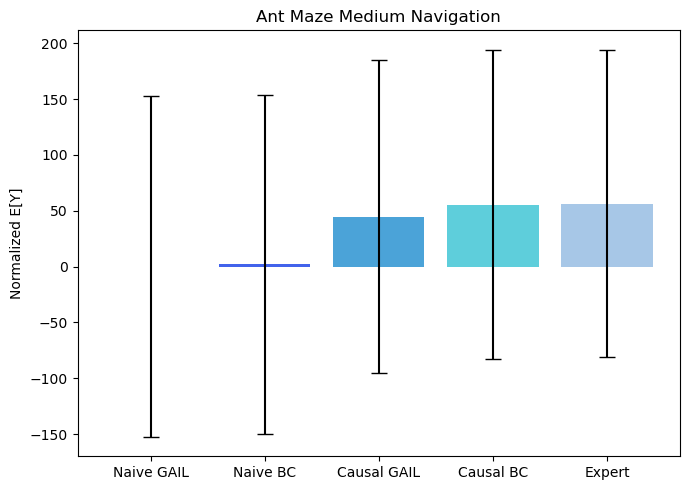

In [53]:
# compute averages
expert_avg = np.mean(expert_rewards)
causal_bc_avg = np.mean(causal_bc_rewards)
naive_bc_avg  = np.mean(naive_bc_rewards)
causal_gail_avg = np.mean(causal_gail_rewards)
naive_gail_avg  = np.mean(naive_gail_rewards)

# compute standard errors (optional but recommended)
expert_std = np.std(expert_rewards)
causal_bc_std = np.std(causal_bc_rewards)
naive_bc_std = np.std(naive_bc_rewards)
causal_gail_std = np.std(causal_gail_rewards)
naive_gail_std = np.std(naive_gail_rewards)

labels = ['Expert', 'Causal BC', 'Naive BC', 'Causal GAIL', 'Naive GAIL']
averages = [expert_avg, causal_bc_avg, naive_bc_avg, causal_gail_avg, naive_gail_avg]
errors = [expert_std, causal_bc_std, naive_bc_std, causal_gail_std, naive_gail_std]

# normalize results for better visualization
min_avg = min(averages)
averages = [avg - min_avg for avg in averages]

sorted_data = sorted(zip(averages, errors, labels), reverse=False)
averages, errors, labels = map(list, zip(*sorted_data))

colors = ['#0A5E8C',  # Expert
          '#4263EB',  # Causal BC
          '#4BA3D8',  # Naive BC
          '#5ECEDB',  # Causal GAIL
          '#A7C7E7']  # Naive GAIL

plt.figure(figsize=(7,5))
plt.bar(labels, averages, yerr=errors, capsize=6, color=colors)
plt.ylabel('Normalized E[Y]')
plt.title('Ant Maze Medium Navigation')
plt.tight_layout()
plt.show()

# Plots

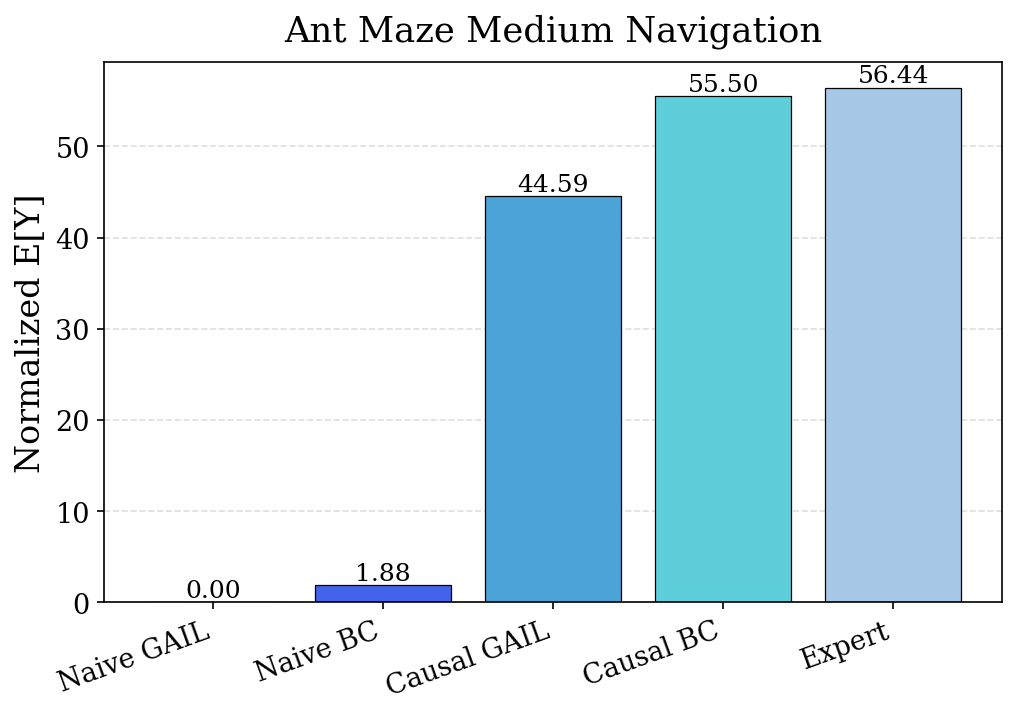

In [54]:
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 14,
    "axes.titlesize": 16,
    "axes.labelsize": 16,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "figure.dpi": 150
})

# --- your data processing code here ---

fig, ax = plt.subplots(figsize=(7, 5))

bars = ax.bar(labels, averages, capsize=4,
              color=colors, edgecolor="black", linewidth=0.6)

# subtle horizontal grid
ax.yaxis.grid(True, linestyle='--', alpha=0.4)
ax.set_axisbelow(True)

# labels
ax.set_ylabel("Normalized E[Y]", fontsize=16)
ax.set_title("Ant Maze Medium Navigation", fontsize=17, pad=10)

# rotate x-labels slightly for readability
plt.setp(ax.get_xticklabels(), rotation=20, ha="right")

# add numeric labels above bars (optional but nice)
for bar, avg in zip(bars, averages):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.01,
            f'{avg:.2f}', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.savefig('antmaze_eval.pdf', dpi=300)
plt.show()

In [55]:
len(records), len(causal_bc_records), len(naive_bc_records), len(causal_gail_records), len(naive_gail_records)

(1000000, 999962, 1000000, 1000000, 1000000)

In [56]:
sum(expert_rewards)/num_eps, sum(causal_bc_rewards)/num_eps, sum(naive_bc_rewards)/num_eps, sum(causal_gail_rewards)/num_eps, sum(naive_gail_rewards)/num_eps

(-419.60046920794497,
 -420.5418978551617,
 -474.1644931476959,
 -431.4509436505858,
 -476.0448664528324)

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import cm

def get_episode_xy_from_records(records, episode_id: int):
    '''
    records: list of dicts from collect_expert_trajectories(...)
    episode_id: which episode to extract

    Returns:
        xs, ys : np.ndarray of shape (T,)
    '''
    # Filter records for that episode, sorted by step
    ep = [r for r in records if r['episode'] == episode_id]
    ep = sorted(ep, key=lambda r: r['step'])

    xs, ys = [], []
    for r in ep:
        # r['info']['hidden_obs']['P'] is a *history* list; last entry is current position
        pos = r['obs']['P'][-1]   # shape (3,)
        xs.append(pos[0])
        ys.append(pos[1])

    return np.array(xs), np.array(ys)

def plot_ant_trajectory_xy(records, episode_id: int = 0, ax=None, title_prefix='AntMaze'):
    '''
    Visualize the ant's 2D trajectory (x, y) for a single episode.

    - Path is colored by time (early=dark, late=bright).
    - Start and end are annotated.
    - Small arrows show direction every few steps.
    '''
    xs, ys = get_episode_xy_from_records(records, episode_id)
    T = len(xs)

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    else:
        fig = ax.figure

    # Build a colored line collection for the path
    points = np.array([xs, ys]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Time as color (0..1)
    t_norm = np.linspace(0, 1, T-1)
    lc = LineCollection(segments, cmap='viridis', norm=plt.Normalize(0, 1))
    lc.set_array(t_norm)
    lc.set_linewidth(2.5)
    ax.add_collection(lc)

    # Start and end markers
    ax.scatter(xs[0], xs[0], alpha=0)  # dummy to keep colors aligned if needed
    ax.scatter(xs[0], ys[0], s=80, c='green', marker='o', edgecolors='black', label='Start')
    ax.scatter(xs[-1], ys[-1], s=80, c='red', marker='X', edgecolors='black', label='End')

    # Small arrows every N steps to show direction
    step = max(1, T // 30)  # about ~30 arrows max
    for i in range(0, T-1, step):
        dx = xs[i+1] - xs[i]
        dy = ys[i+1] - ys[i]
        ax.arrow(xs[i], ys[i], dx, dy,
                 length_includes_head=True,
                 head_width=0.2,
                 head_length=0.4,
                 alpha=0.6)

    # Colorbar for time
    cbar = fig.colorbar(lc, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Time (normalized)')

    ax.set_aspect('equal', 'box')
    ax.set_xlabel('x position')
    ax.set_ylabel('y position')
    ax.set_title(f'{title_prefix} - Episode {episode_id} trajectory')
    ax.grid(alpha=0.3)
    ax.legend(loc="upper left")

    plt.tight_layout()
    plt.savefig('antmaze_causal_traj.pdf', dpi=300)
    return fig, ax

In [58]:
i = 0

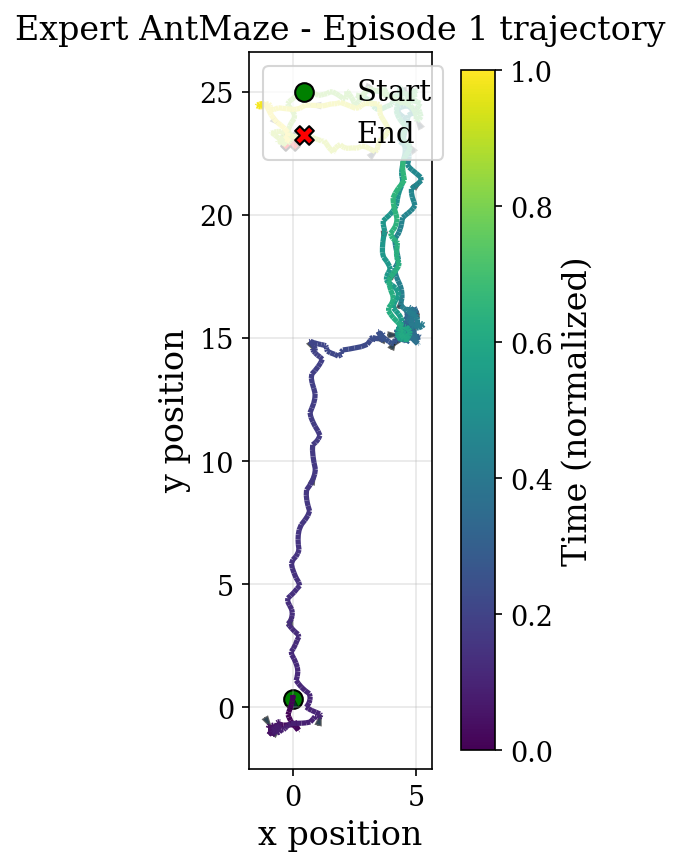

In [59]:
fig, ax = plot_ant_trajectory_xy(records, episode_id=1, title_prefix='Expert AntMaze')
plt.show()
i += 1

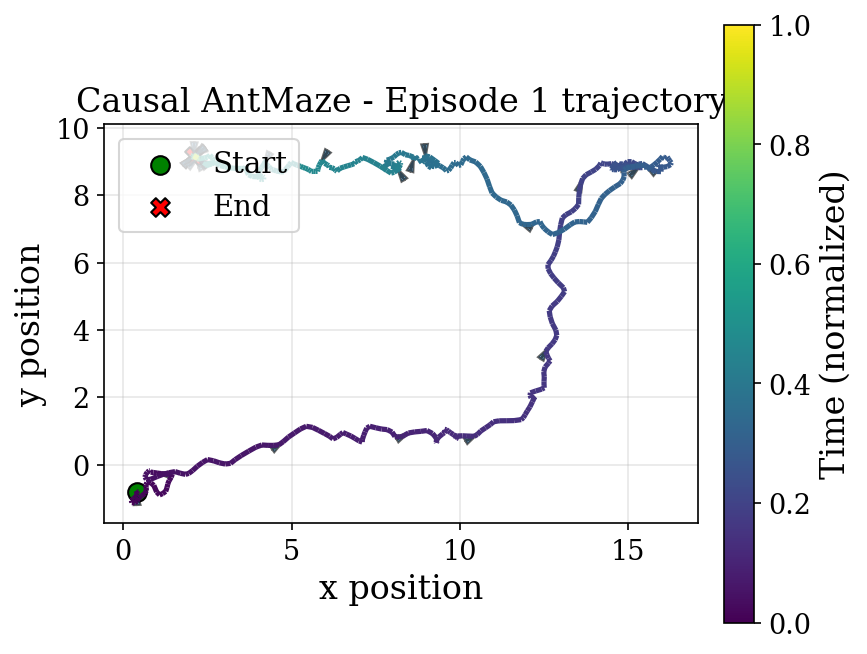

In [60]:
fig, ax = plot_ant_trajectory_xy(causal_bc_records, episode_id=i % num_eps, title_prefix='Causal AntMaze')
plt.show()
i += 1

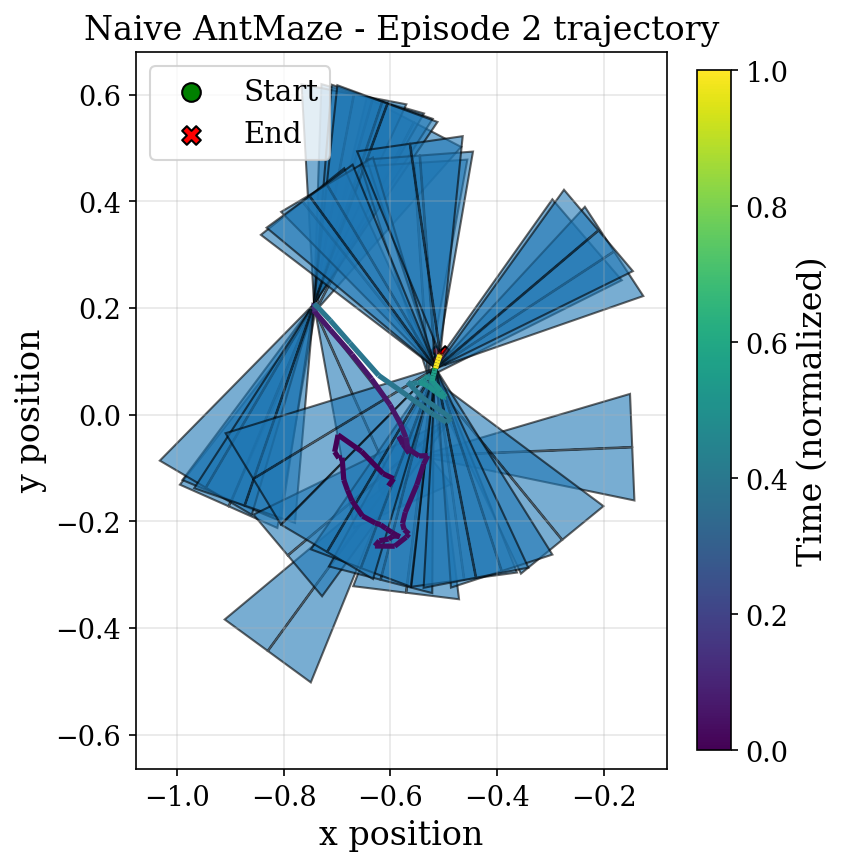

In [61]:
fig, ax = plot_ant_trajectory_xy(naive_bc_records, episode_id=i % num_eps, title_prefix='Naive AntMaze')
plt.show()
i += 1

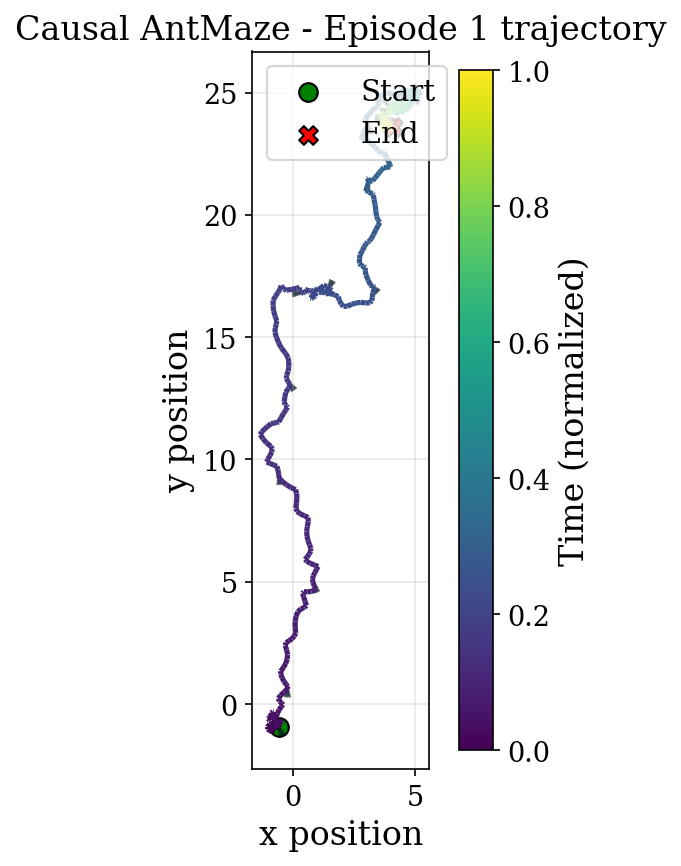

In [62]:
fig, ax = plot_ant_trajectory_xy(causal_gail_records, episode_id=1, title_prefix='Causal AntMaze')
plt.show()
i += 1

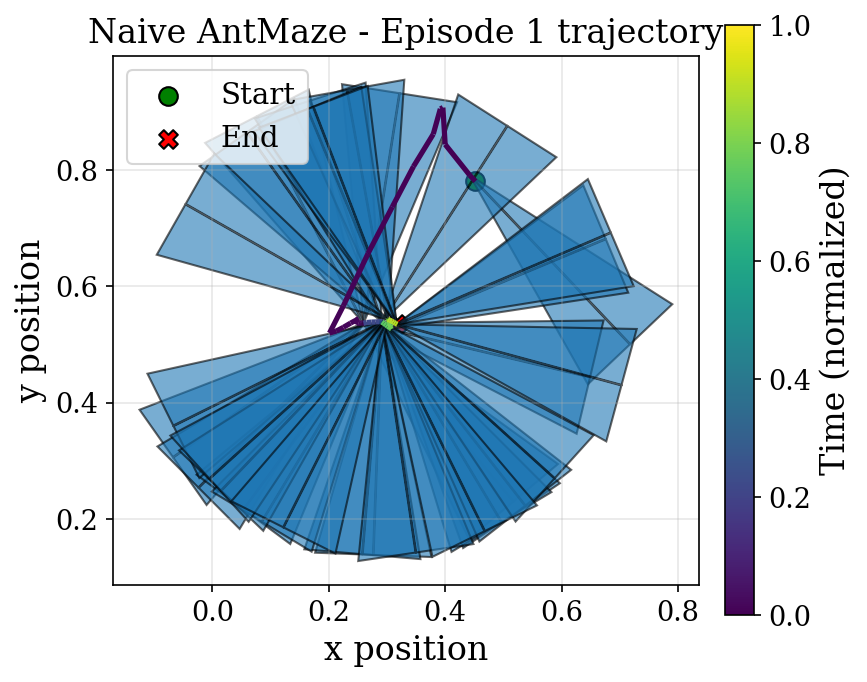

In [63]:
fig, ax = plot_ant_trajectory_xy(naive_gail_records, episode_id=1, title_prefix='Naive AntMaze')
plt.show()
i += 1

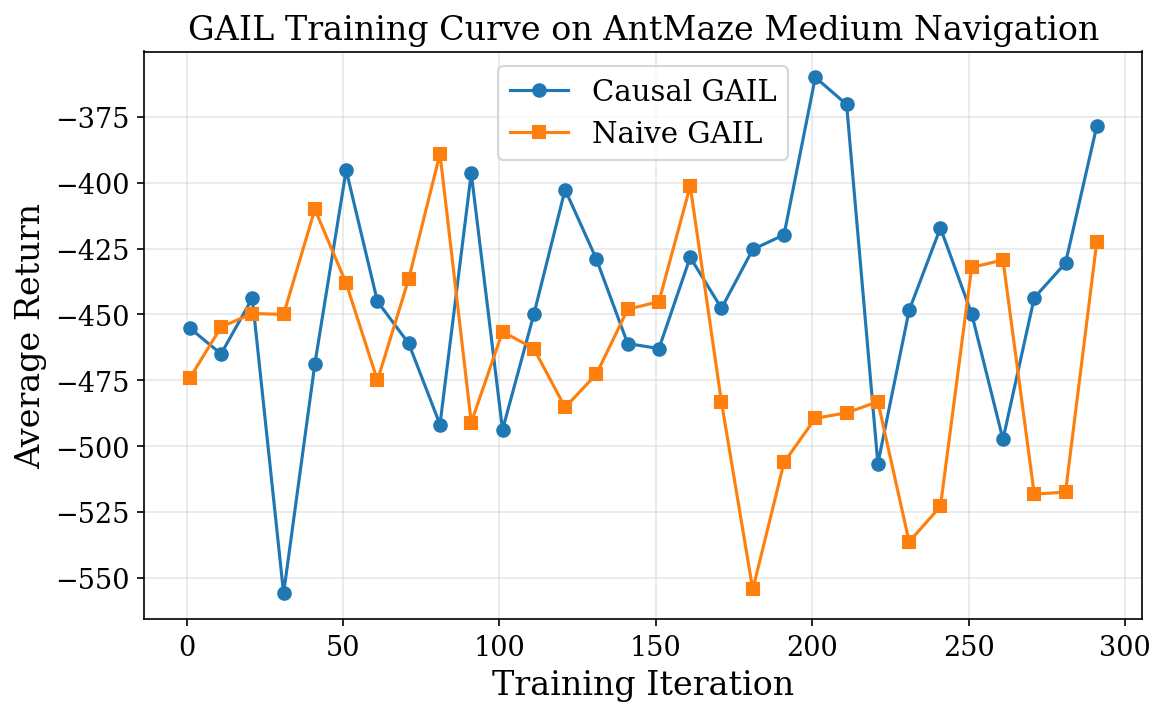

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# ---- 1) Naive GAIL returns ----
naive_returns_full = [entry["avg_env_return"] for entry in logs_naive_gail]
naive_iters = list(range(1, 301, 10))
naive_returns = [naive_returns_full[i - 1] for i in naive_iters]  # i-1 because 0-based

# ---- 2) Causal GAIL returns, subsampled every 10 iterations ----
# logs_causal_gail should have one entry per iter, in order: iter 1..N
causal_returns_full = [entry["avg_env_return"] for entry in logs_causal_gail]

causal_iters = naive_iters  # same x-axis points
causal_returns = [causal_returns_full[i - 1] for i in causal_iters]  # i-1 because 0-based

# ---- 3) Plot ----
plt.figure(figsize=(8, 5))
plt.plot(causal_iters, causal_returns, marker="o", label="Causal GAIL")
plt.plot(naive_iters, naive_returns, marker="s", label="Naive GAIL")

plt.xlabel("Training Iteration")
plt.ylabel("Average Return")
plt.title("GAIL Training Curve on AntMaze Medium Navigation")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("antmaze_gail_learning_curve_subsampled.pdf", dpi=300, bbox_inches="tight")
plt.show()


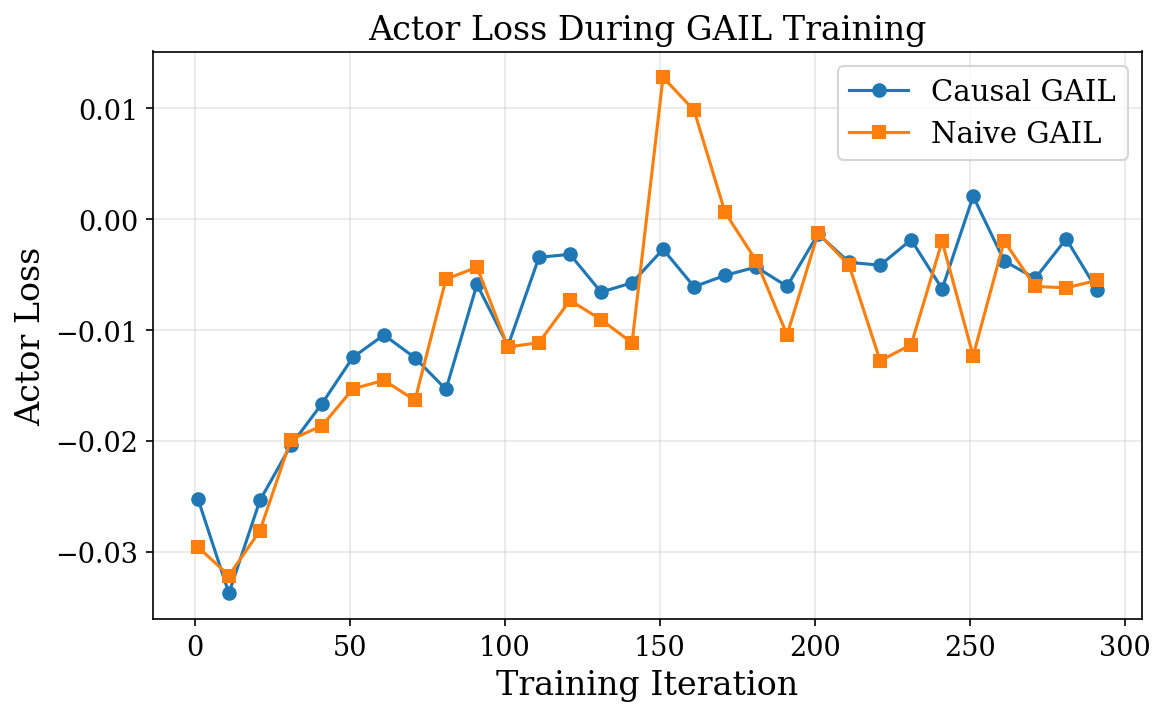

In [65]:
# ---- Naive GAIL actor losses from printouts ----
naive_actor_full = [x["ppo_actor_loss"] for x in logs_naive_gail]
naive_actor_losses = [naive_actor_full[i - 1] for i in naive_iters]

# ---- Causal GAIL actor loss: subsample every 10 iterations ----
causal_actor_full = [x["ppo_actor_loss"] for x in logs_causal_gail]
causal_actor_losses = [causal_actor_full[i - 1] for i in naive_iters]

# ---- Plot ----
plt.figure(figsize=(8, 5))
plt.plot(naive_iters, causal_actor_losses, marker="o", label="Causal GAIL")
plt.plot(naive_iters, naive_actor_losses, marker="s", label="Naive GAIL")

plt.xlabel("Training Iteration")
plt.ylabel("Actor Loss")
plt.title("Actor Loss During GAIL Training")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("antmaze_actor_loss_curve.pdf", dpi=300, bbox_inches="tight")
plt.show()


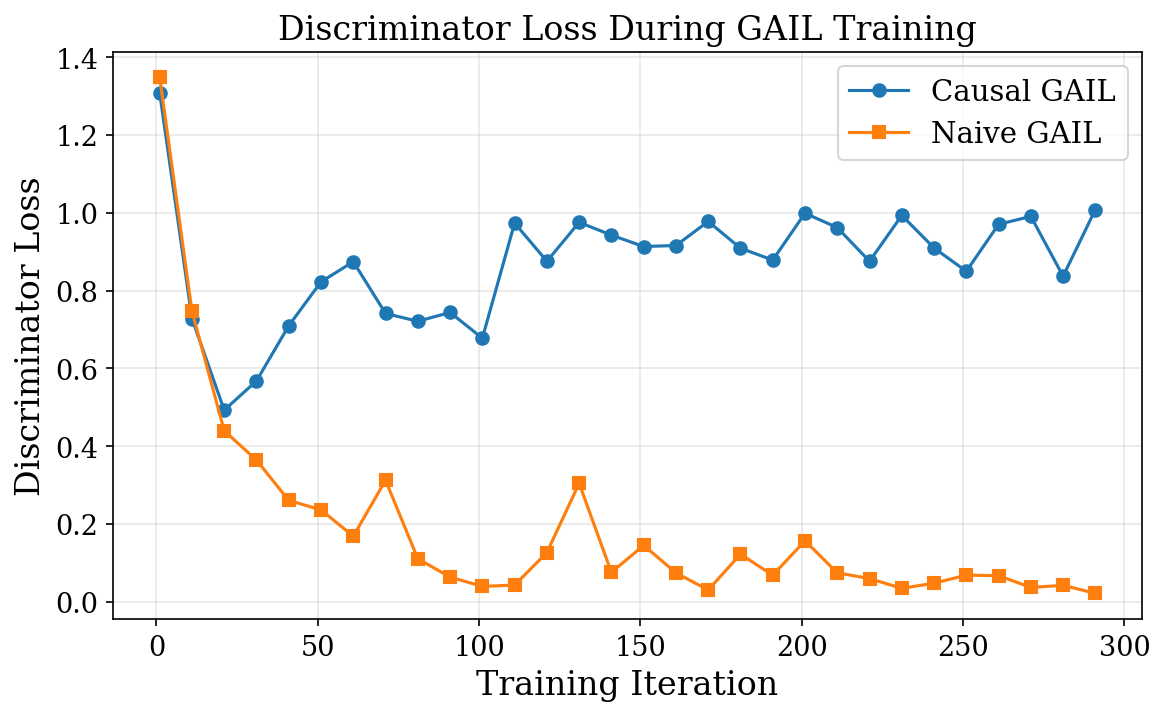

In [66]:
# ---- Naive GAIL discriminator losses from printouts ----
naive_d_full = [x["D_loss"] for x in logs_naive_gail]
naive_d_losses = [naive_d_full[i - 1] for i in naive_iters]

# ---- Causal GAIL D-loss: subsample ----
causal_d_full = [x["D_loss"] for x in logs_causal_gail]
causal_d_losses = [causal_d_full[i - 1] for i in naive_iters]

# ---- Plot ----
plt.figure(figsize=(8, 5))
plt.plot(naive_iters, causal_d_losses, marker="o", label="Causal GAIL")
plt.plot(naive_iters, naive_d_losses, marker="s", label="Naive GAIL")

plt.xlabel("Training Iteration")
plt.ylabel("Discriminator Loss")
plt.title("Discriminator Loss During GAIL Training")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("antmaze_discriminator_loss_curve.pdf", dpi=300, bbox_inches="tight")
plt.show()

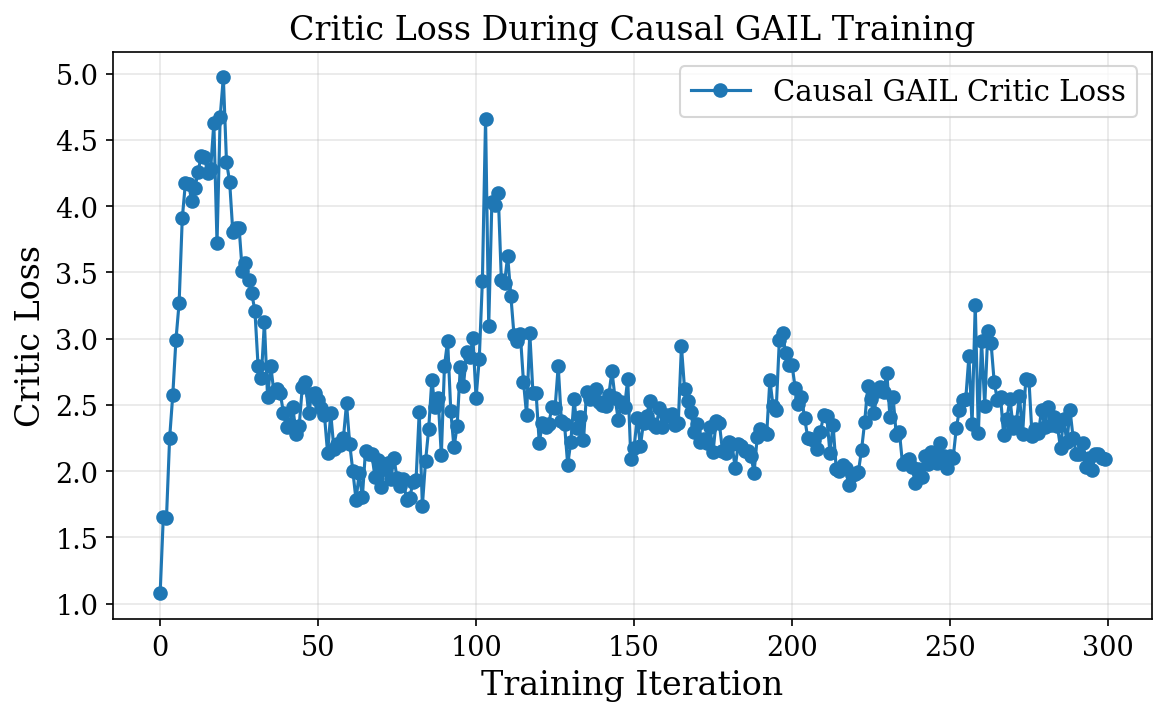

In [67]:
# ---- Causal GAIL Critic Loss ----
causal_critic_full = [x["ppo_critic_loss"] for x in logs_causal_gail]

plt.figure(figsize=(8, 5))
plt.plot(causal_critic_full, marker="o", label="Causal GAIL Critic Loss")
plt.xlabel("Training Iteration")
plt.ylabel("Critic Loss")
plt.title("Critic Loss During Causal GAIL Training")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("antmaze_causal_critic_loss_curve.pdf", dpi=300, bbox_inches="tight")
plt.show()


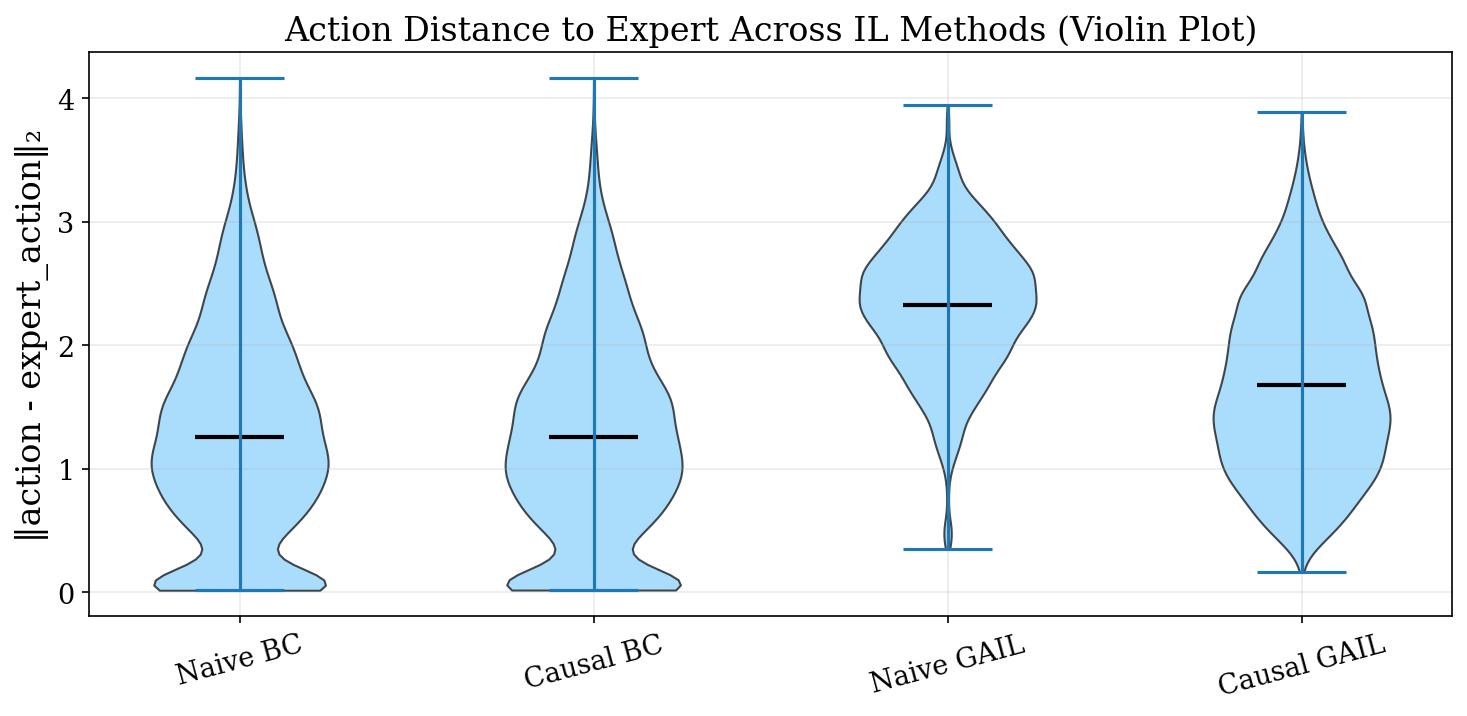

In [68]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------
# CONFIG
# ----------------------------------------
N_SAMPLES = 10000   # <- adjust depending on how fast you want it
np.random.seed(0)

# Sample a subset of indices
idxs = np.random.choice(len(records), size=min(N_SAMPLES, len(records)), replace=False)
records_sampled = [records[i] for i in idxs]

# ----------------------------------------
# Distance function
# ----------------------------------------
def action_distance(policy_fn, recs):
    diffs = []
    for rec in recs:
        obs = rec["obs"]
        a_exp = rec["action"].astype(np.float32)
        a_pi  = policy_fn(obs).astype(np.float32)
        diffs.append(np.linalg.norm(a_pi - a_exp))
    return np.array(diffs)

# ----------------------------------------
# Collect distances
# ----------------------------------------
d_naive_bc   = action_distance(naive_bc_policy, records_sampled)
d_causal_bc  = action_distance(causal_bc_policy, records_sampled)
d_naive_gail = action_distance(naive_gail_policy, records_sampled)
d_causal_gail= action_distance(causal_gail_policy, records_sampled)

data = [d_naive_bc, d_causal_bc, d_naive_gail, d_causal_gail]
labels = ["Naive BC", "Causal BC", "Naive GAIL", "Causal GAIL"]

# ----------------------------------------
# Violin plot
# ----------------------------------------
plt.figure(figsize=(10,5))
parts = plt.violinplot(
    data,
    showmeans=True,
    showextrema=True,
    showmedians=False
)

# Aesthetics
for pc in parts['bodies']:
    pc.set_facecolor("#87CEFA")
    pc.set_edgecolor("black")
    pc.set_alpha(0.7)

parts['cmeans'].set_edgecolor("black")
parts['cmeans'].set_linewidth(2)

plt.xticks(np.arange(1, len(labels)+1), labels, rotation=15)
plt.ylabel("‖action - expert_action‖₂")
plt.title("Action Distance to Expert Across IL Methods (Violin Plot)")
plt.grid(True, alpha=0.25)

plt.tight_layout()
plt.savefig("antmaze_action_distance_violin.pdf", dpi=300, bbox_inches="tight")
plt.show()


/tmp/ipykernel_1648198/3896536244.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showmeans=True,


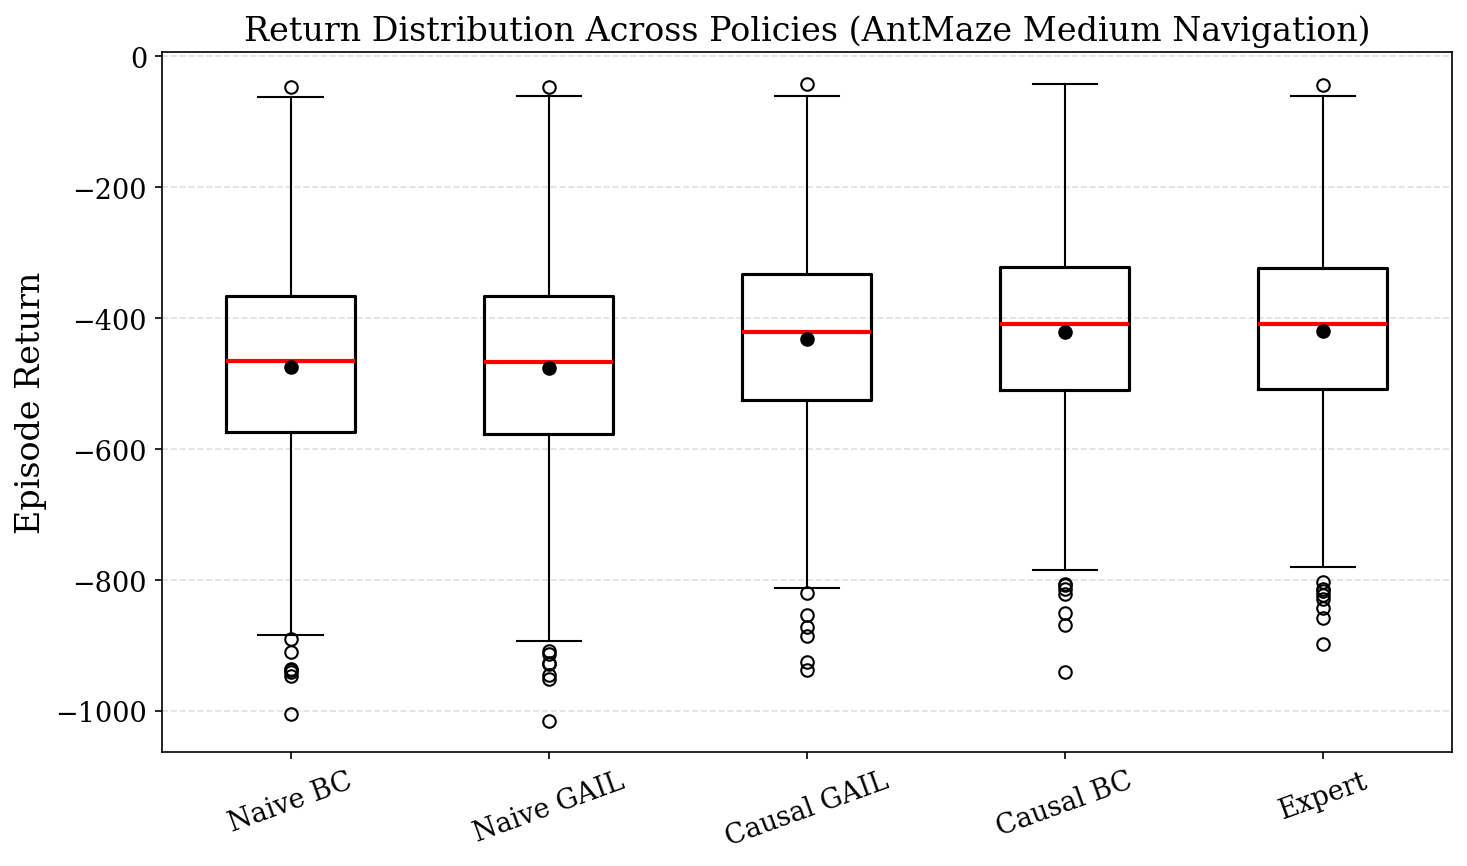

In [69]:
import matplotlib.pyplot as plt

labels = [
    "Naive BC",
    "Naive GAIL",
    "Causal GAIL",
    "Causal BC",
    "Expert"
]

data = [
    naive_bc_rewards,
    naive_gail_rewards,
    causal_gail_rewards,
    causal_bc_rewards,
    expert_rewards
]

plt.figure(figsize=(10,6))
plt.boxplot(data, labels=labels, showmeans=True,
            meanprops={"marker":"o", "markerfacecolor":"black", "markeredgecolor":"black"},
            boxprops=dict(linewidth=1.5),
            medianprops=dict(linewidth=2, color="red"))

plt.ylabel("Episode Return")
plt.title("Return Distribution Across Policies (AntMaze Medium Navigation)")
plt.xticks(rotation=20)
plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.savefig("antmaze_return_distribution.pdf", dpi=300)
plt.show()
